# Explainer Notebook
---
## Final Project - Assignment A 
Our project idea 

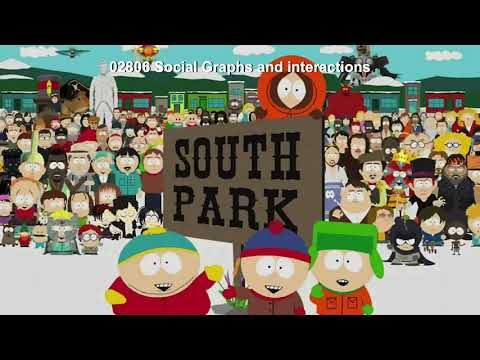

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("a5OdrfieMnE",width=800, height=450)
# link: https://www.youtube.com/watch?v=a5OdrfieMnE

---
## Final Project - Assignment B 
### 02805 - Social Graphs and Interactions
This notebook includes the code for the network and text analyses of the South Park data set. The notebook consists of the following 5 Parts. 
* Part 1: Create Data
* Part 2: Create Networks
* Part 3: Network Analysis
* Part 4: Community Analysis
* Part 5: Sentiment Analysis


Part 1 explains how the data set is gatered, what is needed to run the analysis and how we preprossesed the data to a format we could use. Part 2 explains how the networks are created based on the data set. Part 3 explains which network analysis methods have been used, as well as how the network analysis was carried out. Part 4. performs community analysis on both networks and does so by applying two community detection algoritms. Part 5.  Perform sentiment analysis on characters of SouthPark and wikipedia pages of celebrities occuring on the show. 

In [2]:
# all imports used throughout the notebook
import time                                                
import numpy as np
import os
import json
import urllib
import re
import requests
import urllib.request
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import statistics as st
import powerlaw
from tqdm import tqdm
import pandas as pd 
import nltk
import string
import seaborn as sns
from collections import Counter

from bs4 import BeautifulSoup
from tqdm import tqdm
from fa2 import ForceAtlas2

import pandas as pd

--
## Part 1: Create data
In order to extact the South Park information we needed for the analysis from the Fandom South Park Archives using the Fandom api.

The data needed for the full analysis includes:

1. Character lists
    * A list of all characters
    * A list of celebrity charaters 
    * A list of fictional charaters
2. A list of all episode titles 
3. Episode manuscripts 
4. A cast list for all episodes 
5. Selected celebrity wiki-pages

The following section will show how we gathered the data. 

### Paths and filenames 

In [3]:
# set path and output file names
data_dir = 'data'
cast_dir = f'{data_dir}/episode_cast_lists'
script_dir = f'{data_dir}/episode_scripts'
celebrities_wiki_dir = f'{data_dir}/celebrities_wikipages'
episode_dialog_cleaned_dir = f'{data_dir}/episode_dialogs_cleaned'
dialog_dir = f'{data_dir}/character_dialogs'
Figures_dir = 'Figures'

all_characters_filename = "All_characters.txt"
celeb_characters_filename = "Celebrity_characters.txt"
south_park_characters_filename = "South-Park_characters.txt"
episode_list_filename = "Episodes.txt"
episode_data_filename = "Episode_data.txt"

# and create folders if they do not already exist
if not(os.path.exists(data_dir)):
    os.mkdir(data_dir)
    
if not(os.path.exists(cast_dir)):
    os.mkdir(cast_dir)

if not(os.path.exists(script_dir)):
    os.mkdir(script_dir)

if not(os.path.exists(episode_dialog_cleaned_dir)):
    os.mkdir(episode_dialog_cleaned_dir)
else:
    for f in os.listdir(episode_dialog_cleaned_dir):
        try:
            os.remove(os.path.join(episode_dialog_cleaned_dir, f))
        except:
            print("ipynb")
if not(os.path.exists(dialog_dir)):
    os.mkdir(dialog_dir)
    
if not(os.path.exists(celebrities_wiki_dir)):
    os.mkdir(celebrities_wiki_dir)

if not(os.path.exists(Figures_dir)):
    os.mkdir(Figures_dir)

ipynb


### Define functions for later use in data load part

In [4]:
def load_json_text_from_query(site_name, baseurl = "https://southpark.fandom.com/api.php?"):
    # load data from sitename and basurl, 
    # otherwise the urlib rquest is equivalent for all data files used in the report
    # set the base parameters for the page
    action = "action=query"
    content = "prop=revisions&rvprop=content"
    dataformat ="format=json"
    title = f"titles={site_name}"
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    try:
        text = json.loads(urllib.request.urlopen(query).read().decode('utf-8'))
    except:
        text = None
        print("could not load data from URL")
        print(query)
    return text 

def clean_links(links):
    # function that cleans up the links forund in within the fandom pages

    # clean the links
    # escape everything to the right of '|'
    pattern = re.compile(re.escape('|')+'.*')
    links = [pattern.sub("", l) for l in links]

    # remove square bracket chacacters 
    links = [l.replace("[[", "").replace("]]", "").replace(" ", "_").replace("\"", "").lower() for l in links]
    #links = [l.replace("]]", "") for l in links]
    
    return links

def get_episode_data(episode_str):
    #Extract data for each episode
    elements = episode_str.split("|")
    no = None 
    title = None
    try: 
        titleFound = False
        noFound  = False
        for element in elements: 
            if titleFound == False and "title=" in element:
                title_end = element.find("\\n")
                title = element[6:title_end]
                titleFound = True;
            if noFound == False and "no=" in element: 
                no_end =element.find("\\n") 
                no = element[3:no_end]
            if noFound and titleFound: 
                break;
    except:
        print("Could not extract data\n")
        print(episode_str)
    if title == None or no == None:  
        return None, None 
    else:
        return title, no
    
def create_match_dict(characters, cast_list):
    # function that matches cast list of an episode to names in the script.
    # this is needed as in the script nick names and first names might be used instead. 
    
    #find unique characters
    unique_characters = list(set(characters))
    nick_names = [ch.split("|")[1] if ch.find("|") != -1 else -1 for ch in cast_list ]
    first_names = [ch.split(" ")[0] if ch.find(" ") != -1 and ch.split(" ")[0].find("|") == -1 else -1 for ch in cast_list]
    cast_list_cleaned = [ch.split("|")[0] if ch.find("|") != -1 else ch for ch in cast_list]

    last_names = []
    for ch in cast_list:
        if ch.find("|") != -1 and ch.split("|")[0].find(" ") != -1:
            last_names.append(ch.split("|")[0].split(" ")[1])
        elif ch.find(" ") != -1 and ch.find(",") == -1:
            last_names.append(ch.split(" ")[1])
        else:
            last_names.append(-1)
        

    # create match dictionary
    match_dict = {}
    for idx,character in enumerate(unique_characters): #complete name
        
        more_names = character.find(",") != -1 
        last_name = not more_names and character.find(" ") != -1
        
        if more_names: #ignore when several characters speak at once. 
            continue;
        if character in cast_list_cleaned: #complete name
            match_dict[character] = character

        elif character in nick_names: #character name is nick name
            match_dict[character] = cast_list[nick_names.index(character)].split("|")[0]
            
        elif character in first_names: #character name is first name
            match_dict[character] = cast_list[first_names.index(character)] if cast_list[first_names.index(character)].find("|") == -1 else cast_list[first_names.index(character)].split("|")[0]
        
        elif character in last_names: #character name is last name
            match_dict[character] = cast_list[last_names.index(character)] if cast_list[last_names.index(character)].find("|") == -1 else cast_list[last_names.index(character)].split("|")[0]

        elif character.find(" ") != -1 and character.split(" ")[-1] in last_names : 
            #characters last name is in last names of cast        
            name = cast_list[last_names.index(character.split(" ")[-1])]
            if name.find("|") != -1:
                name = name.split("|")[0]
            match_dict[character] = name
        
    return match_dict

def get_dialogs_and_characters(str_text):
    # function to extract seperate Script dialogs. 
    # note that the else statement is included as we saw examples, 
    # where the str was not split properly. 
    results = re.findall(r'\{\{ScriptDialog\|(.*?)\}\}', str_text)

    results_new = []
    for r in results:
        if r.find("{{ScriptDialog|") == -1:
            results_new.append(r)
        else:
            for r_sub in r.split("{{ScriptDialog|"):
                results_new.append(r_sub)
    return results_new

def clean_dialog(d):
    # clean the dialog from unerccesary things (we are only interested in words)
    CLEANR = re.compile('<.*?>') 
    cleantext = re.sub(CLEANR, '', d)
    #remove text between [ and ]
    cleantext = re.sub(r'\[.*?\]', '', cleantext)
    #remove extra stuff
    cleantext = cleantext.replace("\\'", "").replace("\\n", "").replace('\\"', "")
    #remove signs
    cleantext = cleantext.replace("!", "").replace("?", "").replace(".", "").replace(",", "").replace(":", "").replace(";", "")
    #remove multiple spaces
    cleantext = re.sub(' +', ' ', cleantext)
    #remove leading and trailing spaces
    cleantext = cleantext.strip()
    
    return cleantext.lower()

num2words = {1: 'One', 2: 'Two', 3: 'Three', 4: 'Four', 5: 'Five', 
             6: 'Six', 7: 'Seven', 8: 'Eight', 9: 'Nine', 10: 'Ten', 
            11: 'Eleven', 12: 'Twelve', 13: 'Thirteen', 14: 'Fourteen', 
            15: 'Fifteen', 16: 'Sixteen', 17: 'Seventeen', 18: 'Eighteen', 
            19: 'Nineteen', 20: 'Twenty', 30: 'Thirty', 40: 'Forty', 
            50: 'Fifty', 60: 'Sixty', 70: 'Seventy', 80: 'Eighty', 
            90: 'Ninety', 0: 'Zero'}
def n2w(n):
    try:
        return num2words[n]
    except KeyError:
        try:
            if n<= 20:
                return num2words[n-n%10] + num2words[n%10].lower()
            else:
                return num2words[n-n%10] +"-"+ num2words[n%10]
        except KeyError:
            print('Number out of range')
     


### Save All Episode Information 
for now the upper version is the "Old" version, and the lower version is annas. 
I will check whether the notebook will run properly based on these parameters

##### Extract all episode names

In [5]:
wikis_total = []

f = open(f"{data_dir}/{episode_data_filename}", "w")
f2 = open(f"{data_dir}/{episode_list_filename}", "w")

f.write(f"Title, Season, Episode, #\n")
for i in tqdm(range(1,26)):
    # get data from website
    site_name = "Season_" + n2w(i)
    text = load_json_text_from_query(site_name)
    
    #extract episode infomration 
    all_episode_in_season = re.findall(r'\{\{EpisodeListElement(.*?)\}\}', str(text))
    E = 0
    for episode_str in all_episode_in_season:
        title, no = get_episode_data(episode_str)
        if title == None or no == None:
            continue;
        S = str(i).zfill(2)
        E += 1

        wiki_link = title.replace(" ", "_").replace("\\", "").replace("?", "").replace("è","%C3%A8")
        wikis_total.append(wiki_link)
        
        f.write(f"{wiki_link}, {S}, {str(E).zfill(2)}, {str(no)}\n")
        f2.write(f"{wiki_link}\n")

f.close()
f2.close()

100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.54it/s]


##### Extract episode manuscripts and cast lists 


In [6]:
for e in tqdm(wikis_total):
    #if e[0] == "S":
    #link = e[e.find("_", e.find("_") + 1)+8:].split(".")[0]

    site_name = f"{e}/Script"
    
    try:
        text = load_json_text_from_query(site_name)
        str_text = str(text)
        raw_links = re.findall(r'\[\[[\w\s\"\|\.]+\]\]', str_text)
        cast_list = [character.removeprefix("[[").removesuffix("]]").lower() for character in raw_links]
        # extract each script dialog
        results = re.findall(r'\{\{ScriptDialog\|(.*?)\}\}', str_text)
        split_line = [r.split("|") for r in results]

        # extract the character name 
        characters = [r[0].lower() if len(r) == 2 else split_line[idx-1][0].lower() for idx, r in enumerate(split_line)]
        # extract the dialog
        dialog = [r[1] if len(r) == 2 else r[0] for idx,r in enumerate(split_line)]

        # clean each element in the dialog list
        dialog = [clean_dialog(d) for d in dialog]




        match_dict = create_match_dict(characters, cast_list)
        
        # safe cast links
        cast_clean_links = clean_links(raw_links)

        with open(f'{cast_dir}/cast_{e}.txt', 'w', encoding = "utf-8") as f:
            for c in cast_clean_links:
                f.write("%s\n" % c)    

        #safe episode script 
        with open(f'{script_dir}/{e}.txt', 'w', encoding = "utf-8") as f:
            f.write("%s" % str_text.split("==Script==")[1])

        # safe all dialogs 
        with open(f'{episode_dialog_cleaned_dir}/dialog_{e}.txt', 'w', encoding = "utf-8") as f:
            for idx,character in enumerate(characters):
                f.write("%s\n" % dialog[idx])

        # safe all dialog characters
        for idx, character in enumerate(characters):
            if character in match_dict.keys():
                filename = match_dict[character].replace(" ", "_").replace("\"", "")
                with open(f'{dialog_dir}/{filename}.txt', 'a', encoding = "utf-8") as f:
                    f.write("%s\n" % dialog[idx])
                

    except:
        print(e)



 15%|███████████▊                                                                  | 47/311 [00:30<02:07,  2.06it/s]

Are_You_There_God_It's_Me,_Jesus


 18%|██████████████▎                                                               | 57/311 [00:37<02:05,  2.03it/s]

Do_the_Handicapped_Go_to_Hell


 55%|██████████████████████████████████████████▎                                  | 171/311 [01:51<00:58,  2.41it/s]

Eek,_A_Penis!


 67%|███████████████████████████████████████████████████▎                         | 207/311 [02:08<00:42,  2.44it/s]

Coon_vs._Coon_&_Friends


 71%|██████████████████████████████████████████████████████▍                      | 220/311 [02:14<00:41,  2.21it/s]

1%


 82%|███████████████████████████████████████████████████████████████▍             | 256/311 [02:31<00:24,  2.20it/s]

Where_My_Country_Gone


 88%|████████████████████████████████████████████████████████████████████         | 275/311 [02:40<00:15,  2.36it/s]

White_People_Renovating_Houses_


 90%|█████████████████████████████████████████████████████████████████████        | 279/311 [02:42<00:15,  2.12it/s]

Hummels_&_Heroin


 94%|████████████████████████████████████████████████████████████████████████     | 291/311 [02:49<00:10,  1.91it/s]

Nobody_Got_Cereal


100%|█████████████████████████████████████████████████████████████████████████████| 311/311 [03:04<00:00,  1.69it/s]


### Save List of Episode Titles

In [7]:
clean_episodes = wikis_total.copy()
print(len(clean_episodes))

with open(f'{data_dir}/{episode_list_filename}', 'w') as f:
    f.write('\n'.join(clean_episodes))

311


### Save List of All Characters

In [8]:
site_name = f"Portal:Characters"
text = load_json_text_from_query(site_name)

# find and clean all character links
all_characters_list = re.findall(r'\[\[[\.\"\w\s\\\'\-]+]]', str(text))
all_characters_list = clean_links(all_characters_list)

# save the character list
with open(f'{data_dir}/{all_characters_filename}', 'w') as f:
    for c in all_characters_list:
        f.write("%s\n" % c.lower().replace(" ", "_").replace("\\",""))

# check: opening the file in read mode and print length
all_characters_list = open(f'{data_dir}/{all_characters_filename}', "r").read().split("\n")
print(len(all_characters_list))


1917


### Save Cast Lists for Each Episode

#### *Save Celebrity-Based Character List*

In [9]:
# https://southpark.fandom.com/wiki/Portal:Characters/Categorized_Characters
site_name = f"Portal:Characters/Categorized_Characters"

text = load_json_text_from_query(site_name)

In [10]:
# find the part of the text where the celebrities are listed
pattern = re.compile('^.*==Celebrities==', re.I)
celebs_text = pattern.sub("", str(text))

In [11]:
# find and clean/format all celebrity links
celebs_list = re.findall(r'\[\[[\.\w\s\\\'\-]+]]', celebs_text)
celebs_list = clean_links(celebs_list)
celebs_list = [c.lower().replace(" ","_").replace("\\","") for c in celebs_list]

# save celebrity list 
with open(f'{data_dir}/{celeb_characters_filename}', "w") as f:
    f.write('\n'.join(celebs_list))

#### *Save South Park Fictional Character List*

In [12]:
# extract the south-park chatracters from all-character-list (the ones that are not celebrities)
south_park_characters = [c for c in all_characters_list if c not in celebs_list]   

# save south park character list 
with open(f'{data_dir}/{south_park_characters_filename}', "w") as f:
    f.write('\n'.join(south_park_characters))

### Save Wiki-Pages For All Celebrities (If Found)


In [13]:
# set the base parameters for the wikipages
baseurl = "https://en.wikipedia.org/w/api.php?"
action = "action=query"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"

# opening the file containing the celebrity caracters 
celebrity_characters_list = open(f'{data_dir}/{celeb_characters_filename}', "r").read().split("\n")

for cc in celebrity_characters_list:
    
    title = f"titles={cc.title()}"
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
        
    try:
        text = json.loads(urllib.request.urlopen(query).read().decode('utf-8'))

        with open(f'{celebrities_wiki_dir}/{cc}.txt', 'w') as f:
            json.dump(text, f) 
    except:
        print(query)

https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=Sinéad_O'Connor&format=json
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=Felipe_Calderón&format=json
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=Luiz_Inácio_Lula_Da_Silva&format=json


---
## Part 2: Create Networks
Two networks have been created based on the data collection from Part 1. Applicable for both networks is that the nodes represent characters in South Park, while edges represent relationships between the South Park characters. In addition, the nodes ate divided into two different universes; *celebrity* and *fictional* depending on wheter a character is an impersonated celebrity character or a fictional character. In total two networks have been created. The first is where links are created between characters appearing in the same episode, *Episode-Based Network* (GE). The second is where links are created between characters appearing only in the same scene, *Scene-Based Network* (GS).



### Episode-Based Network (GE)
*Links created between characters appearing in the episode.*

In [14]:
# set path and output file names
data_dir = 'data'
cast_dir = f'{data_dir}/episode_cast_lists'
script_dir = f'{data_dir}/episode_scripts'

all_characters_filename = "All_characters.txt"
celeb_characters_filename = "Celebrity_characters.txt"
south_park_characters_filename = "South-Park_characters.txt"
episode_list_filename = "Episodes.txt"

# open the text file with all, celeb and south park characters
all_character_list = open(f"{data_dir}/{all_characters_filename}", "r").read().split("\n")
celeb_character_list = open(f"{data_dir}/{celeb_characters_filename}", "r").read().split("\n")
south_park_character_list = open(f"{data_dir}/{south_park_characters_filename}", "r").read().split("\n")

print("Character Stats:")
print(f" number of all characters: {len(all_character_list)}")
print(f" number of celeb characters: {len(celeb_character_list)}")
print(f" number of south-park characters: {len(south_park_character_list)}")
print(f" total: {len(celeb_character_list)+len(south_park_character_list)}")



Character Stats:
 number of all characters: 1917
 number of celeb characters: 429
 number of south-park characters: 1537
 total: 1966


In [15]:
# initialize GE graph - link when character appears in same episode 
init_GE = nx.Graph()

# add characters as nodes 
init_GE.add_nodes_from(celeb_character_list, u='celebrity')
init_GE.add_nodes_from(south_park_character_list, u='fiction')

In [16]:
# add episode-cast list as udirected edges between nodes 
match_list = list(set(all_character_list))

for filename in os.listdir(cast_dir):
    
    open_file = open(f"{cast_dir}/{filename}", "r")
    cast_list  = open_file.read().split("\n")
    open_file.close()
    
    # we dont care about duplicates if any
    combi_set = [(c1,c2) for c1 in cast_list for c2 in cast_list if not(c1==c2)]
    edge_set = [(c1,c2) for (c1,c2) in combi_set if (c1 in match_list and c2 in match_list)]
    init_GE.add_edges_from(edge_set)


In [17]:
# function that seperates nodes based on their universe
def get_node_groups(graph, u1, u2):
    group1 = [n for n,a in graph.nodes(data=True) if a['u'] == u1]
    group2 = [n for n,a in graph.nodes(data=True) if a['u'] == u2]
    
    return group1, group2


In [18]:
# function that creates color maps for visualisations
def generate_size_and_color_maps(graph, c_nodes, sp_nodes):
    
    node_size_map = [v*4 for v in dict(graph.degree).values()]
    c1, c2, c3 = 'darkgoldenrod', 'cadetblue', 'olivedrab'
    
    color_map_nodes = [c1 if a['u'] == 'celebrity' else c2 for n,a in graph.nodes(data=True)]
    color_map_edges = [c1 if (n1 in c_nodes and n2 in c_nodes) else c2 if (n1 in sp_nodes and n2 in sp_nodes) else c3 for (n1,n2) in graph.edges] 

    return node_size_map, color_map_nodes, color_map_edges

In [19]:
# function that makes a simple plot of a network
def simple_network_plot(graph, s_map, c_map_nodes, c_map_edges):
    plt.figure(figsize=(10,10))

    pos = nx.spring_layout(graph)

    nx.draw_networkx_nodes(graph, 
                           pos, 
                           node_size=s_map, 
                           node_color = c_map_nodes,
                           edgecolors = 'darkslategray',
                           alpha=0.6
                          )
    nx.draw_networkx_edges(graph, 
                           pos,
                           edge_color='silver',
                           alpha=0.4)
    
    plt.axis('off')
    plt.title("Visualization of South Park network",fontsize=20)
    plt.show()

In [20]:
#remove unconneted characters 
lccGE = max(nx.connected_components(init_GE), key=len)
GE = init_GE.subgraph(lccGE).copy()
GE.remove_node("")

In [21]:
# generate maps for visualization of network
GEceleb_nodes, GEsouth_park_nodes = get_node_groups(GE, 'celebrity', 'fiction')
GEnode_size_map, GEcolor_map_nodes, GEcolor_map_edges = generate_size_and_color_maps(GE, GEceleb_nodes, GEsouth_park_nodes)

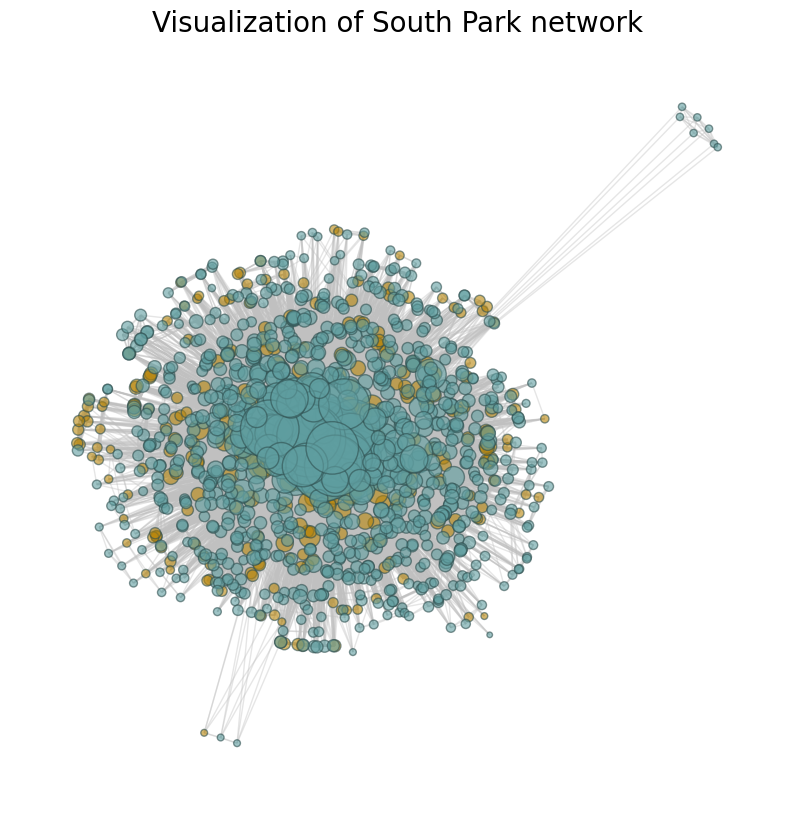

In [22]:
# plot the network
simple_network_plot(GE, GEnode_size_map, GEcolor_map_nodes, GEcolor_map_edges)

In [23]:
# check stats, nodes and edges
print("GE Network stats:")
print(f' celebrity nodes: {len(GEceleb_nodes)}')
print(f' south park nodes: {len(GEsouth_park_nodes)}')
print(f' total nodes: {GE.number_of_nodes()}')
print(f' total edges: {GE.number_of_edges()}\n')

print(f'Example-node: {list(GE.nodes(data=True))[7:8]}')
print(f'Example-edge: {list(GE.edges())[6:7]}')

GE Network stats:
 celebrity nodes: 265
 south park nodes: 876
 total nodes: 1141
 total edges: 21592

Example-node: [('steve_forbes', {'u': 'celebrity'})]
Example-edge: [('bill_gates', 'jimmy_valmer')]


In [24]:
# function that prints out the n highest and lowest number of links for the characters
def print_character_with_highest_and_lowest_number_of_links(graph, n):
    
    degree_sequence= sorted([(k,d) for (k,d) in graph.degree()], key=lambda d: d[1], reverse=True)

    print('Characters with highest number of links:')
    print(*degree_sequence[0:n], sep = "\n")
    print()      
    print('Characters with lowest number of links:')
    print(*degree_sequence[-n:], sep = "\n")

In [25]:
print_character_with_highest_and_lowest_number_of_links(GE, 10)

Characters with highest number of links:
('stan_marsh', 1112)
('eric_cartman', 1103)
('kyle_broflovski', 1096)
('butters_stotch', 827)
('kenny_mccormick', 782)
('randy_marsh', 703)
('herbert_garrison', 658)
('mr._mackey', 573)
('sharon_marsh', 527)
('gerald_broflovski', 519)

Characters with lowest number of links:
('malcolm_mcdowell', 7)
('miss_havisham', 7)
('mrs._joe_gargery', 7)
('zytar', 7)
('celine_dion', 6)
('haman', 6)
('canadian_judge', 6)
('sally_dion', 6)
('william_janus', 6)
('beatrice_mcgullicutty', 4)


In [26]:
# function for plotting nicer looking plots using the ForceAtlas algorithm 
def forceatlas2_network_plot(graph, pos, s_map, c_map_nodes, c_map_edges, filename):
    
    plt.figure(figsize=(10,10))

    nx.draw_networkx_nodes(graph, 
                           pos, 
                           node_size=s_map, 
                           node_color = c_map_nodes,
                           edgecolors = 'darkslategray',
                           linewidths = 3.0,
                           alpha=0.6
                          )
    nx.draw_networkx_edges(graph, 
                           pos,
                           edge_color='silver',
                           width = 2.0,
                           alpha=0.4)
    plt.axis('off')
    plt.savefig(f'diagrams/{filename}.png', bbox_inches='tight')
    plt.title("Visualization of South-Park-network using ForceAtlas2",fontsize=20)
    plt.show()
    


In [27]:
# set parameters 
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=10.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=10, # 1.2
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=3.0,
                        strongGravityMode=False,
                        gravity=10.0, ##1.0

                        # Log
                        verbose=True)

GEpositions = forceatlas2.forceatlas2_networkx_layout(GE, pos=None, iterations=2000)

100%|██████████████████████████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 118.29it/s]

BarnesHut Approximation  took  11.97  seconds
Repulsion forces  took  1.07  seconds
Gravitational forces  took  0.28  seconds
Attraction forces  took  0.85  seconds
AdjustSpeedAndApplyForces step  took  1.50  seconds


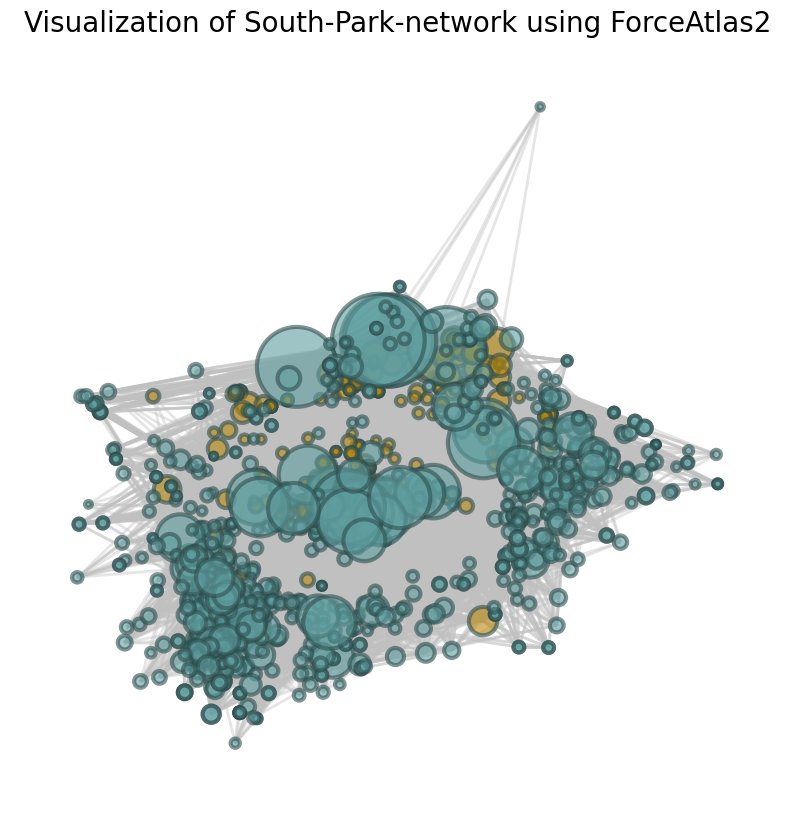

In [28]:
# plot the network using ForceAtlas
forceatlas2_network_plot(GE, GEpositions, GEnode_size_map, GEcolor_map_nodes, GEcolor_map_edges, "Fig_Atlas_Viz_GE")

In [29]:
# save edgelist for later analysis
nx.write_edgelist(GE, f"{data_dir}/South_Park.edgelist.gz")

### Scene-Based Network (GS)
Links added between characters appering within same episode-scene.

In [30]:
import glob

# list of some identified abreviations of some of the characters. 
# Since the script dialuges contains shortened character names 
# (first name, last name, other), the "real" network structure 
# might be different from what we create here, as we did not 
# go though the full script dialouge to check for abreviations.

abr = {'stan':'stan marsh', 
       'cartman':'eric cartman', 
       'kyle':'kyle broflovski', 
       'butters':'butters stotch',
       'kenny':'kenny mccormick',
       'ike': 'ike broflovski',
       'mr. garrison': 'herbert garrison', 
       'chef':'jerome "chef" mcelroy'}

# initialize a new graph
init_GS = nx.Graph()

# add characters as nodes 
init_GS.add_nodes_from(celeb_character_list, u='celebrity')
init_GS.add_nodes_from(south_park_character_list, u='fiction')

# open all_episode_list 
open_file = open(f"{data_dir}/{episode_list_filename}", "r", encoding = "ISO-8859-1")
all_episode_list  = open_file.read().split("\n")
open_file.close()

In [31]:
for episode in all_episode_list:
    
    #try:
    open_file = open(f'{script_dir}/{episode}.txt', "r", encoding="utf-8");
    script = open_file.read().split("{{ScriptScene|");
    open_file.close();

    for s in script:
        # find and clean all characters in s
        scene_character_list = re.findall(r'\|[\.\w\s\\\'\-]+\|', s)
        scene_character_list = [c.replace("|", "").lower() for c in scene_character_list]
        #print(scene_character_list)

        #for c in scene_character_list:
        #    if c in abr.keys():
        #        i = scene_character_list.index(c)
        #        scene_character_list[i] = abr[c]

        scene_character_list = [c.replace(" ", "_") for c in scene_character_list]
        #print(scene_character_list)
        #try:
        episode_cast_list = open(f"{cast_dir}/cast_{episode}.txt", "r").read().split("\n")

        cast_list = [s for s in episode_cast_list if any(xs in s for xs in scene_character_list)]
        #print(matching)
        #print()

        combi_list = [(c1,c2) for c1 in cast_list for c2 in cast_list if not(c1==c2)]
        edge_list = [(c1,c2) for (c1,c2) in combi_list if (c1 in match_list and c2 in match_list)]
        init_GS.add_edges_from(list(edge_list))
        #except:
        #    print(s)
        #    print("\n")
    #except:
    #    print(episode)

In [32]:
# discard truly minor characters (nodes with no degrees)
GSlcc = max(nx.connected_components(init_GS), key=len)
GS = init_GS.subgraph(GSlcc).copy()

# check stats, nodes and links #
GSceleb_nodes, GSsouth_park_nodes = get_node_groups(GS, 'celebrity', 'fiction')

print("\nCheck network stats:")
print(f' celebrity nodes: {len(GSceleb_nodes)}')
print(f' south park nodes: {len(GSsouth_park_nodes)}')
print(f' total nodes: {GS.number_of_nodes()}')
print(f' total edges: {GS.number_of_edges()}\n')

print(f'Example-node: {list(GS.nodes(data=True))[7:8]}')
print(f'Example-edge: {list(GS.edges())[6:7]}')


Check network stats:
 celebrity nodes: 219
 south park nodes: 691
 total nodes: 910
 total edges: 5381

Example-node: [('jack_tenorman', {'u': 'fiction'})]
Example-edge: [('annie_knitts', 'eric_cartman')]


In [33]:
# generate maps for visualization of network
GSnode_size_map, GScolor_map_nodes, GScolor_map_edges = generate_size_and_color_maps(GS, GSceleb_nodes, GSsouth_park_nodes)

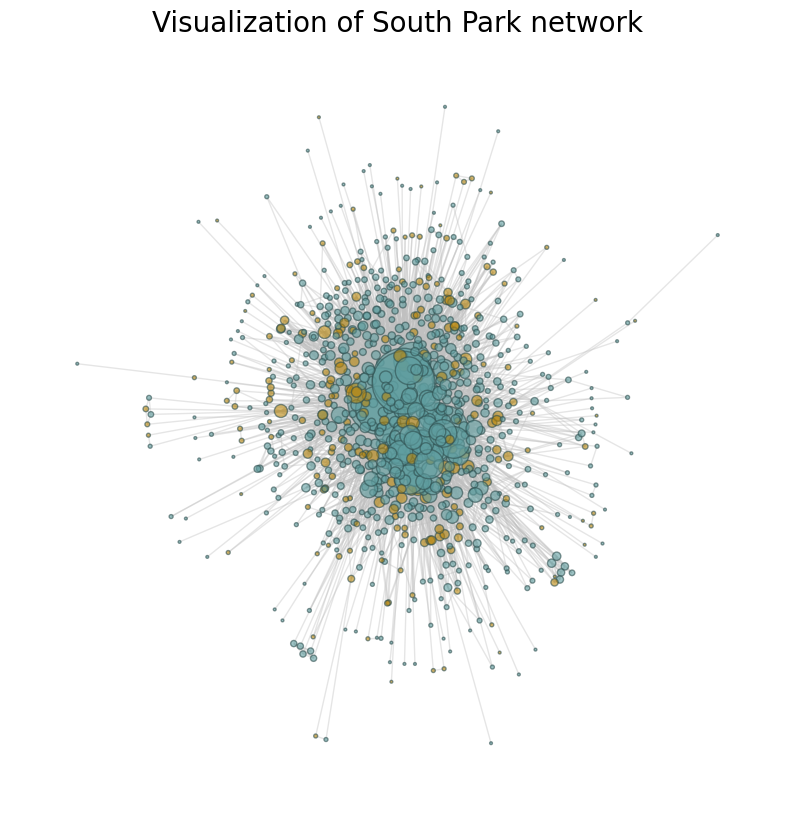

In [34]:
# make simple plot of GS network
simple_network_plot(GS, GSnode_size_map, GScolor_map_nodes, GScolor_map_edges)

In [35]:
print_character_with_highest_and_lowest_number_of_links(GS, 10)

Characters with highest number of links:
('eric_cartman', 583)
('stan_marsh', 510)
('kyle_broflovski', 483)
('liane_cartman', 264)
('randy_marsh', 253)
('butters_stotch', 244)
('kenny_mccormick', 178)
('mr._mackey', 130)
('gerald_broflovski', 130)
('sharon_marsh', 111)

Characters with lowest number of links:
('photographer', 1)
('canadian_bishop', 1)
('selena_gomez', 1)
('james_cameron', 1)
('general_davis', 1)
('south_park_express_conductor', 1)
('park_county_courthouse_judge', 1)
('paul_shaffer', 1)
('pope_francis', 1)
('dr._land', 1)


In [36]:
# set parameters
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=10.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=15, # 1.2
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=3.0,
                        strongGravityMode=False,
                        gravity=3.0, ##1.0

                        # Log
                        verbose=True)

GSpositions = forceatlas2.forceatlas2_networkx_layout(GS, pos=None, iterations=2000)

100%|██████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 153.11it/s]

BarnesHut Approximation  took  8.63  seconds
Repulsion forces  took  1.52  seconds
Gravitational forces  took  0.27  seconds
Attraction forces  took  0.29  seconds
AdjustSpeedAndApplyForces step  took  1.24  seconds


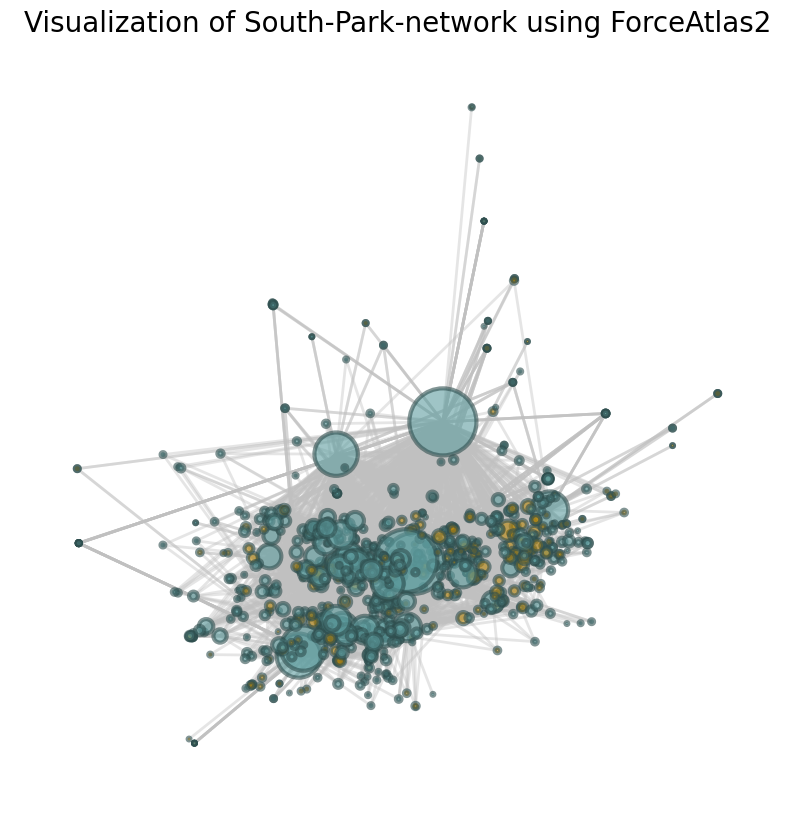

In [37]:
forceatlas2_network_plot(GS, GSpositions, GSnode_size_map, GScolor_map_nodes, GScolor_map_edges, "Fig_Atlas_Viz_GS")

In [38]:
# save edgelist for later analysis
nx.write_edgelist(GS, f"{data_dir}/South_Park_scenelinks.edgelist.gz")

---
## Part 3: Network Analysis
This part includes a selection of analysis components mainly from week 4 and week 5 of the course. The same analysis have been ran on both GE and GS.  

### Analysis using the Episode-Based Network (GE)

In [39]:
# -- Restore the South-Park network from current directory --

# set path and output file names
data_dir = 'data'
dialog_dir = f'{data_dir}/character_dialog_test'

celeb_characters_filename = "Celebrity_characters.txt"
south_park_characters_filename = "South-Park_characters.txt"

# open the text file with all, celeb and south park characters
celeb_character_list = open(f"{data_dir}/{celeb_characters_filename}", "r").read().split("\n")
south_park_character_list = open(f"{data_dir}/{south_park_characters_filename}", "r").read().split("\n")

print("Character Stats:")
print(f" number of celeb characters: {len(celeb_character_list)}")
print(f" number of south-park characters: {len(south_park_character_list)}")
print(f" total: {len(celeb_character_list)+len(south_park_character_list)}\n")

# initialize a directed graph
init_GE = nx.Graph()

# function that adds the nodes corresponding to each character in South-Park, 
# its universe and the length of its total episode dialog
def add_characters_as_nodes(graph, character_list, universe):
    
    for c in character_list:
    
        # (node, node_attribute: universe='fiction'|'celebrity', node_attribute: episodes-word-count):
        graph.add_node(c, u=universe)

# add all the characters from 'marvel_dir' and 'dc_dir' as nodes
add_characters_as_nodes(init_GE, celeb_character_list, "celebrity")
add_characters_as_nodes(init_GE, south_park_character_list, "fiction")

# load the stored edges from base_dir
init_GE.add_edges_from(nx.read_edgelist(f"{data_dir}/South_Park.edgelist.gz", create_using=nx.Graph).edges())

# discard truly minor characters (nodes with no in-out-degrees)
GElcc = max(nx.connected_components(init_GE), key=len)
GE = init_GE.subgraph(GElcc).copy()


Character Stats:
 number of celeb characters: 429
 number of south-park characters: 1537
 total: 1966



In [40]:
# function that seperates nodes based on their universe
def get_node_groups(graph, u1, u2):
    group1 = [n for n,a in graph.nodes(data=True) if a['u'] == u1]
    group2 = [n for n,a in graph.nodes(data=True) if a['u'] == u2]
    
    return group1, group2
# -- check stats -- #

GEceleb_nodes, GEsouth_park_nodes = get_node_groups(GE, "celebrity", "fiction")

print("Check network stats:")
print(f' celebrity nodes: {len(GEceleb_nodes)}')
print(f' south park nodes: {len(GEsouth_park_nodes)}')
print(f' total nodes: {GE.number_of_nodes()}')
print(f' total edges: {GE.number_of_edges()}\n')

print(f'Example-node: {list(GE.nodes(data=True))[7:8]}')
print(f'Example-edge: {list(GE.edges())[6:7]}')

# Network stats from original South Park network:
# - celebrity nodes: 267
# - south park nodes: 872
# - total nodes: 1139
# - total edges: 21595

Check network stats:
 celebrity nodes: 265
 south park nodes: 876
 total nodes: 1141
 total edges: 21592

Example-node: [('steve_forbes', {'u': 'celebrity'})]
Example-edge: [('bill_gates', 'jimmy_valmer')]


In [41]:
# number of links connecting celebrity and fictional characters
def print_link_connections(G):
    connections_between_celeb_celeb = [(u,v) for (u,v) in G.edges() if (G.nodes[u]["u"]=='celebrity' and G.nodes[v]["u"]=='celebrity')]
    connections_between_fiction_fiction = [(u,v) for (u,v) in G.edges() if (G.nodes[u]["u"]=='fiction' and G.nodes[v]["u"]=='fiction')]
    connections_between_celeb_fiction = [(u,v) for (u,v) in G.edges() if (G.nodes[u]["u"]=='celebrity' and G.nodes[v]["u"]=="fiction") or  (G.nodes[u]["u"]=="fiction" and G.nodes[v]["u"]=='celebrity')]

    print(f'Number of celebrity-celebrity connections: {len(connections_between_celeb_celeb)}')
    print(f'Number of fiction-fiction connections: {len(connections_between_fiction_fiction)}')
    print(f'Number of celebrity-fiction connections: {len(connections_between_celeb_fiction)}')


In [42]:
print_link_connections(GE)

Number of celebrity-celebrity connections: 722
Number of fiction-fiction connections: 15553
Number of celebrity-fiction connections: 5317


In [43]:
# function that prints the average, median, mode, minimum and maximum value of the degrees 
def print_degree_statistics(degrees,netwok):
    
    print(f"{netwok}-network statistics:\n")

    print(f'  mean:    {np.mean(degrees)}')
    print(f'  median:  {np.median(degrees)}')
    print(f'  mode:    {st.mode(degrees)}')
    print(f'  minimum: {np.min(degrees)}')
    print(f'  maximum: {np.max(degrees)}\n')

In [44]:
GE_degrees = [GE.degree(n) for n in GE.nodes()]

In [45]:
GE_celeb_degrees = [GE.degree(n) for n,a in GE.nodes(data=True) if a['u']=='celebrity'] 
GE_fiction_degrees = [GE.degree(n) for n,a in GE.nodes(data=True) if a['u']=='fiction'] 

In [46]:
print_degree_statistics(GE_degrees,"GE")

GE-network statistics:

  mean:    37.84750219106047
  median:  20.0
  mode:    15
  minimum: 4
  maximum: 1112



In [47]:
print_degree_statistics(GE_celeb_degrees,"GE-celeb")

GE-celeb-network statistics:

  mean:    25.513207547169813
  median:  20.0
  mode:    22
  minimum: 6
  maximum: 170



In [48]:
print_degree_statistics(GE_fiction_degrees,"GE-fiction")

GE-fiction-network statistics:

  mean:    41.57876712328767
  median:  19.0
  mode:    15
  minimum: 4
  maximum: 1112



In [49]:
# checks the minimum number of characters in each cast list 
minimum_number_of_characters = 1000 # set to high number
for filename in os.listdir(cast_dir):
    cast_list = open(f'{cast_dir}/{filename}', 'r').read().split('\n')
    if len(cast_list) < minimum_number_of_characters and len(cast_list) > 1:
        minimum_number_of_characters = len(cast_list)
        print(filename)
print(f'minumum number of characters in cast_lists: {minimum_number_of_characters}')

cast_1%.txt
cast_All_About_Mormons.txt
cast_Asspen.txt
cast_AWESOM-O.txt
cast_A_Million_Little_Fibers.txt
minumum number of characters in cast_lists: 5


The cast list of *A Million Little Fibers* contains more han 4 characters, but only 4 of the characters are in the full character list.  

In [50]:
# function that prints the n characters with the highest of a given degree-list d 
def print_highest_degree(d, n):
    sorted_d = sorted(d, key=lambda x: x[1], reverse=True)
    
    print(f'The {n} characters with highest centrality are:')
    for i in range(n):
        print(f' {i+1}: {sorted_d[i]},')  

In [51]:
GE_fiction_c_degrees = [(n,GE.degree(n)) for n,a in GE.nodes(data=True) if a['u']=='fiction'] 

print_highest_degree(GE_fiction_c_degrees, 10)

The 10 characters with highest centrality are:
 1: ('stan_marsh', 1112),
 2: ('eric_cartman', 1103),
 3: ('kyle_broflovski', 1096),
 4: ('butters_stotch', 827),
 5: ('kenny_mccormick', 782),
 6: ('randy_marsh', 703),
 7: ('herbert_garrison', 658),
 8: ('mr._mackey', 573),
 9: ('sharon_marsh', 527),
 10: ('gerald_broflovski', 519),


In [52]:
GE_celeb_c_degrees = [(n,GE.degree(n)) for n,a in GE.nodes(data=True) if a['u']=='celebrity'] 

print_highest_degree(GE_celeb_c_degrees, 10)

The 10 characters with highest centrality are:
 1: ('jesus_christ', 170),
 2: ('tom_pusslicker', 104),
 3: ('bill_keegan', 100),
 4: ('tom_thompson', 92),
 5: ('hillary_clinton', 84),
 6: ('mickey_mouse', 73),
 7: ('joseph_smith', 72),
 8: ('paris_hilton', 72),
 9: ('satan', 71),
 10: ('bill_clinton', 64),


In [53]:
print(f'minimum degree: {min(GE_degrees)}')
print(f'maximum degree: {max(GE_degrees)}')

def plot_degree_distribution(G_degrees, G_name, filename):
    # bin the degrees
    hist, bins = np.histogram(G_degrees, range(min(G_degrees), max(G_degrees)+1))

    #  plot the degree destributions 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9,5))

    ax1.plot(hist,color= 'cadetblue', linestyle='None', marker='o', label=f"{G_name} degree")
    ax1.set_ylabel('count')
    ax1.set_xlabel('k')
    ax1.legend()

    ax2.loglog(hist, color='cadetblue',linestyle='None', marker='o', label=f"{G_name} degree")
    ax2.set_ylabel('log(count)')
    ax2.set_xlabel('log(k)')
    ax2.legend()

    plt.savefig(f'diagrams/{filename}', bbox_inches='tight')
    
    ax1.set_title('Degree distribution, lineary scale');
    ax2.set_title('Degree distribution - loglog scale');

    fig.tight_layout()
    plt.show()

minimum degree: 4
maximum degree: 1112


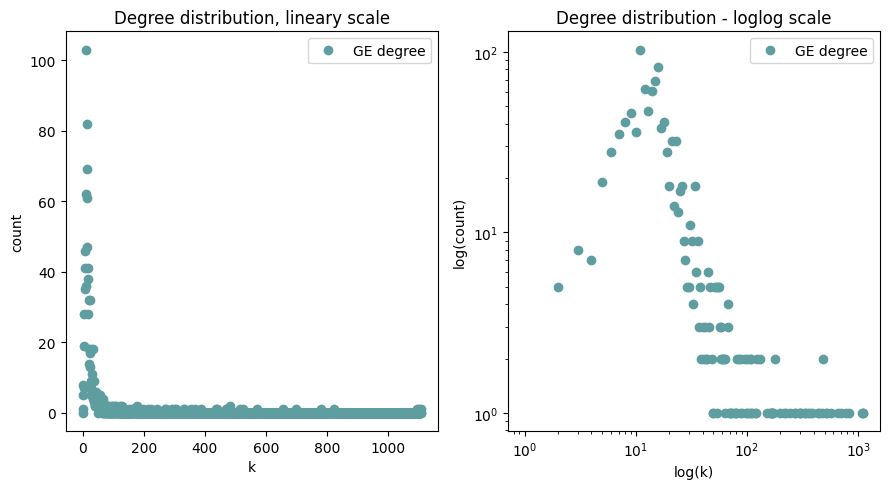

In [54]:
plot_degree_distribution(GE_degrees, "GE", "DD_1.pdf")

In [55]:
# the degree distribution compared the degree distribution 
# of a random network with the same number of nodes and links
N=len(GE.nodes())
avg_k = np.mean(GE_degrees)
p = avg_k/(N-1)

print(f'<k> = {avg_k}')
print(f'p =   {p}')

# generate random graph
ER = nx.erdos_renyi_graph(N,p)

print(f"\nTest:")
print(f" is ER nodes == DG nodes? => {len(ER.nodes())} = {len(GE.nodes())}")
print(f" is ER edges == DG edges? => {len(ER.edges())} = {len(GE.edges())}")

#  extract all the degrees of ER
ER_degrees = [ER.degree(n) for n in ER.nodes()]


<k> = 37.84750219106047
p =   0.03319956332549164

Test:
 is ER nodes == DG nodes? => 1141 = 1141
 is ER edges == DG edges? => 21552 = 21592


In [56]:
def plot_compared_degree_distribution(degrees1, degrees2, name1, name2, filename):
    
    #  bin the degrees of the two network degrees for comparison
    hist1, bin1 = np.histogram(degrees1, range(min(degrees1), max(degrees1)+1))
    hist2, bin2 = np.histogram(degrees2, range(min(degrees2), max(degrees2)+1))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

    ax1.plot(hist2, color= 'gray', linestyle='dashed', alpha=0.5, label=f"{name2} degrees")
    ax1.plot(hist1, color= 'cadetblue', linestyle='None', marker='o', label=f"{name1} degrees")
    ax1.set_ylabel('count')
    ax1.set_xlabel('k')
    ax1.legend()

    ax2.loglog(hist2,color= 'gray', linestyle='dashed', alpha=0.5, label=f"{name2} degrees")
    ax2.loglog(hist1,color= 'cadetblue', linestyle='None', marker='o', label=f"{name1} degrees")
    ax2.set_ylabel('log(count)')
    ax2.set_xlabel('log(k)')
    ax2.legend()

    plt.savefig(f'diagrams/{filename}', bbox_inches='tight')

    ax1.set_title('Degree distribution - lineary-binned');
    ax2.set_title('Degree distribution, log-binned');

    fig.tight_layout()
    plt.show()

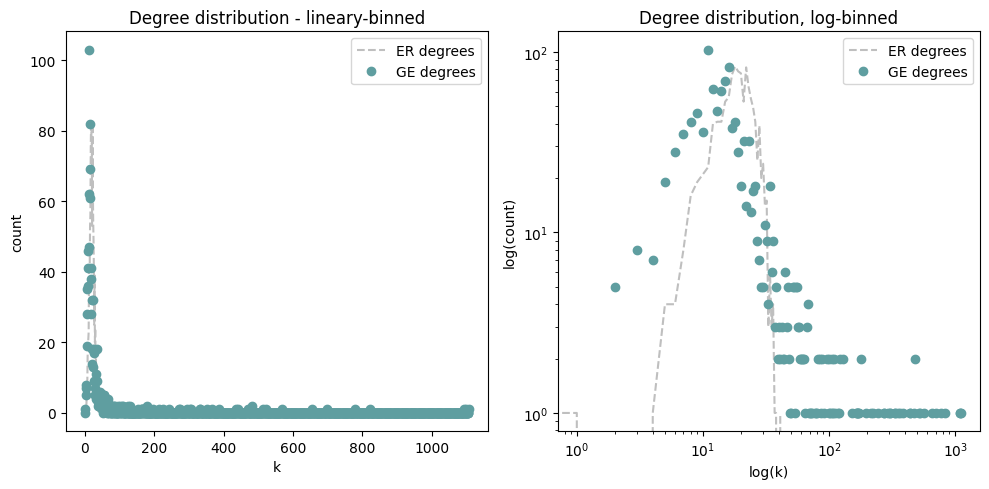

In [57]:
plot_compared_degree_distribution(GE_degrees, ER_degrees, "GE", "ER", "com_dd1.png")

Test:
 is BA nodes == G nodes? => 1141 = 1141
 is BA edges == G edges? => 21318 = 21592


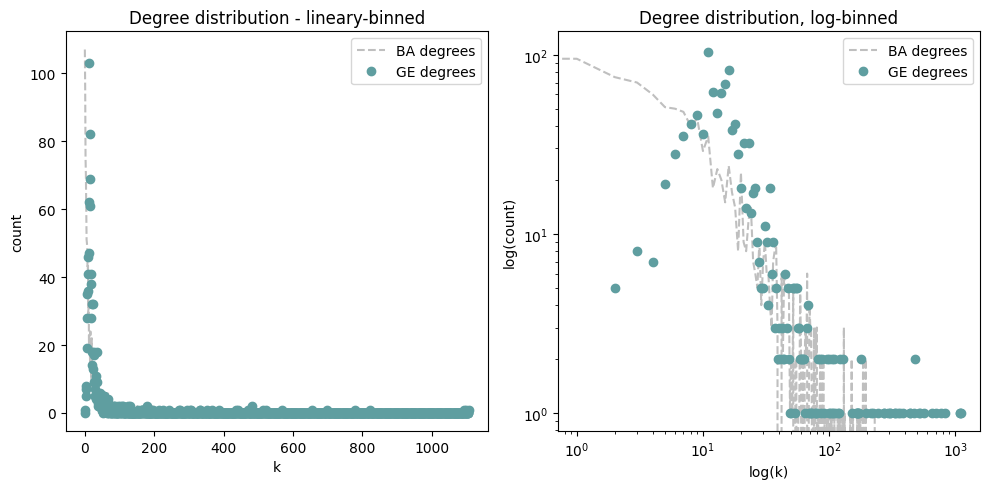

In [58]:
# GE degree distribution compared to the degree distribution of 
# a scale-free network with the same number of nodes

N=len(GE.nodes())
M=19 # if it is set to 19 that is ~= <k>, they seem almost equal 

# generate random graph
BA = nx.barabasi_albert_graph(N, M)

print(f"Test:")
print(f" is BA nodes == G nodes? => {len(BA.nodes())} = {len(GE.nodes())}")
print(f" is BA edges == G edges? => {len(BA.edges())} = {len(GE.edges())}")

# extract the degrees of BA
BA_degrees = [BA.degree(n) for n in BA.nodes()]

# plot the comparison
plot_compared_degree_distribution(GE_degrees, BA_degrees, "GE", "BA", "com_dd2.png")

In [59]:
import powerlaw

def print_powerlaw(d):
    # get the slope of the fit
    fit = powerlaw.Fit(d, verbose=False)
    alpha = fit.alpha
    xmin = fit.xmin
    xmax = fit.xmax
    print(f'Estimated slope, alpha = {alpha}')
    print(f'Starting value, xmin = {xmin}')
    print(f'Endting value, xmax = {xmax}')

In [60]:
print_powerlaw(GE_degrees)

Estimated slope, alpha = 2.6632247390542485
Starting value, xmin = 15.0
Endting value, xmax = None


In [61]:
def plot_all_compared_degree_distribution(degrees1, degrees2, degrees3, name1, name2, name3, filename):
    
    #  bin the degrees of the two network degrees for comparison
    hist1, bin1 = np.histogram(degrees1, range(min(degrees1), max(degrees1)+1))
    hist2, bin2 = np.histogram(degrees2, range(min(degrees2), max(degrees2)+1))
    hist3, bin3 = np.histogram(degrees3, range(min(degrees3), max(degrees3)+1))

    
    fig, ax = plt.subplots(1, 1, figsize = (7,7))

    ax.loglog(hist3,color= 'gray', linestyle=':', alpha=0.4, label=f"{name3}",linewidth=3.0)
    ax.loglog(hist2,color= 'black', linestyle='dashed', alpha=0.4, label=f"{name2}",linewidth=3.0)
    ax.loglog(hist1,color= 'cadetblue', linestyle='None', marker='o', label=f"{name1}")
    ax.set_ylabel('log(count)', fontsize=16)
    ax.set_xlabel('log(k)', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.legend(loc='lower right', bbox_to_anchor=(0.53, -0.2), fontsize=13, ncol= 3, frameon=False)
    #ax.legend(bbox_to_anchor=(1, 0), fontsize=16, ncol= 1, frameon=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    plt.savefig(f'diagrams/{filename}', bbox_inches='tight')

    ax.set_title('Degree distribution, log-binned', fontsize=18);

    fig.tight_layout()
    plt.show()

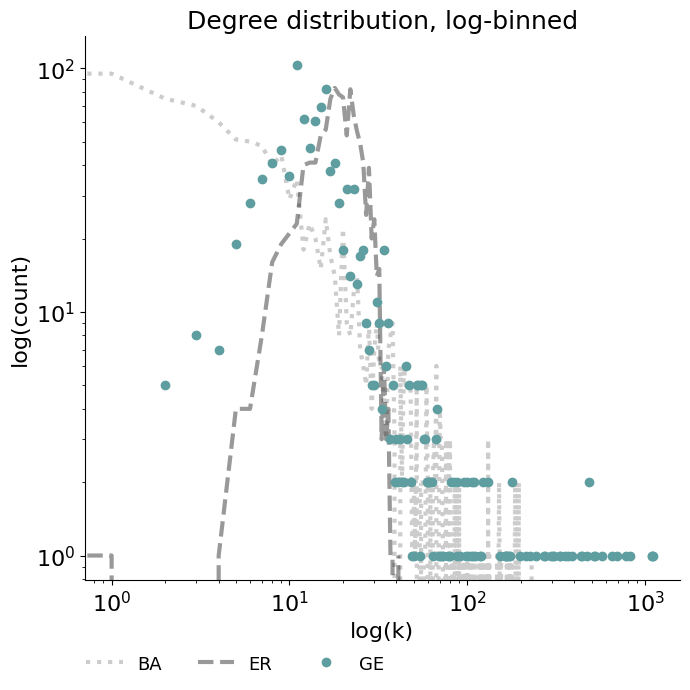

In [62]:
# final plot for report containing all three comparied distributions on a loglog scale
plot_all_compared_degree_distribution(GE_degrees, ER_degrees, BA_degrees, "GE", "ER", "BA", "com_dd3.png")

In [63]:
# function that print the n highest degree centralities for a given graph G 
def print_degree_centrality(G, n):
    
    degree_centrality_dict = nx.degree_centrality(G)
    degree_centrality_list = sorted(degree_centrality_dict.items(), key=lambda x: x[1], reverse=True)
    degree_centrality_characters = [c for (c,dc) in degree_centrality_list] 
    degree_centrality_values = [dc for (c,dc) in degree_centrality_list] 

    print(f'The {n} most central characters according to degree centrality are:')
    for i in range(n):
        print(f' {i+1}: {round(degree_centrality_values[i],2)}, {degree_centrality_characters[i]}')  

In [64]:
print_degree_centrality(GE, 10)

The 10 most central characters according to degree centrality are:
 1: 0.98, stan_marsh
 2: 0.97, eric_cartman
 3: 0.96, kyle_broflovski
 4: 0.73, butters_stotch
 5: 0.69, kenny_mccormick
 6: 0.62, randy_marsh
 7: 0.58, herbert_garrison
 8: 0.5, mr._mackey
 9: 0.46, sharon_marsh
 10: 0.46, gerald_broflovski


In [65]:
def print_betweenness_centrality(G, n):

    betweenness_centrality_dict = nx.betweenness_centrality(G)
    betweenness_centrality_list = sorted(betweenness_centrality_dict.items(), key=lambda x: x[1], reverse=True)
    betweenness_centrality_characters = [c for (c,bc) in betweenness_centrality_list] 
    betweenness_centrality_values = [bc for (ch,bc) in betweenness_centrality_list] 

    print(f'The {n} most central characters according to betweenness centrality are:')
    for i in range(n):
        print(f' {i+1}: {round(betweenness_centrality_values[i],2)}, {betweenness_centrality_characters[i]}')  

In [66]:
print_betweenness_centrality(GE, 10)

The 10 most central characters according to betweenness centrality are:
 1: 0.16, stan_marsh
 2: 0.15, eric_cartman
 3: 0.15, kyle_broflovski
 4: 0.07, butters_stotch
 5: 0.06, kenny_mccormick
 6: 0.05, randy_marsh
 7: 0.04, herbert_garrison
 8: 0.03, mr._mackey
 9: 0.02, sharon_marsh
 10: 0.02, gerald_broflovski


In [67]:
def print_eigenvector_centrality(G, n):
    
    eigenvector_centrality_dict = nx.eigenvector_centrality(G)
    eigenvector_centrality_list = sorted(eigenvector_centrality_dict.items(), key=lambda x: x[1], reverse=True)
    eigenvector_centrality_characters = [c for (c,ec) in eigenvector_centrality_list] 
    eigenvector_centrality_values = [ec for (c,ec) in eigenvector_centrality_list] 

    print(f'The {n} most central characters according to eigenvector centrality are:')
    for i in range(n):
        print(f' {i+1}: {round(eigenvector_centrality_values[i],2)}, {eigenvector_centrality_characters[i]}')   

In [68]:
print_eigenvector_centrality(GE, 10)

The 10 most central characters according to eigenvector centrality are:
 1: 0.21, stan_marsh
 2: 0.21, eric_cartman
 3: 0.21, kyle_broflovski
 4: 0.17, butters_stotch
 5: 0.17, kenny_mccormick
 6: 0.16, randy_marsh
 7: 0.15, herbert_garrison
 8: 0.14, mr._mackey
 9: 0.14, gerald_broflovski
 10: 0.13, sharon_marsh


### Analysis using the Scene-Based Network (GS)

In [69]:
import networkx as nx
import os

# -- Restore the South-Park network from current directory --

print("Character Stats:")
print(f" number of celeb characters: {len(celeb_character_list)}")
print(f" number of south-park characters: {len(south_park_character_list)}")
print(f" total: {len(celeb_character_list)+len(south_park_character_list)}\n")

# initialize a directed graph
init_GS = nx.Graph()

# add all the characters from 'celebrity' and 'fiction' as nodes
add_characters_as_nodes(init_GS, celeb_character_list, "celebrity")
add_characters_as_nodes(init_GS, south_park_character_list, "fiction")

# load the stored edges from base_dir
init_GS.add_edges_from(nx.read_edgelist(f"{data_dir}/South_Park_scenelinks.edgelist.gz", create_using=nx.Graph).edges())

# discard truly minor characters (nodes with no in-out-degrees)
lcc = max(nx.connected_components(init_GS), key=len)
GS = init_GS.subgraph(lcc).copy()

# -- check stats -- #
GSceleb_nodes = [n for n,a in GS.nodes(data=True) if a['u'] == 'celebrity']
GSsouth_park_nodes = [n for n,a in GS.nodes(data=True) if a['u'] == 'fiction']

print("Check network stats:")
print(f' celebrity nodes: {len(GSceleb_nodes)}')
print(f' south park nodes: {len(GSsouth_park_nodes)}')
print(f' total nodes: {GS.number_of_nodes()}')
print(f' total edges: {GS.number_of_edges()}\n')

print(f'Example-node: {list(GS.nodes(data=True))[7:8]}')
print(f'Example-edge: {list(GS.edges())[6:7]}')

# Network stats from original South Park network:
#  - celebrity nodes: 276
#  - south park nodes: 871
#  - total nodes: 1147
#  - total edges: 21446 

Character Stats:
 number of celeb characters: 429
 number of south-park characters: 1537
 total: 1966

Check network stats:
 celebrity nodes: 219
 south park nodes: 691
 total nodes: 910
 total edges: 5381

Example-node: [('jack_tenorman', {'u': 'fiction'})]
Example-edge: [('annie_knitts', 'kenny_mccormick')]


In [70]:
# number of links connecting celebrity and fictional characters
GSconnections_between_celeb_celeb = [(u,v) for (u,v) in GS.edges() if (GS.nodes[u]["u"]=='celebrity' and GS.nodes[v]["u"]=='celebrity')]
GSconnections_between_fiction_fiction = [(u,v) for (u,v) in GS.edges() if (GS.nodes[u]["u"]=='fiction' and GS.nodes[v]["u"]=='fiction')]
GSconnections_between_celeb_fiction = [(u,v) for (u,v) in GS.edges() if (GS.nodes[u]["u"]=='celebrity' and GS.nodes[v]["u"]=="fiction") or  (GS.nodes[u]["u"]=="fiction" and GS.nodes[v]["u"]=='celebrity')]

print(f'Number of celebrity-celebrity connections: {len(GSconnections_between_celeb_celeb)}')
print(f'Number of fiction-fiction connections: {len(GSconnections_between_fiction_fiction)}')
print(f'Number of celebrity-fiction connections: {len(GSconnections_between_celeb_fiction)}')

Number of celebrity-celebrity connections: 220
Number of fiction-fiction connections: 4066
Number of celebrity-fiction connections: 1095


In [71]:
GS_degrees = [GS.degree(n) for n in GS.nodes()]

In [72]:
GS_celeb_degrees = [GS.degree(n) for n,a in GS.nodes(data=True) if a['u']=='celebrity'] 
GS_fiction_degrees = [GS.degree(n) for n,a in GS.nodes(data=True) if a['u']=='fiction'] 

In [73]:
print_degree_statistics(GS_degrees,"GS")

GS-network statistics:

  mean:    11.826373626373627
  median:  6.0
  mode:    3
  minimum: 1
  maximum: 583



In [74]:
print_degree_statistics(GS_celeb_degrees,"GS-celeb")

GS-celeb-network statistics:

  mean:    7.0091324200913245
  median:  5.0
  mode:    3
  minimum: 1
  maximum: 52



In [75]:
print_degree_statistics(GS_fiction_degrees,"GS-fiction")

GS-fiction-network statistics:

  mean:    13.353111432706223
  median:  6.0
  mode:    3
  minimum: 1
  maximum: 583



In [76]:
GS_fiction_c_degrees = [(n,GS.degree(n)) for n,a in GS.nodes(data=True) if a['u']=='fiction'] 

print_highest_degree(GS_fiction_c_degrees, 10)

The 10 characters with highest centrality are:
 1: ('eric_cartman', 583),
 2: ('stan_marsh', 510),
 3: ('kyle_broflovski', 483),
 4: ('liane_cartman', 264),
 5: ('randy_marsh', 253),
 6: ('butters_stotch', 244),
 7: ('kenny_mccormick', 178),
 8: ('mr._mackey', 130),
 9: ('gerald_broflovski', 130),
 10: ('sharon_marsh', 111),


In [77]:
GS_celeb_c_degrees = [(n,GS.degree(n)) for n,a in GS.nodes(data=True) if a['u']=='celebrity'] 

print_highest_degree(GS_celeb_c_degrees, 10)

The 10 characters with highest centrality are:
 1: ('jesus_christ', 52),
 2: ('hillary_clinton', 23),
 3: ('satan', 22),
 4: ('paris_hilton', 22),
 5: ('joseph_smith', 21),
 6: ('jared_fogle', 20),
 7: ('tom_pusslicker', 19),
 8: ('michael_jackson', 19),
 9: ('rob_reiner', 19),
 10: ('bill_clinton', 19),


minimum degree: 1
maximum degree: 583


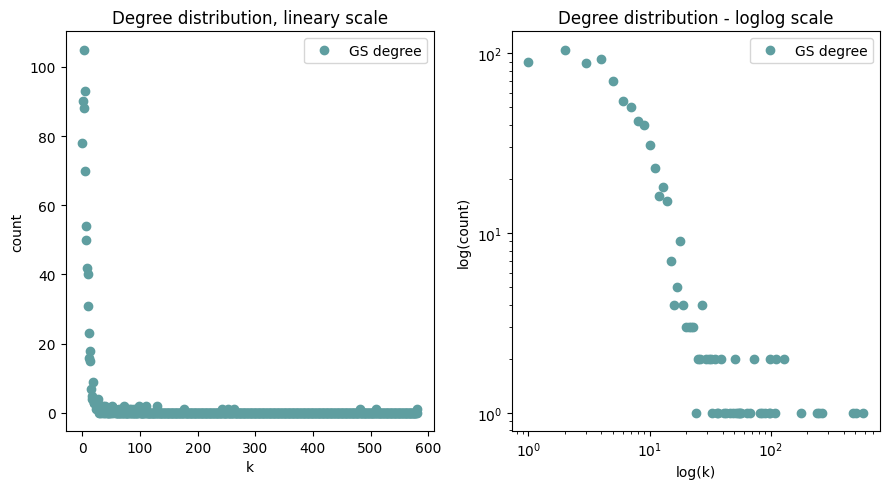

In [78]:
# print min and max number of degrees
print(f'minimum degree: {min(GS_degrees)}')
print(f'maximum degree: {max(GS_degrees)}')

# plot the GS degree distribution
plot_degree_distribution(GS_degrees, "GS", "DD_1_2.pdf")

<k> = 11.826373626373627
p =   0.013010312020213011

Test:
 is ER nodes == DG nodes? => 910 = 910
 is ER edges == DG edges? => 5428 = 5381


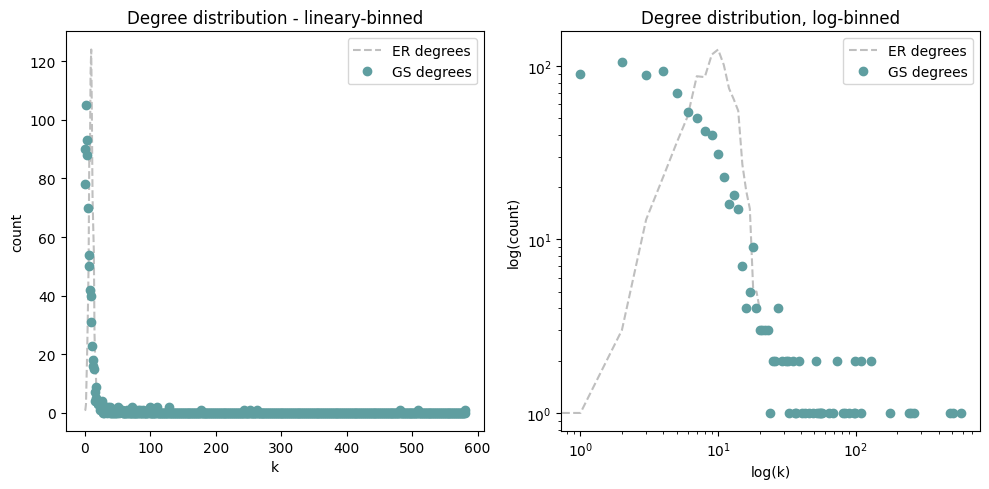

In [79]:
# the GS degree distribution compared the the degree distribution 
# of a random network with the same number of nodes and links

N=len(GS.nodes())
avg_k = np.mean(GS_degrees)
p = avg_k/(N-1)

print(f'<k> = {avg_k}')
print(f'p =   {p}')

# generate random graph
ER2 = nx.erdos_renyi_graph(N,p)

print(f"\nTest:")
print(f" is ER nodes == DG nodes? => {len(ER2.nodes())} = {len(GS.nodes())}")
print(f" is ER edges == DG edges? => {len(ER2.edges())} = {len(GS.edges())}")

#  extract all the degrees of ER
ER2_degrees = [ER2.degree(n) for n in ER2.nodes()]

# plot the comparison
plot_compared_degree_distribution(GS_degrees, ER2_degrees, "GS", "ER", "com_dd1_2.png")

Test:
 is BA nodes == G nodes? => 910 = 910
 is BA edges == G edges? => 6321 = 5381


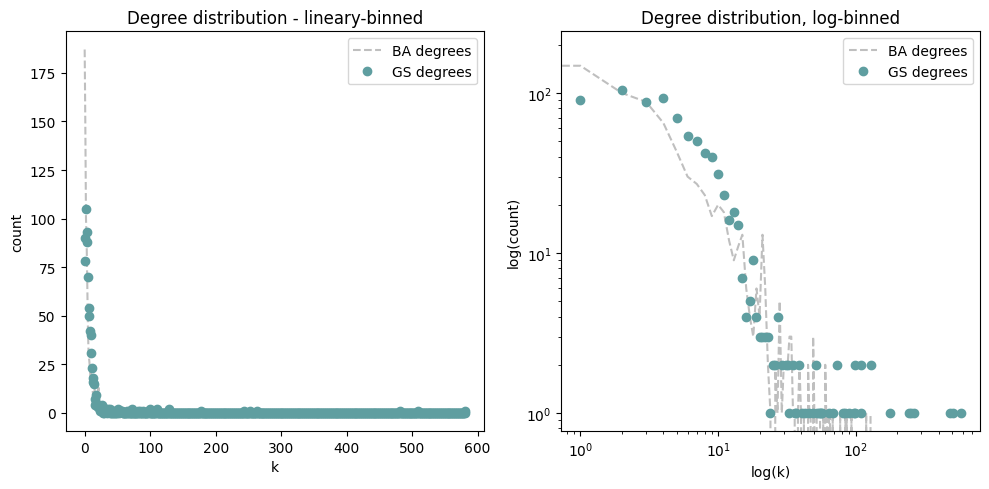

In [80]:
# the GS degree distribution compared to the degree distribution of 
# a scale-free network with the same number of nodes
N=len(GS.nodes())
M=7 # if it is set to 7 that is ~= <k>, they seem almost equal 

# generate random graph
BA2 = nx.barabasi_albert_graph(N, M)

print(f"Test:")
print(f" is BA nodes == G nodes? => {len(BA2.nodes())} = {len(GS.nodes())}")
print(f" is BA edges == G edges? => {len(BA2.edges())} = {len(GS.edges())}")

# extract degrees of BA2
BA2_degrees = [BA2.degree(n) for n in BA2.nodes()]

# plot comparison 
plot_compared_degree_distribution(GS_degrees, BA2_degrees, "GS", "BA", "com_dd2_2.png")

In [81]:
print_powerlaw(GS_degrees)

Estimated slope, alpha = 2.567259068494285
Starting value, xmin = 8.0
Endting value, xmax = None


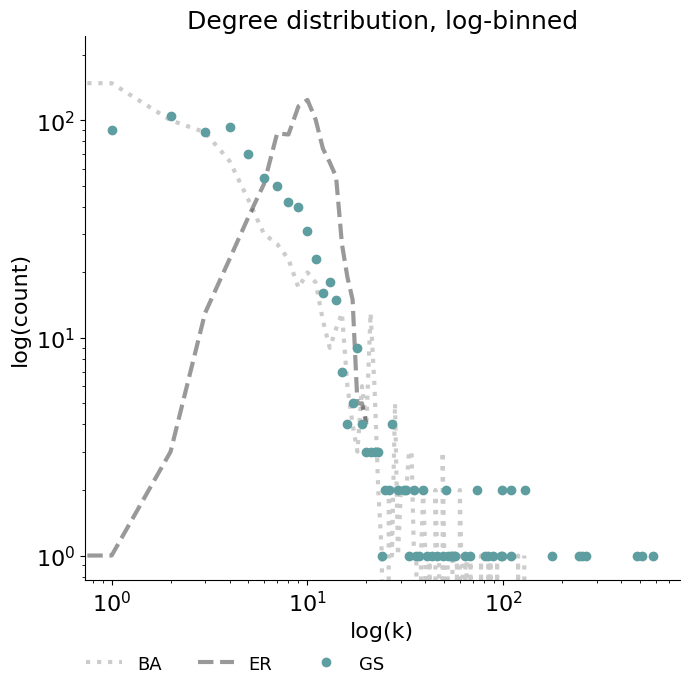

In [82]:
# final plot for report containing all three comparied distributions on a loglog scale
plot_all_compared_degree_distribution(GS_degrees, ER2_degrees, BA2_degrees, "GS", "ER", "BA", "com_dd4.png")

In [83]:
print_degree_centrality(GS, 10)

The 10 most central characters according to degree centrality are:
 1: 0.64, eric_cartman
 2: 0.56, stan_marsh
 3: 0.53, kyle_broflovski
 4: 0.29, liane_cartman
 5: 0.28, randy_marsh
 6: 0.27, butters_stotch
 7: 0.2, kenny_mccormick
 8: 0.14, mr._mackey
 9: 0.14, gerald_broflovski
 10: 0.12, sharon_marsh


In [84]:
print_betweenness_centrality(GS, 10)

The 10 most central characters according to betweenness centrality are:
 1: 0.31, eric_cartman
 2: 0.21, stan_marsh
 3: 0.18, kyle_broflovski
 4: 0.08, randy_marsh
 5: 0.06, butters_stotch
 6: 0.06, liane_cartman
 7: 0.04, kenny_mccormick
 8: 0.02, gerald_broflovski
 9: 0.02, mr._mackey
 10: 0.02, jimmy_valmer


In [85]:
print_eigenvector_centrality(GS, 10)

The 10 most central characters according to eigenvector centrality are:
 1: 0.31, eric_cartman
 2: 0.29, stan_marsh
 3: 0.28, kyle_broflovski
 4: 0.18, liane_cartman
 5: 0.18, randy_marsh
 6: 0.18, butters_stotch
 7: 0.15, kenny_mccormick
 8: 0.13, mr._mackey
 9: 0.13, gerald_broflovski
 10: 0.12, sharon_marsh


---
## Part 4: Community Analysis
The following ise seperated into the GE community analysis and GS community analysis. Fo each of these networks we will use the Louvain and the Infomap algorithm to detect communities 
### Define functions for later use 

In [86]:
from community import community_louvain as cl
from wordcloud import WordCloud

from infomap import Infomap
import time
timestr = time.strftime("%Y%m%d%H%M")

import nltk 
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

plot_networks = False
plot_wordclouds = True
ids_source = "max"

fs_ticks = 20
fs_label = 24   
lw = 4

dialog_dir = f'{data_dir}/character_dialogs'


In [87]:

def create_size_map(G):# create a size map such that the node-size depend on degree
    d = dict(G.degree)
    
    size_map_nodes_G =  [v*4 for v in d.values()]
    return size_map_nodes_G

def community_analysis_infomap(G):
    im = Infomap(silent=True)
    nodes_temp = []
    node_dict  = {}

    # create network in infomap format
    for i, node in enumerate(G.nodes()):
        nodes_temp.append((i,node))
        node_dict[node] = i
    # add nodes
    nodes_tuple = tuple(nodes_temp)
    nodes_dict = dict(nodes_tuple)
    im.add_nodes(nodes_tuple)
    # add edges
    for edge in G.edges():
        im.add_link(node_dict[edge[0]],node_dict[edge[1]])
    #run infomap to identify communties. 
    im.run()
    

    # print how many communities where found 
    #print("\nFound {} communities with codelength: {}".format(im.num_top_modules,im.codelength))
    #module_ids = [node.module_id for node in im.tree]
    #node_ids   = [node.node_id for node in im.tree]
    # create dict similar to positions when using python louvain algorithm
    partition = {}
    for node in im.tree:
        if nodes_dict[node.node_id] not in partition:
            partition[nodes_dict[node.node_id]] = node.module_id -1
        elif type(partition[nodes_dict[node.node_id]]) == int:
            partition[nodes_dict[node.node_id]] = [partition[nodes_dict[node.node_id]], node.module_id-1]
        elif type(partition[nodes_dict[node.node_id]]) == list:
            partition[nodes_dict[node.node_id]].append(node.module_id-1)

    # note we subtract with 1, because the communties start with 1, but we want to start with zero

    # create colormap
    #n_c = im.num_top_modules +1 # number of identified communties
    
    color_map_nodes_algo = create_color_map(partition)
    return color_map_nodes_algo, partition  # we only need the colormap for the plot, but it is nice to have the positions as well

def community_analysis_PLouvain(G):
    partition = cl.best_partition(G)

    color_map_nodes_algo = create_color_map(partition)

    return color_map_nodes_algo,partition

def create_community_subgraphs(G, partition):
    subgraphs = []
    G_nodes = list(G.nodes())
    n_c = np.max([np.max(el) for el in list(partition.values())])
    sub_nodes = [[] for i in range(n_c+1)]

    for node in G_nodes:

        c = partition[node]
        if type(c) == list:
            for i in c:
                sub_nodes[i].append(node)
        else:
            sub_nodes[c].append(node)

    subgraphs = [G.subgraph(nodes) for nodes in sub_nodes]        
    return subgraphs

def modularity(G, partition):
    # c is the community i.e. C = {Marvel, DC}
    # L is the number of links in the network 
    # Lc is the no. links in the community 
    # k_c is the total degree of the nodes in this community.
    M = 0
    L = G.number_of_edges()
    no_partitions = np.max([np.max(el) for el in list(partition.values())])
    subgraphs = create_community_subgraphs(G,partition )
    for community in range(no_partitions): 
        L_c = subgraphs[community].number_of_edges()
        k_c = np.sum(list(dict(subgraphs[community].degree()).values()))
        M += (L_c/L) - (k_c/(2*L))**2
    return M 

def call_fa2(params): # easier to call in the for loop, where the settings are extracted from a dictionary
    forceatlas2 = ForceAtlas2(outboundAttractionDistribution = params["outboundAttractionDistribution"],
                                edgeWeightInfluence = params["edgeWeightInfluence"],
                                jitterTolerance = params["jitterTolerance"],
                                barnesHutOptimize = params["barnesHutOptimize"],
                                barnesHutTheta = params["barnesHutTheta"],
                                scalingRatio = params["scalingRatio"],
                                strongGravityMode = params["strongGravityMode"],
                                gravity = params["gravity"])
    return forceatlas2
 
def create_color_map(partition): # since this is quite redundant code
    try:
        n_c = len(np.unique(list(partition.values())))
    except:
        temp = partition.copy()
        for node in temp:
            if type(temp[node]) == list:
                temp[node] = temp[node][0]
        n_c = len(np.unique(list(temp.values()))) 
        
    print("\nFound {} communities".format(n_c-1))

    colorbar = plt.cm.get_cmap('hsv', n_c)
    colors = colorbar(np.arange(0,1,1/n_c))
    colormap = dict(zip(np.arange(0,n_c,1), colors))
    #print(len(color))
    #print(partition)
    color_map_nodes_algo = []
    color_map_nodes_algo = [colormap[node[1]] if type(node[1]) != list else colormap[node[1][0]] for node in zip(list(partition.keys()), list(partition.values())) ]
    return color_map_nodes_algo


def safe_figure(G, params, positions, size_map, color_map, timestr, community_detect_algo = "Louvain", graph_version = "episode_links"):
    gv_dict = {"episode_links": "E", "scene_links" :"S"}
    plt.figure(figsize=(15,7))
    if params["strongGravityMode"]:
        alpha = 1
    else:
        alpha = 0.6
    nx.draw_networkx_nodes(G, 
                        positions, 
                        node_size=size_map, 
                        #edge_color = "k",
                        #edge_size = 1,
                        node_color=color_map, 
                        edgecolors = 'darkslategray',
                        linewidths = 3.0,
                        alpha=alpha)

    nx.draw_networkx_edges(G, 
                        positions, 
                        edge_color="silver", 
                        alpha=0.4,
                        width = 2.0
                        )
    plt.axis('off')
    

    plt.title("{} community detection:".format(community_detect_algo),fontsize=20)
    plt.tight_layout()

    if len(community_detect_algo) < 8: # current max length i.e. Infmap
        community_detect_algo +=  "_"*(8 -len(community_detect_algo))
    plt.savefig("Figures/{}_G{}_{}.png".format(community_detect_algo, gv_dict[graph_version], timestr), bbox_inches='tight')
    return None

def extract_freqDist(text_path, stemming = "porter"):
    with open(text_path, encoding = "utf-8") as f:
        text = f.read()
        
    #extract all words and safe as list
    words = re.split(r'\W+', text)
    words = [word.lower() for word in words]
    #lemmatize word 
    if stemming == "porter":
        stemmer = nltk.PorterStemmer()
    elif stemming == "lanchester":
        stemmer = nltk.LancasterStemmer()
    
    words = [stemmer.stem(w) for w in words if not w in stop_words ]
    
    #consider some more preprocessing by removing stopwords
    fdist = nltk.FreqDist(words)
    return fdist

def community_tf_idf(idf_universe, corpus):
    N = len(idf_universe) # total number of communities in universe 
    
    # compute df_i: number of character pages containing word i
    df = dict.fromkeys(corpus,0)
    for word in corpus:
        for fdist in idf_universe:
            if word in fdist:
                df[word] += 1
    
    tfidf_dicts = []
    for fdist in idf_universe: 
        temp_dict = fdist.copy()
        for word in fdist:
            temp_dict[word] = fdist[word]*np.log(N/df[word])
        tfidf_dicts.append(temp_dict)
    return tfidf_dicts

def compute_freqDist_corpus_communities(partition, verbose = False):
    n_c = np.max([np.max(el) for el in list(partition.values())])
    freqDist_communities = [[] for i in range(n_c +1)]
    corpus = set()
    community_ids = []
    for community in tqdm(range(n_c +1)):
        community_ids.append(community)
        freqDist_communities[community] = {}
        characters = [k for k,v in partition.items() if v == community]
        for character in characters[1:]: 
            try:
                freqDist = extract_freqDist(f"{dialog_dir}/{character}.txt")
                #merge all dictionaries freqDist https://www.geeksforgeeks.org/python-merging-two-dictionaries/
                freqDist_communities[community] = res = {**freqDist_communities[community], **freqDist}        
                corpus.update(list(freqDist.keys()))

            except: 
                if verbose:
                    print(f"No file for: {character}")
                else:
                    pass

    return freqDist_communities, corpus, community_ids
      

def plot_tf_idf_wordclouds(tfidf_dicts, ids = None,filename = "NONE"):
    if type (ids)== list:
        tfidf_dicts = [tfidf_dicts[i] for i in ids]
    
    if type(ids) == int:
        plt.figure(2,figsize = (15,7))
        wc = WordCloud(background_color="white", max_words=50).generate_from_frequencies(tfidf_dicts[ids])
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Community {ids}")
        plt.tight_layout()
        print(f"Figures/TF-IDF_WC_{filename}.png")
        plt.savefig(f"Figures/TF-IDF_WC_{filename}.png", bbox_inches='tight')
        plt.show()
        return None

    no_rows = int(np.ceil(len(tfidf_dicts)/2))
    fig,axs = plt.subplots(no_rows,2,figsize = (15,7*no_rows))
    axs_f = axs.flatten()
    for i in range(len(tfidf_dicts)):
        wc = WordCloud(background_color="white", max_words=50).generate_from_frequencies(tfidf_dicts[i])
        # show
        axs_f[i].imshow(wc, interpolation="bilinear")
        axs_f[i].axis("off")
        axs_f[i].set_title(f"Community {i}")
    if i < no_rows*2 -1:
        axs_f[-1].axis("off")
    plt.tight_layout()
    plt.suptitle("TF-IDF wordcloud")
    print(f"Figures/TF-IDF_WC_{filename}.png")
    plt.savefig(f"Figures/TF-IDF_WC_{filename}.png", bbox_inches='tight')
    plt.show()
    return None

def get_nodes_per_community(partition):
    partition = sorted(partition.items(), key=lambda x: x[1] if type(x[1]) == int else x[1][0], reverse=True)

    n_c = np.max([np.max(el[1]) for el in partition])
    nodes_per_community = [[] for i in range(n_c+1)]
    idx = 18 # community index
    for k,v in partition: 
            if type(v) == int:
                if idx > v:
                    idx = v
                nodes_per_community[v].append(k)
            elif type(v) == list and idx in v:
                nodes_per_community[idx].append(k)
    return nodes_per_community

def get_ids(ids_source):
    if ids_source == "max":
        ids = no_nodes_per_community_true.index(max(no_nodes_per_community_true))
    elif ids_source == "min":
        ids = no_nodes_per_community_true.index(min(no_nodes_per_community_true))
    elif ids_source == "median":
        ids = no_nodes_per_community_true.index(np.median(no_nodes_per_community_true))
    elif ids_source == "mmin + mmax":
        ids = [no_nodes_per_community_true.index(min(no_nodes_per_community_true)),no_nodes_per_community_true.index(max(no_nodes_per_community_true))]
    else:
        # random choice from list
        ids = no_nodes_per_community_true.index(random.choice(no_nodes_per_community_true))
    return ids


#### GE community analysis 
###### Louvain algorithm 


Found 8 communities
number of nodes per community: [ 18  39  63  95 117 131 164 238 276]


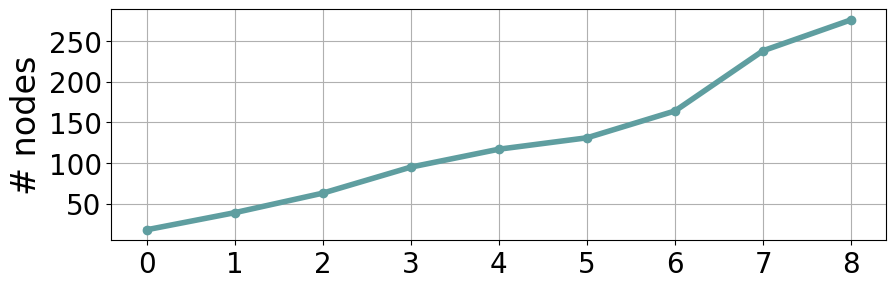

modularity:  0.37683885114297955


In [88]:
graph_version = "GE"
community_detect_algo = "Louvain"
filename = "{}_{}_{}".format(community_detect_algo, graph_version, timestr)

color_map_nodes_algo1,partition1 = community_analysis_PLouvain(GE)
nodes_per_community = get_nodes_per_community(partition1)
no_nodes_per_community_true = [len(el) for el in nodes_per_community]
no_nodes_per_community = np.sort(no_nodes_per_community_true)
print("number of nodes per community: {}".format(no_nodes_per_community))

plt.figure(figsize = (10,3))
plt.plot(no_nodes_per_community, "-o", color = "cadetblue", linewidth = lw)
plt.grid(True)
#change font size of the tick labels
plt.xticks(fontsize=fs_ticks)
plt.yticks(fontsize=fs_ticks)
plt.ylabel("# nodes", fontsize = fs_label)
plt.savefig(f"Figures/lineplot_{filename}.png")
plt.show()

#compute the modularity of the partition
mod = modularity(GE,partition1)
print("modularity: ", mod)

100%|█████████████████████████████████████████████████████████████████████████████████| 9/9 [01:08<00:00,  7.59s/it]


Figures/TF-IDF_WC_Louvain_GE_202212141826.png


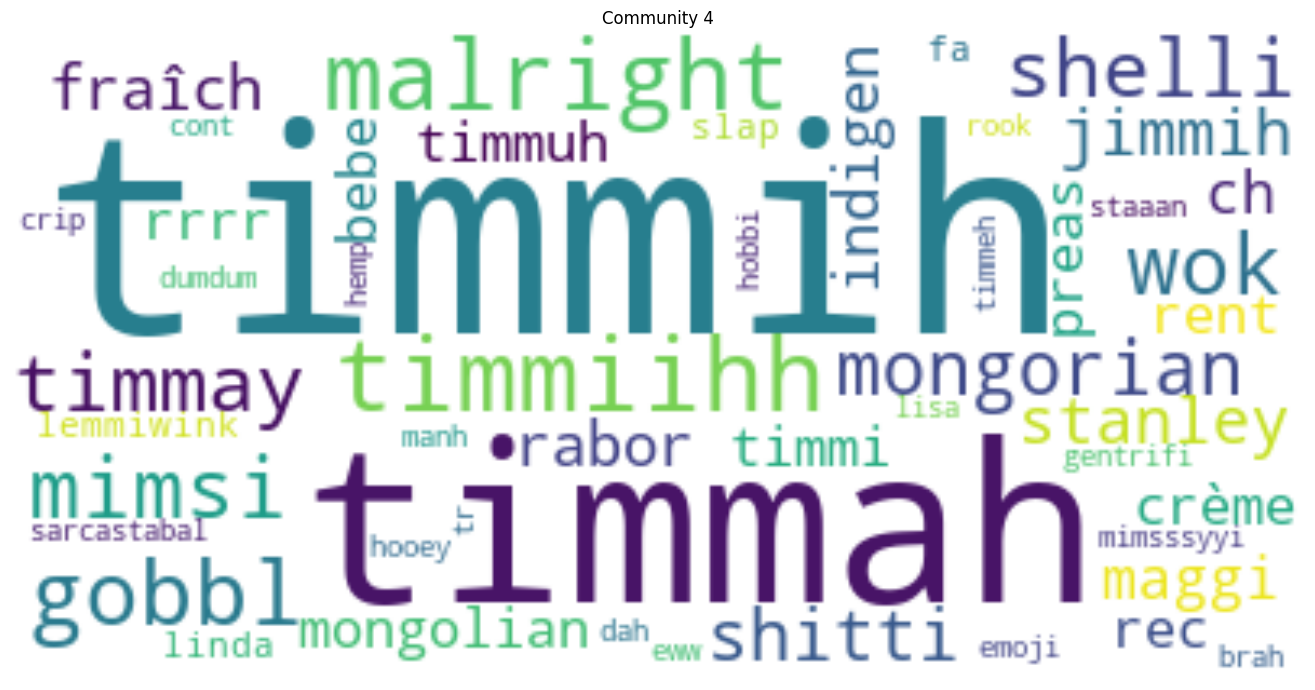

In [89]:
# tf-idf analysis using wordclouds  
freqDist_communities, corpus, communty_ids = compute_freqDist_corpus_communities(partition1);
tfidf_dicts1 = community_tf_idf(freqDist_communities, corpus)
# plot the tf-idf for each community
ids = get_ids(ids_source)
community_detect_algo = "Louvain"
graph_version = "GE"
filename = "{}_{}_{}".format(community_detect_algo, graph_version, timestr)
if plot_wordclouds:
    plot_tf_idf_wordclouds(tfidf_dicts1,ids, filename = filename)

###### Infomap algorithm 

In [90]:
community_detect_algo = "Infomap"
filename = "{}_{}_{}".format(community_detect_algo, graph_version, timestr)

color_map_nodes_algo2, partition2 = community_analysis_infomap(GE)

nodes_per_community = get_nodes_per_community(partition2)
no_nodes_per_community_true = [len(el) for el in nodes_per_community]
no_nodes_per_community = np.sort(no_nodes_per_community_true)
print("number of nodes per community: {}".format(no_nodes_per_community))


Found 29 communities
number of nodes per community: [  3   4   5   5   5   5   5   5   6   6   7   7   7   7   7   7   7   8
   8   8   8   9   9  11  13  13  13  14  15 914]


C:\Users\annas\anaconda3\envs\sgai_project\lib\site-packages\numpy\lib\arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


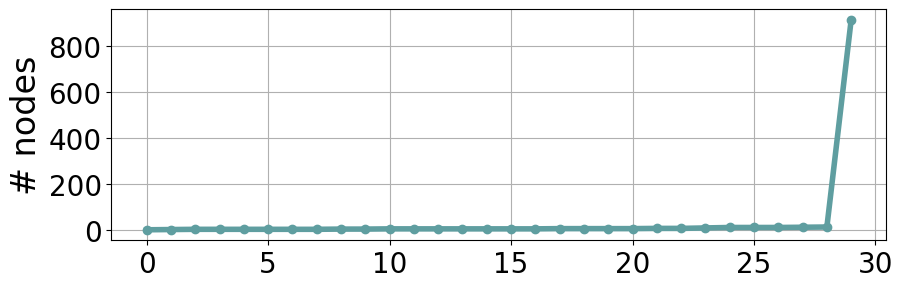

In [91]:
plt.figure(figsize = (10,3))
plt.plot(no_nodes_per_community, "-o", color = "cadetblue", linewidth = lw)
plt.grid(True)
plt.xticks(fontsize=fs_ticks)
plt.yticks(fontsize=fs_ticks)
plt.ylabel("# nodes", fontsize = fs_label)

plt.savefig(f"Figures/lineplot_tot_{filename}.png")
plt.show()

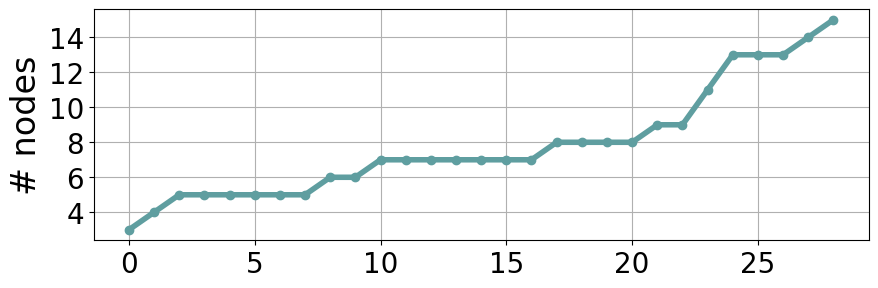

In [92]:
plt.figure(figsize = (10,3))
plt.plot(no_nodes_per_community[:-1], "-o", color = "cadetblue", linewidth = lw)
plt.grid(True)
plt.xticks(fontsize=fs_ticks)
plt.yticks(fontsize=fs_ticks)
plt.ylabel("# nodes", fontsize = fs_label)
plt.savefig(f"Figures/lineplot_sub_{filename}.png")
plt.show()

In [93]:
#compute the modularity of the partition
mod = modularity(GE, partition2)
n_c = np.max([np.max(el) for el in list(partition2.values())])
print("modularity: ", mod)

modularity:  0.15742730367112778


100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [00:56<00:00,  1.89s/it]


Figures/TF-IDF_WC_Infomap_GE_202212141826.png


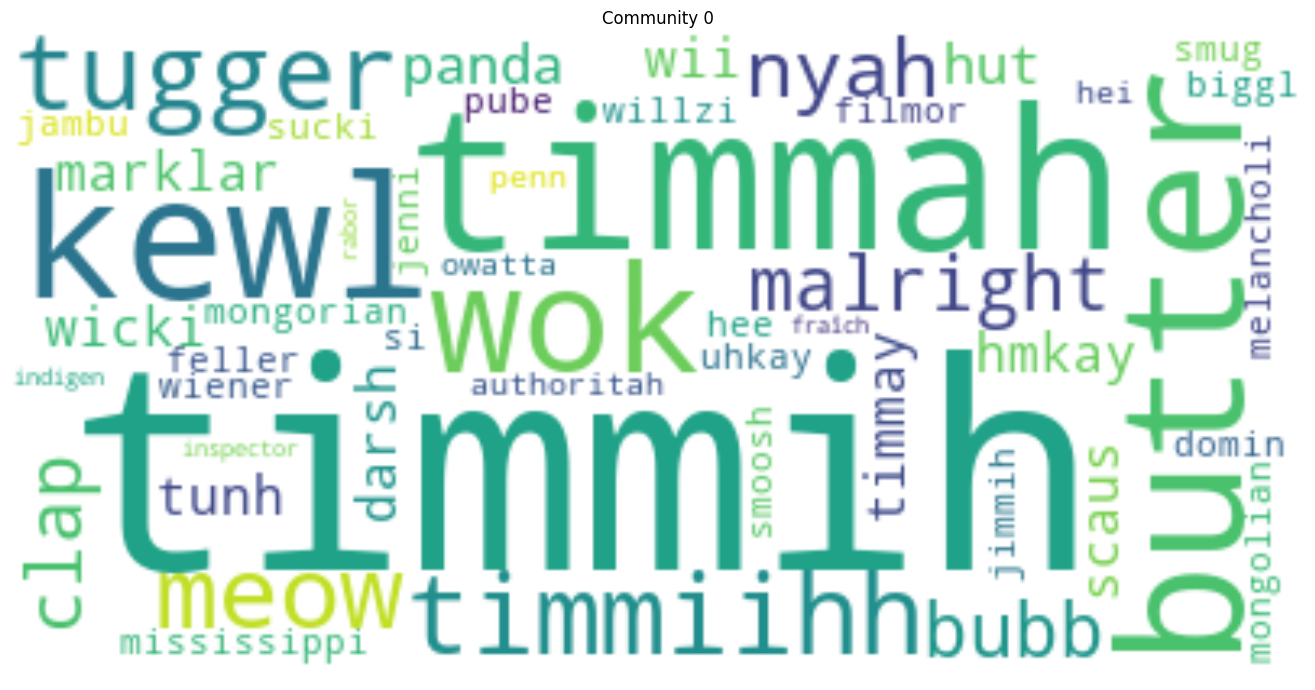

In [94]:
# tf-idf analysis using wordclouds  
freqDist_communities, corpus, community_ids = compute_freqDist_corpus_communities(partition2)
tfidf_dicts2 = community_tf_idf(freqDist_communities, corpus)
# plot the tf-idf for each community
ids = get_ids(ids_source)
community_detect_algo = "Infomap"
filename = "{}_{}_{}".format(community_detect_algo, graph_version, timestr)
if plot_wordclouds:
    plot_tf_idf_wordclouds(tfidf_dicts2,ids, filename = filename)

##### Plot network using Infomap 

In [95]:
if plot_networks:
    print("\n--------------------------------")
    print("\nPlot network using forceatlas and communities")


    graph_version = "episode_links"
    # Define Parameter Grid
    # NOTE I commented out all those features not implemented yet 

    param_grid = {
    "outboundAttractionDistribution" : [True],  # Dissuade hubs
    #linLogMode=False,  # NOT IMPLEMENTED
    #adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    "edgeWeightInfluence" : [0.5, 1.0, 1.5, 2.0],

    # Performance
    "jitterTolerance" : [5.0, 7.0, 10.0, 15.0],  # Tolerance
    "barnesHutOptimize": [True,False],
    "barnesHutTheta" : [5.0, 7.0, 10.0, 15.0],
    #multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    "scalingRatio" : [0.5, 3.0, 6.5],
    "strongGravityMode" : [False], #True
    "gravity" : [7, 10, 15],

    # Log
    "verbose" : [True]
    }

    all_combinations = list(ParameterGrid(param_grid))

    
    #----------------------
    for params in all_combinations:
        timestr = time.strftime("%Y%m%d%H%M%S")
        forceatlas2 = call_fa2(params)
        # safe information of forceatlas setup
        safe_fa2_settings(forceatlas2, timestr, graph_version)
        positions = forceatlas2.forceatlas2_networkx_layout(GE, pos=nx.spring_layout(GE), iterations=2000)

        safe_figure(GE, 
                    params, 
                    positions, 
                    GEnode_size_map, 
                    color_map_nodes_algo1, 
                    timestr, 
                    community_detect_algo = "Louvain", 
                    graph_version = graph_version)
        safe_figure(GE, 
                    params, 
                    positions, 
                    GEnode_size_map, 
                    color_map_nodes_algo2, 
                    timestr, 
                    community_detect_algo = "Infomap", 
                    graph_version = graph_version)



#### GS community analysis 
###### Louvain algorithm 

In [96]:
graph_version = "GS"
community_detect_algo = "Louvain"
filename = "{}_{}_{}".format(community_detect_algo, graph_version, timestr)


color_map_nodes_algo1,partition1 = community_analysis_PLouvain(GS)

nodes_per_community = get_nodes_per_community(partition1)
no_nodes_per_community_true = [len(el) for el in nodes_per_community]
no_nodes_per_community = np.sort(no_nodes_per_community_true)
print("number of nodes per community: {}".format(no_nodes_per_community))


Found 10 communities
number of nodes per community: [ 12  14  35  45  47  64  96 107 139 173 178]


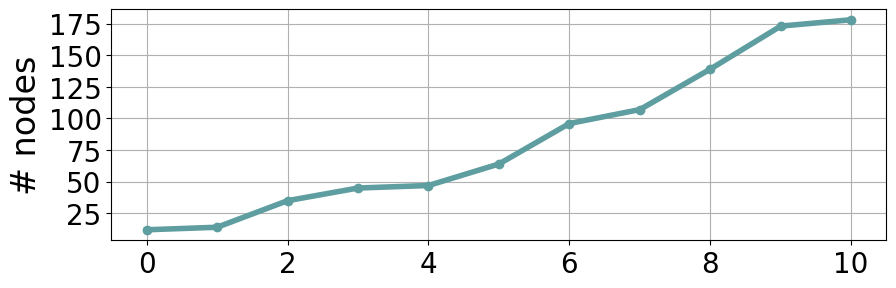

In [97]:
plt.figure(figsize = (10,3))
plt.plot(no_nodes_per_community, "-o", color = "cadetblue",linewidth = lw)
plt.grid(True)
plt.xticks(fontsize=fs_ticks)
plt.yticks(fontsize=fs_ticks)
plt.ylabel("# nodes", fontsize = fs_label)
plt.savefig(f"Figures/lineplot_{filename}.png")
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:59<00:00,  5.43s/it]


Figures/TF-IDF_WC_Louvain_GS_202212141826.png


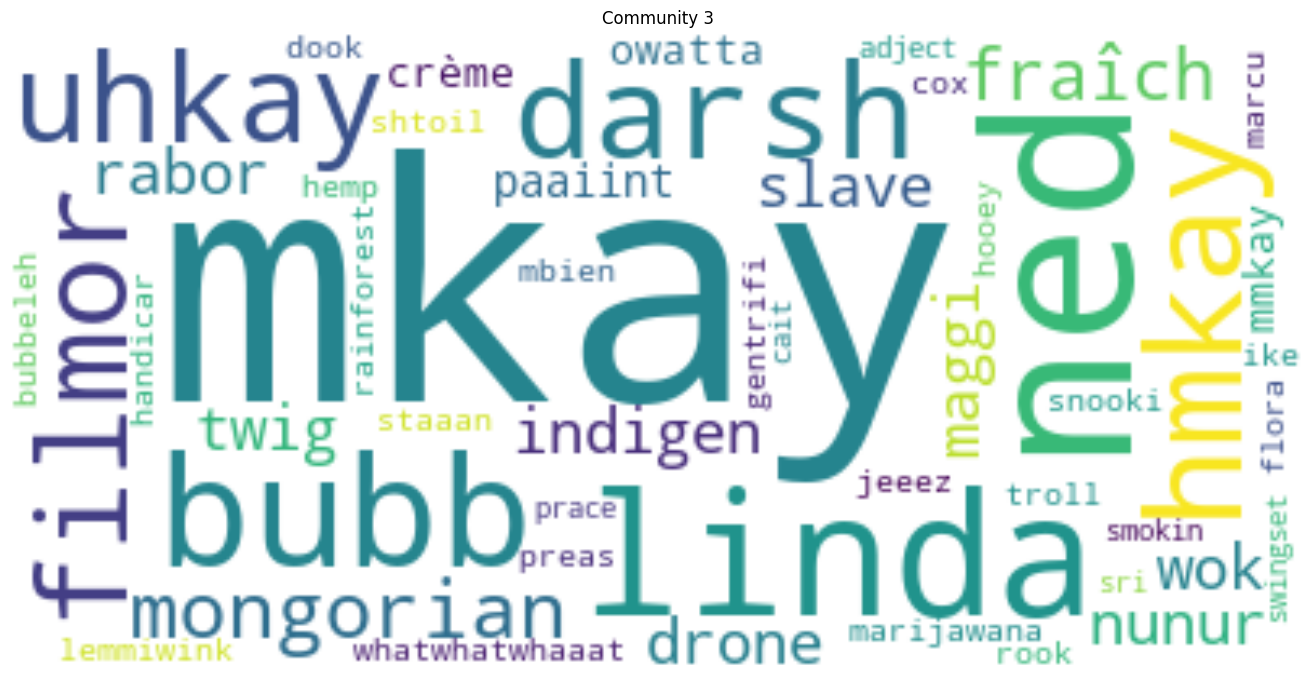

In [98]:
# tf-idf analysis using wordclouds  
freqDist_communities, corpus, community_ids = compute_freqDist_corpus_communities(partition1)
tfidf_dicts1 = community_tf_idf(freqDist_communities, corpus)
# plot the tf-idf for each community

ids = get_ids(ids_source)
if plot_wordclouds:
    plot_tf_idf_wordclouds(tfidf_dicts1,ids, filename = filename)

###### Infomap algorithm 

In [99]:
community_detect_algo = "Infomap"

filename = "{}_{}_{}".format(community_detect_algo, graph_version, timestr)
color_map_nodes_algo2, partition2 = community_analysis_infomap(GS)

nodes_per_community = get_nodes_per_community(partition2)
no_nodes_per_community_true = [len(el) for el in nodes_per_community]
no_nodes_per_community = np.sort(no_nodes_per_community_true)
print("number of nodes per community: {}".format(no_nodes_per_community))


Found 52 communities
number of nodes per community: [  2   2   2   2   2   3   3   3   3   3   3   3   3   4   4   4   4   5
   5   5   5   5   6   6   6   7   7   7   7   7   8   8   8   8   9   9
  10  10  11  11  12  12  14  14  15  16  16  17  19  23 100 128 304]


C:\Users\annas\anaconda3\envs\sgai_project\lib\site-packages\numpy\lib\arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


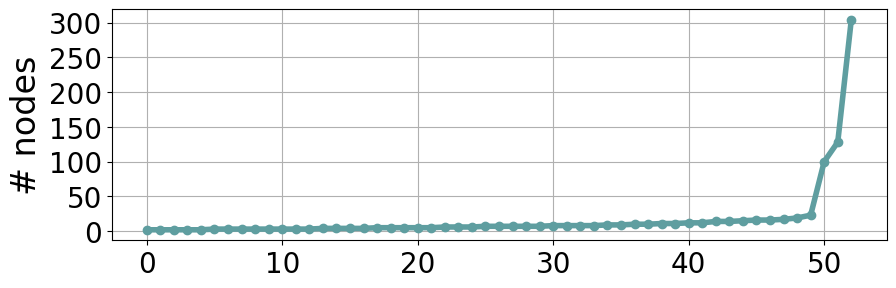

In [100]:
plt.figure(figsize = (10,3))
plt.plot(no_nodes_per_community, "-o", color = "cadetblue", linewidth = lw)
plt.grid(True)
plt.xticks(fontsize=fs_ticks)
plt.yticks(fontsize=fs_ticks)
plt.ylabel("# nodes", fontsize = fs_label)
plt.savefig(f"Figures/lineplot_tot_{filename}.png")
plt.show()

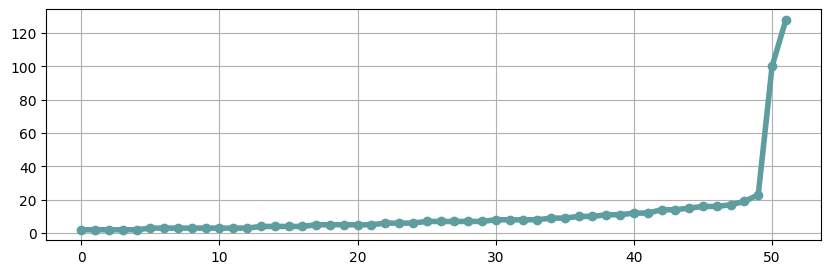

In [101]:
plt.figure(figsize = (10,3))
plt.plot(no_nodes_per_community[:-1], "-o", color = "cadetblue", linewidth = lw)
plt.grid(True)
plt.savefig(f"Figures/lineplot_sub_{filename}.png")
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████| 53/53 [00:37<00:00,  1.42it/s]


Figures/TF-IDF_WC_Infomap_GS_202212141826.png


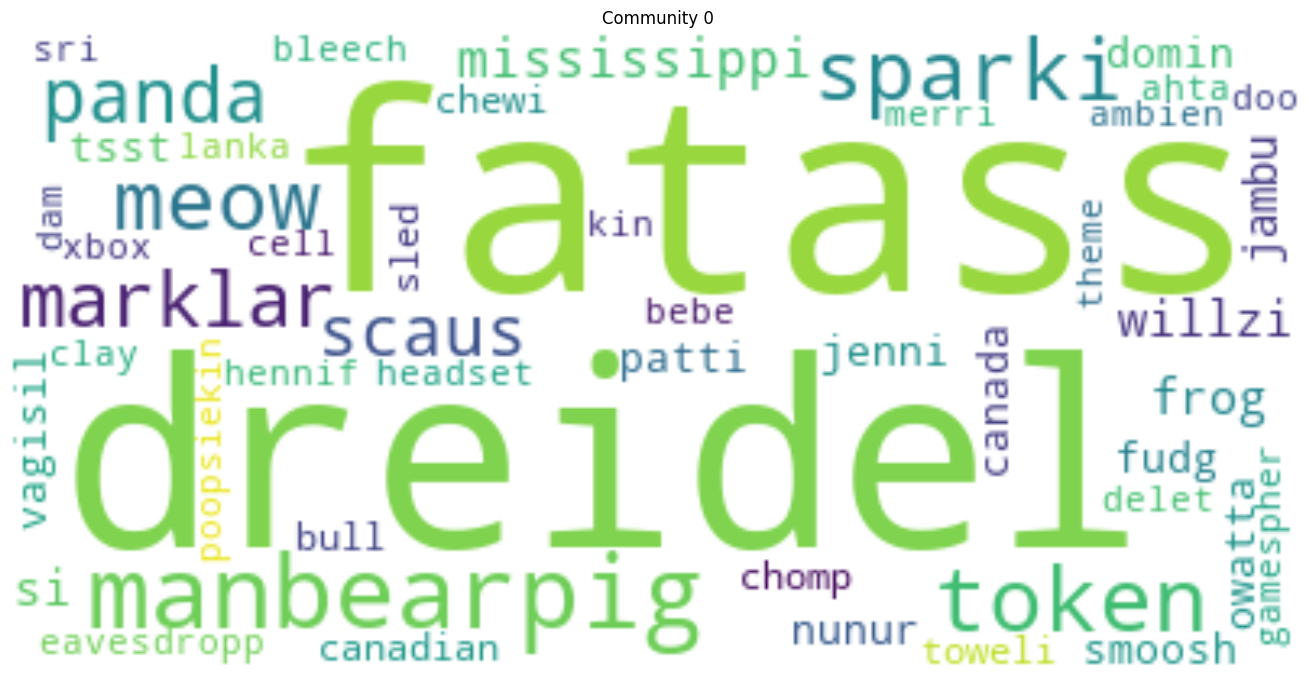

In [102]:
# tf-idf analysis using wordclouds  
freqDist_communities, corpus, community_ids = compute_freqDist_corpus_communities(partition2)
tfidf_dicts2 = community_tf_idf(freqDist_communities, corpus)


ids = get_ids(ids_source)
# plot the tf-idf for each community
if plot_wordclouds:
    plot_tf_idf_wordclouds(tfidf_dicts2, ids, filename = filename)

##### Plot network using Infomap 

In [103]:
if plot_networks:
    print("\n--------------------------------")
    print("\nPlot network using forceatlas and communities")
    # plot using force altlas 2
    # NOTE I commented out all those features not implemented yet 
    graph_version = "scene_links"
    # Define Parameter Grid
    param_grid = {
    "outboundAttractionDistribution" : [True],  # Dissuade hubs
    #linLogMode=False,  # NOT IMPLEMENTED
    #adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    "edgeWeightInfluence" : [0.5, 1.0, 1.5,2.0],

    # Performance
    "jitterTolerance" : [5.0, 7.0, 10.0, 15.0],  # Tolerance
    "barnesHutOptimize": [True],
    "barnesHutTheta" : [5.0, 10.0, 15.0, 20.0],
    #multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    "scalingRatio" : [0.5, 3.0, 6.5],
    "strongGravityMode" : [False], #True
    "gravity" : [0.5, 3.0, 6.0],

    # Log
    "verbose" : [True]
    }

    all_combinations = list(ParameterGrid(param_grid))


    #----------------------
    for params in all_combinations:
        timestr = time.strftime("%Y%m%d%H%M%S")
        forceatlas2 = call_fa2(params)
        # safe information of forceatlas setup
        safe_fa2_settings(forceatlas2, timestr, graph_version)
        positions = forceatlas2.forceatlas2_networkx_layout(GS, pos=nx.spring_layout(GS), iterations=2000)

        safe_figure(GS, 
                    params, 
                    positions, 
                    GSnode_size_map, 
                    color_map_nodes_algo2, 
                    timestr, 
                    community_detect_algo = "Louvain", 
                    graph_version = graph_version)
        safe_figure(GS, 
                    params, 
                    positions, 
                    GSnode_size_map, 
                    color_map_nodes_algo2, 
                    timestr, 
                    community_detect_algo = "Infomap", 
                    graph_version = graph_version)


---
## Part 5: Sentiment Analysis of South Park 

In [104]:
run_sentiment_anlysis = False

#paths
# set path and output file names
data_dir = 'data'
cast_dir = f'{data_dir}/episode_cast_lists'
script_dir = f'{data_dir}/episode_scripts'

all_characters_filename = "All_characters.txt"
celeb_characters_filename = "Celebrity_characters.txt"
south_park_characters_filename = "South-Park_characters.txt"
episode_list_filename = "Episodes.txt"

# open the text file with all, celeb and south park characters
all_character_list = open(f'{data_dir}/{all_characters_filename}', 'r').read().split('\n')
celeb_character_list = open(f"{data_dir}/{celeb_characters_filename}", "r").read().split("\n")
south_park_character_list = open(f"{data_dir}/{south_park_characters_filename}", "r").read().split("\n")

print("Character Stats:")
print(f" number of all characters: {len(all_character_list)}")
print(f" number of celeb characters: {len(celeb_character_list)}")
print(f" number of south-park characters: {len(south_park_character_list)}")
print(f" total: {len(celeb_character_list)+len(south_park_character_list)}")


Character Stats:
 number of all characters: 1917
 number of celeb characters: 429
 number of south-park characters: 1537
 total: 1966


In [105]:
# set path and output file names
data_dir = 'data'
cast_dir = f'{data_dir}/episode_cast_lists'
script_dir = f'{data_dir}/episode_scripts'
character_dia_dir = f'{data_dir}/character_dialog'
episode_numbers = data_dir+'/Episode_Names_Anna.txt'

charachters_path = episode_dialog_cleaned_dir

In [106]:
#helper functions 
def get_all_dialog():
    #t = 'script_A_Boy_And_A_Priest.txt'
    result = []
    for episode_name in dir_list:
        print(episode_name)
        txt = open(script_dir +'/'+ episode_name,'r').read()
        all_dialog = re.findall(r'\{\{ScriptDialog\|.*\}\}', txt)
        if len(all_dialog) > 0:
            result = result + all_dialog
    return result

    
()

def get_dialog_from_ch(all_dialog):
     
    for dialog in all_dialog:
        ch_s = re.findall(r'([^\{|]+)',dialog)
        if len(ch_s) == 3:
            character = ch_s[1].lower().replace(', ',' ').replace('/',' ').replace(' ','_')
            print(character)
            try:
                ch_dialog=ch_s[2].replace('}}','')
            except:
                  print("An exception occurred") 
            if os.path.exists('data/character_dialog/'+character + ".txt"):
                #open the file and append the newest line to the end
                file_object = open('data/character_dialog/'+ character + '.txt', 'a')
                file_object.write(ch_dialog)
                file_object.close()
            else:
                #does not exists create new file with name of character and store the dialog 
                try:
                    with open('data/character_dialog/'+ character + '.txt', 'w') as f:
                        f.write(ch_dialog)
                        f.close()
                except:
                    print('File name is too long')

In [107]:
#import labMt file 
path = "data/labmit.txt"
df = pd.read_csv(path, sep='\t')
df

word  happiness_rank  happiness_average  \
0       laughter               1               8.50   
1      happiness               2               8.44   
2           love               3               8.42   
3          happy               4               8.30   
4        laughed               5               8.26   
...          ...             ...                ...   
10217     murder           10218               1.48   
10218  terrorism           10219               1.48   
10219       rape           10220               1.44   
10220    suicide           10221               1.30   
10221  terrorist           10222               1.30   

       happiness_standard_deviation twitter_rank google_rank nyt_rank  \
0                            0.9313         3600          --       --   
1                            0.9723         1853        2458       --   
2                            1.1082           25         317      328   
3                            0.9949           65        1372     1313   
4                            1.1572         3334        3542       --   
...                             ...          ...         ...      ...   
10217                        1.0150         2762        3110     1541   
10218                        0.9089           --          --     3192   
10219                        0.7866         3133          --     4115   
10220                        0.8391         2124        4707     3319   
10221                        0.9091         3576          --     3026   

      lyrics_rank  
0            1728  
1            1230  
2              23  
3             375  
4            2332  
...           ...  
10217        1059  
10218          --  
10219        2977  
10220        2107  
10221          --  

[10222 rows x 8 columns]

In [108]:
#implement sentiment function 
def sentiment(ls):
    total = 0
    f_i = 0
    f_j = 0
    ls = nltk.word_tokenize(ls)
    tokens = [token.lower() for token in ls] # make tokens lowercase
    word_dict = nltk.FreqDist(tokens)
    for k,v in word_dict.items():
        if any(df.word == k):
            f_j += v
    for k,v in word_dict.items():
        try:
            res = df.loc[df['word'] == k, 'happiness_average'].iloc[0]
            avg = (res*v)
            total += avg
        except:
            total = total + 0
    
    if f_j != 0:
        return total/f_j
    else: 
        return 0

In [109]:
#calculate sentiment and store in dictionary
if run_sentiment_anlysis:
    ch = {}
    dir_list = os.listdir(charachters_path)
    for i in range(len(dir_list)):
        #print(dir_list[i])
        try:
            f = open(f"{charachters_path}/{dir_list[i]}")
            text = f.read()
            if dir_list[i] not in ch:
                ch[dir_list[i]] = sentiment(text)
            else:
                continue
        except:
            continue

    for k,v in ch.items():
        print(f'character: {k}, sentiment_value= {v}')

In [110]:
# load ch 
ch = {'agent_12.txt': 5.490769230769231, 'elderly_man_on_motorcycle.txt': 5.92, '911_operator.txt': 4.867058823529412, 'tron_soldier.txt': 5.568571428571429, 'incredible_meat_founder.txt': 5.703984962406014, 'canadian_2.txt': 5.33, 'blond_girl.txt': 5.393333333333334, 'vape_rep.txt': 5.503716814159294, 'redneck_21.txt': 5.846666666666667, "garrison's_profile.txt": 5.953333333333333, 'matt.txt': 5.410614334470989, 'road_workers.txt': 5.275555555555556, 'munky.txt': 5.44936170212766, 'construction_worker.txt': 5.518775510204082, 'assemblyman_1.txt': 5.492500000000001, 'cleric_1.txt': 5.286666666666667, 'female_reporter_2.txt': 5.199999999999999, 'miss_information.txt': 5.529418181818182, 'the_situation.txt': 5.328952380952379, 'jakovasaur_boy.txt': 5.888, "unknown_caller's_daughter.txt": 4.7, 'mormon_3.txt': 0, 'man_2.txt': 5.458984812150278, 'fat_priest.txt': 5.248888888888889, "kyle's_side.txt": 0, 'priest.txt': 5.403692946058091, 'jennifer_lopez.txt': 5.392301075268814, 'male.txt': 5.2654545454545465, 'goodly.txt': 5.079999999999999, 'chef.txt': 5.489808440586652, 'paparazzo_11.txt': 5.743333333333333, 'fuhrman.txt': 5.480555555555556, 'smithy.txt': 5.316614173228349, 'mama.txt': 5.373508064516131, 'fat_abbot.txt': 5.056744186046514, 'the_nuggets.txt': 6.56, 'caller_3.txt': 5.227551020408164, 'apple_tech.txt': 5.456, 'dr.neeland.txt': 5.855555555555556, 'black_man.txt': 5.190909090909091, 'yelper_4.txt': 5.6066666666666665, 'boy_#1.txt': 5.6035087719298255, 'toothbrush.txt': 5.3478260869565215, 'news_reporter.txt': 5.45825327510917, "o'reilly.txt": 5.402105263157895, 'bobby_flay.txt': 5.600740740740741, 'lamb_chop.txt': 6.4125000000000005, 'newt_gingrich.txt': 5.854736842105264, 'viewer_1.txt': 4.702857142857143, 'middle_dwarf.txt': 5.444285714285714, 'worker_1.txt': 5.412954545454545, 'meagan.txt': 5.19076923076923, 'pueblo_team.txt': 6.06, 'greeter.txt': 5.514153846153849, 'gerald_sheila.txt': 0, 'clerk_3.txt': 5.605967741935483, 'miss_travis.txt': 5.595, 'male_2.txt': 5.639200000000001, 'patron_10.txt': 0, 'reenactor_3.txt': 5.9, 'representative.txt': 5.460337078651685, 'redneck.txt': 5.469, "gary_johnson's_profile.txt": 5.9799999999999995, 'dahmer.txt': 5.279917355371901, 'howard.txt': 5.533214285714284, 'townsmen.txt': 5.513333333333333, '911truth_man.txt': 5.3686854460093905, 'fans.txt': 5.685645161290323, 'teenager_1.txt': 5.3485106382978715, 'monitor_man.txt': 6.1, 'yourmomstits.txt': 5.23, 'fed.txt': 5.3999999999999995, 'attendant.txt': 5.408145695364238, 'mall_worker_7.txt': 5.545833333333332, 'partner.txt': 5.41081081081081, 'beefcake_cartman.txt': 5.5, 'other_goths.txt': 0, 'another_addict.txt': 5.77, 'fiancée.txt': 5.621511879049673, 'lion_2.txt': 5.425714285714286, 'mr._zewiski.txt': 5.327555555555555, 'techs.txt': 5.98, 'anchorwoman.txt': 5.17, 'townsman_8.txt': 5.261666666666666, 'resident_5.txt': 5.822222222222221, 'army_doctor.txt': 6.166666666666667, 'staffer_2.txt': 5.632666666666667, 'individual_in_crowd.txt': 6.06, 'peta_man.txt': 5.4048, 'ticket-taker.txt': 5.324583333333334, 'danish_woman.txt': 4.99, 'ryan_valmer.txt': 0, 'et_reporter.txt': 5.485454545454545, 'pirate_2.txt': 5.457777777777777, 'asian_reporter.txt': 5.461428571428572, 'agent_marx.txt': 5.508484848484849, 'elderly_man_4.txt': 5.216000000000001, 'two_small_voices.txt': 5.601481481481479, 'cashier.txt': 5.507515789473686, 'balding_man.txt': 5.500049627791556, 'the_broflovskis.txt': 5.619999999999999, '"kenny".txt': 5.2875, 'bob_and_audience.txt': 4.533333333333333, 'tricia.txt': 3.48, 'santa_claus.txt': 4.34, 'aging_hippie_liberal_douche.txt': 5.565357142857144, 'treasurer_2.txt': 5.668666666666667, 'whole_foods_rep.txt': 5.562639593908627, 'official_3.txt': 0, 'soldier_4.txt': 5.462352941176469, 'white_hare.txt': 5.3853846153846145, "tele's_owner.txt": 5.326666666666665, 'rick.txt': 5.433990783410141, 'retarded_fish.txt': 6.048, 'patron_1.txt': 5.53625, 'trooper.txt': 5.235882352941178, 'constance.txt': 5.685714285714285, 'natalie.txt': 5.395510204081634, 'dickinson.txt': 5.290967741935485, 'romanian_official.txt': 5.373772455089817, 'blonde_3.txt': 6.84, 'richie.txt': 5.3689743589743575, 'players.txt': 4.34, 'gerald.txt': 5.465336610895256, 'kids_around_kenny.txt': 0, 'sondheim.txt': 5.56265060240964, 'tourist.txt': 6.052, 'photographer.txt': 5.650154798761612, 'phil.txt': 5.5766407766990325, "jessica's_mom.txt": 5.480000000000001, 'coach_brady.txt': 5.185833333333334, 'supporter.txt': 3.8, 'townfolk.txt': 5.2457142857142856, 'blonde_2.txt': 5.595833333333332, 'dispatcher.txt': 5.543137254901961, 'karen.txt': 5.635468164794009, 'american_male_1.txt': 5.562105263157894, 'vendor.txt': 5.594545454545455, 'leader.txt': 5.4095, 'jack_brolin.txt': 5.034999999999998, 'nambla_member.txt': 5.988333333333333, 'mimsy.txt': 5.282857142857141, 'tad.txt': 5.50363636363636, 'stephen_stotch.txt': 5.253666666666667, 'mom.txt': 5.541666666666666, 'blacksmith.txt': 5.160000000000001, 'wrangler.txt': 5.481818181818183, 'mephesto.txt': 5.419766187050354, 'lucas.txt': 5.23, 'hispanic_reporter.txt': 5.369724137931035, 'brunette.txt': 5.46842424242424, 'soldier_5.txt': 7.3, 'official_2.txt': 5.224000000000001, 'treasurer_3.txt': 5.0691428571428565, 'mr._connolly.txt': 5.534431578947366, 'gordon.txt': 5.506666666666668, 'pentagon_employee.txt': 5.9, 'jimbo.txt': 5.393214487034943, 'bald_knight.txt': 4.98, 'teller.txt': 5.524905660377361, 'manson.txt': 5.470081433224758, 'm.c.txt': 5.701818181818182, 'kyle_stan.txt': 6.14, 'elderly_man_5.txt': 5.0166666666666675, 'magician.txt': 5.448181818181818, 'afghan_cartman.txt': 5.74, 'mediator.txt': 5.471428571428572, 'the_group.txt': 6.156, 'congregants.txt': 5.873333333333334, 'shari.txt': 5.843999999999999, 'collector.txt': 5.564761904761904, 'pirate_3.txt': 5.405882352941178, 'blond.txt': 5.575625000000003, 'kathie_lee_gifford.txt': 6.449999999999999, 'mimi.txt': 5.189230769230769, 'boss.txt': 5.327368421052631, 'enrique_iglesias.txt': 5.670967741935484, 'staffer_3.txt': 5.624374999999999, 'cowboy.txt': 5.602800000000001, 'all.txt': 5.461382978723407, 'resident_4.txt': 5.305565217391303, 'employee_1.txt': 5.168, 'townsman_9.txt': 5.096666666666667, 'dick_cheney.txt': 5.656000000000001, 'dr._schroeder.txt': 5.596106870229008, 'q_money.txt': 5.324705882352944, 'rob_reiner.txt': 5.389836494440808, 'nurse_gollum.txt': 5.4406024096385535, 'right_breast.txt': 5.404705882352941, 'fr._maxi.txt': 5.512449664429537, 'aarp_member_1.txt': 5.811999999999999, 'mr._billing.txt': 5.298124999999999, 'side_judge.txt': 5.237500000000001, 'army_general_2.txt': 5.237894736842105, 'mall_worker_6.txt': 5.679999999999999, 'dr._biber.txt': 5.481468401486984, 'somali_2.txt': 4.867272727272726, 'wally_b..txt': 5.562666666666668, 'otter_leader.txt': 5.461311475409836, 'dr._adams.txt': 5.564732824427475, 'violet_hare.txt': 4.616666666666666, 'alf_member.txt': 4.684, 'fort_collins_citizen_4.txt': 5.5488888888888885, 'the_ramseys_and_condit.txt': 5.533333333333334, 'dr._hallis.txt': 5.435853018372704, 'the_chevy_ad.txt': 5.798275862068966, 'reenactor_2.txt': 5.9, 'dc_crewman.txt': 5.064, 'military_officer.txt': 5.395555555555554, 'clerk_2.txt': 5.471971830985917, 'mrs._biggle.txt': 5.574307692307693, 'charles_biggens.txt': 5.477142857142857, 'fat_girl.txt': 5.6175999999999995, 'blaine.txt': 5.45935064935065, 'stan_kyle_kenny.txt': 5.497142857142857, 'towel.txt': 5.297499999999999, "girls'_table.txt": 5.8066666666666675, 'assemblywoman_2.txt': 5.370952380952382, 'goths.txt': 4.968, 'sally.txt': 5.509726443768997, 'blonde.txt': 5.603703703703704, 'jakovasaur_kid_4.txt': 4.455555555555555, 'a_troll.txt': 5.42, 'stage_hand.txt': 5.6404000000000005, 'randy_newman.txt': 5.496666666666665, 'tom_cruise.txt': 5.424163568773231, 'peg-leg.txt': 8.5, 'lady_judge.txt': 5.619999999999998, 'gordon_brown.txt': 5.407272727272728, 'uk_aide.txt': 5.486153846153846, 'afro_ninja.txt': 5.694545454545454, 'guide.txt': 5.37468309859155, 'italian_cardinal.txt': 5.435147679324893, 'denver_guard.txt': 5.465882352941177, 'paparazzo_10.txt': 5.381176470588237, 'teresa.txt': 5.37597402597403, 'caller_2.txt': 5.379411764705884, 'baker_2.txt': 5.452, 'connelly.txt': 5.553292682926824, 'random_voices.txt': 5.7, 'all_the_boys.txt': 6.14, 'stan_and_kenny.txt': 5.1, 'baby_jimmy.txt': 5.617142857142857, 'cows.txt': 5.300000000000001, 'a_few_others.txt': 5.9, 'man_3.txt': 5.430595238095235, 'mormon_2.txt': 5.6238596491228074, 'burly_man.txt': 5.2458333333333345, 'another_kid.txt': 4.24, 'mr._jarvis.txt': 5.333488372093023, 'kid_1.txt': 5.17128205128205, 'thomas_kyle.txt': 3.81, 'funbot.txt': 6.324, 'stan_kyle_butters.txt': 6.51, 'uncle_stinky.txt': 5.735555555555556, 'rand.txt': 5.284, 'redneck_20.txt': 5.091904761904761, 'lion_cub_1.txt': 5.634871794871795, 'lead_ginger.txt': 5.5666666666666655, 'aussie_crewman.txt': 5.833333333333333, 'babies.txt': 5.776923076923077, 'stocker.txt': 5.595294117647059, 'canadian_3.txt': 5.432307692307692, 'officer_10.txt': 5.185, 'mrs._farnickle.txt': 5.676938775510203, 'cheerleader_2.txt': 4.8133333333333335, 'mr._harrison.txt': 5.756923076923076, 'michael_douglas.txt': 3.54, 'theme.txt': 6.3999999999999995, 'members.txt': 5.767, 'canadian_1.txt': 5.407500000000001, '"droopy_dawg".txt': 5.086666666666667, 'cyclist.txt': 5.6579999999999995, 'agent_11.txt': 5.052000000000001, 'susan.txt': 5.462747252747254, 'native_american_chief.txt': 5.88952380952381, 'officer_jenkins.txt': 5.339295774647886, 'moses.txt': 5.5009259259259276, 'third_official.txt': 5.984705882352942, 'tooth_decay.txt': 5.221333333333334, 'lion_cub_3.txt': 5.147826086956522, 'redneck_22.txt': 5.311428571428571, 'galeed.txt': 5.341983471074381, 'topher.txt': 5.276419753086418, 'man_1.txt': 5.401617086193746, 'a_guest.txt': 5.3985714285714295, 'owners.txt': 4.8, 'siri.txt': 5.776666666666666, 'eddie.txt': 5.513333333333333, 'paul_harris.txt': 5.3713432835820925, 'french_delegate.txt': 5.4903703703703695, 'tracy.txt': 5.3853846153846145, 'lennart.txt': 5.494300000000002, 'dental_floss.txt': 5.069642857142858, 'kid_3.txt': 5.76, 'stephen_butters.txt': 5.535, 'assemblyman_2.txt': 5.396, 'cleric_2.txt': 4.711111111111111, 'creature.txt': 4.870909090909091, 'reporters.txt': 5.373000000000001, 'women.txt': 5.920000000000001, 'geoff_hamill.txt': 5.543558052434458, 'mannuel.txt': 5.635499999999999, 'blond_man.txt': 5.365714285714286, 'peter.txt': 5.436365979381445, 'kyle.txt': 5.429665961489239, 'danes.txt': 5.490666666666666, 'nobunaga.txt': 5.088148148148149, 'paparazzo_12.txt': 5.073333333333335, 'hbc_president.txt': 5.111726190476192, 'a_hippie.txt': 5.604210526315789, 'chief.txt': 5.425950704225352, 'first_mate.txt': 5.250000000000001, 'someone_in_the_crowd.txt': 7.78, 'hell_director.txt': 5.4152, 'chief_joe.txt': 5.366381578947368, 'zombie_mortician.txt': 6.183333333333334, 'guest.txt': 5.524556962025317, 'filmore.txt': 5.542531645569622, 'musician_3.txt': 6.74, 'jimmy_buffett.txt': 6.319999999999999, 'boy_#2.txt': 5.387368421052631, 'cher.txt': 5.423750000000001, 'president_bush.txt': 5.477212121212122, 'repairman_2_(kurt).txt': 5.383333333333333, 'border_guard.txt': 5.500000000000002, 'alien_man.txt': 5.5195294117647045, 'stephen.txt': 5.467031767041685, 'driver_5.txt': 4.984999999999999, 'guy_in_flat_top.txt': 5.446666666666666, 'jabs.txt': 5.440744680851064, 'worker_2.txt': 5.397202072538859, 'gates.txt': 5.417576530612246, 'lao_tzu.txt': 5.403076923076923, 'viewer_2.txt': 4.77, '_cartman.txt': 5.583157894736843, 'robert_redford.txt': 5.592313624678662, 'harrison_moore.txt': 5.386892857142855, 'hotline_voice.txt': 5.42357723577236, 'lucy.txt': 5.330943396226415, 'god.txt': 5.409827586206894, 'male_1.txt': 5.6035714285714295, 'davíd.txt': 5.665194805194805, 'mall_workers.txt': 5.58, 'jared_fogle.txt': 5.550769230769232, 'inmates.txt': 5.9, 'female_director_2.txt': 5.5, 'mona.txt': 5.15076923076923, 'elder_garth.txt': 5.425985401459847, 'el_presidente.txt': 5.371290322580646, 'garrison.txt': 5.400995316159261, 'harriet.txt': 5.478139534883723, 'clyde_kenny.txt': 5.9, 'injured_thief.txt': 4.286666666666666, 'john_ramsey.txt': 5.38455882352941, 'chris_swollenballs.txt': 5.311791907514451, 'lion_1.txt': 5.499487179487179, 'aarp_member_3.txt': 5.52625, 'producer.txt': 5.541842948717948, 'teenager_2.txt': 5.789090909090909, 'pence.txt': 5.363157894736842, 'mall_worker_4.txt': 5.343, 'ozzy.txt': 5.7379999999999995, 'mingie.txt': 5.361997563946403, 'captain_paul_watson.txt': 6.140000000000001, 'lead_alien.txt': 5.548437500000001, 'staffer_1.txt': 5.255862068965516, 'agent_9.txt': 5.208571428571429, 'jonbenét_ramsey.txt': 5.314545454545454, 'korn.txt': 5.453023255813952, 'bum_18.txt': 5.56, 'colleague.txt': 5.9, 'intruder.txt': 5.41375, 'music.txt': 5.906666666666666, 'milo.txt': 5.702222222222223, 'employee_3.txt': 5.454736842105263, 'resident_6.txt': 5.2, 'a_teen_boy.txt': 5.14, 'donald_trump.txt': 7.64, 'obese_woman.txt': 5.13, 'elderly_man_7.txt': 4.72, 'maury.txt': 5.50377622377622, 'louis.txt': 5.412666666666667, 'kobe_bryant.txt': 5.528478260869565, 'charlotte_poll_worker.txt': 5.580000000000001, 'pirate_1.txt': 5.909999999999999, 'guy_in_leather_jacket.txt': 6.5, 'farmers.txt': 4.727999999999999, 'efsm_president.txt': 5.382093023255815, 'adolf_hitler.txt': 4.77, 'doctor.txt': 5.392385347562742, 'veteran_guard.txt': 5.483040293040293, 'schwartz.txt': 5.381621621621622, 'comedian.txt': 5.518495575221239, 'puerto_rican_player.txt': 5.539999999999999, 'kathie_lee.txt': 6.034285714285713, 'ranger_mcfriendly.txt': 5.43186495176849, 'patron_2.txt': 5.378805970149255, 'jenny_mark.txt': 5.606, 'attendant_1.txt': 5.363863636363638, 'treasurer_1.txt': 5.329000000000001, 'lead_convict.txt': 5.5445, 'family.txt': 5.3514285714285705, 'damien.txt': 5.415884773662552, 'rosemary.txt': 5.398800000000001, 'skeeter.txt': 5.432349177330895, 'don_king.txt': 5.099454545454546, 'george_r._r._martin.txt': 5.480319634703193, 'ms._nelson.txt': 5.43, 'gigi.txt': 5.762727272727272, 'mr._jabs.txt': 5.283368421052633, 'woman_with_brown_hair.txt': 5.3123287671232875, 'lamont.txt': 5.473664459161146, 'tour_guide.txt': 5.479171461449938, 'sailor.txt': 5.786153846153846, 'chaos_#35.txt': 4.16, 'tom.txt': 5.394287577437237, 'richard_adler.txt': 5.3855813953488365, 'cow.txt': 5.359999999999999, 'hackman.txt': 5.441203703703702, 'american_male_3.txt': 5.44, 'a_fangirl.txt': 6.859999999999999, 'sharon_.txt': 5.3133333333333335, 'rabbi_4.txt': 5.124230769230769, 'kit-9.txt': 5.471764705882354, 'pooh.txt': 5.543968253968253, 'second_baseman.txt': 5.045, 'male_crew_1.txt': 5.083333333333333, 'police_chief.txt': 5.466187050359712, 'males.txt': 5.5, 'mr._adams.txt': 5.535610859728502, 'james_hetfield.txt': 5.3116666666666665, 'rabbi_5.txt': 5.215483870967742, 'other_women.txt': 5.712000000000001, 'translator.txt': 5.329259259259256, 'american_male_2.txt': 5.8725000000000005, 'tiger.txt': 5.385656108597285, 'pilgrim_king.txt': 5.322702702702702, 'soldier_6.txt': 6.295999999999999, 'official_1.txt': 5.284150943396226, 'network_president.txt': 5.401659388646292, 'patron_3.txt': 5.421666666666667, 'offier_bright.txt': 5.1080000000000005, 'anderson_cooper.txt': 5.480761904761907, 'bookie.txt': 5.525714285714286, 'ben_rothlisberger.txt': 5.426666666666667, 'peppa.txt': 5.451666666666667, 'sixth_grader.txt': 5.100833333333333, 'karin.txt': 5.560000000000002, 'citizen_2.txt': 4.883333333333334, 'dr._janus.txt': 5.380241423125794, 'kanye.txt': 5.476431746031746, 'research_leader.txt': 5.413098958333332, 'varashnu.txt': 5.821904761904762, 'damien_thorn.txt': 0, 'elderly_man_6.txt': 5.291250000000001, 'resident_7.txt': 5.281052631578947, 'employee_2.txt': 4.8, 'other_priests.txt': 5.6000000000000005, 'george_bush.txt': 5.194426229508198, 'mrs._faulk.txt': 5.468333333333334, 'gretchen.txt': 5.574999999999999, 'agent_8.txt': 5.339999999999999, 'heather_swanson.txt': 5.572093023255814, 'nichole_lola_annie.txt': 3.52, 'ranger.txt': 5.4610810810810815, 'british_cardinal.txt': 5.395510204081634, 'sophie_gray.txt': 5.69842105263158, 'mall_worker_5.txt': 5.256000000000001, 'paramedic.txt': 5.235164319248823, 'banker.txt': 5.402424242424242, 'teenager_3.txt': 5.135, 'stan_and_jesus.txt': 5.246666666666666, 'hobo.txt': 5.583200000000001, 'groundskeeper.txt': 4.8725000000000005, 'mummy.txt': 4.72, 'aarp_member_2.txt': 5.530000000000001, 'mrs._rodriguez.txt': 5.540000000000001, 'carlos_mencia.txt': 5.821428571428571, 'lady_2.txt': 5.614545454545455, 'honey_boo_boo.txt': 5.469032258064515, 'sparrow_prince.txt': 5.455523809523811, 'large_crip.txt': 5.7, "susan92's_profile.txt": 5.865714285714286, 'dj.txt': 5.6018893129770975, 'occupant.txt': 5.685, "grandma_marsh's_profile.txt": 6.1975, 'somali_1.txt': 0, 'sgt._boll.txt': 5.370666666666668, 'chip.txt': 5.50222222222222, 'clerk_1.txt': 5.710156250000002, 'rancher.txt': 5.469413919413919, 'neo.txt': 5.373026315789476, 'mayor_mcdanniels.txt': 5.348536585365854, 'bear_cub.txt': 0, 'reenactor_1.txt': 5.9, 'master.txt': 5.4662962962962975, 'taller_boy.txt': 5.509545454545454, 'viewer_3.txt': 5.0132, 'chubby_official.txt': 5.397801418439718, 'broderick.txt': 5.812258064516128, 'google_home.txt': 5.367500000000001, 'chef_actor.txt': 5.402857142857143, 'smithsonian_guard.txt': 5.3999999999999995, 'geldon.txt': 5.064, 'mosquito.txt': 5.535044247787612, 'driver_4.txt': 4.95, 'mrs._weatherhead.txt': 5.347968749999997, 'marksman.txt': 5.6032, 'worker_3.txt': 5.5152, 'p._sanchez.txt': 5.208, 'musician_2.txt': 4.769090909090909, 'marklar_dispatcher.txt': 6.086666666666666, 'janitor_2.txt': 4.8133333333333335, 'assemblywoman_1.txt': 5.427272727272729, 'amber.txt': 5.373725490196077, 'sheep.txt': 0, 'lion-head_alien.txt': 5.40421052631579, 'pat.txt': 5.53235457063712, 'george_lucas.txt': 5.349120879120881, 'others.txt': 5.520392156862743, 'female_reporter.txt': 5.56032786885246, 'detective.txt': 5.406478873239436, 'artsy_man.txt': 5.883636363636364, 'caller_1.txt': 4.973846153846154, 'mr._hat_actor.txt': 5.34, 'prime_minister.txt': 5.350681818181818, 'angel.txt': 5.275454545454545, 'newsman_2.txt': 5.4366666666666665, 'pimp.txt': 5.139883720930236, 'other_cardinals.txt': 5.1, 'kid_2.txt': 5.676666666666667, 'cleric_3.txt': 5.330869565217391, 'assemblyman_3.txt': 4.555, 'the_nerds.txt': 4.9, 'the_crowd.txt': 0, 'kevin_stoley.txt': 5.7075, 'mormon_1.txt': 5.818867924528303, 'bill_owens.txt': 5.520194986072423, 'corey.txt': 5.4207816091954015, 'ride_operator.txt': 4.858181818181818, 'another_boy.txt': 5.484444444444445, 'redneck_23.txt': 5.08909090909091, 'lion_cub_2.txt': 5.280392156862745, 'adults.txt': 5.6168627450980395, 'short_man.txt': 5.597037037037037, 'another_kindergartner.txt': 5.166666666666667, 'layman.txt': 5.354814814814815, 'truck_driver.txt': 5.356933333333335, 'ozzy_osbourne.txt': 5.619642857142856, 'wigger.txt': 5.269148936170213, 'dave.txt': 5.398, 'agent_10.txt': 5.4405882352941175, 'cheerleader_1.txt': 5.54, 'elephant_man.txt': 5.351037735849057, 'mrs._tweak.txt': 5.457295285359796, 'harvey_brown.txt': 5.3932960893854744, 'kids.txt': 5.459555555555555, 'chris.txt': 5.423613378983407, 'mr._garrsion.txt': 5.789, 'toodee.txt': 3.996, 'redneck_27.txt': 4.855, 'great-great-grandpa.txt': 5.219753086419755, 'standing_patron.txt': 5.562499999999999, 'pirate_ghost_cutout.txt': 5.96, 'cartman_on_left.txt': 5.56060606060606, 'george_zimmerman.txt': 5.655652173913045, 'canadian_4.txt': 5.293333333333334, 'official_messenger_boy.txt': 5.5248780487804865, 'tony_kornheiser.txt': 5.369206349206349, 'rick...txt': 5.270909090909091, 'the_wizard.txt': 5.655172413793103, 'linda_black.txt': 5.449508196721313, 'sorry.txt': 6.3525, 'bigwig_2.txt': 5.3469999999999995, 'craig_tucker.txt': 6.01, 'roy.txt': 5.616629834254143, 'heidi.txt': 5.463651266766024, 'man_on_wheelchair.txt': 5.753333333333334, 'followers.txt': 4.650909090909091, 'eugene.txt': 5.173333333333335, 'terrorists.txt': 5.424651162790697, 'mrs._sanders.txt': 5.712000000000001, 'governor.txt': 5.37543859649123, 'loogie.txt': 5.430015772870663, 'mormon_5.txt': 6.46, 'ron.txt': 5.33781914893617, 'man_4.txt': 5.393472584856395, 'rancer.txt': 5.216666666666667, 'norad_employees.txt': 0, 'pc_bro_18.txt': 5.98125, 'elton_john.txt': 5.558602150537637, 'jakovasaur_kid_3.txt': 0, 'cartman_(voiceover).txt': 5.7075000000000005, 'spectator_2.txt': 6.87, 'the_clergy.txt': 5.276363636363637, 'yelper_2.txt': 5.538095238095239, 'indian_ambassador.txt': 4.792, 'bulter.txt': 5.06, 'elderly_lady.txt': 5.682857142857143, 'a_teacher.txt': 5.06470588235294, 'fat_cop.txt': 5.561999999999999, 'scott_tenorman.txt': 5.525429362880884, "kid's_mom.txt": 5.253181818181818, 'man_in_barrel.txt': 5.485, 'workers.txt': 5.075, 'rider_9.txt': 4.73, 'kenny_mccormick.txt': 5.367692307692308, 'bradley.txt': 5.454596774193551, 'anonymous_821.txt': 5.138260869565216, 'vaping_man.txt': 5.381428571428572, 'gerald_broflovski.txt': 4.9472000000000005, 'clyde_donovan.txt': 5.557142857142857, 'ticket_teller.txt': 5.566666666666667, 'teenager_7.txt': 4.710000000000001, 'dentist.txt': 5.3373684210526315, 'vanessa.txt': 5.548444444444443, "lil'_qties_blonde_girl.txt": 5.522, 'mall_worker_1.txt': 5.360952380952381, 'felipe.txt': 5.114000000000001, 'stallone.txt': 5.443636363636364, 'spokesman.txt': 5.579565217391304, 'thad.txt': 5.142745098039216, 'thc_president.txt': 5.497097505668929, 'niles.txt': 5.400044510385754, 'paul.txt': 5.390000000000002, 'squirt_1.txt': 5.82, 'fort_collins_citizen_3.txt': 5.404444444444445, 'bum_9.txt': 5.34, 'wcb_president.txt': 5.559024390243902, 'contestant.txt': 5.506, 'elderly_man_2.txt': 5.133846153846152, 'pirate_4.txt': 5.418101265822785, 'rookie_guard.txt': 5.23, 'white_bailiff.txt': 4.926666666666667, 'news_anchor_2.txt': 5.092700000000001, 'resident_bishop.txt': 5.3, 'man_in_middle.txt': 5.536363636363636, 'dr._mepehsto.txt': 5.426666666666667, 'blond_knight.txt': 5.296190476190477, 'motorcycle_driver.txt': 5.473571428571428, 'seagal.txt': 5.615999999999999, 'resident_3.txt': 5.221290322580645, 'studio_audience.txt': 5.657499999999999, 'the_lords.txt': 6.08, 'jimbo:.txt': 5.755199999999999, 'patron_7.txt': 0, 'soldier_2.txt': 5.212786885245901, 'supervisor.txt': 5.277708333333334, 'a_reviewer.txt': 5.4639999999999995, 'other_soldiers.txt': 5.79111111111111, 'junichi.txt': 5.383316062176167, 'fc_announcer.txt': 5.766521739130434, 'taps.txt': 0, 'flight_attendant_1.txt': 5.737999999999999, 'mother.txt': 5.552411347517734, 'rabbi_1.txt': 5.329338521400777, 'bezos.txt': 5.470368509212724, 'funnybot.txt': 5.468475499092555, 'blonde_boy.txt': 6.06, 'camp_soldier.txt': 5.345384615384616, 'adams.txt': 5.467500000000003, 'adviser_2.txt': 4.953846153846153, 'mrs._galtman.txt': 4.25, 'persian.txt': 5.378571428571428, 'assistant.txt': 5.476421568627455, 'afghan_kenny.txt': 5.720000000000001, 'sixth_grade_leader.txt': 5.560864197530865, 'female_staffer.txt': 5.361999999999999, 'kfc_exec.txt': 5.368611111111111, 'another_owner.txt': 5.199999999999999, 'larsen.txt': 5.422619047619049, 'second_general.txt': 5.579761904761907, 'chief_of_security.txt': 5.413932038834952, 'janitor_farmer_1.txt': 5.441575342465756, 'blonde_judge.txt': 4.846666666666667, 'aa_speaker.txt': 5.7299999999999995, 'bruce.txt': 5.5120560747663525, 'red_annie.txt': 3.52, 'jim_rome.txt': 5.482229102167184, 'another_cardinal.txt': 5.526000000000001, 'lead_knight.txt': 5.169226519337018, 'nambla_leader.txt': 5.653451957295373, 'christina_aguilera_monster.txt': 5.2387500000000005, 'member.txt': 5.623333333333334, 'surgeon_general.txt': 5.307848101265821, 'yamal.txt': 4.840454545454546, 'mayor_mcdaniels.txt': 5.517644859813083, 'other_mothers.txt': 5.397777777777779, "mcdonald's_exec.txt": 5.426779026217228, 'female_director.txt': 5.538461538461538, 'mr._brooks.txt': 5.422499999999999, 'bearded_man.txt': 5.427252747252748, 'voguing_skier.txt': 5.0040000000000004, 'roadie_2.txt': 5.731666666666666, 'blue_horse_on_tv.txt': 5.983333333333333, 'all_four.txt': 5.9, 'preschoolers.txt': 5.9, 'tape.txt': 5.522666666666668, 'soldier_3.txt': 5.420000000000001, 'shvek.txt': 5.414326923076922, 'stan_kyle__kenny.txt': 5.98, 'headless_horseman.txt': 5.218333333333334, 'researcher.txt': 5.370698529411763, 'jim.txt': 5.427620967741939, 'randy_stan.txt': 5.622857142857143, 'patron_6.txt': 5.832, "driver_3's_passenger.txt": 5.390769230769232, 'odd_boy.txt': 5.490799999999999, 'senators.txt': 5.34, "kenny's_teenager.txt": 5.496129032258064, 'canadian_kid_1.txt': 5.696666666666666, 'resident_2.txt': 5.74, 'goateed_man.txt': 5.66, 'shelly.txt': 5.435025380710657, 'trolltrace_employee.txt': 5.292592592592594, 'mr._mcarthur.txt': 5.362666666666667, 'german_2.txt': 4.6739999999999995, 'advisor.txt': 5.4165217391304346, 'michael_moore.txt': 5.484545454545454, 'pirate_5.txt': 5.437435897435898, 'elderly_man_3.txt': 5.4799999999999995, 'rudy.txt': 4.969565217391304, 'girl.txt': 5.352625368731563, 'person.txt': 5.387345132743364, 'aguilar.txt': 5.48, 'ual_aide.txt': 5.594285714285713, 'gunsmith.txt': 5.424571428571429, 'fort_collins_citizen_2.txt': 5.763333333333333, 'john_travolta.txt': 5.333235294117649, 'dale_earnhardt_jr..txt': 5.54, 'pc_girl.txt': 5.876, 'lumberjack.txt': 5.6987499999999995, 'mamsie.txt': 5.599333333333332, 'bum_8.txt': 5.403846153846152, 'mr._standish.txt': 5.380909090909091, 'damned_soul.txt': 4.730909090909091, 'classi.txt': 5.146125000000004, 'muscleman_marc.txt': 5.5147619047619045, 'tiger_woods.txt': 4.569999999999999, 'tv_crew_director.txt': 5.326249999999999, 'elderly_woman_in_wheelchair.txt': 5.415555555555555, 'narrator_.txt': 5.256842105263158, 'milly_larsen.txt': 5.506666666666667, 'teenager_6.txt': 4.6, 'the_coon.txt': 5.324387583892614, 'alf_leader.txt': 5.489890109890108, 'broker.txt': 5.676000000000002, 'aide_1.txt': 5.4320903954802295, 'head_of_programming.txt': 5.446988636363636, 'large_woman.txt': 5.362926829268292, 'kelly_rutherford-menskin.txt': 5.42, 'fc_batter_1.txt': 6.38, 'third_graders.txt': 5.293333333333334, 'ms._mccormick.txt': 5.597777777777777, 'lisa.txt': 5.604533898305085, 'driver_1.txt': 5.316338028169016, 'romper_stomper.txt': 5.4643610547667345, 'lady_member.txt': 5.4297461928934005, 'caitlyn_jenner.txt': 5.456923076923076, 'clerk_4.txt': 5.641811023622046, 'elmo.txt': 5.558965517241381, 'clinton.txt': 5.373229166666666, 'fox_11_anchor.txt': 5.507878787878785, 'reenactor_4.txt': 5.9, 'doctor_lout.txt': 5.454705882352941, 'talent_scout.txt': 5.754000000000001, 'rider_8.txt': 5.008333333333333, 'terrance.txt': 5.50884987893462, 'bar_patrons.txt': 7.46, 'male_aide_1.txt': 5.403333333333333, 'ms._veronica_crabtree.txt': 4.906666666666666, 'jason.txt': 5.378004535147392, 'tea_bag_participant.txt': 5.268947368421053, 'eric.txt': 3.9, 'president_hirohito.txt': 5.445836065573773, 'cartman_brady.txt': 4.986363636363637, "billy's_mom.txt": 5.221000000000001, 'yelper_3.txt': 5.761538461538461, 'jakovasaur_kid_2.txt': 6.58, 'jesus_christ.txt': 5.68060606060606, 'bums.txt': 5.542857142857143, 'mrs._streibel.txt': 6.32, 'joe_strummer.txt': 5.417222222222221, 'unnamed_woman_#1.txt': 5.291111111111113, 'male_member.txt': 5.9, 'athlete.txt': 5.8828571428571435, 'pc_bro_19.txt': 5.43, 'boys_1_2.txt': 5.768571428571429, 'barack_obama.txt': 5.96, 'roma.txt': 5.56344827586207, 'man_5.txt': 5.382839506172843, 'mormon_4.txt': 5.442105263157895, 'delivery_express_man.txt': 5.578202247191013, 'middle_prostitute.txt': 5.326666666666667, 'wing.txt': 5.923076923076922, 'snn_anchor.txt': 5.357635467980296, 'publicist_#1.txt': 5.333076923076923, 'tucker.txt': 5.498933333333332, 'real_mackey.txt': 5.146, 'suzanne.txt': 6.1899999999999995, 'neely_davis.txt': 6.2, 'cartman.txt': 5.450654804783188, 'annoncer.txt': 5.791052631578948, 'canadian_5.txt': 5.5, 'snetzl.txt': 5.2637908496732, 'instructors.txt': 5.1025, 'frog_king.txt': 5.392417302798978, 'archbishop.txt': 5.356448598130841, 'rabbi.txt': 5.397866666666668, 'kevin_jonas.txt': 0, 'mr._conners.txt': 5.333170163170167, 'redneck_26.txt': 4.7299999999999995, 'blonde_peta_woman.txt': 5.3583783783783785, 'pastor_phillips.txt': 5.463440860215055, 'butter.txt': 5.666666666666667, 'redneck_24.txt': 5.659999999999999, 'stan_cartman.txt': 5.261538461538462, 'redneck_30.txt': 2.9, 'det._yates.txt': 5.349456066945605, 'redneck_18.txt': 0, 'grandma.txt': 5.62617142857143, 'patty.txt': 5.301250000000001, 'canadian_7.txt': 5.768000000000001, 'butters_.txt': 5.575789473684211, 'expert_10.txt': 5.637391304347826, "bill_o'reilly.txt": 5.6113725490196105, 'voice-over.txt': 5.488624641833809, 'bigwig_1.txt': 5.348437499999999, 'female_driver.txt': 7.346666666666668, 'receptionist_2.txt': 5.448888888888889, 'phillip.txt': 5.451904761904762, 'robot_monkey.txt': 0, 'evil_cartman.txt': 5.521752873563221, 'the_adults.txt': 5.484999999999999, 'some_townsfolk.txt': 6.22, 'kid_5.txt': 5.193333333333333, 'unnamed_woman_#3.txt': 5.470000000000001, 'assemblyman_4.txt': 5.374999999999999, 'betsy_macintosh.txt': 5.421538461538461, 'teenagers.txt': 4.716666666666667, 'mormon_6.txt': 5.2663157894736825, 'some_people.txt': 5.84, 'man_7.txt': 5.448193832599116, 'yelper_1.txt': 5.5, 'chet.txt': 5.480654205607479, 'mrs._turner.txt': 5.662549019607843, 'kris.txt': 5.467692307692308, 'buds_man.txt': 5.535263157894736, 'professor_chaos.txt': 5.363838120104435, 'the_south_park_boys.txt': 7.46, 'hyde.txt': 5.1544444444444455, 'plex.txt': 5.530046511627909, 'wrestler.txt': 5.525454545454545, 'official.txt': 5.440336700336699, 'camp_warden.txt': 5.397961165048544, 'mrs._miller.txt': 5.460060240963855, 'towelie_clone.txt': 4.07, 'the_colonel.txt': 5.371369863013698, 'deery_deer.txt': 5.446153846153847, 'ghost.txt': 5.130731707317073, 'stan_kenny_kyle.txt': 5.05875, 'cardinal.txt': 5.354166666666667, 'friend.txt': 5.3028571428571425, 'prof._thomas.txt': 5.39116104868914, 'a_director.txt': 4.933333333333334, 'mr._adler.txt': 5.46567474048443, 'the_others.txt': 5.925714285714285, 'agents.txt': 5.31, 'mccain.txt': 5.422186495176847, 'driver_3.txt': 5.38, 'purpleheadedqueeflicker.txt': 5.591111111111112, 'publicist.txt': 5.601621621621623, 'farmer_2.txt': 4.789411764705882, 'worker_4.txt': 5.460434782608695, 'teenager_4.txt': 5.127999999999999, 'emily.txt': 5.602666666666667, 'mall_worker_2.txt': 5.494285714285715, 'a_townsman.txt': 5.14, 'aide_3.txt': 5.35390977443609, 'director_10.txt': 5.470000000000001, 'carrot_ass.txt': 5.555675675675675, 'mr._hollis.txt': 5.4830000000000005, 'squirt_2.txt': 5.660000000000001, 'other_psychics.txt': 5.9, 'pirate_7.txt': 5.62, 'emir.txt': 5.530283018867925, 'news_anchor_1.txt': 5.6896774193548385, 'mrs._trumski.txt': 5.397142857142858, 'danica_patrick.txt': 5.413846153846153, 'bearded_peta_member.txt': 5.442704918032788, 'marty.txt': 5.544105263157896, 'ensign.txt': 5.553333333333334, 'train_conductor.txt': 5.431627906976745, 'tad_and_friends.txt': 0, 'elderly_man_1.txt': 5.282682926829268, 'press_coordinator.txt': 5.743846153846154, 'confederate_reenactors.txt': 5.9, 'blood.txt': 5.281960784313727, 'really_shocked_man.txt': 5.5373913043478264, 'the_dragon.txt': 5.508676470588238, "farty_o'cool.txt": 5.413125000000001, 'soldier_1.txt': 5.292340425531915, 'patron_4.txt': 5.9, 'female_agent_2.txt': 5.471333333333334, 'lead_referee.txt': 5.24, 'the_class.txt': 5.411739130434781, 'mr_garrison.txt': 5.38, 'flight_attendant_2.txt': 6.0840000000000005, 'dr._katz.txt': 5.593333333333335, 'both_kyles.txt': 6.56, 'mabel.txt': 5.62421052631579, 'gruff_worker.txt': 5.341832061068705, 'geraldo.txt': 5.416751592356689, 'stormy.txt': 5.2260698689956335, 'sixth_graders.txt': 5.064, 'goodell_and_the_officials.txt': 0, 'pinkerton.txt': 5.51822222222222, 'leader_turkey.txt': 0, 'unknown_caller.txt': 5.390476190476191, 'rabbi_2.txt': 5.391818181818182, 'driver.txt': 5.444294234592441, 'dimitri.txt': 5.509090909090909, 'denver_citizens.txt': 0, 'elvin.txt': 5.261875, 'mel_gibson.txt': 5.349245283018868, 'sandy_cervix.txt': 5.533517241379309, 'mr._slave.txt': 5.452322274881516, 'cinderella.txt': 4.846410256410257, 'tom_green.txt': 5.505, 'water_tester.txt': 5.365686274509808, 'adviser_1.txt': 5.376153846153846, 'dr._wayne_schroeder.txt': 5.491346153846154, 'raisins_girls.txt': 5.478000000000001, 'richard_tweak.txt': 5.700188679245281, 'stan_marsh.txt': 5.3375, 'casey_miller.txt': 5.72184210526316, 'pharmacist.txt': 5.431601941747576, 'dc_crew.txt': 5.476190476190477, 'cop.txt': 5.708, 'cipac.txt': 5.6085714285714285, 'ethiopians.txt': 5.203829787234042, 'stranger.txt': 5.268333333333333, 'lamond.txt': 5.465655021834064, 'deck_hand.txt': 5.2575, 'mr._tumnus.txt': 5.907500000000001, 'blond_member.txt': 5.267142857142858, 'rabbi_3.txt': 5.328987341772152, 'dean.txt': 5.483566621803496, 'dr._bender.txt': 5.456934306569344, 'lady_protester.txt': 5.553181818181819, 'judge_moses.txt': 5.197631578947368, 'captain.txt': 5.330843881856534, 'wendy.txt': 5.457431929772356, 'cruise_travolta.txt': 5.226315789473685, 'u.n._leader.txt': 5.388148148148146, 'the_family.txt': 5.989230769230769, 'caityln.txt': 5.339999999999999, 'perseus.txt': 5.245333333333336, 'dawson.txt': 5.364593639575968, 'aarp_members.txt': 6.0920000000000005, 'guard.txt': 5.3821911037891255, 'flight_attendant_3.txt': 5.948333333333333, 'hotforboys219.txt': 5.42802197802198, 'editor.txt': 5.468095238095237, 'strikers.txt': 5.245333333333332, 'various_adults.txt': 3.55, 'chase.txt': 5.481081081081081, 'patron_5.txt': 5.6899999999999995, 'stout_man.txt': 5.84, 'roger_goodell.txt': 5.944999999999999, 'jogger.txt': 5.653461538461538, 'other_boys.txt': 5.377142857142857, 'stormtrooper.txt': 5.739999999999999, 'german_1.txt': 5.47, 'dean_ween.txt': 5.715454545454545, 'resident_1.txt': 5.445804195804195, 'auxiliary.txt': 5.499571694599626, 'gnome.txt': 5.4662162162162184, 'donald_t._brown.txt': 5.4, 'canadian_kid_2.txt': 5.32, 'ho.txt': 5.68, "gerald's_review.txt": 5.241800000000003, 'kyle_towelie.txt': 6.08, 'emmanuel_lewis.txt': 5.1859793814433, 'crips.txt': 5.503333333333334, 'thom.txt': 5.294285714285717, 'car_salesman.txt': 5.595000000000001, 'pirate_6.txt': 5.765333333333333, 'cleetus.txt': 5.592727272727274, 'walter.txt': 5.3469999999999995, 'dick.txt': 5.475899209486164, 'gloria_allred.txt': 5.422666666666666, 'sixth_graders_2_and_3.txt': 5.22, 'fort_collins_citizen_1.txt': 5.201818181818183, 'blind_man.txt': 5.72, 'walter_cronkite.txt': 5.143333333333333, 'mephesto_tryout.txt': 4.962857142857142, 'mr._hankey.txt': 5.492683210546712, 'aide_2.txt': 5.4671197411003245, 'ike_supporter.txt': 5.79, 'stan_kenny__cartman.txt': 5.0484210526315785, 'mall_worker_3.txt': 5.517999999999999, 'teenager_5.txt': 4.58, 'boy_announcer.txt': 5.44375, 'man_with_afro.txt': 5.76, 'driver_2.txt': 5.542236842105265, 'human_wendy.txt': 5.2821428571428575, 'singer.txt': 5.516792452830189, 'an_old_farmer.txt': 5.305443037974682, 'yelpers.txt': 5.670476190476189, 'mr._hakeem.txt': 5.38561797752809, 'house.txt': 5.682916666666667, 'dream_estella.txt': 5.828, 'crab_solo.txt': 6.708, 'tumon.txt': 5.423617021276597, 'lead_agent_collins.txt': 5.518666666666666, 'old_man_2.txt': 5.565925925925925, 'tv_oh.txt': 5.666666666666667, 'latino_protesters.txt': 0, 'build-a-bear_workshop_employee.txt': 5.753333333333334, 'a_pilot.txt': 5.381111111111111, 'elise.txt': 5.6244785276073594, 'a_quint.txt': 5.561891891891892, 'male_aide_2.txt': 5.12, 'warden.txt': 5.316186770428018, 'mrs._joe.txt': 5.403999999999998, 'chris_crocker.txt': 5.237692307692309, 'fat_plumber.txt': 4.8475, 'somebody.txt': 7.28, 'jakovasaur_kid_1.txt': 5.456666666666667, 'hooded_figure.txt': 5.3919298245614025, 'man_6.txt': 5.514823529411768, 'surgeon.txt': 5.759000000000002, 'steve.txt': 5.51291702309667, 'the_avs.txt': 6.22, 'incredibly_obese_black_man.txt': 5.23, 'white_official.txt': 5.564375, 'kid_4.txt': 5.484705882352941, 'televangelist.txt': 5.515555555555554, 'prayers.txt': 5.5025, 'pilot.txt': 5.452262773722626, 'barkeep.txt': 5.348967391304349, 'patrick.txt': 5.680714285714286, 'expert_11.txt': 4.936153846153847, 'alec.txt': 5.382727272727272, 'the_guys.txt': 6.74, 'café_monet_diner.txt': 5.316666666666667, 'stan_jesus.txt': 0, 'canadian_6.txt': 5.067692307692308, 'gail.txt': 5.849090909090908, 'radio_reporter.txt': 5.382592592592592, 'aussie.txt': 5.355086848635233, 'cartmam.txt': 5.233750000000001, 'steamy_nicks.txt': 6.132499999999999, 'redneck_19.txt': 5.287647058823529, 'firkle.txt': 5.196862745098039, 'stan_kyle_kenny_cartman.txt': 5.3525, 'dna_test_administrator.txt': 5.4752508361203995, 'other_bikers.txt': 5.388571428571429, 'soldiers.txt': 5.311733333333334, 'little_girl.txt': 5.646666666666668, 'girl_with_brown_coat.txt': 6.034999999999999, 'bat_dad.txt': 5.469999999999999, 'female_jogger.txt': 4.15, 'sports_reporter.txt': 5.526666666666666, 'redneck_25.txt': 5.62, 'simply_heidi.txt': 5.4908805031446555, 'frank_hammond.txt': 5.872173913043478, 'shopper_1.txt': 5.32111111111111, 'secret_service_leader.txt': 5.276, 'garrison_1.txt': 5.789090909090909, 'male_#occupy_mars_spacex_worker.txt': 5.534606741573035, 'male_diner.txt': 5.696190476190476, 'director_3.txt': 5.523149606299211, 'coroner.txt': 5.10098901098901, 'matthew.txt': 5.209090909090909, 'unknown_person.txt': 5.84, 'a_singer.txt': 6.4879999999999995, 'mephesto_actor.txt': 5.145714285714285, 'disney_exec_2.txt': 5.702857142857143, 'hancock.txt': 5.372777777777777, 'heather.txt': 5.543014416775878, 'mr._mackey_jr..txt': 5.337333333333333, 'av_2.txt': 5.9, 'evgames_clerk.txt': 5.627, 'orlich.txt': 5.339134615384613, 'sixth_grader_1.txt': 5.252574257425745, 'teen_boy_3.txt': 5.262105263157895, 'reenactor.txt': 4.792, 'jewish_kid.txt': 5.183333333333333, 'leprechaun.txt': 5.283684210526317, 'student_3.txt': 2.02, 'attorney.txt': 5.431117216117215, 'mrs.white.txt': 5.566666666666666, 'farmer_carl_denkins.txt': 5.109999999999999, 'pc_bro_8.txt': 5.23142857142857, 'scientist_2.txt': 5.478805970149254, 'luke.txt': 5.398604651162791, 'neighbor.txt': 5.366753246753246, 'quincy.txt': 5.474527027027027, 'melissa.txt': 5.8514285714285705, 'unnamed_man_5.txt': 4.725, 'kyle_stan_cartman.txt': 0, 'lola_jenny_red_and_wendy.txt': 5.08, 'colleague_2.txt': 5.758333333333334, 'bald_convict.txt': 5.017297297297297, 'the_wise_one.txt': 5.437733333333332, 'nelly.txt': 5.323566878980891, 'puffy_the_bear.txt': 6.28, 'dane_8.txt': 5.414666666666666, 'man_with_burgundy_coat.txt': 5.265641025641025, 'pregnant_mexican_women.txt': 4.78, 'sharon_stan_shelley.txt': 4.795, 'woman_7.txt': 5.32, 'butt_out!_man_1.txt': 5.288181818181818, 'boy_in_blue_vest.txt': 5.300923076923078, 'officer_9.txt': 5.03, 'mrs._testaburger.txt': 5.4409405940594056, 'hobby_employee.txt': 6.52, 'vivian.txt': 5.930000000000001, 'tolkien_black.txt': 3.8, 'blonde_girl.txt': 5.462848484848485, "kid's_voice.txt": 7.17, 'hippie_1.txt': 5.507741935483871, 'general_revaur.txt': 5.269729729729729, 'man_19.txt': 4.57, 'brett.txt': 5.708461538461542, 'weird_hat_guy.txt': 5.591428571428572, '600_crew.txt': 5.309230769230769, 'people_in_audience.txt': 4.9719999999999995, 'man_31.txt': 4.57, 'squirt.txt': 5.440312499999999, 'uncle_howard.txt': 5.346000000000001, 't-shirt_vendor.txt': 5.949999999999999, 'paris.txt': 5.422519863791149, 'female_agent.txt': 5.665000000000001, 'city_man_2.txt': 4.5600000000000005, 'peter_galtman.txt': 5.58404761904762, 'man_25.txt': 4.57, 'jimbo_kern.txt': 5.707142857142857, 'iraqi_man_1.txt': 4.85, 'sid_greenfield.txt': 5.551428571428572, 'teen_girl_1.txt': 5.577714285714285, 'carlos.txt': 5.7700000000000005, 'other_officers.txt': 5.721, 'doi_1.txt': 5.469954751131222, 'eager_man.txt': 0, 'black_woman.txt': 5.170000000000001, 'nelson.txt': 5.400933852140075, "butt_out!'s_kyle.txt": 5.082738095238096, 'rumpertumskin.txt': 5.207159090909091, 'thin_plumber.txt': 5.346153846153846, 'norad_man_1.txt': 5.136923076923077, 'tay_zonday.txt': 5.314966887417219, 'girl_in_o_t-shirt.txt': 5.405714285714285, 'r._wiley.txt': 5.449655172413795, 'michael_chertoff.txt': 5.4383407407407365, 'clone_stan.txt': 4.765714285714286, 'bobo.txt': 5.201428571428573, 'mr._garrett.txt': 5.537500000000002, 'steve_forbes.txt': 5.183870967741936, 'mr._ose.txt': 5.396255924170616, "jesus'_producer.txt": 5.748163265306123, 'other_nambla_men.txt': 4.386666666666667, 'other_acts.txt': 5.9, 'local_announcer_1.txt': 5.684444444444444, 'voice_2.txt': 5.505714285714286, 'drummer.txt': 5.1066666666666665, 'guest_1.txt': 5.7584, 'swat_officer_2.txt': 5.521086956521741, 'stewie.txt': 5.43, 'blood_2.txt': 4.757142857142857, 'teen_mc.txt': 5.815555555555556, 'lola.txt': 5.478869565217393, 'expert_8.txt': 5.5, 'principal.txt': 5.472976190476191, 'townsman_10.txt': 5.0238095238095255, 'stan.txt': 5.444006318843405, 'vicky.txt': 5.528285714285715, 'townsperson_1.txt': 5.204, "butt_out!'s_randy.txt": 5.357377049180328, 'mel.txt': 5.471466666666667, 'mr._president.txt': 5.325393258426967, 'rosie.txt': 5.395555555555557, 'townsman_11.txt': 6.14, 'the_other_four_(except_timmy).txt': 0, 'all_three.txt': 5.516666666666667, 'expert_9.txt': 5.502942779291555, 'david.txt': 5.420239390642004, 'jefferson.txt': 5.21890410958904, 'canadian_pm.txt': 5.4847802197802205, 'midnight_vampire.txt': 5.46, 'fillmore.txt': 5.278, 'steven_seagal.txt': 5.474759358288772, 'thin_cop.txt': 5.6310638297872355, 'blood_3.txt': 4.992, 'priest_maxi.txt': 5.409065375302665, 'davis.txt': 5.393181818181816, 'swat_officer_3.txt': 5.21578947368421, 'brunet_trekker.txt': 5.391000000000001, 'molly.txt': 7.4, 'boy_sledders.txt': 6.103333333333333, 'female_inspector.txt': 5.743636363636363, 'xenu.txt': 5.397647058823529, 'ishmael.txt': 7.44, 'tsa_agent_1.txt': 5.397142857142858, 'senator_4.txt': 5.236470588235295, '#_10.txt': 5.109000000000001, 'martin.txt': 5.448620689655173, 'strong_woman.txt': 5.483292422625394, 'new_kenny.txt': 4.999230769230769, 'geologist_1.txt': 5.136363636363638, 'sawitsky.txt': 5.406806722689076, 'crip.txt': 5.025862068965517, 'player_6.txt': 5.02, 'israeli.txt': 5.514000000000001, 'kanye_west.txt': 3.606666666666667, 'network_anchor.txt': 5.102, 'demi_lovato.txt': 5.6089655172413755, 'pioneer_paul.txt': 5.380521541950113, 'canadian_paparazzo.txt': 5.077931034482758, 'blonde_peta_member_2.txt': 5.479310344827585, 'ginger_boy_2.txt': 5.116, 'dr._doctor.txt': 5.382811291569992, 'gerald_kyle.txt': 5.667272727272726, 'queen_elizabeth_ii.txt': 5.168235294117646, 'suicide_1.txt': 5.165000000000001, 'apple_man_2.txt': 5.279999999999999, 'skynard_man.txt': 5.7057142857142855, 'harrison.txt': 5.486421052631579, 'dr._roberts.txt': 5.476437768240342, 'filmore_and_quaid.txt': 5.301428571428572, 'dr._schwartsz.txt': 5.635, 'alexa.txt': 5.626644736842106, 'city_man_3.txt': 0, 'fangirls.txt': 0, 'man_24.txt': 4.57, 'brian.txt': 5.458019075568592, 'chief_justice.txt': 5.403191489361701, 'mortician.txt': 5.235555555555556, 'man_30.txt': 4.57, 'preacher.txt': 6.141818181818182, 'gerry.txt': 5.520299625468167, 'davey_solokov.txt': 4.825, 'gerald_and_sheila.txt': 7.0, 'boys.txt': 5.353026819923373, 'a_fan.txt': 5.861250000000001, 'a_driver.txt': 5.431707317073171, 'man_18.txt': 4.57, 'xi_jinping.txt': 5.239166666666667, 'jersey_woman.txt': 6.081333333333333, 'madonna.txt': 5.676, 'officer_8.txt': 5.487575757575757, 'star_wars_kid.txt': 5.68125, 'the_other_workers.txt': 5.348695652173913, 'heidi_1.txt': 5.504, 'kids_in_class.txt': 6.65, 'paratrooper:.txt': 5.315294117647059, 'accordionist.txt': 6.433333333333334, 'rob_schneider.txt': 4.993076923076923, 'stevens.txt': 5.146551724137931, 'dane_9.txt': 5.1814285714285715, 'purple_hare_2.txt': 5.3100000000000005, 'the_gintzes.txt': 6.74, 'mr._tenorman.txt': 5.474166666666666, 'pedestrian.txt': 5.431111111111111, 'woman_6.txt': 6.15, 'bebe.txt': 5.469306803594347, 'passengers.txt': 5.344444444444445, 'chickadee-y.txt': 5.498701298701298, 'specialist.txt': 5.301234567901236, 'brad.txt': 5.734857142857144, 'a_pc_bro.txt': 4.8945454545454545, 'unnamed_man.txt': 5.4670000000000005, 'black_member.txt': 5.222222222222222, 'host_2.txt': 5.4750000000000005, 'ms._blaze.txt': 5.513684210526316, 'visitor_driver.txt': 0, 'nurse_1.txt': 5.644, 'benedict_xvi.txt': 5.565789473684211, 'flora.txt': 5.425882352941176, 'tan_jovi.txt': 5.318, 'unnamed_man_4.txt': 5.404000000000001, 'hemorrhoid.txt': 4.34, 'thomas_tucker.txt': 5.39, 'becker.txt': 5.880000000000001, 'black_plumber.txt': 5.439166666666668, 'purry.txt': 0, 'mr._waithouse.txt': 5.354871794871796, 'pc_bro_9.txt': 5.1848, 'linda_stotch.txt': 5.3490697674418595, 'mrs._brooks.txt': 5.475454545454545, 'taro_aso.txt': 5.742222222222222, 'both_sides.txt': 5.9, 'scientist_3.txt': 5.532727272727272, 'mint-berry_crunch.txt': 5.394871794871795, 'unnamed_man_#6.txt': 5.738333333333333, 'reporter_1.txt': 5.4013368983957255, 'student_2.txt': 5.537391304347826, 'aide.txt': 5.483643724696358, 'the_men.txt': 5.384615384615386, 'teen_boy_2.txt': 5.427619047619047, 'a_congressman.txt': 5.229411764705882, 'king.txt': 5.590210526315793, 'personnel.txt': 5.153333333333333, 'av_3.txt': 5.762857142857143, 'dylan.txt': 5.578620689655174, 'disney_exec_3.txt': 5.301052631578948, 'dj_am.txt': 5.509411764705882, 'esposa.txt': 5.346666666666667, 'mr._garrison.txt': 5.455909810962085, 'mitch_mcconnell.txt': 5.275555555555557, 'bruce_jenner.txt': 5.324705882352942, 'fc_catcher.txt': 6.372000000000001, 'both_men.txt': 5.497142857142856, 'cartman_kyle_kenny.txt': 0, 'farmer_friend_2.txt': 5.411463414634146, 'pledge_2.txt': 6.74, 'director_2.txt': 5.739787234042553, 'tweek_tweak.txt': 5.462000000000001, 'campers.txt': 5.669767441860466, 'shopper.txt': 5.483478260869567, 'beary_bear.txt': 5.263037974683546, 'stinky.txt': 5.646060606060606, 'kevin.txt': 5.44733496332518, 'garrison_2.txt': 5.640000000000001, 'shopper_2.txt': 5.493333333333334, 'a_skier.txt': 5.318333333333333, 'hippies_and_kyle.txt': 5.293749999999999, 'jimmy_kimmel.txt': 5.658181818181818, 'marc.txt': 5.566363636363636, "jenny's_mother.txt": 5.661249999999999, 'sheila_broflovski.txt': 5.510000000000001, 'mrs._hollis.txt': 5.338333333333333, 'new_yorkers.txt': 5.298, "mr._mackey's_mom.txt": 5.522596685082874, 'denver_player_2.txt': 5.743636363636363, 'gnome_4.txt': 5.3772, 'lehrer.txt': 5.326666666666666, 'detective_3.txt': 5.326842105263157, 'disney_exec_1.txt': 5.406666666666666, 'an_elderly_man.txt': 5.9, 'francis_ford_coppola.txt': 5.648, 'sixth_grader_2.txt': 5.510689655172414, 'peetie_boys.txt': 7.3, 'the_tv.txt': 5.3618461538461535, 'woodsy_owl.txt': 5.724782608695653, 'selena_gomez.txt': 5.894666666666666, 'av_1.txt': 5.488666666666669, 'ugly_girl.txt': 6.74, 'celine_dion.txt': 5.568, 'unnamed_man_#4.txt': 5.162222222222222, 'jonas_brothers.txt': 5.718846153846155, 'floating_woman.txt': 4.64, 'ballmer.txt': 5.324895833333334, "kyle's_team.txt": 4.677368421052632, 'mall_hankey.txt': 5.700227272727272, 'reporter_3.txt': 5.395847953216376, 'owner.txt': 5.412698412698413, 'inmate.txt': 5.443103448275862, 'rockety_rocket.txt': 5.286875000000001, 'leeroy.txt': 5.331176470588235, 'unnamed_man_6.txt': 4.33, 'scientist_1.txt': 5.446391752577321, 'mrs._billings.txt': 5.384444444444445, 'five_students_dressed_in_european_clothing.txt': 5.574285714285715, 'chamber_of_farts_ride.txt': 5.1015999999999995, 'colleague_1.txt': 5.709333333333333, 'bum.txt': 5.232352941176472, 'heidi_3.txt': 5.414074074074073, 'weird_man.txt': 5.60342857142857, 'linda.txt': 5.481642837118026, 'skier.txt': 5.137499999999999, 'woman_4.txt': 5.606666666666668, 'bald_guy.txt': 5.593, 'butt_out!_man_2.txt': 5.56, 'mcgee-zax.txt': 5.355791366906478, 'cheerleaders.txt': 6.095999999999999, 'panamanian.txt': 5.862857142857143, 'lady_member_2.txt': 5.451891891891891, 'douglas.txt': 5.813333333333333, 'a_member.txt': 5.7155555555555555, 'marvin.txt': 5.498631333721607, 'denver_cop.txt': 5.42875, 'boy_#.txt': 5.867272727272726, 'hippie_2.txt': 5.6545945945945935, 'jud.txt': 5.457459016393443, 'red_cross_chick.txt': 5.628333333333334, 'man_26.txt': 4.57, 'grandpa_marvin.txt': 5.574285714285715, 'vacationer_1.txt': 5.490454545454545, 'boy_4.txt': 5.7682926829268295, 'tall_goth.txt': 5.208936170212766, 'man_32.txt': 4.57, 'jim_brown-ish.txt': 5.058311688311689, 'sidney_poitier.txt': 5.5210256410256395, 'bucky_bailey.txt': 5.437041666666667, 'paparazzo_9.txt': 5.1552, 'suicide_3.txt': 0, 'cesar.txt': 5.5642481203007454, 'blaintologist.txt': 5.421860465116279, 'iraqi_man_2.txt': 5.550000000000001, 'two_girls.txt': 6.06, 'stu.txt': 5.4320689655172405, 'younger_boy.txt': 5.914074074074074, 'visitor.txt': 5.708367346938776, 'pirate_voice.txt': 5.137349397590363, '?????.txt': 5.315294117647059, 'stan_kyle_butters_tolkien.txt': 0, 'doi_2.txt': 5.580296296296296, 'mr._garrison_sr..txt': 5.493369963369967, 'teen_girl_2.txt': 5.281395348837209, 'hat.txt': 6.316666666666666, 'winnie_the_pooh.txt': 5.5904, 'brown_hare.txt': 4.895, 'farrah_fawcett.txt': 5.455555555555556, 'beat-up_boy.txt': 5.055999999999999, 'mr._meryl.txt': 5.515696821515893, 'dan.txt': 5.321266666666668, 'mr._turner.txt': 5.567692307692308, 'player_4.txt': 5.58, 'norad_man_2.txt': 5.129090909090909, 'bebe_new_kid.txt': 6.84, 'garth.txt': 5.223636363636363, 'garrison_actor.txt': 5.957142857142857, 'ms._havisham.txt': 5.487191780821916, 'assistant_1.txt': 6.414999999999999, 'marcia.txt': 5.3237499999999995, 'voice_1.txt': 5.474285714285715, 'choir_girl.txt': 5.673750000000001, 'snoop_dogg.txt': 5.602076923076924, 'boys_(expect_butters_and_jimmy).txt': 5.9, 'news_announcer.txt': 5.215384615384616, 'bono.txt': 5.408524590163935, 'mr._bell.txt': 5.486037735849058, 'pamphleteer.txt': 5.471190476190477, 'swat_officer_1.txt': 5.484202898550725, "mr._mackey's_father.txt": 5.133333333333334, 'narrator.txt': 5.441283185840715, 'blood_1.txt': 4.33, 'guard_9.txt': 6.052, 'guest_2.txt': 5.396785714285714, 'freddy_krueger.txt': 5.405503875968993, 'townsperson_2.txt': 5.126666666666667, 'radio.txt': 5.521600000000001, 'larry.txt': 5.456392931392925, 'townsman_13.txt': 5.3100000000000005, 'amir.txt': 5.617575757575756, 'keshawn.txt': 5.663232323232325, 'townsman_12.txt': 0, 'elderly_man.txt': 5.441653225806453, 'lead_tech.txt': 5.401068702290077, 'mrs._hakeem.txt': 5.424117647058823, 'men.txt': 5.477000000000001, 'cat_burglar.txt': 5.433809523809525, 'mr._fun.txt': 5.616153846153846, 'townsperson_3.txt': 5.1, 'advisor_#1.txt': 5.592083333333334, 'angel_9.txt': 5.04, 'bus_driver.txt': 5.708409090909095, 'crowd_members.txt': 5.353571428571428, 'diner_4.txt': 5.28918918918919, 'guest_3.txt': 5.715, 'photo_seller.txt': 6.032500000000001, 'guard_8.txt': 5.370877192982456, 'operative.txt': 5.446060606060607, 'apu.txt': 6.054285714285714, 'solider.txt': 0, 'man_in_green_shirt_pulling_kenny.txt': 5.8933333333333335, 'a_dentist.txt': 4.24, 'gary_sr._karen.txt': 4.46, 'mr._takiyama.txt': 5.358104265402845, 'det._jarvis.txt': 5.441249999999999, 'social_worker.txt': 5.249638554216866, 'cardinal_mahoney.txt': 5.1774999999999975, 'minister.txt': 5.5243935309973065, 'dean_howland.txt': 5.4712499999999995, 'geologist_2.txt': 5.429743589743589, 'norad_man_3.txt': 5.58, 'counselor_steve.txt': 5.8025, 'korashki.txt': 5.193333333333334, 'sportwriter.txt': 5.536666666666666, 'tsa_agent_2.txt': 5.311627906976744, 'bridon.txt': 5.591187739463603, '#_13.txt': 5.362352941176471, 'big-eared_boy.txt': 4.9104, 'george_bailey.txt': 5.604799999999999, 'doi_3.txt': 5.56230769230769, 'father_maxi.txt': 5.423921015514807, 'robin_hood.txt': 4.828461538461538, 'member_berries.txt': 5.94, 'dangling_man.txt': 5.158888888888889, 'jenny.txt': 5.541015624999998, 'alice.txt': 6.82, 'apple_man_1.txt': 5.599387755102041, 'a_bodyguard.txt': 4.890555555555555, 'penis.txt': 5.564444444444444, 'paparazzo_8.txt': 5.667142857142857, 'suicide_2.txt': 0, 'townswoman.txt': 5.808, "marcus'_mom.txt": 4.828, 'blavius.txt': 5.5495719844358, 'boy_5.txt': 5.583589743589745, 'jeffrey_maynard.txt': 5.588988764044944, 'mr._sanders.txt': 5.417272727272729, 'public_defender.txt': 5.520776699029126, 'man_27.txt': 4.57, 'bundy.txt': 5.2919422572178485, 'general_deckter.txt': 5.4198559855985575, 'mrs._zimmerman.txt': 5.568076923076925, 'mr.mackey.txt': 5.048333333333334, 'hippie_3.txt': 5.4280487804878055, 'tupperwear.txt': 5.062499999999999, 'alton_brown.txt': 5.468452380952379, 'class.txt': 5.488141025641028, 'luke_skywalker.txt': 5.461538461538463, 'fat_woman.txt': 0, 'pharaoh.txt': 5.442692307692307, 'cameraman.txt': 5.358222222222223, 'butt_out!_man_3.txt': 4.967272727272728, 'her_crotch.txt': 5.4783333333333335, 'woman_5.txt': 5.72848484848485, 'jay_leno.txt': 5.459444444444445, 'heidi_2.txt': 5.5525, 'tommy_edwards.txt': 5.500869565217392, 'helen.txt': 5.346666666666667, 'saddam.txt': 5.400928196147108, '#_3.txt': 5.376111111111111, 'nurse_2.txt': 5.388333333333333, 'memberberries.txt': 5.456956521739131, 'leonardo_dicaprio.txt': 5.4929411764705875, 'host_1.txt': 5.586172839506174, 'officers.txt': 5.415757575757575, 'coordinator.txt': 5.6636702127659575, 'tim_burton.txt': 5.275, 'bea_arthur.txt': 5.21, 'bedrager.txt': 5.465907384230287, 'brunet.txt': 5.398156028368794, 'two_guys.txt': 5.25, 'supporter_4.txt': 5.8025, 'unnamed_man_7.txt': 5.233333333333333, 'caller.txt': 5.477777777777778, 'kindergartner.txt': 5.215789473684212, 'reporter_2.txt': 5.35272727272727, 'student_1.txt': 5.433611111111111, 'mr._hardly.txt': 5.275222929936306, 'annie.txt': 5.366536585365853, 'dr_adams.txt': 5.84, 'scott_malkinson.txt': 4.817777777777778, 'shiela.txt': 5.459090909090909, 'police_radio.txt': 5.59, 'unnamed_man_#5.txt': 5.628571428571428, 'mr._galtman.txt': 5.461860465116282, '"pete_puma".txt': 5.435999999999998, 'damanta_unit_5.txt': 5.436666666666667, 'anthropologist.txt': 5.4309890109890135, 'tom_johansen.txt': 5.353333333333333, 'guard_on_right.txt': 4.945, 'dora.txt': 5.526666666666667, 'oc_girl.txt': 5.636666666666667, 'laborers.txt': 5.98, 'teen_boy_1.txt': 5.989999999999999, 'captain_hindsight.txt': 5.334364406779662, 'sixth_grader_3.txt': 5.397777777777778, 'glen_dumont.txt': 5.455223529411762, 'elderly_people.txt': 0, 'bob.txt': 5.489266055045873, 'general_tso.txt': 5.430979020979024, 'linda_b..txt': 5.652380952380952, 'nathan.txt': 5.436084396467122, 'bodyguard.txt': 4.173333333333334, 'victoria.txt': 5.430000000000001, 'gnome_5.txt': 5.303529411764707, 'nicole.txt': 5.293428571428571, 'director_1.txt': 5.439404761904762, 'alan.txt': 5.177435897435898, 'ganz.txt': 5.227694704049843, 'denver_player_3.txt': 5.648571428571428, 'pledge_1.txt': 5.58, 'voguing_skier_2.txt': 5.7124999999999995, 'denver_player.txt': 5.651111111111111, 'elderly_passenger.txt': 5.267058823529412, 'jim_bob.txt': 5.51625, 'randy_gerald.txt': 4.8, 'prostitute.txt': 5.949999999999999, 'advertiser.txt': 5.514545454545455, 'lexus.txt': 5.6972099447513855, 'jersey_people.txt': 5.532, 'most_senators.txt': 5.42, 'henry_kline.txt': 5.694222222222224, 'ed_mcmahon.txt': 5.3585714285714285, 'shopper_3.txt': 5.501964285714286, 'mr._kim.txt': 5.429180509413058, 'cast.txt': 5.096724137931035, 'teacher.txt': 5.587954173486087, 'sea_otters.txt': 5.1646153846153835, 'solders.txt': 5.572941176470588, 'umpire_2.txt': 5.284683544303795, 'che_gamorrah.txt': 5.148000000000001, 'henrietta.txt': 5.388733509234824, 'other_townsfolk.txt': 5.3, 'delivery_man.txt': 5.408433734939758, 'elderly_man_11.txt': 5.018, 'joline.txt': 5.571230769230768, 'sledder.txt': 5.77, 'other_execs.txt': 5.774285714285715, 'emory.txt': 5.961250000000001, 'christina_nylon.txt': 5.37878787878788, 'huddle.txt': 5.04, 'director_5.txt': 5.381764705882354, 'redneck_9.txt': 5.531428571428571, 'head_agent.txt': 5.164000000000001, 'fan_1.txt': 5.773750000000001, "kylie's_mom.txt": 5.490000000000001, 'angel_10.txt': 6.17, 'ms._williams.txt': 5.438064516129033, 'confederate_1.txt': 0, 'uncle.txt': 5.397142857142858, 'mousey.txt': 5.606382978723405, 'shopper_7.txt': 5.020277777777777, 'hitler.txt': 5.770909090909091, 'cops.txt': 5.298586956521742, 'gacy.txt': 5.30090909090909, 'teen_boy_5.txt': 5.368965517241378, 'gnome_1.txt': 5.373178294573643, 'police_officer_#1.txt': 5.0042857142857144, 'mr._cotswolds.txt': 5.550097656249995, 'redheaded_prostitute.txt': 5.226666666666667, 'colin.txt': 4.954285714285715, 'unnamed_man_3.txt': 5.336, 'mr._mcdonald.txt': 5.9, 'lesbian_5.txt': 5.12, 'shelly_marsh.txt': 6.06, 'shades_vamp.txt': 5.505999999999999, 'scientist_4.txt': 6.287999999999999, 'cowboy_2.txt': 5.3725, 'left_creature.txt': 5.355, 'programmer_1.txt': 0, 'unnamed_man_#1.txt': 5.491764705882352, 'ike.txt': 5.3425802816901395, 'qanon_member.txt': 5.12, 'cantor.txt': 5.607692307692307, 'pocket.txt': 5.402139737991259, 'fillmore_and_friend.txt': 5.292, 'mr._peters.txt': 5.480136054421768, 'sophie.txt': 5.537915789473678, 'reporter_6.txt': 6.593333333333334, 'black_bouncer.txt': 5.196, 'head_of_public_safety.txt': 5.411029411764705, 'greeley_officer_3.txt': 5.2393103448275875, 'male_inspector.txt': 4.996666666666667, 'john.txt': 5.576502946954808, 'woman_1.txt': 5.399462365591392, 'roadie.txt': 5.228, 'fbi_agent_1.txt': 5.501153846153845, 'lab_tech.txt': 6.067058823529411, 'andrew.txt': 5.496666666666665, 'eric_cartman.txt': 5.884, 'line_ride_operator.txt': 5.583157894736843, 'waiter_2.txt': 5.175, 'news_4_reporter.txt': 5.386885245901639, 'security_guard_1.txt': 5.381290322580646, 'uaa_3.txt': 5.388235294117647, '#_7.txt': 5.126666666666666, 'mcguire.txt': 6.260000000000001, 'city_man_4.txt': 0, 'denver_goalie.txt': 5.500000000000001, 'the_teenagers.txt': 0, 'chief_scientist.txt': 5.33574712643678, 'company_rep.txt': 5.3893548387096795, 'yimenez.txt': 5.202727272727273, 'shake_weight.txt': 5.514950657894733, 'man_23.txt': 4.57, 'smith.txt': 5.477540716612377, 'demon_1.txt': 5.422232142857145, 'a_page.txt': 5.786666666666666, 'boy_1.txt': 5.4676995305164295, 'otter_1.txt': 5.660500000000001, 'vanity.txt': 5.267795275590553, 'farmer_carl.txt': 5.491707317073169, 'head_concierge.txt': 5.444000000000001, 'congressmen.txt': 5.366666666666667, 'liane_cartman.txt': 6.04, 'child_singers.txt': 5.59, 'parents.txt': 5.409714285714287, 'suicide_6.txt': 0, 'tony.txt': 5.525369458128079, 'general_disarray.txt': 5.1579487179487185, 'thumper.txt': 5.454906249999999, 'worm.txt': 5.649166666666666, 'stan_cartman_kenny.txt': 5.994615384615386, 'masked_voice.txt': 5.2765517241379305, 'crab_people.txt': 6.16, 'whistle.txt': 5.436923076923076, 'aarp_lookout.txt': 5.5175, 'david_lee_roth.txt': 5.683000000000002, 'an_official.txt': 5.333333333333333, 'future_stan.txt': 5.399697885196374, 'lion_cub.txt': 5.563076923076924, 'a_familiar_voice.txt': 5.646666666666666, 'nick.txt': 5.431304347826088, 'mexicans.txt': 5.518846153846154, 'senator_3.txt': 5.3096296296296295, 'lil_kim.txt': 5.523636363636364, 'newt.txt': 5.3641509433962264, 'player_1.txt': 5.116363636363636, 'denver_poll_worker.txt': 5.575087719298245, 'dahmer_gacy.txt': 5.517142857142857, 'gamestop_employee.txt': 4.78, 'group.txt': 5.534761904761903, 'reporter_chris.txt': 5.334609929078014, 'townsman_16.txt': 5.3725000000000005, 'congressman_3.txt': 5.676428571428572, 'swat_officer.txt': 5.153529411764707, 'yates.txt': 5.389148296593184, 'brother_anderson.txt': 5.158181818181817, 'butler.txt': 5.423505154639176, 'dr._mephesto.txt': 5.4574474708171214, 'lead_vampire.txt': 5.566086956521739, '#24.txt': 5.073333333333333, 'swat_officer_4.txt': 5.3839999999999995, 'stan_kyle_blanket.txt': 0, 'missy.txt': 6.4350000000000005, 'blood_4.txt': 5.519444444444446, 'diner_1.txt': 5.3925, 'blood_5.txt': 5.480000000000001, 'jerry_jones.txt': 5.552970479704796, 'melvins.txt': 5.532727272727272, 'storm_trooper.txt': 5.012727272727272, 'swat_officer_5.txt': 5.343333333333334, 'janitor.txt': 5.393797468354429, 'male_hippie.txt': 5.771428571428572, 'mr._glughgogawk.txt': 0, 'kenny.txt': 5.403380656610467, 'tv.txt': 5.581923076923076, 'congressman_2.txt': 5.2671794871794875, 'townsman_17.txt': 5.086666666666667, 'crip_1.txt': 5.8100000000000005, 'pc_principal.txt': 5.458978263699062, 'female_hippie.txt': 5.335, 'ninja_2.txt': 5.383000000000001, 'students.txt': 5.198181818181819, 'fields.txt': 4.987272727272726, 'pirates.txt': 4.826666666666667, 'aaron_brown.txt': 5.545483870967745, 'band.txt': 5.752, 'guard_berry.txt': 5.350526315789474, 'tv_newscaster.txt': 5.2088, '"ash".txt': 5.486988636363633, 'larson.txt': 5.560869565217393, 'senator_2.txt': 5.523061224489795, 'human_kite.txt': 5.323243243243242, 'skunky.txt': 5.429999999999999, 'center_judge.txt': 5.621176470588236, 'female_fan.txt': 6.027272727272727, 'webber.txt': 5.304, 'female_detective.txt': 5.619111111111112, 'runaway_girl_1.txt': 5.638012048192771, 'bob_summers.txt': 5.581842105263157, 'apple_man_4.txt': 5.4479999999999995, 'the_boys_and_the_brandos.txt': 5.251250000000001, 'shelia.txt': 5.736603773584908, 'giant_douche.txt': 5.666019417475728, 'michael_jackson.txt': 5.376273291925465, 'suicide_7.txt': 5.145185185185187, 'polly.txt': 5.753157894736842, 'mr._vladchick.txt': 5.737499999999999, 'cult_leader.txt': 5.385364238410599, 'younger_daughter.txt': 5.23375, 'mc.txt': 5.623615999999999, 'seniors.txt': 5.350000000000001, 'left_breast.txt': 5.729999999999999, 'robert.txt': 5.432075471698113, 'businessman.txt': 5.511304347826088, 'grant.txt': 5.422739726027396, 'elder.txt': 5.512173913043477, 'hippie_6.txt': 5.9366666666666665, 'buff_crip.txt': 5.409196428571429, 'towelie.txt': 5.420067857142856, 'hillary.txt': 5.451374045801524, 'emmett.txt': 5.378979591836734, 'dave_beckett.txt': 5.6792, 'runaway_girl_1_passenger.txt': 5.66, 'satan.txt': 5.37984151173423, 'adviser.txt': 5.15, 'everyone_else.txt': 8.062857142857144, 'm.txt': 5.239999999999999, 'janson.txt': 5.321311475409838, 'man_22.txt': 4.57, 'several_kids.txt': 5.8999999999999995, 'ps4_army.txt': 5.514285714285713, 'hazmat_official.txt': 5.432499999999999, 'jason_craig_tweek_tolkien.txt': 6.15, '#_6.txt': 5.331012658227848, 'uaa_2.txt': 4.995, 'nurse_goodly.txt': 5.153333333333333, 'female_spacex_worker.txt': 5.589166666666666, 'fireman_1.txt': 5.3613333333333335, 'harris.txt': 5.431255230125524, 'butters:\toh._okay_then..txt': 0, 'astronaut_1.txt': 5.317499999999999, "kip's_mom.txt": 5.720243902439026, 'man_in_shorts.txt': 5.294893617021277, 'other_people.txt': 0, 'blonde_mother.txt': 5.448292682926829, 'bearded_worker.txt': 5.66, 'greeley_officer_2.txt': 5.872, 'brad_morgan.txt': 5.523098591549295, 'punk.txt': 4.3, 'neo_2.txt': 5.251000000000001, 'marklar_leader.txt': 5.577049180327869, 'angelina_jolie.txt': 6.288571428571429, 'other_kids.txt': 5.312, 'supporter_1.txt': 5.5181818181818185, 'scientist_5.txt': 5.992727272727271, 'unnamed_man_2.txt': 5.625714285714286, 'doctor_matlock.txt': 5.205070422535214, 'sarah.txt': 5.443516483516483, 'orator_2.txt': 5.209795918367347, 'princess_star.txt': 5.692142857142859, 'johnson.txt': 5.469777777777778, 'lesbian_4.txt': 5.4879999999999995, 'miss_conduct.txt': 5.581354581673308, 'doctor_caroll.txt': 5.488659003831419, 'vernon.txt': 5.224864864864864, 'agent.txt': 5.434753451676528, 'berry_henchmen.txt': 5.405714285714287, 'hippie.txt': 5.44290909090909, 'president_wulff.txt': 5.313885350318474, 'horace.txt': 5.401481481481482, 'teen_boy_4.txt': 0, 'smalls.txt': 5.193026819923373, 'replacement_friend.txt': 6.48, 'man_in_foreground.txt': 5.22, 'instructor.txt': 5.439441340782125, 'shopper_6.txt': 5.43375, 'nibblet.txt': 5.412500000000002, 'hillary_clinton_(turd_sandwich).txt': 5.569411764705882, 'redneck_8.txt': 5.326666666666666, 'al_roker.txt': 5.335200000000002, 'angel_11.txt': 4.702222222222222, 'hildog_fan.txt': 5.8975, 'soldier.txt': 5.3422268907563035, 'director_4.txt': 5.423529411764706, 'donna.txt': 5.504444444444445, 'rex.txt': 0, 'fox_president.txt': 5.468630806845966, 'elderly_man_10.txt': 5.786666666666666, 'pizza_man.txt': 5.623124999999998, 'barkley.txt': 5.44290780141844, 'alec_baldwin.txt': 5.51567928730512, '5th-grader_in_middle.txt': 5.142424242424242, "murderin'_murphy.txt": 5.423103448275864, 'director_6.txt': 5.351999999999999, 'denver_player_4.txt': 5.347058823529412, 'rabbity.txt': 5.507826086956522, 'ms._sanders.txt': 5.4158536585365855, 'greenfield.txt': 5.441544715447154, 'bailiff.txt': 5.1899999999999995, 'millionaire_1.txt': 5.694285714285714, 'other_man.txt': 5.1466666666666665, 'mrs._mcgullicutty.txt': 5.489250936329591, 'redhead.txt': 5.5324, 'japanese_woman.txt': 5.311428571428573, 'shopper_4.txt': 5.181346153846153, 'carol.txt': 5.4637648927720495, 'confederate_2.txt': 5.63857142857143, 'ms._choksondik.txt': 5.483276333789333, 'mitch_harris.txt': 5.3842222222222205, 'fan_2.txt': 5.74896551724138, 'emperor_hirohito.txt': 5.465932203389831, 'gary_coleman.txt': 5.58, 'big_blonde.txt': 5.582857142857143, 'airsoft_referee.txt': 5.470086956521743, 'sixth_grader_4.txt': 5.7787500000000005, 'teen_boy_6.txt': 5.35740458015267, 'squirrelly_squirrel.txt': 5.348076923076922, 'gs-401.txt': 5.286811594202898, "marvin's_friend_1.txt": 5.562352941176471, 'police_officer_#2.txt': 5.273333333333333, 'sharon_marsh.txt': 5.314117647058823, 'manuel.txt': 5.475714285714287, 'gnome_2.txt': 5.5364197530864185, 'other_students.txt': 5.398000000000001, 'stagehand.txt': 5.6107526881720435, "scott's_dad.txt": 5.24, 'cowboy_1.txt': 6.12, 'gerald_and_kyle.txt': 5.178666666666667, 'supporter_3.txt': 5.4255555555555555, 'cavity_creeps.txt': 5.317647058823529, 'teens.txt': 5.9, 'diners.txt': 5.497272727272729, 'subway_rep_2.txt': 5.4219354838709695, 'vape_dealer.txt': 5.349354838709677, 'lesbian_6.txt': 5.397037037037037, 'princesses.txt': 5.6831578947368415, 'mover.txt': 5.1475, 'isis_leader.txt': 5.757551020408164, 'hopkins.txt': 5.440612244897962, 'a_protester.txt': 5.113333333333333, 'reporter_5.txt': 5.712000000000001, 'matt_lauer.txt': 5.430666666666668, 'unnamed_man_#2.txt': 5.3616666666666655, 'the_pope.txt': 5.517000000000001, 'nicolas_sarkozy.txt': 5.455000000000001, 'danish_man.txt': 5.55741935483871, 'bartender.txt': 5.511764705882354, 'woman_2.txt': 5.418429951690821, 'barbra_streisand.txt': 5.514560439560437, 'ellen.txt': 5.527472527472531, 'motorcyclist.txt': 0, 'skyler.txt': 5.528584534731317, 'three_students_dressed_in_native_american_garb.txt': 5.6312500000000005, 'big_man.txt': 5.567567567567567, 'a_yelper.txt': 5.3585714285714285, 'candice.txt': 5.509444444444445, 'denver_pitcher.txt': 5.6499999999999995, 'crowd.txt': 5.581137184115528, 'new_mormon.txt': 5.989999999999999, 'bsm-471.txt': 5.2577523809523825, 'louse_8.txt': 5.720000000000001, 'robert_smith.txt': 5.580000000000001, 'captain_bly.txt': 5.077333333333333, 'persians.txt': 5.383333333333333, 'lennart_bedrager.txt': 5.618095238095238, 'peetie.txt': 5.403308823529412, 'fireman_3.txt': 5.760000000000001, 'mailman.txt': 6.119999999999999, 'mr._evans.txt': 5.366376404494381, 'miles.txt': 5.410916666666661, 'archangel.txt': 5.164, 'boy_2.txt': 5.326206896551725, 'demon_2.txt': 5.852307692307691, 'bailey.txt': 5.447547169811322, 'jakovasaur.txt': 5.478787878787878, 'townsfolk.txt': 5.620311526479753, 'man_20.txt': 4.963333333333334, 'female_psychic.txt': 5.4746000000000015, 'protester_9.txt': 5.453043478260869, 'maintenance_guy.txt': 5.35840909090909, 'brett_favre.txt': 5.695000000000001, 'a_new_cook.txt': 5.546956521739131, 'hippie_4.txt': 5.112727272727272, 'gramm.txt': 5.254, 'barnaby_jones.txt': 5.551666666666667, 'randy_marsh.txt': 5.386666666666667, 'pa_door_voice.txt': 5.455555555555556, 'biker_9.txt': 0, 'kyle:.txt': 5.164999999999999, 'otter_2.txt': 5.79, 'toby.txt': 5.692727272727272, 'lizzy.txt': 5.525263157894739, 'rick_watts.txt': 4.870588235294118, 'stan_kyle__cartman.txt': 0, 'theresa.txt': 5.537522935779818, 'heidi_and_cartman.txt': 5.606, 'mr._mackey.txt': 5.424476209924451, 'tolkien.txt': 5.4745759423503335, 'the_males.txt': 5.629756097560975, 'reveler.txt': 6.76, 'tubbs.txt': 5.696190476190476, 'officer.txt': 5.381715575620763, 'mr._hat.txt': 5.455587529976016, 'scuzzlebutt.txt': 0, 'lsx_reporter.txt': 5.10625, 'patrick_duffy.txt': 6.048888888888889, 'sally_struthers.txt': 5.418780487804883, 'taller_man.txt': 5.4433333333333325, 'suicide_5.txt': 0, 'diner.txt': 5.506956521739131, 'madame_foreperson.txt': 5.428181818181819, 'justin_trudeau.txt': 5.340500000000001, 'townspeople.txt': 5.485714285714286, 'sergei_shoigu.txt': 5.190526315789475, 'ryan.txt': 5.438222543352594, 'shauna.txt': 5.539300699300699, 'a_cowboy.txt': 5.097647058823529, 'lead_biker.txt': 5.44017133956386, 'beary.txt': 5.37010752688172, 'a_diner.txt': 5.6045454545454545, 'another_man.txt': 6.68, 'native_paddler_in_vest.txt': 4.966666666666667, 'mcconnell.txt': 5.454193548387098, 'stephen_and_linda.txt': 5.6160000000000005, 'hotline_man.txt': 5.763478260869565, 'protester.txt': 5.111500000000001, 'mr._circlovich.txt': 5.6525, 'player_2.txt': 0, 'head_adventurer.txt': 5.8571428571428585, 'giuliani.txt': 5.3567226890756325, 'katherine.txt': 5.5557967032967035, 'townsman_15.txt': 4.845000000000001, 'doctor_pal.txt': 5.527249999999997, 'hannah_williams.txt': 5.303999999999999, 'cnn_reporter.txt': 5.415454545454543, 'son.txt': 5.446153846153846, 'crew.txt': 0, 'swiper.txt': 5.747999999999999, 'creamy_goodness.txt': 5.3655395683453255, 'cinnaroll_employee.txt': 6.04, 'diner_3.txt': 5.578518518518519, 'guest_4.txt': 0, 'mr._davis.txt': 6.39, 'satan_chris.txt': 5.41, 'number_17.txt': 5.289714285714283, 'homeless_advisor.txt': 5.282229729729733, 'robot_guard.txt': 0, 'blood_6.txt': 5.760000000000001, 'diner_2.txt': 5.717142857142857, 'vj.txt': 5.5261111111111125, 'o.j._simpson.txt': 5.6, 'midget.txt': 5.38235294117647, 'tuong_lu_kim.txt': 5.348188331627433, 'blond_boy.txt': 6.58, 'minister_of_streaming.txt': 5.487666666666667, 'figure_1.txt': 5.390666666666667, 'spielberg.txt': 5.442455357142854, 'casey.txt': 5.480266666666665, 'ninja_1.txt': 5.195384615384617, 'congressman_1.txt': 5.5371428571428565, 'townsman_14.txt': 5.73, 'boyfriend.txt': 5.536206896551724, 'dr._schwartz.txt': 5.395211267605634, 'crip_2.txt': 5.7666666666666675, 'host.txt': 5.595343618513323, 'orc.txt': 5.965, 'senator_1.txt': 5.294374999999999, '#_15.txt': 5.323913043478261, 'player_3.txt': 5.856, 'chinese_commentator.txt': 5.7507017543859655, 'blonde_nurse.txt': 5.550000000000001, 'volunteer.txt': 5.369807692307693, 'mexican.txt': 5.515000000000001, 'man_with_orange_shirt.txt': 5.676933333333332, 'runaway_girl_2.txt': 5.594615384615385, 'otis.txt': 5.298510638297873, 'trolls.txt': 6.208571428571429, 'man_in_wheelchair.txt': 5.573846153846154, 'stuart.txt': 5.4325151515151475, 'murphy.txt': 5.396492753623185, 'suicide_4.txt': 0, 'black_kid.txt': 5.502222222222222, 'mercedes.txt': 5.557429467084641, 'darryl.txt': 5.387429775280895, 'advisor_2.txt': 5.425833333333333, 'edge.txt': 5.294647887323945, 'biker_8.txt': 5.336, 'otter_3.txt': 5.050909090909091, 'officer_bright.txt': 5.354641744548289, 'anchor_tom.txt': 5.334735349716442, 'alejandro.txt': 5.250408163265308, 'hippie_5.txt': 5.682857142857144, 'cheney.txt': 5.006666666666667, 'kate.txt': 5.9, 'future_cartman.txt': 5.477636363636367, 'christine.txt': 5.560677966101696, 'boys_(except_butters).txt': 5.9, 'barker.txt': 5.384884488448843, 'protester_8.txt': 5.069999999999999, 'man_21.txt': 4.57, 'trashman.txt': 5.398, 'steve_black.txt': 5.4265454545454554, 'boy_3.txt': 5.460434782608696, 'david_duchovny.txt': 5.086666666666666, 'lolly.txt': 5.561285140562249, 'player_70.txt': 5.549999999999999, 'jeff_gordon.txt': 5.419444444444444, 'paparazzo.txt': 5.552682926829269, 'demon_3.txt': 5.349803921568629, 'airsoft_armory_salesman.txt': 5.414999999999999, 'benny.txt': 5.5328358208955235, 'proctologist.txt': 5.263671875000001, 'pilgrim_girl.txt': 4.82, 'fireman_2.txt': 5.2767857142857135, 'nurse_bronski.txt': 5.272713178294574, 'uaa_1.txt': 5.207368421052631, 'louse_9.txt': 5.0627272727272725, 'millionaires.txt': 7.3, 'anne.txt': 6.74, 'print_reporter.txt': 5.868333333333332, 'heidi_4.txt': 5.858823529411764, 'greeley_officer_1.txt': 5.351428571428572, 'audience.txt': 5.592195121951222, 'kyle_schwartz.txt': 5.462941176470588, 'sgt._yates.txt': 5.3333451957295335, 'spectator.txt': 5.460740740740739, 'the_ramseys_o.j._condit.txt': 5.118571428571428, 'yao.txt': 5.387333333333335, 'red_goth.txt': 6.739999999999999, 'zipliner.txt': 0, 'woman_3.txt': 5.441215469613261, 'uaa_woman.txt': 5.300869565217391, 'the_women.txt': 3.48, 'astronaut_2.txt': 5.173333333333334, 'joe_biden.txt': 5.359302325581396, 'confederates.txt': 7.3, 'otters.txt': 5.91, 'whoopi.txt': 5.400731707317073, 'reporter_4.txt': 5.73764705882353, 'game_voice.txt': 5.960000000000001, 'jesus.txt': 5.476919249038681, 'muhammad.txt': 5.573333333333334, 'lesbian_7.txt': 5.331666666666666, 'subway_rep_3.txt': 5.389473684210527, 'unnamed_man_1.txt': 5.6584615384615375, 'scientists.txt': 5.6160000000000005, "girl_2's_father.txt": 5.3675, 'chief_running_pinto.txt': 5.5619310344827575, 'orator_1.txt': 5.2204, 'swat_hansen.txt': 5.487692307692308, 'sir_1.txt': 5.218152173913044, 'librarian.txt': 5.459000000000002, 'supporter_2.txt': 5.246666666666667, 'police_officer_#3.txt': 5.462666666666666, 'britney.txt': 5.4780508474576255, 'unnamed_shopper.txt': 5.355789473684211, 'gnome_3.txt': 5.178249999999999, 'eric_roberts_as_kevin.txt': 5.433636363636364, 'detective_4.txt': 5.485454545454545, 'tall_crip.txt': 4.847499999999999, 'stewart.txt': 5.3642639593908665, 'iraqi.txt': 4.84, 'teen_boy_7.txt': 5.533333333333334, 'sixth_grader_5.txt': 5.344, 'kyle_cartman.txt': 5.5195, 'war_protester.txt': 5.085416666666667, 'mrs._zewiski.txt': 5.460000000000001, 'charlie.txt': 5.4417880794702, 'man_with_cap.txt': 4.633333333333333, 'winner.txt': 6.38, "president's_aide.txt": 5.5307692307692315, 'icarus.txt': 5.193684210526316, 'dentists.txt': 5.31, 'angel_12.txt': 4.155, 'the_other_members.txt': 7.3, 'postum.txt': 5.605392491467576, 'mechanic.txt': 5.408700657894737, 'shopper_5.txt': 5.340000000000001, 'older_daughter.txt': 6.114000000000001, 'dawkins.txt': 5.3578947368421055, 'lady_senator.txt': 5.5540540540540535, "chef's_mom.txt": 5.566666666666669, 'kim.txt': 5.356923076923077, 'director_7.txt': 5.670000000000001, 'carl.txt': 5.501463414634147, 'the_cubs.txt': 5.8914285714285715, 'yo_gabba_gabba.txt': 0, 'blonde_haired_girl.txt': 5.345, 'the_boys_(except_cartman)_and_dr._phillips.txt': 4.8933333333333335, 'wyoming_coach.txt': 4.515, 'emcee.txt': 5.897142857142858, "the_broflovskis'_answering_machine.txt": 5.8125, 'mrs._tweek.txt': 5.360175438596492, 'the_freaks.txt': 5.215384615384616, 'new_cartman.txt': 5.440082987551869, 'resident_14.txt': 5.193333333333333, 'redneck_6.txt': 5.635, 'oc_member_2.txt': 5.166153846153846, 'shopper_8.txt': 5.336363636363637, 'pope_benedict.txt': 5.387524752475248, 'stan_kyle_cartman.txt': 5.383548387096775, 'anchor_3.txt': 5.612727272727272, 'bab.txt': 5.855, 'gas_mask_peta_member.txt': 4.800000000000001, 'qanon_member_#2.txt': 5.866666666666667, 'sixth_grader_8.txt': 5.22, 'isiah.txt': 5.546666666666667, 'priests.txt': 4.469166666666667, 'female_anchor.txt': 5.500000000000002, 'randy_sharon.txt': 5.324, 'tong_leader.txt': 5.446185286103544, 'oprah.txt': 5.519661016949146, 'joseph_smith.txt': 5.392746113989636, 'girls_(except_heidi_turner).txt': 5.9, 'sergeant.txt': 5.371987577639752, 'male_anchor.txt': 5.672727272727273, 'murph.txt': 5.3805803571428585, 'hot_dog_owner.txt': 5.684, 'amanda.txt': 5.3985, 'chad.txt': 5.4096, 'the_repairmen.txt': 5.9, 'henry.txt': 5.292857142857143, 'cody.txt': 5.331355932203389, 'mr._hagen.txt': 5.225230769230769, 'guitar_singer.txt': 5.215000000000001, 'mr._yelman.txt': 5.604727272727272, 'pc_bro_1.txt': 5.386615384615385, 'crewman_6.txt': 5.752173913043477, 'mr._hat_1.txt': 5.587692307692308, 'tech_1.txt': 5.799999999999999, 'estella.txt': 5.487505995203833, 'moroni.txt': 5.498989898989901, 'anchorman.txt': 5.41966216216216, 'the_girls.txt': 5.757142857142856, 'mexican_joker.txt': 5.288813559322035, "cartman's_teenager.txt": 5.124776119402985, 'injured_man.txt': 5.3873684210526305, 'ginger_boy.txt': 5.404615384615385, 'gerlad.txt': 4.58, 'indian_chief.txt': 5.415230769230769, 'all_five_quints_in_unison.txt': 4.73, 'twirler_2.txt': 5.5955172413793095, 'solider_3.txt': 5.743076923076923, 'prop._10_supporter.txt': 5.88, 'mr._tweek.txt': 5.5, 'salon_girl.txt': 5.3, 'dane_1.txt': 5.915294117647058, 'patient.txt': 5.427999999999999, 'laborer_1.txt': 5.427499999999998, 'frat_boy_2.txt': 5.5, 'louse_4.txt': 4.394285714285714, '#_8.txt': 5.158275862068967, 'protester_5.txt': 5.363928571428572, 'henchman.txt': 5.232121212121214, 'porsche.txt': 5.48952879581152, 'clark.txt': 5.418278041074251, 'british_delegate.txt': 5.356249999999999, 'man_10.txt': 5.344800000000002, 'biker_5.txt': 5.36, 'mr._harris.txt': 5.592195121951219, 'brunet_member.txt': 4.506666666666667, 'sound_man.txt': 5.496000000000001, 'steve_irwin.txt': 5.461428571428572, 'wise_man.txt': 5.491860465116278, 'quint_#2.txt': 5.443333333333334, 'mr._grazier.txt': 5.523146853146853, 'jakovasaur_girl.txt': 0, 'benjamin.txt': 6.07, 'celine.txt': 0, '"beaky_buzzard".txt': 5.328695652173913, 'uaa_member_2.txt': 5.46, 'mayor_mcdaniels..txt': 4.64, 'jakov.txt': 5.636213017751477, 'paparazzo_3.txt': 5.301562500000001, 'chris_christie.txt': 5.520544217687074, 'guest_speaker.txt': 5.4967567567567555, 'kenny_stan_cartman.txt': 0, "the_marshes'_answering_machine.txt": 5.811111111111112, 'gay_lion.txt': 0, 'moviegoer.txt': 5.573333333333333, 'meredith.txt': 5.6466666666666665, 'judge_4.txt': 5.46608695652174, 'the_kkk.txt': 6.029263157894736, 'dad.txt': 5.582194357366773, 'hare_2.txt': 5.26, 'quint_2.txt': 5.4242622950819674, 'kurt_russell.txt': 5.471205673758864, 'wieners_out_boys_(except_butters).txt': 4.62, 'man_on_crutches.txt': 5.912727272727273, 'office_worker.txt': 5.353333333333333, 'netzel.txt': 5.528765432098764, 'mr._twig.txt': 5.792463768115944, 'anchor.txt': 5.357413695529145, 'michael.txt': 5.493996093749999, "brandy's_mom.txt": 5.317659574468085, 'officer_barbrady.txt': 5.440866413531232, 'doctor_carroll.txt': 4.905625, 'ben_affleck.txt': 7.33, 'toolshed.txt': 5.392692307692308, 'expert_1.txt': 5.330312500000001, 'music_video.txt': 4.906000000000001, 'mr._allen.txt': 5.532631578947368, 'talk_show_host.txt': 5.11, 'angel_2.txt': 5.608333333333333, 'gino.txt': 5.400392156862745, 'installer.txt': 5.4769565217391305, 'page.txt': 5.4838297872340425, 'stan_.txt': 5.679999999999999, 'hazel.txt': 6.56, 'guard_3.txt': 5.525555555555555, 'mr._leon.txt': 5.427000000000001, 'fc_team.txt': 6.38, 'angel_3.txt': 5.34529411764706, 'guard_2.txt': 5.370912052117263, 'cartman_(fantasy).txt': 4.95578947368421, 'bll_keegan.txt': 5.3862499999999995, 'psychic.txt': 5.449999999999998, 'transient_man_6.txt': 5.921071428571429, 'sergeant_yates.txt': 5.145384615384615, 'officer_peterson.txt': 5.565, 'wall-mart.txt': 5.475652173913042, 'don.txt': 5.629305555555552, 'fonzie.txt': 5.208363636363634, 'adam.txt': 5.11037037037037, 'judge.txt': 5.376727828746175, 'spirit_gore.txt': 5.462978723404256, 'older_kid.txt': 5.845714285714285, 'joint.txt': 5.5266666666666655, 'monkey.txt': 0, 'proprietor.txt': 5.345882352941178, 'anonymous821.txt': 5.452333333333335, 'quint_3.txt': 5.45952, 'hare_3.txt': 5.783333333333334, 'fc_fat_player.txt': 6.033333333333334, 'indy.txt': 5.277580645161292, 'man_in_yellow_jacket.txt': 5.45, 'the_three_men.txt': 5.346666666666667, 'man_2_in_crowd.txt': 5.413684210526315, 'foley.txt': 5.421250000000001, 'secretary.txt': 5.4914642857142875, 'board_rep_2.txt': 5.58551724137931, 'female_officer.txt': 5.636666666666667, 'optometrist.txt': 6.04, 'passenger.txt': 5.246285714285715, 'brunette_nurse.txt': 5.398461538461539, 'ticket_operator.txt': 4.894, 'other_classmates.txt': 5.734285714285714, 'peters.txt': 5.6066666666666665, 'paparazzo_2.txt': 5.5249999999999995, 'anchorman_2.txt': 5.434347826086955, 'dr._phil.txt': 5.640774647887327, 'jerome_"chef"_mcelroy.txt': 5.769090909090909, 'vampir.txt': 5.42916883116883, 'rebecca_turnod.txt': 5.386015625000001, "randy's_boss.txt": 5.84, 'liane_and_cartman.txt': 5.73, 'allyson.txt': 5.546468401486991, 'man_in_audience.txt': 2.98, 'ginger_4.txt': 5.172, 'girl_in_puppy_t-shirt.txt': 5.511304347826087, 'john_warsog.txt': 5.494683544303799, 'aunt_nellie.txt': 5.434583333333332, 'james_cameron.txt': 5.357080103359175, 'biker_4.txt': 5.862222222222222, 'man_11.txt': 5.361034482758622, 'sinéad.txt': 5.292380952380952, 'performer.txt': 5.552727272727273, 'other_members.txt': 5.907272727272727, 'morgan.txt': 5.273731343283582, 'protester_4.txt': 5.516666666666668, 'computer.txt': 5.470853658536585, 'elderly_tree_hugger.txt': 5.128, 'tommy_and_his_dad.txt': 5.8, 'medic.txt': 5.5264601769911526, 'louse_5.txt': 5.672272727272727, 'mr._garrison_.txt': 5.757142857142857, 'blue_team.txt': 5.641111111111112, 'army_soldier.txt': 5.3077272727272735, 'frat_boy_3.txt': 5.802608695652173, 'chamber_of_farts_operator.txt': 5.3113636363636365, 'paratrooper.txt': 4.888571428571429, 'spantaneous_bootay.txt': 5.5136111111111115, 'kyle_kenny.txt': 5.62, 'gil.txt': 5.533333333333332, 'david_letterman.txt': 5.627083333333335, 'officer_1.txt': 5.397755319148934, 'twirler_3.txt': 5.657777777777778, 'iron_maiden.txt': 5.5008333333333335, 'charlie_rose.txt': 5.49351931330472, 'mr._farnickle.txt': 5.614285714285715, 'robert_pooner.txt': 5.324792452830187, 'moroccan_cardinal.txt': 5.301363636363637, 'lao_tse.txt': 5.033333333333333, 'some_kkk_members.txt': 5.98, 'zeus.txt': 5.358767123287672, 'mr.garrison.txt': 4.888571428571429, 'mr._adam.txt': 5.546419753086418, 'assembly.txt': 5.98, 'mr._needlebaum.txt': 6.110000000000001, 'reveler_1.txt': 4.94, 'a_woman.txt': 5.3503125, 'mormons.txt': 5.459130434782609, 'trevor.txt': 5.447111111111111, 'soccer_captain.txt': 5.516585365853658, 'leslie.txt': 5.532960151802656, 'mr._williams.txt': 5.54, 'old_monk.txt': 5.540107526881722, 'farmer.txt': 5.4907526881720425, 'woman.txt': 5.50283274956217, 'jeffrey.txt': 5.460691823899373, 'road_warrior_queef.txt': 5.185185185185185, 'beavery_beaver.txt': 5.2368, 'gene_siskel.txt': 5.84, 'rancher_bob.txt': 5.423545454545456, 'ninjas.txt': 5.609999999999999, 'melvin_1.txt': 6.016, 'sixth_grader_9.txt': 5.182, 'buddy_2.txt': 5.684374999999999, 'anchor_2.txt': 5.599245283018869, 'bill_keegan.txt': 5.425907335907333, 'joozian_2.txt': 5.424499999999999, 'shopper_9.txt': 5.3015384615384615, 'u.s._army_official.txt': 5.026363636363637, 'french_cardinal.txt': 5.805, 'announcer.txt': 5.467755636529249, 'jake_angeli.txt': 5.548915662650603, 'matt_stone.txt': 5.969411764705883, 'oc_member_3.txt': 5.092307692307692, 'redneck_7.txt': 5.9142857142857155, 'resident_15.txt': 5.442, 'senator.txt': 5.513684210526316, 'uaa_leader.txt': 5.520934959349596, 'teen_girl.txt': 5.60807106598985, 'hammerhead_man.txt': 4.77, 'hares.txt': 5.728571428571429, 'man_with_no_limbs.txt': 5.193684210526316, 'cliff.txt': 5.353529411764705, 'associate.txt': 5.0793103448275865, 'field_reporter.txt': 5.417042918454935, 'all_three_men.txt': 4.84, 'director_9.txt': 0, 'jimmy_fallon.txt': 5.4811428571428555, 'contestant_2.txt': 5.4925, 'city_man.txt': 5.799199999999998, 'smoker.txt': 5.34, 'ladies.txt': 5.172, 'rodgers.txt': 5.703749999999999, 'man_with_green_coat.txt': 5.2596491228070175, 'john_elway.txt': 5.535333333333332, 'engineer.txt': 5.132499999999999, 'gabriel.txt': 5.335730337078652, 'unknown_berries.txt': 5.2844444444444445, 'oc_member_1.txt': 5.542769230769232, 'redneck_5.txt': 5.786153846153845, 'esther.txt': 4.848181818181819, "doctor's_assistant.txt": 5.52, 'stingray_announcer.txt': 5.628918918918916, "randy's_profile.txt": 5.153333333333333, 'strawberry_shortcake.txt': 5.338518518518519, 'melvin_3.txt': 6.451428571428571, "whistlin'_willy.txt": 5.337027027027027, 'josh.txt': 5.422652210175147, 'xerxes.txt': 5.548872180451131, 'mr._feegan.txt': 5.4423571428571424, 'random_person.txt': 5.9, 'barbrady.txt': 5.331158798283262, "conan_o'brien.txt": 5.850757575757577, 'brown.txt': 5.101764705882353, 'geoff.txt': 5.7638, 'crewman_5.txt': 5.851999999999999, 'pc_bro_2.txt': 5.694, 'josie.txt': 6.332000000000001, 'tour_guide_2.txt': 5.76, 'mr._donovan.txt': 5.8774999999999995, 'reveler_3.txt': 0, 'fosse.txt': 5.363936170212765, 'scout.txt': 5.793636363636365, 'lesbian_9.txt': 5.351764705882354, 'oprah_winfrey.txt': 5.4614705882352945, 'bros.txt': 6.4399999999999995, 'sally_turner.txt': 5.5649999999999995, 'everybody.txt': 5.061379310344828, 'girlfriend.txt': 5.439557522123893, 'paul_ryan.txt': 5.0775, 'policeman_brown.txt': 5.475238095238095, 'ms._crabtree.txt': 5.418428835489832, 'tech_2.txt': 5.2153846153846155, 'mr._hat_2.txt': 5.384285714285715, 'experiment_berry.txt': 5.117, 'mrs._stevens.txt': 5.561100917431195, 'blonde_russian.txt': 5.205263157894737, 'dane_2.txt': 5.497931034482759, 'melita.txt': 5.479999999999999, 'crew_stan.txt': 5.9, 'mr._donaldson.txt': 5.400594059405941, 'twirler_1.txt': 5.3182142857142845, 'officer_3.txt': 5.35144827586207, 'fireman.txt': 5.858333333333333, 'french_captain.txt': 5.46707792207792, 'timmy.txt': 5.3024326833797515, 'pc_bros.txt': 5.552222222222222, "cartman's_voice.txt": 5.312962962962963, 'vosky.txt': 5.332857142857143, 'walgreens_pharmacist.txt': 5.836296296296295, 'louse_7.txt': 5.3531034482758635, 'franklin.txt': 5.368613861386141, 'vladimir_putin.txt': 4.68, 'laborer_2.txt': 5.097714285714285, 'jimmie_johnson.txt': 5.583749999999999, 'chief_aide.txt': 5.455579710144927, 'frat_boy_1.txt': 5.253333333333334, 'dogpoo.txt': 5.075200000000001, 'dc_crewmen.txt': 5.856666666666666, 'female_food_critic.txt': 5.777500000000001, 'harriet_biggle.txt': 5.685714285714285, 'protester_6.txt': 5.473333333333334, 'general.txt': 5.415152409046212, 'greeley_man.txt': 5.8, 'policeman_1.txt': 5.268101265822785, 'jerry.txt': 5.606315789473683, 'gelgamek_cardinal.txt': 5.420000000000001, 'boy_in_green_shirt.txt': 5.348235294117648, 'saddam_chris.txt': 5.142499999999999, 'john_cena.txt': 5.561052631578949, 'man_13.txt': 5.674, 'biker_6.txt': 5.343738317757011, 'a_voice.txt': 5.4358125, 'uaa_member_1.txt': 5.695172413793102, 'jeff_van_vonderen.txt': 5.502048192771085, 'terrance_&_phillip.txt': 5.67, 'groups.txt': 4.72, 'mrs._mccormick.txt': 5.57978494623656, 'both.txt': 5.448536585365853, 'officer_harris.txt': 5.292, 'mr._torres.txt': 6.44, 'some_boys.txt': 4.84, 'donald.txt': 0, 'lincoln.txt': 4.776, 'peter_panda.txt': 5.117551020408163, 'fbi_leader.txt': 5.263589743589744, 'william.txt': 5.386444444444446, 'mrs._crabtree.txt': 5.420000000000001, 'repairman_2.txt': 4.944444444444445, 'realtors.txt': 5.83, 'south_park_men.txt': 5.9, 'people_in_crowd.txt': 6.059090909090909, 'yolanda.txt': 5.528888888888889, 'trey_parker.txt': 5.394000000000001, 'frank.txt': 5.485758091993179, 'tolkien_craig.txt': 5.9, 'hall_monitor.txt': 5.436969696969697, 'granpa.txt': 5.74888888888889, 'ted.txt': 5.405862068965518, 'bill_cosby.txt': 5.654722222222222, 'lollipop_king.txt': 5.410476190476192, 'best_buy_president.txt': 5.403225806451612, 'martha.txt': 5.5323235800344275, 'hare_1.txt': 4.85, 'quint_1.txt': 5.599333333333335, 'uncle_murray.txt': 5.42, 'little_vamp.txt': 5.233333333333333, 'expert_2.txt': 5.3531249999999995, 'brunette_3.txt': 5.5618181818181816, 'voice.txt': 5.4892290249433096, 'berries.txt': 5.544117647058827, 'clean_garrison.txt': 5.244590163934427, 'angel_1.txt': 5.419999999999999, 'transient_man_4.txt': 5.42074074074074, 'michael_jackson_fan.txt': 5.562857142857141, 'naked_man.txt': 5.48235294117647, 'van_gelder.txt': 5.249199999999998, 'jenkins.txt': 5.409338842975205, 'transient_man_5.txt': 5.476283185840707, 'butt_out!.txt': 5.28672131147541, 'guard_1.txt': 5.3728865979381455, 'his_date.txt': 5.560000000000001, 'nancy_kerrigan.txt': 5.548, 'collins.txt': 4.844615384615386, 'bbc_reporter.txt': 5.462631578947366, 'jai.txt': 5.456774193548387, 'donald_rumsfeld.txt': 5.431428571428571, 'number_24.txt': 5.33578947368421, 'expert_3.txt': 5.133333333333334, "craig's_father.txt": 5.319, 'kenny_g..txt': 5.612631578947368, 'brunette_2.txt': 5.035, 'frothgar.txt': 5.471698113207548, 'the_king.txt': 5.537400000000002, 'some_men.txt': 4.286666666666666, 'mr._white.txt': 5.676, 'darth_chef.txt': 5.762307692307693, 'paul_shaffer.txt': 6.32, 'cupid_me.txt': 5.4950135501355, 'black_official.txt': 5.6207692307692305, 'bertha.txt': 5.349565217391304, 'older_boy.txt': 5.785818181818181, 'mr._rodriguez.txt': 5.487205240174672, 'ual_leader.txt': 5.2, 'kid_magician.txt': 5.4799999999999995, 'an_agent.txt': 6.093333333333334, 'the_team.txt': 0, 'club_members.txt': 4.34, 'shari_lewis.txt': 5.621999999999999, 'board_rep_1.txt': 5.774545454545454, 'autumn.txt': 5.476702702702703, 'unknown_memberberries.txt': 5.554117647058823, 'mr._wyland.txt': 5.477223264540341, 'two_elders.txt': 6.0, 'mrs._white.txt': 5.486385542168677, 'dc_captain.txt': 5.423000000000003, 'man_with_no_face.txt': 5.4927777777777775, 'puff_daddy.txt': 5.278349514563107, 'rebecca.txt': 5.549941690962099, 'liane.txt': 5.534413243922876, 'obese_man_2.txt': 5.47, 'glen.txt': 5.3737499999999985, 'mitch.txt': 5.374934210526315, 'biker_7.txt': 4.965, 'man_12.txt': 5.3817391304347835, 'security_agent.txt': 5.498277777777777, 'some_adults.txt': 0, 'kkk_members.txt': 5.692950819672132, 'hansen.txt': 5.4393263157894705, 'a_politician.txt': 5.08, 'protester_7.txt': 5.175555555555556, 'townsman.txt': 5.364541484716157, 'al.txt': 5.392702702702703, 'chief_running_water.txt': 5.344387755102042, 'laborer_3.txt': 5.701818181818181, 'canyoner.txt': 5.405806451612904, 'ghost_2.txt': 5.435636363636364, 'harry.txt': 5.5908421052631585, 'grizzled_man.txt': 5.87, 'director.txt': 5.440070921985815, 'louse_6.txt': 4.86, 'tweek_craig.txt': 4.8, 'officer_2.txt': 5.38325088339222, 'sparky.txt': 4.59, 'ups_man.txt': 5.525877192982452, 'the_boys.txt': 5.3854502369668245, 'dane_3.txt': 5.792631578947368, 'fc_batter.txt': 5.438823529411764, 'jambu.txt': 5.521203007518796, 'an_elderly_woman.txt': 5.472499999999999, 'dr._chinstrap.txt': 5.404993646759845, 'desk_officer.txt': 5.478028169014085, 'jason_the_manager.txt': 5.965, 'tech_3.txt': 5.258723404255321, "cosette's_mother.txt": 5.81, 'the_minotaur.txt': 4.997419354838711, 'cabbie.txt': 5.9064, 'mall_bunny.txt': 5.545727272727274, 'mackey.txt': 5.4422826086956535, 'lesbian_8.txt': 5.78, 'señor_lopez.txt': 5.505925925925928, 'executor.txt': 5.704351851851852, 'crewman_4.txt': 4.96, 'pc_bro_3.txt': 5.684358974358974, 'keenan.txt': 5.404267912772583, 'reveler_2.txt': 5.763333333333333, 'larry_king.txt': 5.435859375000002, 'someone.txt': 5.859999999999999, 'pianist.txt': 5.937647058823528, 'gary_condit.txt': 5.46576923076923, 'peterson.txt': 6.346666666666667, 'audience_member.txt': 4.952, 'osama_and_the_taliban_soldiers.txt': 5.329677419354839, 'butters_cartman.txt': 5.744444444444444, 'atf_lead.txt': 5.28993103448276, 'buddy_1.txt': 5.43, 'female_qanon_tutor.txt': 5.374722222222224, 'teen_boy_8.txt': 5.506666666666666, 'stephen_abootman.txt': 5.527952606635071, 'fred_savage.txt': 4.175, 'mr_mackey.txt': 5.576923076923078, 'a_red_wing.txt': 5.716, 'urfatanddum.txt': 5.23, 'customers.txt': 5.585, 'melvin_2.txt': 5.671428571428572, 'oc_leader.txt': 5.48417391304348, 'redneck_4.txt': 5.437142857142858, 'man_2_woman_2.txt': 5.9, 'sniper.txt': 5.41, 'mark.txt': 5.48564285714286, 'mccormick_parents.txt': 6.74, 'anchor_1.txt': 5.437777777777779, 'the_ghost_of_human_kindness.txt': 5.432732732732735, 'joozian_1.txt': 5.363322884012539, 'jason_voorhees.txt': 5.53904761904762, 'rabbity_rabbit.txt': 5.522500000000001, 'male_aide.txt': 5.414999999999999, 'charlotte.txt': 5.6478947368421055, 'director_8.txt': 5.218000000000001, 'israeli_2.txt': 5.218666666666666, 'janet_reno.txt': 5.489999999999999, 'millionaire.txt': 5.333846153846155, 'al_gore.txt': 5.411838709677421, 'resident_12.txt': 5.103076923076923, 'fisherman.txt': 5.425294117647058, 'ms._garrison.txt': 5.707, 'precious.txt': 4.59, 'the_crew.txt': 5.526249999999999, 'cia_vice_head.txt': 5.4195121951219525, 'disfigured_country_singer.txt': 5.4910752688172035, 'butters.txt': 5.451564150663957, 'classmates.txt': 6.58, 'dr._neeland.txt': 5.478899082568809, 'rep.txt': 5.3959459459459485, 'ugly_bob.txt': 5.374864253393667, 'mckinsey.txt': 5.511666666666667, 'evil_kyle.txt': 5.341492537313433, 'salesman.txt': 5.536058394160585, 'marvin_marsh.txt': 5.666, 'shlomo.txt': 5.389090909090908, 'carol_mccormick.txt': 5.419999999999999, 'tom_shane.txt': 5.76, 'kelly-ann.txt': 5.119999999999999, 'a_counselor.txt': 5.657000000000002, 'mr._appleby.txt': 5.893571428571429, 'both_parents.txt': 5.353333333333334, 'mr._derp.txt': 5.579819819819821, 'memberry_2.txt': 5.091666666666666, 'presiding_judge.txt': 5.511000000000001, 'background_singers.txt': 5.466666666666668, 'patsy_ramsey.txt': 5.461447368421052, 'agent_sharp.txt': 4.909666666666666, 'bill_gates.txt': 5.665555555555557, 'pit_crewman.txt': 5.292307692307693, 'elon_musk.txt': 5.61249169435216, 'member_berry.txt': 6.083333333333333, 'veronica.txt': 5.477208121827411, 'tech_7.txt': 5.184444444444445, 'johnny.txt': 5.807692307692308, 'coon_friends.txt': 4.64, 'akmarh.txt': 5.30292682926829, 'new_york_kid_1.txt': 5.526905660377361, 'man_with_foot_on_head.txt': 5.465889570552152, 'ss_agent_1.txt': 5.18888888888889, 'stan_craig_kenny_clyde_tolkien.txt': 4.8966666666666665, 'pc_bro_7.txt': 5.694285714285714, 'case_worker.txt': 5.618709677419355, 'tco_reporter.txt': 5.562142857142858, 'male_voice.txt': 5.226666666666667, 'ralph.txt': 5.401599999999999, 'the_parents.txt': 5.631428571428572, 'mysterion_the_coon.txt': 5.72, 'louse_2.txt': 5.997894736842105, 'elder_3.txt': 5.541304347826087, 'protesters.txt': 5.018881578947366, 'mr._hart.txt': 5.565652173913044, 'ms._turnod.txt': 5.371230769230769, 'woman_8.txt': 5.275588235294117, 'sports_commentator.txt': 5.603870967741935, 'shopper_10.txt': 5.36, 'darryl_weathers.txt': 5.4624514991181625, 'dane_7.txt': 5.2, 'ginger_girl.txt': 5.199999999999999, 'stephen_tamill.txt': 5.415925925925927, 'peter_griffin.txt': 5.523809523809525, 'dildo_shwaggins.txt': 5.417846153846152, 'twirler_4.txt': 5.194000000000001, 'officer_6.txt': 5.397777777777777, 'jeff_arrando.txt': 5.551428571428572, 'alien_2.txt': 5.709333333333333, 'union_reenactors.txt': 5.0649999999999995, 'mr._testaburger.txt': 5.529352226720645, 'executive_1.txt': 5.5306976744186045, 'backup_singers.txt': 5.02, 'man_16.txt': 5.338333333333334, 'biker_3.txt': 5.966666666666666, 'guy_with_long_hair.txt': 5.293333333333333, 'fleetwood_mac.txt': 5.811999999999999, 'vet.txt': 5.445515151515152, 'schroeder.txt': 5.3100000000000005, 'daniel.txt': 5.5585714285714305, 'protester_3.txt': 5.304285714285714, 'saddam_hussein.txt': 5.210441176470588, 'mrs._larsen.txt': 5.474594594594595, 'secret_service_agent.txt': 5.154545454545454, 'paparazzo_5.txt': 5.08, 'otter_soldier.txt': 4.76, 'ethiopian.txt': 5.217142857142856, 'oc.txt': 5.22, 'enrique.txt': 0, 'an_owner.txt': 5.753333333333333, 'martinez.txt': 5.48, 'other_sixth_graders.txt': 0, 'hu_jintao.txt': 4.982105263157895, 'michael_dorn.txt': 5.333333333333333, 'kevin_harris.txt': 5.3479824561403495, 'counselor.txt': 5.319421487603309, 'chinese_officer.txt': 5.328, 'ginger_3.txt': 5.61, 'beefcake.txt': 5.419444444444443, 'jimmy_valmer.txt': 6.6000000000000005, 'mrs._tenorman.txt': 5.854399999999998, 'uncle_jimbo.txt': 5.2596296296296305, 'kylie.txt': 5.424651162790697, 'hare_4.txt': 6.13, 'the_giant.txt': 5.213333333333334, 'tall_goon.txt': 5.292549019607843, 'usher.txt': 5.480338983050847, 'quint_4.txt': 6.266666666666666, 'a_few_people.txt': 0, 'president_bill_clinton.txt': 6.124, 'ihop_customer.txt': 5.440379746835443, 'guy_1.txt': 5.944999999999999, 'an_expert.txt': 5.4318644067796615, 'burger_king_exec.txt': 5.407368421052632, 'manymoons.txt': 5.510250000000003, 'the_rest_of_the_boys.txt': 5.9, 'exec._2.txt': 5.431034482758623, 'qanon_follower_2.txt': 6.1971428571428575, 'demon.txt': 4.946666666666666, 'bill_clinton.txt': 5.47558974358974, 'bar_patron_1.txt': 5.194285714285714, 'judge_2.txt': 5.86153846153846, 'cnn_anchor.txt': 5.177719298245616, 'sef_furman.txt': 7.0, 'yanagopa_2.txt': 0, 'angel_4.txt': 5.823636363636364, 'nsa_agent.txt': 5.41767741935484, 'anchor_bill_keegan.txt': 5.244000000000001, 'guard_5.txt': 6.093333333333334, 'boris_johnson.txt': 5.6319298245614045, "mcdonald's_worker.txt": 5.359999999999999, 'maitre_d.txt': 5.488076923076924, 'mrs._garrison.txt': 5.466166389351082, 'transient_man_1.txt': 5.2424, 'falcon.txt': 5.620000000000001, 'fred_the_announcer.txt': 5.708529411764707, 'richard_tweek.txt': 5.81111111111111, 'sheila.txt': 5.493727426269987, 'expert_7.txt': 5.265384615384615, 'president.txt': 5.465760050251259, 'najix.txt': 5.467862595419848, 'mr._jefferson.txt': 5.557500000000001, 'inductee_2.txt': 5.111875, 'other_yelpers.txt': 5.535384615384616, 'publisher_2.txt': 5.563111111111112, 'wayne_d.txt': 5.173020833333335, 'russell_crowe_(off-screen).txt': 5.508571428571429, 'chauffeur.txt': 5.934871794871795, 'bellboy.txt': 5.445172413793104, 'little_boy.txt': 5.364210526315789, 'old_woman_2.txt': 5.510000000000001, 'death.txt': 0, 'hope.txt': 5.74, 'expert_6.txt': 5.384545454545456, 'flight_attendant.txt': 5.520849056603774, 'caller_(mr._mackey).txt': 5.946, 'deckhand.txt': 6.267272727272727, 'baby.txt': 5.562222222222222, 'jeff.txt': 5.4403800475059345, 'reporter.txt': 5.376810061118949, 'cruise_attendant.txt': 5.465, 'billy.txt': 5.44746551724138, 'jessica.txt': 5.347948717948718, 'vladimir.txt': 5.199649122807018, 'gary_sr..txt': 5.581531914893622, 'gerald_stephen.txt': 0, 'creature_from_the_black_lagoon.txt': 5.664285714285714, 'angel_5.txt': 5.22, 'guard_4.txt': 5.755000000000001, 'walgreens_bouncer.txt': 5.406666666666669, 'millionaire_protesters.txt': 5.808571428571428, 'bouncer.txt': 5.589545454545454, 'agent_keen.txt': 5.189482758620689, 'speaker.txt': 5.432881355932204, 'scott_tyler.txt': 7.0, 'mr._herbert_garrison.txt': 5.822857142857144, 'judge_3.txt': 0, 'nadia.txt': 5.455000000000001, 'president_elect_douche.txt': 5.443157894736841, 'exec._3.txt': 5.51, 'osama_bin_laden.txt': 5.3683333333333305, 'pizza_hut_exec.txt': 5.374736842105262, 'mr._service.txt': 5.431176470588235, 'quint_5.txt': 5.318235294117647, 'hare_5.txt': 6.273333333333333, 'man_with_grey_hair.txt': 5.166470588235292, 'muno.txt': 5.953333333333333, 'chris_holt.txt': 5.590000000000001, 'cartman_smurf.txt': 5.384150943396226, 'cartman_stan.txt': 5.22, 'scoutmaster_1.txt': 5.268, 'clinic_doctor.txt': 5.457669902912624, 'newscaster.txt': 5.360842490842491, 'elderly_woman.txt': 5.637037037037038, 'ginger_2.txt': 5.501538461538463, 'commissioner_cartman.txt': 5.3, 'city_girl.txt': 0, 'mike.txt': 5.431804511278199, 'cardinal_mallory.txt': 5.427692307692308, 'magic.txt': 5.625766871165646, 'pops.txt': 5.4861538461538455, 'two_kids.txt': 5.9, 'coach.txt': 5.48158933859822, 'male_host.txt': 5.757674418604651, 'the_queer_eye_guys.txt': 5.65, 'uriel.txt': 5.243142857142859, 'protester_2.txt': 5.4750000000000005, 'fbi_agent.txt': 5.443317757009347, 'francis.txt': 5.612277227722773, 'adams_county.txt': 7.34, 'waiter_berry.txt': 5.92, 'substitute_teacher.txt': 5.715999999999999, 'male_psychic.txt': 5.053076923076923, 'biker_2.txt': 5.540250000000002, 'man_17.txt': 4.377142857142857, 'female_gambler_2.txt': 5.948571428571428, 'tech_.txt': 5.216, 'betsy.txt': 5.339156327543422, 'commentator.txt': 5.336566265060238, 'chef_mcdaniels.txt': 5.93, 'bob_saget.txt': 5.596494252873563, 'mother_1.txt': 5.286, 'pip.txt': 5.578693039559343, 'alien_3.txt': 6.075, 'electronic_head.txt': 5.275789473684211, 'officer_7.txt': 5.34404761904762, 'lead_fbi_agent.txt': 5.286000000000001, 'male_senator.txt': 5.322857142857141, 'dispatcher_1.txt': 5.375172413793103, 'dane_6.txt': 4.98, 'shopper_11.txt': 5.760000000000001, 'randy.txt': 5.445215110934863, 'pig.txt': 5.512941176470588, 'various_folk.txt': 7.2, 'wendy_testaburger.txt': 6.48, 'louse_3.txt': 5.239166666666667, 'm._c..txt': 5.701612903225806, 'elder_2.txt': 5.590642201834864, 'jakartha.txt': 5.295999999999999, 'mr._nelson.txt': 5.499010309278349, 'an_officer.txt': 5.486333333333332, 'chief_stevens.txt': 5.229791666666668, 'scott.txt': 5.470496699151213, 'carson.txt': 5.6131034482758615, "pat_o'brien.txt": 5.612653061224489, 'crewman_1.txt': 5.616111111111112, 'pc_bro_6.txt': 5.932, 'george_burns.txt': 5.783636363636365, 'willy.txt': 5.162452830188679, 'jake.txt': 5.656567164179103, 'charlie_sheen.txt': 5.936470588235294, 'zytar.txt': 5.173972602739728, 'dogpoo_petuski.txt': 5.352222222222222, 'slim_reporter.txt': 5.668000000000001, 'mrs._brown.txt': 5.0552, 'millie.txt': 5.39955, 'tom_davis.txt': 5.579473684210526, 'dr._doom.txt': 5.256, 'bill.txt': 5.39917197452229, 'tron_guy.txt': 5.743103448275863, "sarah's_mom.txt": 5.6624, 'marvin_"grandpa"_marsh.txt': 0, 'burly_worker.txt': 5.380000000000001, 'veronica_crabtree.txt': 5.496296296296295, 'woman_who_loses_baby.txt': 0, 'boy.txt': 5.419829545454543, 'regis.txt': 5.643333333333336, 'lester_holt.txt': 5.64, 'a_boy.txt': 5.5257692307692325, 'mr._brown.txt': 5.288523489932885, 'lead_agent.txt': 5.398780487804878, 'fbi_agents.txt': 4.704, 'crewman.txt': 6.657500000000001, 'stuart_and_carol.txt': 5.84, 'indian_1.txt': 5.674666666666667, 'little_slave.txt': 5.715833333333333, 'brunet_man.txt': 5.549090909090908, 'sorcerer.txt': 5.284755244755246, 'mary.txt': 5.676000000000001, 'the_preacher.txt': 5.425373134328358, "people's_army_leader.txt": 5.52122641509434, 'bush.txt': 5.248939157566305, 'resident_13.txt': 5.717037037037039, 'redneck_1.txt': 5.444000000000001, 'mr._mackey_principal_victoria.txt': 5.406666666666666, 'miss_aliton.txt': 5.40391304347826, 'a_bishop.txt': 5.463749999999999, 'junjun.txt': 5.29030303030303, 'anchor_4.txt': 5.295966850828729, 'kip.txt': 5.584541284403668, 'red_wings_coach.txt': 6.886666666666667, 'redneck_3.txt': 5.086666666666666, 'principal_victoria.txt': 5.45813947153363, 'red.txt': 5.507621023513142, 'resident_11.txt': 5.234285714285714, 'goat.txt': 5.624375, 'critter.txt': 6.225, 'an_nfl_owner.txt': 5.687272727272728, 'grandma_obama.txt': 4.964, 'supporters.txt': 5.4659677419354855, 'japanese_delegate.txt': 5.935, 'rumsfeld.txt': 5.785, 'pilgrim.txt': 5.427656250000002, 'coach_cartman.txt': 4.788, 'carlos_ramirez.txt': 5.458876404494381, 'bonds.txt': 5.68, 'kids_at_finish_line.txt': 5.651428571428572, 'mr._katz.txt': 5.277647058823529, 'shoe_salesman.txt': 5.255000000000001, 'canadians.txt': 5.64421052631579, 'city_woman_2.txt': 0, 'obese_man.txt': 5.337777777777777, 'penis_mouse.txt': 5.82, 'tom_snyder.txt': 5.709523809523809, 'player.txt': 5.559365079365079, 'stuart_mccormick.txt': 6.166666666666667, 'blond_trekker.txt': 5.3905128205128205, 'uk_aide_2.txt': 6.390000000000001, 'kevern_zaksor.txt': 5.260943396226414, 'snarf.txt': 5.1888461538461526, 'kyle_ike.txt': 0, 'tech.txt': 5.98, 'squirrely.txt': 5.47132275132275, 'alan_jackson.txt': 5.565625000000002, 'profile_stan_marsh.txt': 5.531127819548871, 'tech_4.txt': 5.482857142857143, 'berry.txt': 5.851111111111111, 'johnnie_cochran.txt': 5.449453376205789, 'secretary_1.txt': 5.808000000000001, 'kelly_pinkertonstinfurter.txt': 5.66, 'zazul.txt': 5.4366101694915265, 'police_captain.txt': 5.493703703703705, 'ss_agent_2.txt': 5.822499999999999, 'pc_bro_4.txt': 5.474857142857143, 'crewman_3.txt': 5.410344827586206, 'grandpa.txt': 5.341273326015366, 'reveler_5.txt': 5.56, 'new_york_kid_2.txt': 5.5488888888888885, 'uncle_corey.txt': 4.37, 'spiky_vampire.txt': 5.637419354838709, 'laborer_4.txt': 5.211428571428572, 'elderly_voice.txt': 5.366874999999999, 'lambtron.txt': 5.82923076923077, 'louse_1.txt': 5.241428571428571, 'howard_stern.txt': 5.433271028037384, 'officer_5.txt': 5.3309375, 'nambla_membe.txt': 5.855, 'alien_1.txt': 6.25, 'female_shopper.txt': 5.696000000000001, 'shopper_13.txt': 5.637894736842107, 'dane_4.txt': 5.2542857142857144, 'receptionist.txt': 5.485486725663707, 'dispatcher_3.txt': 5.436000000000001, 'old_woman.txt': 5.7752380952380955, 'bee_alien.txt': 5.6596078431372545, 'female_politician.txt': 5.362666666666667, 'pablo.txt': 5.274320000000002, 'man_15.txt': 5.3294736842105275, 'chuck_e._cheese.txt': 5.717575757575757, 'mayor.txt': 5.548301268931642, 'mr._clarkson.txt': 5.375438596491228, 'fat_boy.txt': 5.515384615384615, 'stan_kyle.txt': 5.351395348837213, 'sgt._larsen.txt': 5.224285714285715, 'krishna.txt': 5.431194029850748, 'both_cartmans.txt': 5.273333333333333, 'more_voices.txt': 5.079999999999999, 'broloff.txt': 5.396656976744188, 'man_29.txt': 4.57, 'r._west.txt': 5.538064516129031, 'voices.txt': 5.102999999999999, 'ted_koppel.txt': 5.606835443037975, 'people.txt': 5.666000000000001, 'p.f._pityef.txt': 5.589128205128206, 'stanley.txt': 6.7, 'paparazzo_6.txt': 5.386666666666667, 'fifth_graders.txt': 5.1066666666666665, 'the_other_ladies.txt': 6.174285714285714, 'a_melvin.txt': 4.966666666666666, "gerry's_daughters.txt": 7.02, 'wonder_woman.txt': 5.431794871794871, 'kremlin_man_1.txt': 5.445454545454546, 'everyone.txt': 5.466399999999998, 'a_sign-holder.txt': 6.22, 'grandmother_mother.txt': 5.657500000000001, 'dr._carroll.txt': 5.366296296296297, 'president_garrison.txt': 5.677777777777777, 'qanon_follower_1.txt': 5.244615384615385, 'franz.txt': 5.276241758241754, 'exec._1.txt': 5.487317073170733, 'herbert_garrison.txt': 5.454119402985076, 'afghan_kyle.txt': 5.411111111111113, "filmore's_supporters.txt": 0, 'janet.txt': 5.465810968494747, 'french_captain_and_crew.txt': 5.550909090909091, 'stan_kyle_cartman_kenny.txt': 5.6, 'dr._shay.txt': 5.540064102564105, 'guy_2.txt': 5.47, 'mr._foley.txt': 5.4090571428571455, 'hare_7.txt': 5.032941176470588, 'beefy_worker.txt': 5.169230769230769, 'yanagopa_1.txt': 0, 'joe.txt': 5.479474708171204, 'gary_borkovec.txt': 5.588571428571428, 'beast.txt': 5.270000000000001, 'bar_patron_2.txt': 5.398974358974359, 'chef_victoria_mackey.txt': 3.88, 'judge_1.txt': 5.5719512195121945, 'ceo.txt': 5.7976, 'megan.txt': 5.336666666666666, 'predator.txt': 5.167999999999999, 'transient_man_2.txt': 5.927619047619048, 'michelle_obama.txt': 5.318595505617976, 'stripper.txt': 5.638965517241379, 'drew.txt': 5.333939393939395, 'guy_fieri.txt': 5.318604651162792, 'guard_6.txt': 5.236363636363635, 'angel_7.txt': 5.5200000000000005, 'kkk_leader.txt': 5.54837606837607, 'publisher_1.txt': 5.381666666666669, 'abraham_lincoln.txt': 5.505525525525527, 'older_woman.txt': 5.65, 'richardson.txt': 5.1421052631578945, 'inductee_1.txt': 5.264782608695652, 'kurt_loder.txt': 5.400195121951217, 'marklar.txt': 5.422916666666669, 'expert_4.txt': 5.4783283582089535, 'm._night_shyalaman.txt': 5.188043478260869, 'number_37.txt': 5.766153846153846, 'mrs._crabtre.txt': 5.286666666666666, "cartman's_bad_side.txt": 5.233030303030303, 'jay.txt': 5.950909090909092, 'expert_5.txt': 6.640000000000001, 'carson_replica.txt': 5.1383333333333345, 'will_smith.txt': 5.6400000000000015, 'cmdr_miller.txt': 5.272000000000001, 'hasselbeck.txt': 5.65, 'grey_hat.txt': 5.53, 'fieldy.txt': 5.327361963190182, 'siimon.txt': 5.63, 'guard_7.txt': 4.675, 'leroy.txt': 5.542051282051282, 'father.txt': 5.480748898678413, 'tv_voice.txt': 5.684444444444444, 'afghan_kyle_(named_"akmarh_shulur").txt': 5.297058823529412, 'angel_6.txt': 5.50375, 'transient_man_3.txt': 5.574642857142857, 'the_boy.txt': 5.215, 'sylvester.txt': 0, 'all_gingers.txt': 5.5, 'geddy_lee.txt': 5.259999999999999, 'douche.txt': 5.200816326530611, 'black_woman_2.txt': 5.126666666666667, 'putin.txt': 5.514778761061946, 'gray_hare.txt': 5.5200000000000005, 'tank_driver.txt': 5.110666666666668, 'tom_nelson.txt': 5.361923076923077, 'cowlick_vampire.txt': 5.557777777777777, 'sam.txt': 4.728333333333333, 'paramedic_1.txt': 5.397857142857144, 'hazmat_man.txt': 5.140000000000001, 'staff.txt': 5.046666666666667, 'mrs_circlovich.txt': 5.316363636363636, 'canadian_mexican.txt': 5.731111111111111, 'burns.txt': 5.3650980392156855, 'judge_julie.txt': 5.282610837438424, 'romanian_protesters.txt': 5.302000000000001, 'hare_6.txt': 5.6, 'mcgillicuddy.txt': 5.492459016393442, 'quaid.txt': 5.387619047619047, 'woodpeckery.txt': 5.818461538461539, 'ginger_1.txt': 5.408548387096773, 'kelly.txt': 5.511708633093522, 'unnamed_characters_1_and_2.txt': 5.993333333333333, 'time_child.txt': 5.439869565217388, 'scoutmaster_2.txt': 5.501290322580645, 'paula_deen.txt': 5.576190476190476, 'jamie_oliver.txt': 5.675, 'fire_marshal.txt': 5.318725099601595, 'frances.txt': 5.423529411764707, 'black_bailiff.txt': 5.653333333333333, 'the_other_men.txt': 0, 'badger.txt': 5.482499999999999, 'brobee.txt': 5.312777777777777, 'glinda.txt': 5.459199999999999, 'old_folks.txt': 5.22, 'frat_boys.txt': 0, 'blonde_peta_member.txt': 5.3566666666666665, 'teen_boy.txt': 5.484395604395605, 'numa_numa_guy.txt': 0, '!officer_barbrady.txt': 5.45, 'm.c..txt': 5.460326797385621, 'paparazzo_7.txt': 5.557999999999999, 'mongolian.txt': 5.326666666666667, 'boy_slave.txt': 5.427777777777778, 'mrs._garrison_sr..txt': 5.773404255319149, 'mickey.txt': 5.509018286814243, 'paris_hilton.txt': 5.060909090909091, 'trainer.txt': 5.387862595419849, 'mr._billings.txt': 5.523234323432343, 'silvio_berlusconi.txt': 5.308, 'man_28.txt': 4.57, 'protester_1.txt': 5.723333333333333, 'mrs._garthunk.txt': 5.44072874493927, 'mother_2.txt': 5.521249999999999, 'female_gambler_1.txt': 5.515, 'the_other_boys.txt': 5.318823529411765, 'gingers.txt': 5.286913580246913, 'man_14.txt': 5.431272727272726, 'cheesy_poof_cartman.txt': 3.42, 'dane_5.txt': 5.432916666666666, 'trucker.txt': 5.61783783783784, 'dr._oz.txt': 5.43351111111111, 'shopper_12.txt': 5.395833333333332, 'escaped_convict.txt': 5.467571428571428, 'child.txt': 5.635000000000001, 'dispatcher_2.txt': 5.222857142857143, 'officer_4.txt': 5.301058823529416, 'citizen.txt': 4.913076923076923, 'vince.txt': 5.544109589041097, 'tweek.txt': 5.375691472373042, 'elder_1.txt': 5.479385964912281, 'mr._gueermo.txt': 5.314540727902938, 'laborer_5.txt': 5.4505, 'councilman.txt': 5.47888888888889, 'elin.txt': 5.388, 'dougie.txt': 5.39500959692898, 'pc_bro_5.txt': 5.5525, 'crewman_2.txt': 5.336521739130434, 'reveler_4.txt': 5.56, 'unnamed_man_8.txt': 5.264615384615384, 'pc_boy.txt': 0, 'top_girl.txt': 6.2299999999999995, 'cartman_and_heidi.txt': 5.489999999999999, 'passer-by.txt': 6.093333333333334, 'springer.txt': 5.7325, 'thomas.txt': 5.4167154811715506, 'steve_nelson.txt': 5.634736842105264, 'the_other_girls.txt': 6.1, 'kyle_butters_tweek.txt': 5.9, 'female_voice.txt': 0, 'tech_5.txt': 5.073333333333333, 'muslim.txt': 0, 'older_brother.txt': 6.289999999999999, 'the_ladies.txt': 0, 'denver_fans.txt': 0, 'muslim_2.txt': 5.531000000000001, 'melvin_4.txt': 7.6, 'beavery.txt': 5.627024793388432, 'french_canadians.txt': 5.501250000000001, 'sportswriter.txt': 5.460851063829787, 'ms._mcgullicutty.txt': 5.452982456140351, 'lead_soldier.txt': 5.468571428571429, 'clyde_frog.txt': 5.585, '"brokaw".txt': 5.543947368421054, 'bob_thomas.txt': 5.571250000000002, 'recruits.txt': 7.46, 'roostor.txt': 5.544, 'tyler_perry.txt': 5.505584415584417, 'mr._thompson.txt': 5.308867924528301, 'yoko_ono.txt': 5.5941052631578945, 'tugger.txt': 5.097605633802821, 'oc_member.txt': 5.13, 'kid.txt': 5.423384615384615, 'lice.txt': 5.323255813953488, 'travis.txt': 5.436279342723005, 'mark_jenny.txt': 3.96, 'danny.txt': 5.135434782608696, 'jesse_jackson.txt': 5.56208053691275, 'ostrich-baby.txt': 4.773750000000001, 'clerk.txt': 5.414845288326303, 'connor.txt': 5.355555555555555, 'lou.txt': 5.317402597402598, 'male_politician.txt': 5.392857142857144, 'black_officer.txt': 5.541538461538462, 'kyle_broflovski.txt': 5.53723076923077, 'kurt.txt': 5.028571428571428, 'resident_10.txt': 5.288888888888889, 'redneck_2.txt': 5.246666666666666, 'nun.txt': 5.932631578947368, 'grammy.txt': 5.42288329519451, 'music_instructor.txt': 5.688474576271187, 'miller.txt': 5.583829787234042, 'angels.txt': 5.526666666666667, 'wife.txt': 5.476392156862747, 'japanese_pilot.txt': 5.433999999999999, 'phil_collins.txt': 5.449376947040497, 'trainer_3.txt': 5.722999999999999, 'frida.txt': 5.513750000000001, 'ethiopian_woman.txt': 4.82, 'robber_3.txt': 5.453529411764708, 'mccain_obama.txt': 6.2, 'the_harrisons.txt': 5.816, 'gnomes.txt': 5.400000000000001, 'visitor_carl.txt': 4.743333333333333, 'coach_2.txt': 5.950344827586207, 'shelley.txt': 5.380555555555556, 'redneck_28.txt': 4.4, 'matti_vanhanen.txt': 5.506000000000001, 'sphinx.txt': 5.462837465564737, 'simon.txt': 5.5200000000000005, 'ned_gerblansky.txt': 5.859999999999999, 'radio_talk_show_host.txt': 5.483703703703703, 'redneck_14.txt': 5.895, 'cowboys.txt': 4.733333333333333, 'rabbi_.txt': 4.066666666666666, 'some_kids.txt': 0, 'pedo_7.txt': 5.178888888888888, 'uncle_budd.txt': 5.619444444444444, 'ike_broflovski.txt': 6.95, 'townsman_(voice).txt': 6.16, '"porky_pig".txt': 5.33081081081081, 'porcupiney.txt': 5.710232558139535, 'another_girl.txt': 5.756666666666667, 'man_in_crowd.txt': 7.46, 'halfy.txt': 5.597647058823529, 'hugh.txt': 5.46143790849673, 'biker_10.txt': 5.387878787878787, 'unkempt_garrison.txt': 5.2997826086956525, "stan's_teenager.txt": 5.215151515151515, 'dennis.txt': 5.088125, '"elmer_fudd".txt': 5.545106382978724, 'ambassador.txt': 5.330000000000001, 'laurie_berkner.txt': 5.595454545454546, 'maxi.txt': 5.366041666666669, 'cornwallis.txt': 5.528243243243243, 'loa_tse.txt': 5.626666666666666, 'another_mayor.txt': 5.270877192982455, 'pc_bro_17.txt': 5.746666666666666, 'scary_assistant.txt': 5.854444444444444, 'lead_scientist.txt': 5.436929824561402, 'white_bitch.txt': 4.970526315789473, 'ms._stevens.txt': 5.539447429009981, 'postmaster.txt': 5.535064935064934, 'cartman_on_right.txt': 5.4, 'isla.txt': 5.541518987341773, 'male_louse.txt': 5.741463414634146, 'patricia.txt': 5.218333333333333, 'border_officer_3.txt': 5.454000000000001, "cartman's_good_side.txt": 5.731818181818181, 'cartamn.txt': 5.559999999999999, 'deputy_2.txt': 5.8225, 'mr._freely.txt': 5.056875000000001, 'waitress.txt': 5.467031963470315, 'ambassador_#1.txt': 5.254, 'maggie.txt': 5.530816326530615, 'barky.txt': 4.59, 'schlomo.txt': 5.269846153846153, 'mrs._malkinson.txt': 5.5120000000000005, 'bob_white.txt': 5.450852803738308, 'volunteer_2.txt': 5.438586956521739, 'ms._claridge.txt': 5.3100000000000005, 'rider_6.txt': 5.187999999999999, 'homeless_man_7.txt': 5.235999999999999, 'three_kids.txt': 5.533793103448276, 'cheetara.txt': 5.622222222222222, 'chinese_kid.txt': 5.5857142857142845, 'army_official.txt': 5.66140350877193, 'agent_clark.txt': 5.587676767676769, 'weathers.txt': 5.536666666666666, 'purple_hare.txt': 5.08, 'monk.txt': 4.225, 'ned.txt': 5.395173267326738, 'short_reporter.txt': 5.709500000000001, 'chief_david.txt': 5.383448275862068, 'louse_12.txt': 5.540606060606061, 'manning.txt': 5.515, 'stuart_and_wife_and_receptionist.txt': 4.916, 'fire_captain.txt': 5.318695652173915, 'nick_jabs.txt': 5.318260869565218, 'obama.txt': 5.438034118602758, 'female_cps_agent.txt': 5.787999999999999, 'field_reporter_3.txt': 5.109137931034483, 'sheriff.txt': 5.481666666666667, 'florence.txt': 5.557391304347829, 'male_psychic_2.txt': 5.47111111111111, 'patron_with_hat.txt': 5.412571428571429, 'teenager_8.txt': 4.6, 'other_vampires.txt': 6.550000000000001, 'survey_worker.txt': 5.407142857142858, 'mr._streibel.txt': 5.523359999999999, 'female_host.txt': 5.531851851851851, 'reality.txt': 5.4322372881355925, 'commercial.txt': 5.426976744186047, 'female_activist.txt': 5.969999999999999, 'neighbors.txt': 0, 'jersey_man_2.txt': 5.383333333333333, 'ringtone.txt': 7.22, 'tom_hanks.txt': 5.359999999999999, 'looter_4.txt': 5.6899999999999995, 'architect.txt': 5.522962962962963, 'two_swat_men.txt': 5.058666666666666, 'jacqueline.txt': 5.245714285714286, 'bum_6.txt': 5.154285714285715, 'officer_stevens.txt': 5.179622641509435, 'pat_the_hammer.txt': 5.45, 'troll_#1.txt': 5.902857142857143, 'sixth_grader_leader.txt': 5.366130136986304, 'duncan_everton.txt': 5.364, 'mouse.txt': 5.6949999999999985, 'black_man_3.txt': 6.25, 'operator.txt': 5.600804020100499, 'ticket_agent.txt': 5.594523809523809, 'the_governor.txt': 5.4142857142857155, 'russel_crowe.txt': 5.494615384615385, 'elder_harris.txt': 5.487499999999999, 'female.txt': 5.401034482758621, 'passenger_2.txt': 5.5464, 'a_musician.txt': 5.486666666666667, 'agent_3.txt': 5.548850574712646, 'bum_12.txt': 5.41, 'bodybuilder.txt': 5.763809523809523, 'miner_3.txt': 5.347878787878789, 'townsman_1.txt': 5.596956521739132, 'nut_gobbler.txt': 5.351524926686218, 'jill.txt': 6.065000000000001, 'premise_running_thin.txt': 6.76, 'patron_8.txt': 5.774999999999999, 'inductee.txt': 0, 'other_vamps.txt': 5.9, 'brunet_boy.txt': 5.493333333333334, 'scientist.txt': 5.43763358778626, 'mrs._gueermo.txt': 5.59241935483871, 'big_harry.txt': 5.440363636363637, 'repairman_1_(bill).txt': 5.534545454545454, "henrietta's_mom.txt": 5.815555555555557, 'norad_director.txt': 5.103571428571429, 'lab_tech_2.txt': 5.708, 'ual_2.txt': 5.633333333333333, 'terrorist_#1.txt': 5.066, 'spirit.txt': 4.736666666666666, 'cable_guy.txt': 5.437449664429531, 'frakes.txt': 5.2125, 'medicine_man.txt': 5.3903448275862065, 'cop_1.txt': 5.140857142857146, 'mitt.txt': 5.615689655172415, 'commentator_2.txt': 5.416666666666667, 'memberberry_1.txt': 5.376172839506172, 'elderly_men.txt': 0, 'record_producer.txt': 5.586324786324787, 'man.txt': 5.463208530805689, 'profile_3.txt': 3.22, 'old_cap.txt': 5.415841836734694, 'sgt._masters.txt': 5.029999999999999, 'a_man.txt': 5.451929824561402, 'laura.txt': 5.488104166666664, 'dicaprio.txt': 5.379748427672958, 'gene_ween.txt': 5.610476190476191, 'phlllip.txt': 5.9, 'profile_2.txt': 5.626, 'blanket.txt': 5.648309352517984, 'baja_shepherd.txt': 5.8185714285714285, 'mrs._melman.txt': 5.0600000000000005, 'lady.txt': 5.775714285714286, 'john_edward.txt': 5.436555716353107, 'mr._johnson.txt': 5.628461538461538, 'dude.txt': 5.37084745762712, 'the_kids.txt': 7.41, 'tommy.txt': 5.387045454545454, 'the_three_spirits.txt': 5.2683333333333335, 'michael_bay.txt': 5.48123711340206, 'ual_3.txt': 5.42076923076923, 'mrs._nelson.txt': 5.486366047745358, 'rescuer.txt': 5.655384615384616, 'lab_tech_3.txt': 5.906666666666666, 'fc_pitcher.txt': 5.402318840579709, 'foxy.txt': 5.4316326530612224, 'spiky_vamp.txt': 4.713333333333334, 'a_girl.txt': 5.489999999999998, 'kok-a-3.txt': 5.1499999999999995, 'bushy_eyebrows_boy.txt': 5.547692307692308, 'aaa_leader.txt': 5.4450793650793665, 'mrs._garrsion.txt': 5.550967741935485, 'morpheus.txt': 5.402014260249556, 'tough_boy_1.txt': 5.563157894736841, 'patron_9.txt': 5.448571428571428, 'some_folks.txt': 5.9, 'blond_agent.txt': 5.483076923076922, 'duncan.txt': 5.343030303030303, 'tom_brady.txt': 5.354166666666664, 'board_member.txt': 5.2645, 'mother_lion.txt': 5.148, 'van_gelder_&_mr._mackey_simultaneously.txt': 5.2463999999999995, 'man_in_blue_shirt_pulling_kenny.txt': 5.9, 'miner_2.txt': 5.632727272727273, 'a_terrorist.txt': 4.8376, 'agent_2.txt': 5.450283687943261, 'paolo_captain.txt': 5.211666666666667, 'researcher_1.txt': 5.45015306122449, 'bum_13.txt': 5.556666666666666, 'black_man_2.txt': 5.476666666666667, 'revelers.txt': 5.636, 'passenger_3.txt': 5.454166666666667, 'police_commissioner.txt': 5.496666666666667, 'greeley_team.txt': 6.375, 'jar_berries.txt': 5.332340425531914, 'nerd_#2.txt': 5.387326203208555, 'mlkkk.txt': 5.366444444444444, 'castro.txt': 5.013333333333333, 'bum_7.txt': 5.8014285714285725, 'refugee_man_1.txt': 5.644444444444444, 'russell_crowe.txt': 5.418926940639269, 'ed.txt': 5.414838709677419, 'mr._waters.txt': 5.487368421052631, 'japanese_singer.txt': 5.203636363636364, 'alias_4.txt': 5.2410000000000005, 'officer_bob.txt': 7.48, 'priest_4.txt': 5.215, 'recruiter.txt': 5.480000000000001, 'city_woman.txt': 5.846666666666667, 'mick.txt': 5.677073170731708, 'pi-pi.txt': 5.337899543378994, 'bloodrayne.txt': 5.347368421052632, 'field_reporter_2.txt': 5.213888888888889, 'karl_rove.txt': 5.055, 'cook.txt': 5.774838709677419, 'security_guard.txt': 5.328874999999997, 'member_1.txt': 5.320111731843577, 'jersey_man.txt': 5.583333333333332, 'louse_13.txt': 5.53175, 'jack.txt': 5.410872483221478, 'man_in_background.txt': 0, 'gore.txt': 5.442456286427975, 'elderly_woman_1.txt': 5.091999999999999, "cartman's_side.txt": 0, 'lt._nelson.txt': 5.361126760563381, 'homeless_man_6.txt': 5.3025, 'polly_prissy_pants.txt': 5.491884057971015, 'rider_7.txt': 5.209189189189189, 'kyle_stan_butters.txt': 0, 'john_howard.txt': 5.726486486486487, 'bebe_stevens.txt': 5.56, 'legless_boy.txt': 5.89, 'volunteer_3.txt': 5.424186046511627, 'waiter.txt': 5.538793103448274, 'luiz_inácio_lula_da_silva.txt': 0, 'sportscaster_1.txt': 5.366666666666665, 'linda_s..txt': 5.309920000000002, 'border_officer_2.txt': 5.416607669616518, 'residents.txt': 5.046, 'mr._valmer.txt': 5.425, 'former_coach.txt': 5.676428571428572, 'pc_bro_16.txt': 5.781904761904762, "kevin_donahue's_profile.txt": 6.156666666666666, 'man_in_vest.txt': 5.1673913043478255, 'customer.txt': 5.559666666666668, 'board_rep.txt': 5.36194244604317, 'refugees.txt': 5.055000000000001, 'convict_2.txt': 5.209599999999999, 'hippies.txt': 5.840000000000001, 'older_louse.txt': 5.612222222222223, 'biker_11.txt': 5.876666666666666, 'sp_team.txt': 5.1406451612903235, 'pedo_6.txt': 5.574999999999999, 'chuck.txt': 5.075757575757575, 'gary_nelson.txt': 5.7603333333333335, 'student.txt': 5.0600000000000005, 'redneck_15.txt': 5.564, 'sheila_gerald.txt': 4.8, 'cartman_as_jennifer_lopez.txt': 5.581168478260863, 'kenny_g.txt': 5.907631578947368, 'biggie_smalls.txt': 5.067878787878789, 'ferrari.txt': 6.255, 'redneck_29.txt': 4.38, 'gambler_1.txt': 5.762222222222222, 'alex.txt': 5.792105263157893, 'trainer_2.txt': 4.997222222222223, 'gavin.txt': 5.422626262626264, 'robber_2.txt': 5.323157894736842, 'gambler_3.txt': 5.578, 'some_audience_members.txt': 5.681000000000001, 'broncos.txt': 0, 'date.txt': 5.17, 'hatoyama.txt': 5.266792452830186, 'fbi_negotiator.txt': 5.625, 'goo_man.txt': 5.5283291139240465, 'redneck_17.txt': 6.41, 'kids_chef.txt': 4.85, 'steve_"last_call".txt': 5.724375000000001, 'orange_cat.txt': 5.55, 'japanese_man_5.txt': 5.5040000000000004, 'guests_in_line.txt': 5.488571428571428, 'dan_akawa.txt': 5.414666666666667, 'sarah_mclachlan.txt': 5.281346153846154, 'eod_leader.txt': 5.065116279069767, 'piglet.txt': 5.274000000000002, 'man_with_mustache.txt': 5.6000000000000005, 'mintberry_crunch.txt': 5.368033898305085, 'biker_13.txt': 4.699999999999999, 'geraldo_rivera.txt': 5.633714285714286, 'anyomous821.txt': 5.906666666666666, 'pedo_4.txt': 5.32, 'a_santa.txt': 5.510405405405406, 'nobunaga_hiroichi.txt': 5.363370786516854, 'tom_and_mary.txt': 6.133333333333334, 'pc_bro_14.txt': 5.438079470198676, 'man_8.txt': 5.433880597014927, 'tree_hugger.txt': 5.2446153846153845, 'older_sister.txt': 5.1, 'photographer_4.txt': 5.427368421052631, 'nancy.txt': 5.472394366197186, 'ambulance_lady.txt': 5.9425, "nelly's_mom.txt": 5.43864406779661, 'anchorman_tom.txt': 5.325371900826446, 'snooki.txt': 5.318260869565217, 'neely.txt': 5.636666666666667, 'volunteer_1.txt': 5.701666666666665, 'aarp_leader.txt': 5.304347826086958, 'james.txt': 5.004999999999999, 'ambassador_#2.txt': 5.425714285714285, 'foofa.txt': 5.592931034482762, 'deputy_1.txt': 5.251200000000001, 'santa.txt': 5.464624999999997, 'ben_roethlisberger.txt': 5.406666666666667, 'mcdaniels.txt': 5.412222222222224, 'dressage_announcer.txt': 5.490357142857144, 'elderly_woman_3.txt': 5.013333333333333, 'lenora.txt': 6.74, 'mayor_mcdaneils.txt': 5.400000000000001, 'fire_chief.txt': 5.57, 'bishop.txt': 5.364828767123284, 'rider_5.txt': 5.174666666666666, 'homeless_man_4.txt': 5.286153846153847, 'hillary_clinton.txt': 5.379037433155078, 'head_baker.txt': 5.528837209302327, 'mr._mathers.txt': 5.335000000000001, 'crystal.txt': 5.487311827956988, 'atf_leader.txt': 5.479310344827587, 'lambtor.txt': 5.262727272727272, 'louse_11.txt': 5.78, 'a_crewman.txt': 5.269999999999999, 'det._harris.txt': 5.3455128205128215, 'member_3.txt': 5.307142857142856, 'females.txt': 6.023333333333333, 'wolf_blitzer.txt': 5.13875, 'other_campers.txt': 5.505, 'morgan_freeman.txt': 5.354902439024391, 'toss-a-ball_operator.txt': 5.748571428571428, 'co-worker.txt': 4.16, 'male_psychic_1.txt': 5.688108108108107, 'man_with_picket_sign.txt': 5.4225, 'taco_bell_exec.txt': 5.4867441860465105, 'swat_rescuer_hansen.txt': 5.1386666666666665, 'suitcase.txt': 5.166666666666667, 'newsman.txt': 5.37542372881356, 'tutornon_member_1.txt': 5.751320754716982, 'jessie.txt': 5.367692307692307, 'refugee_man_3.txt': 5.66, 'crab_man_2.txt': 5.421826086956521, 'bum_5.txt': 5.529999999999999, "marcus'_dad.txt": 5.899493670886078, '58_crip.txt': 5.413333333333332, 'john_walsh.txt': 5.58027397260274, 'eye_in_the_sky.txt': 5.133207547169811, 'pimp_2.txt': 5.130857142857144, 'big_woman.txt': 5.4289130434782615, 'spirit_2.txt': 5.101489361702127, 'guide_1.txt': 5.411250000000001, 'passenger_1.txt': 5.406666666666668, 'pirate_8.txt': 5.308571428571429, 'popeye.txt': 5.0024999999999995, 'yanagopa.txt': 5.48, 'tardy_man.txt': 5.318823529411766, 'stan_kyle_and_cartman.txt': 7.3, 'troll_#2.txt': 5.265714285714286, 'alien.txt': 5.560129629629624, 'mr._big_record_producer.txt': 5.414776119402982, 'red_cross_dude.txt': 5.625405405405405, 'saint_patrick.txt': 5.575921052631583, 'female_spacex_employee.txt': 4.8, 'black_player.txt': 5.3582608695652185, 'townsman_2.txt': 5.298939393939392, 'audience_members.txt': 5.722564102564103, 'executives.txt': 4.72, 'bum_11.txt': 5.55125, 'researcher_3.txt': 5.7, 'wendy_cartman.txt': 5.635000000000001, 'ghandi.txt': 5.624444444444445, 'commander.txt': 5.445657311669128, 'tough_boy_3.txt': 5.215000000000001, 'landlord.txt': 4.992727272727273, 'stacy.txt': 5.6641176470588235, 'troupe.txt': 5.602222222222223, 'kitty.txt': 5.523108108108108, 'nurse_fran.txt': 5.406399999999999, 'elders.txt': 6.51, 'news_anchor.txt': 5.407951524628615, 'other_girls_(red_annie_and_milly).txt': 5.9, 'patrons.txt': 5.538666666666667, 'grandmama.txt': 5.58240740740741, 'lab_tech_1.txt': 5.5191428571428585, 'ual_1.txt': 5.259615384615383, 'dominique_and_zizi.txt': 5.364999999999999, 'caitlyn.txt': 5.426388888888888, 'dio.txt': 5.875499999999999, 'cop_2.txt': 5.420869565217392, 'mr._geiger.txt': 5.452173913043478, 'corporate_head.txt': 5.282985074626864, 'squirt_leader.txt': 5.343145275035257, 'commentator_1.txt': 5.407123287671232, 'computer_voice.txt': 5.420000000000002, 'head_nurse.txt': 5.721176470588236, '"eight".txt': 5.383030303030303, 'blaze.txt': 5.431111111111111, 'buddha.txt': 5.585454545454548, 'male_passenger.txt': 5.450857142857143, 'sister_anne.txt': 5.458637236084455, 'lois.txt': 5.663124999999999, 'lowes_pit_boss.txt': 5.222222222222222, 'memberberry_2.txt': 5.34909090909091, 'dmv_official.txt': 5.368493150684933, 'crab_leader.txt': 5.44423076923077, 'sawitzky.txt': 5.378285714285713, 'blonde_protester.txt': 5.7219999999999995, 'memberberry_3.txt': 5.464897959183674, 'scott_the_dick.txt': 5.383636363636364, 'profile_1.txt': 5.597777777777777, "candice's_girlfriend.txt": 6.251428571428571, 'liane_and_eric.txt': 6.22, 'right_creature.txt': 5.447500000000001, 'yatess.txt': 4.932173913043478, 'tactical_officer.txt': 5.131666666666667, 'nfl_owners_special_ed_kids.txt': 5.847272727272727, 'mr._pratt.txt': 5.329736842105265, 'the_mayor.txt': 5.108888888888888, 'lorraine.txt': 4.268, 'pre-recorded_voice.txt': 5.569999999999999, 'cat.txt': 5.086274509803921, 'sharon.txt': 5.489993130688643, 'a_cat.txt': 5.499692307692307, 'censor.txt': 5.249152542372881, 'nurse.txt': 5.445909090909088, 'conductor.txt': 5.5235087719298255, 'snn_reporter.txt': 5.438951612903227, 'tough_boy_2.txt': 5.609999999999999, 'timmy_burch.txt': 5.425000000000001, 'mr._romero.txt': 5.514901960784314, 'elder_schwartz.txt': 5.305, 'a_nurse.txt': 5.041818181818183, 'researcher_2.txt': 5.290344827586209, 'bum_10.txt': 0, 'agent_1.txt': 5.531604938271607, 'man_in_brown_shirt.txt': 5.606666666666667, 'cia_leader_2.txt': 5.49731343283582, 'townsman_3.txt': 5.353333333333334, 'miner_1.txt': 5.3336111111111135, 'nerd_#1.txt': 5.34609589041096, 'michelle.txt': 5.464123711340206, 'k-10.txt': 5.083207547169813, 'mr._dawkins.txt': 5.488061674008809, 'nichole.txt': 5.556693163751986, 'jim_lehrer.txt': 5.560540540540539, 'jonathan.txt': 5.435855999999997, 'roulette_dealer.txt': 4.99, 'stella.txt': 5.464209354120268, 'rick_james.txt': 5.873333333333333, 'p-train.txt': 5.518666666666666, 'refugee_man_2.txt': 5.343000000000001, 'dr._land.txt': 5.40490566037736, "butter's_voice.txt": 5.362857142857142, 'one_of_the_cubs.txt': 5.708, 'center_gnome.txt': 4.999999999999999, 'mr._t.txt': 5.92, 'bum_4.txt': 5.31, 'han_seung-soo.txt': 4.27, 'crab_man_3.txt': 5.258205128205128, 'earl.txt': 5.2974999999999985, 'damla.txt': 5.4158064516129025, 'head_waiter.txt': 5.356470588235294, 'father_barnes.txt': 5.310000000000001, 'the_cotswolds.txt': 5.512499999999999, 'pollster.txt': 5.668399999999999, 'field_reporter_1.txt': 5.381689189189189, 'lawyer.txt': 5.525980551053482, 'male_food_critic.txt': 5.551132075471697, 'mrs._appleby.txt': 5.6909677419354825, 'merchant.txt': 5.2844444444444445, 'marcus.txt': 5.456011396011394, 'staffer.txt': 5.458000000000001, 'guy_in_audience.txt': 7.029999999999999, 'louse_10.txt': 5.2733333333333325, 'member_2.txt': 5.3528125, 'elder_carn.txt': 5.96, 'elderly_driver.txt': 5.322597402597403, 'swamp_sniper.txt': 5.33142857142857, 'hollis.txt': 5.376363636363634, 'michael_collins.txt': 5.683783783783784, 'president_calderón.txt': 5.410431034482758, 'sky-fi_reporter.txt': 5.467123287671234, 'queen_spider.txt': 5.16, 'joseph.txt': 0, 'homeless_man_5.txt': 6.0, 'rider_4.txt': 3.66, 'elderly_woman_2.txt': 5.175454545454545, 'marine.txt': 5.636666666666666, 'worker.txt': 5.372067669172936, 'male_lawyer.txt': 5.1123076923076916, 'arthur.txt': 5.585333333333334, 'fat_man.txt': 5.278620689655172, 'sportscaster_2.txt': 5.659493670886076, 'princess.txt': 5.4788043478260855, 'barbrady_actor.txt': 5.425806451612904, 'phyllis.txt': 5.359016393442623, 'terrance_mephesto.txt': 4.1866666666666665, 'border_officer_1.txt': 5.543809523809523, 'specialist_4.txt': 5.906153846153846, 'psycho_janus.txt': 5.234705882352942, 'female_lawyer.txt': 5.48875, 'weasel.txt': 5.436, 'mayo.txt': 5.660714285714286, 'subway_representative.txt': 5.510560747663552, 'jerry_sanders.txt': 5.329062499999998, 'old-timer.txt': 5.6530000000000005, 'man_9.txt': 5.222022471910111, 'american_female.txt': 5.770769230769231, 'pc_bro_15.txt': 4.9628571428571435, 'dr._gauche.txt': 5.434070981210855, 'pedo_5.txt': 5.42, "bennigan's_chef.txt": 5.241538461538462, 'randy_and_the_boys.txt': 5.275, 'hankey_elf.txt': 5.989473684210526, 'biker_12.txt': 5.588571428571428, 'japanese_man_4.txt': 5.08, 'executive.txt': 5.373684210526316, 'publisher.txt': 5.5891208791208795, 'mountie.txt': 5.702857142857143, 'tolkien_kyle_stan.txt': 5.3500000000000005, 'steven.txt': 5.496874340021124, 'redneck_16.txt': 0, 'coworker.txt': 5.5600000000000005, 'robber_1.txt': 5.379756097560977, 'clyde.txt': 5.453548850574718, 'heidi_millie.txt': 6.06, 'gambler_2.txt': 5.363076923076923, 'rescuer_1.txt': 5.273333333333333, 'katie.txt': 5.662056074766357, 'seaman.txt': 5.586641221374044, 'redneck_12.txt': 6.1899999999999995, 'pete.txt': 5.402709395484334, 'officlal_1.txt': 5.482857142857143, 'japanese_sailor.txt': 4.14, 'afghan_stan.txt': 5.357142857142857, 'hbc_reporter.txt': 5.312413793103448, 'r._kelly.txt': 5.226942148760333, 'r._booth.txt': 4.927692307692308, 'mrs._harris.txt': 5.527999999999999, 'kyan.txt': 5.455949367088611, 'terry.txt': 5.554835820895521, 'other_bros.txt': 4.0600000000000005, 'chief_elder.txt': 5.53960975609756, 'critters.txt': 5.410315789473685, 'pc_bro_11.txt': 5.48985221674877, 'male_activist.txt': 5.49, 'mr._denkins.txt': 5.539999999999999, 'elf.txt': 5.623333333333332, 'eugene_levy.txt': 5.7485, 'kid_#2.txt': 4.942857142857143, 'charlie_brown.txt': 5.6315384615384625, 'umpire.txt': 5.397247706422017, 'stan_and_kyle.txt': 5.146206896551724, 'kyle_ms._crabtree.txt': 0, 'swiss_delegate.txt': 5.378125000000001, 'robot.txt': 5.195600000000001, 'sanctified_member_1.txt': 5.677142857142859, 'bil.txt': 5.391818181818182, 'mitch_conner.txt': 5.42425, 'volunteer_4.txt': 5.496923076923076, 'oc_members.txt': 5.392307692307692, 'mortician_aide.txt': 5.354285714285714, 'joanie.txt': 5.54, 'snn_correspondent.txt': 5.495064935064934, 'unnamed_woman.txt': 5.545714285714285, 'tony_hayward.txt': 5.375988700564972, 'draco.txt': 5.496923076923077, 'border_officer_5.txt': 6.073333333333333, 'bishop_3.txt': 5.5, 'chris_martin.txt': 5.155322580645162, 'quadriplegic_swiss_man.txt': 5.410731707317074, 'secure_group.txt': 5.029999999999999, 'photographer_1.txt': 5.6866666666666665, "all_4_heidi's.txt": 4.9025, 'mr._prewitt.txt': 4.885999999999999, "kip's_dad.txt": 5.697142857142858, 'spokesperson.txt': 5.4379856115107925, 'deery.txt': 5.707499999999999, 'member_6.txt': 5.11, 'dr._phillips.txt': 5.264164037854889, 'mrs._cotswolds.txt': 5.713529411764707, 'boy_in_the_red_shirt.txt': 5.1954838709677444, 'schwarzenegger.txt': 5.356249999999999, 'evan_stone.txt': 5.039, 'elderly_woman_6.txt': 5.51, 'homeless_man_1.txt': 5.176923076923076, 'city_people.txt': 5.904444444444445, 'troll_7.txt': 5.546666666666667, 'park_county.txt': 5.890000000000001, 'thompson.txt': 5.395546558704454, 'looter_2.txt': 5.436, 'co-pilot.txt': 5.150219780219782, 'adam_sandler.txt': 5.504303797468355, 'russian_1.txt': 5.364999999999999, 'woodland_critters.txt': 0, 'priest_3.txt': 5.451428571428572, 'mall_worker_8.txt': 5.453333333333333, 'lead_screener.txt': 5.471188118811883, 'lars.txt': 5.729629629629629, 'police_officer_2.txt': 5.557241379310346, 'announcer_2.txt': 5.477037037037038, 'madman.txt': 5.539411764705882, 'deep_voices.txt': 5.593333333333334, 'kenny_stan.txt': 0, 'mickey_mouse.txt': 5.425486725663717, 'm.a.c._protester_1.txt': 5.596774193548387, 'operator_2.txt': 5.544, 'townsman_7.txt': 5.573333333333333, 'turd_sandwich.txt': 5.458823529411766, 'gordon_stoltski.txt': 5.528585365853659, 'agent_5.txt': 5.370666666666665, 'zombie.txt': 4.82, 'caroline.txt': 5.5272727272727264, 'bum_14.txt': 5.320869565217391, 'therapist.txt': 5.462140845070423, 'prisoner_2.txt': 5.503333333333332, 'girl_1.txt': 5.665797101449276, 'man_with_chair_hitting_kenny.txt': 5.212, 'nick_jonas.txt': 5.126666666666666, 'passenger_4.txt': 5.198461538461538, 'lawrence.txt': 5.630344827586206, 'riley.txt': 5.281923076923077, 'whispers.txt': 6.256666666666667, 'new_yorker.txt': 5.345599999999999, 'marsha.txt': 5.637857142857143, 'adolf.txt': 5.3372, 'jarvis.txt': 5.298823529411765, 'lift_operator.txt': 5.957777777777777, 'sp_adults.txt': 5.12, 'bikers.txt': 5.457333333333334, '"y2k"_man.txt': 5.672, 'first_general.txt': 5.477196969696974, 'other_musicians.txt': 5.5275, 'other_girls.txt': 5.9, 'diego.txt': 5.386666666666667, 'toothpaste.txt': 4.64, 'tv_announcer.txt': 5.55796875, 'bible_vendor.txt': 6.3066666666666675, 'mr._stevenson.txt': 5.554794520547946, 'chairman.txt': 5.489443535188216, '"sylvester".txt': 5.765, 'peter_nelson.txt': 5.6762711864406805, 'netflix_president.txt': 5.7139240506329125, 'pa_system.txt': 5.648235294117647, 'big_gay_al.txt': 5.535968586387429, 'old_man.txt': 5.249583333333334, 'gandalf.txt': 5.718484848484851, 'michael_deets.txt': 5.487768595041321, 'profile_5.txt': 5.528571428571429, 'jimmy.txt': 5.496686598663375, 'painter.txt': 4.15, 'pope_francis.txt': 5.522380952380952, 'referee.txt': 5.403842364532027, 'bob_dole.txt': 5.3875, 'purity_boy_1.txt': 5.6475, 'alexas.txt': 5.434, 'stan:.txt': 5.8, 'new_yorker_1.txt': 5.9, 'patrick_swayze.txt': 4.944799999999999, 'randy_(singing).txt': 5.1984615384615385, 'laura_tucker.txt': 5.60074074074074, 'center.txt': 0, 'red-haired_woman.txt': 5.536551724137931, "gram'ma.txt": 5.489999999999999, 'ms._ellen.txt': 5.687216494845356, 'ticket_2974_holder.txt': 6.126315789473685, 'michael_richards.txt': 5.375555555555554, 'braided_crip.txt': 5.343999999999999, 'mrs._donovan.txt': 5.445384615384614, "chad's_dad.txt": 5.92, 'pirate_ghost_2.txt': 5.141666666666667, 'kyle_&_ike.txt': 5.4725, 'bannon.txt': 5.503333333333334, 'tooth.txt': 5.512499999999999, '_trapper_keeper.txt': 5.45, 'profile_4.txt': 3.22, 'johnny_knoxville.txt': 5.440000000000001, 'falsetto_bob_saget.txt': 5.6117073170731695, 'manager.txt': 5.491565135895028, 'nancy_turner.txt': 6.265, 'demonius.txt': 5.493896103896103, 'harold.txt': 5.467096774193549, 'mob.txt': 4.983636363636363, 'mr._kitty.txt': 0, 'meat_loaf.txt': 5.401481481481482, 'mr._stevens.txt': 5.640869565217391, 'trapper_keeper.txt': 5.352916666666666, 'cosette.txt': 6.2299999999999995, 'man_in_briefs.txt': 5.3, 'hat_mccullough.txt': 5.409189189189189, 'off-screen_assistant.txt': 4.324999999999999, 'pledges.txt': 5.9, 'president_obama.txt': 5.588151041666671, 'dr._alphonse_mephesto.txt': 5.569000000000001, 'reenactors.txt': 5.612, 'many_men.txt': 5.456, 'mr._hammerhead.txt': 5.631428571428572, 'mandy.txt': 5.494545454545455, 'devil.txt': 5.573333333333334, 'aslan.txt': 5.387698986975395, 'mrs._campbell.txt': 5.986521739130435, 'chef_and_principal_victoria.txt': 4.84, 'daughter.txt': 5.402727272727272, 'barber.txt': 5.611111111111111, "sophie's_mom.txt": 5.54, 'agent_4.txt': 5.4569696969697, 'elderly_priest.txt': 5.3748076923076935, 'bum_15.txt': 0, 'mma_host.txt': 5.584615384615385, 'angela_merkel.txt': 5.4952380952380935, 'tammy_nelson.txt': 5.572413793103448, 'townsman_6.txt': 5.437241379310344, 'mr._varcas.txt': 5.168205128205129, 'scouts.txt': 5.632249999999999, 'baahir.txt': 5.370799999999999, 'jared.txt': 5.505076419213972, 'miner_4.txt': 5.281714285714285, 'black_bitch.txt': 5.263870967741934, 'eric_roberts.txt': 5.372, 'announcer_3.txt': 5.453000000000001, 'mrs.tucker.txt': 5.765, 'vice_president.txt': 5.276753926701571, 'rich_kid.txt': 5.28057142857143, 'greg_nimins.txt': 5.284217687074831, 'priest_2.txt': 5.4507692307692315, 'alias_2.txt': 5.717777777777778, 'miss_stevenson.txt': 5.507290909090906, 'bum_1.txt': 5.44, 'looter_3.txt': 5.864999999999999, 'hockey_player.txt': 5.999999999999999, 'rider_1.txt': 5.155555555555556, "tolkien's_father.txt": 5.58, 'male_nurse.txt': 5.485263157894737, 'analyst.txt': 5.4984, 'afghan_boys.txt': 5.3500000000000005, 'mr._garrison:.txt': 5.503076923076923, 'head_scoutmaster.txt': 5.393445378151261, 'realtor.txt': 5.560677966101694, 'elderly_woman_7.txt': 5.88, 'spy_angel.txt': 5.5838709677419365, 'member_7.txt': 5.265714285714286, 'ranger_pete.txt': 5.724923076923079, 'mrs._applegate.txt': 5.167428571428571, 'ual_member_1.txt': 5.2700000000000005, 'natsako_semu.txt': 5.6899999999999995, 'spacex_employee.txt': 4.79, 'patron.txt': 5.443373493975902, 'atf_agent.txt': 5.44864864864865, 'bishop_2.txt': 4.41, "tad's_friends.txt": 5.76, 'raila_odinga.txt': 5.58, 'specialist_1.txt': 5.551168831168829, 'roger.txt': 5.529980158730153, 'border_officer_4.txt': 5.256521739130435, 'martha_stewart.txt': 5.557617328519853, 'guests.txt': 6.585714285714287, 'clyde_ike.txt': 4.24, 'male_cps_agent.txt': 5.449014084507041, 'the_kardashians.txt': 0, 'fifth_grader.txt': 5.317682926829268, 'blond_cop.txt': 5.6075, 'lieutenant.txt': 5.653333333333333, 'ticket_salesman.txt': 5.599533333333334, 'everyone_in_line.txt': 5.64, 'moderator.txt': 5.48144578313253, 'obese_lady.txt': 5.9125, 'mysterion.txt': 5.374211491442543, 'mr._kincade.txt': 5.559673735725934, 'pc_bro_10.txt': 5.366153846153846, 'head.txt': 5.383815789473684, 'ben.txt': 5.575031847133757, 'derek.txt': 5.636666666666667, 'comrade_2.txt': 5.580000000000001, 'robber_4.txt': 5.117272727272728, 'millie_esther.txt': 0, 'frank_sinatra.txt': 5.058333333333334, 'blond_officer.txt': 5.42, 'mohammad.txt': 5.62447619047619, "mayor's_aide.txt": 5.966666666666667, 'tour_assistant.txt': 5.460000000000001, 'frederick.txt': 5.5990186915887845, 'girls.txt': 5.288163265306121, 'all_celebrities.txt': 5.9, 'doctor_2.txt': 5.6240000000000006, 'japanese_man_1.txt': 5.32, 'the_other_kids.txt': 6.335555555555555, 'supersexylisa18.txt': 5.395, 'some_guy.txt': 5.8, 'unnamed_character_1.txt': 5.345714285714285, 'redneck_13.txt': 5.357179487179488, 'domino.txt': 5.41, 'teen_2.txt': 5.389090909090909, 'other_men.txt': 5.270344827586206, 'japanese_man_3.txt': 5.5040000000000004, 'craig.txt': 5.428299371069188, 'officlal_2.txt': 6.046666666666667, 'new_teacher.txt': 5.421052631578948, 'janice.txt': 6.335, 'older_man.txt': 5.4529268292682955, 'pearl.txt': 5.585879120879119, 'redneck_11.txt': 5.216, 'mr._triscotti.txt': 5.531351351351352, 'unnamed_character_3.txt': 5.340000000000001, 'canadian_man.txt': 5.276037735849059, 'rachel.txt': 5.600937499999998, "chef's_dad.txt": 5.517411764705883, 'richards.txt': 5.507755102040815, "rosie_o'donnell.txt": 5.359357142857141, 'mr._farkle.txt': 5.446363636363639, 'foreman.txt': 5.482521008403362, 'rod.txt': 5.535957446808509, 'kyle_butters.txt': 5.9, 'other_seniors.txt': 5.9, 'pc_bro_12.txt': 5.594, 'female_aide.txt': 5.088571428571429, 'pedo_2.txt': 5.4413333333333345, 'sanctified_member_2.txt': 5.656666666666665, 'a_council_member.txt': 6.233333333333333, 'billy_mays.txt': 5.460052356020941, 'cruise.txt': 5.4601265822784795, 'dressage_instructor.txt': 5.9158181818181825, 'biker_15.txt': 4.739999999999999, 'reeve.txt': 5.444747292418767, 'cartma.txt': 5.295, 'gary.txt': 5.5479765708200155, 'nellie.txt': 5.382214285714281, 'inductees.txt': 5.784, 'steven_spielberg.txt': 5.464545454545453, 'the_ramseys.txt': 0, 'kyle_(voice-over).txt': 5.60764705882353, 'aarp_member.txt': 5.593111111111108, 'photographer_2.txt': 5.593333333333334, 'dale.txt': 5.311764705882353, 'tyler.txt': 5.500833333333333, 'dreadlocked_peta_man.txt': 5.321621621621622, 'specialist_3.txt': 5.278153846153848, 'pam.txt': 5.335918367346938, 'female_nurse.txt': 5.525, 'kyle_(voiceover).txt': 5.549764705882354, 'member_5.txt': 5.53918918918919, 'roland.txt': 5.796, 'al-zawahri.txt': 5.6030107526881725, 'radio_host.txt': 5.63063829787234, '_deckter.txt': 5.69, 'raccoony.txt': 5.488333333333334, 'troll_4.txt': 5.081249999999999, 'steve_jobs.txt': 5.475725806451612, 'homeless_man_2.txt': 5.529411764705883, 'rider_3.txt': 5.15, 'rider_10.txt': 5.69, 'store_owner.txt': 5.643018867924527, 'meredith_vieira.txt': 5.530000000000001, 'wilson.txt': 5.474285714285713, 'michael_buffer.txt': 5.583181818181817, 'denver_team.txt': 0, 'russian_2.txt': 5.597142857142857, 'mike_pence.txt': 5.352727272727273, 'customer_2.txt': 5.415555555555556, 'refugee_man_5.txt': 5.394965517241376, 'looter_1.txt': 4.22, 'dr._fauci.txt': 5.387906976744185, 'bum_3.txt': 5.32142857142857, 'cartman:.txt': 5.053411764705886, 'future_butters.txt': 6.07, 'announcer_1.txt': 5.344999999999999, 'cartman_and_kenny.txt': 7.3, 'police_officer_1.txt': 5.422222222222222, 'les_claypool.txt': 5.638499999999999, 'clown.txt': 5.465185185185185, 'pink_hare.txt': 5.560000000000001, 'bum_17.txt': 5.44, 'ellen_degeneres.txt': 5.766769230769234, "ma'am.txt": 5.588888888888888, 'freja_ollegard.txt': 5.328631578947366, 'a_passing_bro.txt': 0, 'agent_6.txt': 5.437142857142859, 'denver_catcher.txt': 5.371428571428572, 'thor.txt': 5.361333333333333, 'resident_9.txt': 5.468125, 'roger_donovan.txt': 5.4725, 'm.a.c._protester_2.txt': 5.304444444444445, 'townsman_4.txt': 5.416296296296297, 'operator_1.txt': 5.527096774193549, 'elderly_man_8.txt': 5.4738461538461545, 'teabag.txt': 5.413319838056677, 'singers.txt': 4.994128440366973, 'sir_harrington.txt': 5.386302521008406, 'jo.txt': 5.337575757575758, 'lesbian_11.txt': 5.528888888888889, 'mrs._feegan.txt': 5.558709677419356, 'prisoner_1.txt': 5.076734693877549, 'dr._tonton.txt': 5.52659574468085, 'girl_2.txt': 5.706874999999999, 'motel_clerk.txt': 5.388571428571429, 'emperor_akihito.txt': 5.147544483985767, 'fanciful_mayor.txt': 5.32651085141903, 'princess_diana.txt': 5.676, 'man_with_terrible_skin_condition.txt': 5.639513274336281, 'purity_boy_2.txt': 5.804, 'memberberry_4.txt': 5.0952542372881355, 'chris_saddam.txt': 4.8, 'sid.txt': 5.416000000000002, 'millard_anderson.txt': 0, 'evil_stan.txt': 5.050937500000002, 'iraqi_general.txt': 5.41891891891892, 'profile_6.txt': 5.3422222222222215, 'dr._spookalot.txt': 5.431956521739131, 'new_yorker_2.txt': 4.9350000000000005, 'the_japanese.txt': 5.45375, 'polly_prissypants.txt': 5.436343283582091, 'president_clinton.txt': 5.630388349514563, 'jonesy.txt': 5.365468750000001, 'officer_brown.txt': 5.460654205607477, 'aunt_flo.txt': 5.5965151515151526, 'tammy.txt': 5.499431372549017, 'mitchell.txt': 5.463209109730859, 'pueblo_dad.txt': 5.0, 'travolta.txt': 5.48921052631579, 'husband.txt': 5.454070796460173, 'purity_boy_3.txt': 5.9111111111111105, 'male_staffer.txt': 5.477878787878789, 'firefighter.txt': 5.3991304347826095, 'jada_pinkett_smith.txt': 5.85090909090909, 'haman.txt': 5.8914285714285715, 'the_whites.txt': 5.486666666666667, 'repairman_3_(michael).txt': 5.058333333333334, 'kyle_two.txt': 5.419391675560294, 'lesbians.txt': 5.58, 'margaret.txt': 5.551111111111112, 'city_boy.txt': 5.98, 'postman.txt': 5.312244897959182, 'councilwoman.txt': 5.6066666666666665, 'lesbian_10.txt': 5.408333333333334, 'mrs._landis.txt': 5.431034482758621, 'girl_3.txt': 5.56875, "cartman's_conscience.txt": 5.254545454545454, 'palin.txt': 5.307064220183486, 'the_office.txt': 5.7377777777777785, 'elderly_man_9.txt': 5.205555555555556, 'blackjack_dealer.txt': 5.6189189189189195, 'kindergartners.txt': 5.484545454545454, 'raisins_girl.txt': 5.786486486486488, 'congressman.txt': 0, 'townsman_5.txt': 5.546315789473683, 'resident_8.txt': 5.63, 'mime.txt': 5.5502380952381, 'suzette.txt': 5.500000000000001, 'bum_16.txt': 5.446666666666666, 'agent_7.txt': 5.261, 'pat_sajak.txt': 5.463960396039603, 'hard_candy.txt': 5.237142857142857, 'government_agent.txt': 5.55157894736842, 'mr._weatherhead.txt': 5.461941896024462, 'referee_2.txt': 6.146666666666666, 'refugee_man_4.txt': 5.340714285714286, 'artist.txt': 5.49578947368421, 'blond_russian.txt': 4.9678260869565225, 'trent.txt': 5.348291139240509, 'bum_2.txt': 5.111428571428571, 'goodell.txt': 5.488988764044945, 'adult_kenny.txt': 5.428143459915611, 'bar_patron.txt': 4.69, 'male_counselor.txt': 5.371724137931034, 'priest_1.txt': 5.363563218390804, 'alias_1.txt': 5.424516129032258, 'bart.txt': 5.36388349514563, 'russian_3.txt': 5.008, 'elderly_woman_4.txt': 5.6259999999999994, 'alvin.txt': 5.694285714285714, 'white_bouncer.txt': 5.333125000000001, 'pirate_ghosts.txt': 0, 'cartman_kyle.txt': 6.74, 'superman.txt': 5.445714285714285, 'a_banana.txt': 6.0375, 'streibel_daughters.txt': 5.626666666666666, 'rider_2.txt': 5.433749999999999, 'sparkly_vampire.txt': 5.709411764705882, 'homeless_man_3.txt': 5.265714285714286, 'coon.txt': 5.38232153221126, 'lars_ulrich.txt': 5.912727272727273, 'new.txt': 5.514999999999999, 'greeley_batter.txt': 5.76, 'troll_hunter.txt': 5.313474576271186, 'runs_with_premise.txt': 5.488085443037971, 'kids_around_timmy.txt': 0, 'member_4.txt': 6.08, 'bhi_president.txt': 5.486571428571429, 'summit_host.txt': 5.470666666666667, 'specialist_2.txt': 5.417142857142856, 'photographer_3.txt': 5.8, 'stockbroker.txt': 5.497215189873418, 'danish_worker.txt': 4.760000000000001, 'bishop_1.txt': 3.84, 'butt_out!_lady.txt': 5.321935483870967, 'pink_monster.txt': 5.252666666666667, "heidi's_mom.txt": 5.887272727272727, 'mencia.txt': 5.436373239436617, 'female_passenger.txt': 5.76, "scott's_mom.txt": 5.401666666666667, 'leonard_maltin.txt': 5.437142857142857, 'doorman.txt': 5.449444444444447, 'mrs._wyland.txt': 5.1899999999999995, 'biker_14.txt': 4.975, 'catatafish.txt': 5.427400881057272, "butters'_profile.txt": 6.392, 'sanctified_member_3.txt': 5.4, 'richard.txt': 5.532101129111428, 'pedo_3.txt': 5.2444444444444445, 'third_general.txt': 5.315, 'doctor__caroll.txt': 5.219565217391305, 'the_three_adults.txt': 6.74, 'pc_bro_13.txt': 5.6000000000000005, 'prosecutor.txt': 5.237029702970298, 'manbearpig.txt': 5.16375, 'charise.txt': 5.610454545454545, 'kal.txt': 5.59287878787879, 'gambler_4.txt': 5.946666666666666, 'david_carradine.txt': 5.26875, 'comrade_1.txt': 4.614285714285715, 'spectators.txt': 5.272500000000001, 'suzanne_somers.txt': 5.36, 'redneck_10.txt': 5.763333333333333, 'teen_1.txt': 5.628636363636363, 'doctor_1.txt': 5.101320754716982, 'police_officer.txt': 5.479767441860465, 'japanese_man_2.txt': 5.1126315789473695, 'sony_president.txt': 5.220393700787405}

In [111]:
#get all sentiment values from ch and calculate average
all_values = list(ch.values())
# calculate the avg value
def avg_of_list(all_values):
    avg = sum(all_values) / len(all_values)
    return avg

print(avg_of_list(all_values))

5.306296950570992


In [112]:
#calculate the 10th and 90th percentile of sentiment
import numpy as np
arr = np.array(all_values)
tenth_p = np.percentile(arr, 10)
ninety_p = np.percentile(arr, 90)

print(f'10th percentile {tenth_p}, 90th percentile {ninety_p} ')

10th percentile 5.055000000000001, 90th percentile 5.82 


### Sentiment per episode

In [113]:
# set path and output file names
script_dir = f'{data_dir}/episode_scripts'

In [114]:
if run_sentiment_anlysis:
    e_ch = {}
    for i in range(len(dir_episode)):
        print(dir_episode[i])
        try:
            f = open(script_dir +'/' +dir_episode[i])
            text = f.read()        
            if dir_episode[i] not in e_ch:
                e_ch[dir_episode[i]] = sentiment(text)
            else:
                continue
        except:
            continue

    for k,v in ch.items():
        print(f'character: {k}, sentiment_value= {v}')

### Sentiment of Wikipedia pages

In [115]:
wiki_path = 'data/celebrities_wikipages'

dir_list_wiki = os.listdir(wiki_path)
#dir_list_wiki.remove('.DS_Store')

In [116]:
if run_sentiment_anlysis:
    ch_wiki = {}

    #get all episodenames

    for i in range(len(dir_list_wiki)):
        print(dir_list_wiki[i])
        try:
            f = open(wiki_path + '/'+ dir_list_wiki[i])
            data = json.load(f)
            t = data['query']['pages']
            text = json.dumps(t)
            cleaned_text = " ".join(re.findall(r'[a-zA-Z]+', text))
            if dir_list_wiki[i] not in ch_wiki:
                ch_wiki[dir_list_wiki[i]] = sentiment(cleaned_text)
            else:
                continue
        except:
            print('exception!!!')
            continue

    for k,v in ch_wiki.items():
        print(f'character: {k}, sentiment_value= {v}')

### *Investigation of missing words on Hitler wikipage vs labMT*

In [117]:
f = open(wiki_path + '/'+ 'adolf_hitler.txt')
data = json.load(f)
t = data['query']['pages']
text = json.dumps(t)
# only get words from wikipage
cleaned_text = " ".join(re.findall(r'[a-zA-Z]+', text))
ls = nltk.word_tokenize(cleaned_text)
tokens = [token.lower() for token in ls] # make tokens lowercase
word_dict = nltk.FreqDist(tokens)

in_dict = {}


for k,v in word_dict.items():
    if (df['word'].eq(k)).any():
        in_dict[k] = 1 
        print(f'{k} is in dictionary')
    else: 
        in_dict[k] = 0 
        print(f'{k} word not in dictionary')

pageid word not in dictionary
ns word not in dictionary
title is in dictionary
adolf word not in dictionary
hitler word not in dictionary
revisions word not in dictionary
contentformat word not in dictionary
text is in dictionary
x is in dictionary
wiki word not in dictionary
contentmodel word not in dictionary
wikitext word not in dictionary
short is in dictionary
description is in dictionary
dictator word not in dictionary
of is in dictionary
germany is in dictionary
from is in dictionary
to is in dictionary
n is in dictionary
redirect word not in dictionary
good is in dictionary
article is in dictionary
pp is in dictionary
small is in dictionary
yes is in dictionary
engvarb word not in dictionary
date is in dictionary
september is in dictionary
use is in dictionary
dmy word not in dictionary
dates is in dictionary
march is in dictionary
shortened word not in dictionary
footnotes word not in dictionary
february is in dictionary
infobox word not in dictionary
officeholder word not in 

In [118]:
missing_words = []
for k,v in in_dict.items():
    if v == 0:
        missing_words.append(k)
# only look into words longer than 3 characters 
for i in missing_words:
    if len(i)>3:
        print(i)

pageid
adolf
hitler
revisions
contentformat
wiki
contentmodel
wikitext
dictator
redirect
engvarb
shortened
footnotes
infobox
officeholder
fchrer
predecessor
hindenburg
nowrap
karl
nitz
blankname
namedata
franz
papen
kurt
schleicher
goebbels
nazi
rudolf
hess
anton
drexler
bormann
oberkommando
heeres
oberbefehlshaber
walther
brauchitsch
ferdinand
rner
prussia
reichsstatthalter
reichskommissar
hermann
braunau
hungary
gunshot
citizenship
unbulleted
austrian
statelessness
stateless
otherparty
spouse
braun
alois
klara
signature
allegiance
weimar
bavarian
reichswehr
serviceyears
gefreiter
ypres
somme
arras
passchendaele
mawards
badge
spnd
politician
nsdap
reichskanzler
deutschen
reiches
volkes
reich
shirer
overy
dictatorship
invading
nbsp
perpetration
genocide
nhitler
linz
decorated
precursor
seize
governmental
putsch
coup
munich
imprisoned
dictated
autobiography
manifesto
kampf
attacking
versailles
promoting
germanism
antisemitism
semitism
communism
charismatic
oratory
propaganda
denounced
a

### Plots 

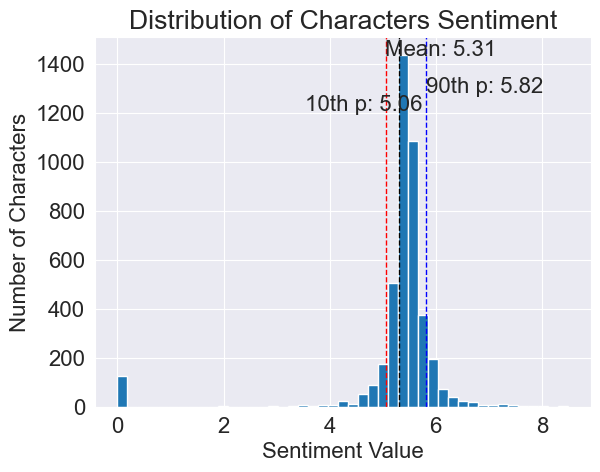

In [119]:

#make histogram 
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
sns.set_style("darkgrid")


plt.hist(all_values, bins =45)
plt.axvline(avg_of_list(all_values), color='k', linestyle='dashed', linewidth=1)
plt.axvline(tenth_p, color='r', linestyle='dashed', linewidth=1)
plt.axvline(ninety_p, color='b', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(avg_of_list(all_values)*0.95, max_ylim*0.95, 'Mean: {:.2f}'.format(avg_of_list(all_values)))
plt.text(tenth_p*0.70, max_ylim*0.8, '10th p: {:.2f}'.format(tenth_p))
plt.text(ninety_p*1, max_ylim*0.85, '90th p: {:.2f}'.format(ninety_p))
plt.title('Distribution of Characters Sentiment')
plt.xlabel('Sentiment Value')
plt.ylabel('Number of Characters')

plt.show()

In [120]:
episode_names = open(episode_numbers,'r').read()
episode_names = episode_names.splitlines(True)
formatted_epi_names = []
for episode in episode_names:
    formatted_epi_names.append(episode.replace('\n',''))
    
episode_sentiment = {'script_The_Tale_of_Scrotie_McBoogerballs.txt': 5.395284008156134, 'script_Informative_Murder_Porn.txt': 5.406962888159553, 'script_Ginger_Cow.txt': 5.468617992177312, 'script_Weight_Gain_4000.txt': 5.529657720731236, 'script_Medicinal_Fried_Chicken.txt': 5.397364720269036, 'script_Franchise_Prequel.txt': 5.491317957166394, 'script_Ginger_Kids.txt': 5.455820301393226, 'script_HUMANCENTiPAD.txt': 5.517590741714891, 'script_Raisins.txt': 5.5364046298528935, 'script_Fantastic_Easter_Special.txt': 5.4197478726756945, 'script_The_Return_of_the_Fellowship_of_the_Ring_to_the_Two_Towers.txt': 5.401243701328446, 'script_T.M.I..txt': 5.344355923435067, 'script_You_Got_F%27d_in_the_A.txt': 5.496160533178789, 'script_Margaritaville.txt': 5.380852144469525, 'script_Faith_Hilling.txt': 5.441131693198265, 'script_The_Succubus.txt': 5.457196593328597, 'script_Stanley%27s_Cup.txt': 5.411034063260348, 'script_Kenny_Dies.txt': 5.412046196334413, 'script_Mystery_of_the_Urinal_Deuce.txt': 5.377402731254832, 'script_World_Wide_Recorder_Concert.txt': 5.516407010710809, 'script_The_China_Probrem.txt': 5.360739566825139, 'script_Free_Willzyx.txt': 5.493304232804236, 'script_Red_Hot_Catholic_Love.txt': 5.441549540600947, 'script_Sexual_Healing.txt': 5.424245157866811, 'script_The_Problem_with_a_Poo.txt': 5.478610301263361, 'script_Eek,_A_Penis!.txt': 5.427247680629741, 'script_It%27s_Christmas_in_Canada.txt': 5.4921832952526115, 'script_Cancelled.txt': 5.44722007722007, 'script_How_to_Eat_with_Your_Butt.txt': 5.545609340792992, 'script_An_Elephant_Makes_Love_to_a_Pig.txt': 5.470782855118663, 'script_The_End_of_Serialization_as_We_Know_It.txt': 5.481643307638407, 'script_Douche_and_a_Danish.txt': 5.436971810520196, 'script_Shots.txt': 5.438200115008626, 'script_A_Ladder_to_Heaven.txt': 5.421783977476339, 'script_Super_Best_Friends.txt': 5.49459186019774, 'script_Mysterion_Rises.txt': 5.361873508353216, 'script_Time_To_Get_Cereal.txt': 5.381446212952786, 'script_Two_Guys_Naked_in_a_Hot_Tub.txt': 5.4479211779991354, 'script_Butters%27_Very_Own_Episode.txt': 5.484043900379905, 'script_Dances_with_Smurfs.txt': 5.474739913727489, 'script_A_Very_Crappy_Christmas.txt': 5.543296492071117, 'script_The_Big_Fix.txt': 5.497101943402657, 'script_Le_Petit_Tourette.txt': 5.432618982866472, 'script_It%27s_a_Jersey_Thing.txt': 5.389507150153223, 'script_Hooked_on_Monkey_Fonics.txt': 5.518209199159465, 'script_Broadway_Bro_Down.txt': 5.530271437384321, 'script_Go_God_Go.txt': 5.449510489510485, 'script_Sons_A_Witches.txt': 5.4231503305547655, 'script_The_Ungroundable.txt': 5.428011262596325, 'script_The_F_Word.txt': 5.419808405438811, 'script_SUPER_HARD_PCness.txt': 5.508852657004829, 'script_Where_My_Country_Gone%3F.txt': 5.430996230479266, 'script_The_Death_of_Eric_Cartman.txt': 5.436244933410544, 'script_The_Wacky_Molestation_Adventure.txt': 5.420175358688243, 'script_Child_Abduction_is_Not_Funny.txt': 5.432339944765245, 'script_Cartmanland.txt': 5.467856696521551, 'script_You_Have_0_Friends.txt': 5.54097604259095, 'script_AWESOM-O.txt': 5.571817359855345, 'script_The_Hobbit.txt': 5.460286288297335, 'script_Butt_Out.txt': 5.3453591160221015, 'script_Pandemic.txt': 5.458003203416977, 'script_South_Park_is_Gay!.txt': 5.487821576763487, 'script_Gnomes.txt': 5.494844142785312, 'script_Obama_Wins!.txt': 5.448054084192923, 'script_Cow_Days.txt': 5.525504587155968, 'script_Cartman_Gets_an_Anal_Probe.txt': 5.465642933049938, 'script_Mexican_Joker.txt': 5.439564860426925, 'script_Fort_Collins.txt': 5.427135922330095, 'script_Probably.txt': 5.395191256830593, 'script_Canada_on_Strike.txt': 5.515239494563629, 'script_Safe_Space.txt': 5.505787871098712, 'script_A_History_Channel_Thanksgiving.txt': 5.463907418056356, 'script_Chef%27s_Chocolate_Salty_Balls.txt': 5.511032847951239, 'script_Jewpacabra.txt': 5.415563764857051, 'script_Erection_Day.txt': 5.467179487179492, 'script_The_Biggest_Douche_in_the_Universe.txt': 5.480111696522653, 'script_I_Should_Have_Never_Gone_Ziplining.txt': 5.379304374240589, 'script_Over_Logging.txt': 5.454006838669568, 'script_Major_Boobage.txt': 5.429084354722422, 'script_Season_Finale.txt': 5.4208500727802065, 'script_Woodland_Critter_Christmas.txt': 5.414856365285763, 'script_Osama_bin_Laden_Has_Farty_Pants.txt': 5.377316954512285, 'script_Coon_vs._Coon_%26_Friends.txt': 5.385749334909847, 'script_Imaginationland,_Episode_II.txt': 5.365056480380503, 'script_Lice_Capades.txt': 5.365227803738312, 'script_Dead_Celebrities.txt': 5.390265108323834, 'script_Ass_Burgers.txt': 5.408204997450271, 'script_The_Last_of_the_Meheecans.txt': 5.420065316786405, 'script_Let_Them_Eat_Goo.txt': 5.498437862950059, 'script_Bebe%27s_Boobs_Destroy_Society.txt': 5.4767383945841415, 'script_Stupid_Spoiled_Whore_Video_Playset.txt': 5.50274829217025, 'script_The_Pandemic_Special.txt': 5.41798517705188, 'script_Smug_Alert!.txt': 5.478902060400802, 'script_Mecha-Streisand.txt': 5.444119718309858, 'script_1%25.txt': 5.3759186575654105, 'script_Sexual_Harassment_Panda.txt': 5.452699351930121, 'script_The_List.txt': 5.447638740661678, 'script_The_Mexican_Staring_Frog_of_Southern_Sri_Lanka.txt': 5.399454258675078, 'script_Wieners_Out.txt': 5.438247629991391, 'script_Summer_Sucks.txt': 5.440715302491099, 'script_Mr._Garrison%27s_Fancy_New_Vagina.txt': 5.454661333333335, 'script_Splatty_Tomato.txt': 5.439143686502172, 'script_Black_Friday.txt': 5.475314722149071, 'script_Tom%27s_Rhinoplasty.txt': 5.504232909379971, 'script_200.txt': 5.462517067379036, 'script_Band_in_China.txt': 5.468266356692129, 'script_Mr._Hankey,_the_Christmas_Poo.txt': 5.5385821484992075, 'script_Dead_Kids.txt': 5.375031830238727, 'script_Sarcastaball.txt': 5.503533604887979, 'script_Guitar_Queer-O.txt': 5.561399878271454, 'script_Insheeption.txt': 5.408789214415348, 'script_Spontaneous_Combustion.txt': 5.449292014302735, 'script_Fun_with_Veal.txt': 5.426398916967516, 'script_Casa_Bonita.txt': 5.450905538956562, 'script_201.txt': 5.465038690476183, 'script_Buddha_Box.txt': 5.4620538280637545, 'script_Not_Funny.txt': 5.419897435897433, 'script_Fatbeard.txt': 5.434259634888438, 'script_Oh,_Jeez.txt': 5.4635093072932435, 'script_Pinewood_Derby.txt': 5.441092552026292, 'script_Stunning_and_Brave.txt': 5.424340151302885, 'script_My_Future_Self_n%27_Me.txt': 5.438249949361954, 'script_Crack_Baby_Athletic_Association.txt': 5.474054870375024, 'script_Cash_For_Gold.txt': 5.498612548512297, 'script_Naughty_Ninjas.txt': 5.372375515382178, 'script_Lil%27_Crime_Stoppers.txt': 5.401372812920585, 'script_Miss_Teacher_Bangs_a_Boy.txt': 5.450491493383742, 'script_Ike%27s_Wee_Wee.txt': 5.381590759075902, 'script_Korn%27s_Groovy_Pirate_Ghost_Mystery.txt': 5.412298081213746, 'script_Cartman_Joins_NAMBLA.txt': 5.487811616271481, 'script_Cartman%27s_Silly_Hate_Crime_2000.txt': 5.356048602673137, 'script_Jakovasaurs.txt': 5.509591266818989, 'script_Go_God_Go_XII.txt': 5.444793165467626, 'script_I%27m_a_Little_Bit_Country.txt': 5.4061078794288635, 'script_Cartman%27s_Incredible_Gift.txt': 5.380626882014779, 'script_A_Nightmare_on_Face_Time.txt': 5.447824395665467, 'script_Grey_Dawn.txt': 5.387189436809476, 'script_Roger_Ebert_Should_Lay_off_the_Fatty_Foods.txt': 5.5107730756414535, 'script_Trapper_Keeper.txt': 5.3900120772946805, 'script_Are_You_There_God%3F_It%27s_Me,_Jesus.txt': 5.510254257615737, 'script_Poor_and_Stupid.txt': 5.39496395468589, 'script_A_Boy_And_A_Priest.txt': 5.49944141252006, 'script_The_Death_Camp_of_Tolerance.txt': 5.392685318029654, 'script_Two_Days_Before_the_Day_After_Tomorrow.txt': 5.382390313390311, 'script_The_Snuke.txt': 5.382911969940951, 'script_It_Hits_the_Fan.txt': 5.30876956417047, 'script_Taming_Strange.txt': 5.468907259106163, 'script_Best_Friends_Forever.txt': 5.407968263845673, 'script_City_People.txt': 5.568292922673654, 'script_Super_Fun_Time.txt': 5.393339057899893, 'script_Starvin%27_Marvin_in_Space.txt': 5.457275332117734, 'script_Do_the_Handicapped_Go_to_Hell%3F.txt': 5.358913365812322, 'script_City_on_the_Edge_of_Forever_(Flashbacks).txt': 5.413470588235289, 'script_With_Apologies_to_Jesse_Jackson.txt': 5.430203512684695, 'script_Members_Only.txt': 5.5039378238341845, 'script_Butterballs.txt': 5.409407826982491, 'script_The_Simpsons_Already_Did_It.txt': 5.446985839514491, 'script_Chef_Aid.txt': 5.544659702437474, 'script_Breast_Cancer_Show_Ever.txt': 5.373286237571946, 'script_Bloody_Mary.txt': 5.440437654830714, 'script_Fat_Camp.txt': 5.449354910714285, 'script_Fishsticks.txt': 5.523075562294666, 'script_Fat_Butt_and_Pancake_Head.txt': 5.528596709870388, 'script_Royal_Pudding.txt': 5.362718327183269, 'script_The_City_Part_of_Town.txt': 5.510014594279042, 'script_Terrance_and_Phillip_in_Not_Without_My_Anus.txt': 5.4453991528184975, 'script_Tweek_vs._Craig.txt': 5.4590465351542745, 'script_The_Jeffersons.txt': 5.5146855345911865, 'script_Moss_Piglets.txt': 5.531369824163362, 'script_Pinkeye.txt': 5.469079480940794, 'script_Up_the_Down_Steroid.txt': 5.4893512304250605, 'script_Tsst.txt': 5.500217548948507, 'script_Cr%C3%A8me_Fraiche.txt': 5.4919152004615, 'script_A_Scause_For_Applause.txt': 5.408098627351287, 'script_Cherokee_Hair_Tampons.txt': 5.457167974032997, 'script_Christian_Rock_Hard.txt': 5.57912840829644, 'script_Pre-School.txt': 5.397953233256351, 'script_Truth_and_Advertising.txt': 5.402987082884822, 'script_Back_To_The_Cold_War.txt': 5.416269497400345, 'script_Funnybot.txt': 5.479022209402939, 'script_Holiday_Special.txt': 5.450213504136629, 'script_Timmy_2000.txt': 5.465271069492353, 'script_Unfulfilled.txt': 5.4435391432791675, 'script_Cripple_Fight.txt': 5.492339908132938, 'script_Put_It_Down.txt': 5.404735582675281, 'script_Imaginationland,_Episode_III.txt': 5.3750073120795525, 'script_Turd_Burglars.txt': 5.466636017755236, 'script_Freak_Strike.txt': 5.459295806234584, 'script_Jewbilee.txt': 5.424894406392685, 'script_World_War_Zimmerman.txt': 5.3641336760925515, 'script_Cartman_Finds_Love.txt': 5.467242302543501, 'script_The_Coon.txt': 5.338940191387556, 'script_The_Passion_of_the_Jew.txt': 5.47040637450199, 'script_The_Return_of_Chef.txt': 5.519867344058703, 'script_The_Damned.txt': 5.423002528445012, 'script_You%27re_Not_Yelping.txt': 5.495688803512614, 'script_Towelie.txt': 5.399385176184692, 'script_Let_Go,_Let_Gov.txt': 5.466927172061335, 'script_Spookyfish.txt': 5.438214195503922, 'script_Clubhouses.txt': 5.525823563892149, 'script_Goobacks.txt': 5.4720892086331, 'script_White_People_Renovating_Houses.txt': 5.459367600346517, 'script_Tegridy_Farms.txt': 5.409126564673157, 'script_Night_of_the_Living_Homeless.txt': 5.325503538377795, 'script_Eat,_Pray,_Queef.txt': 5.498857709750561, 'script_Christmas_Snow.txt': 5.491153450051495, 'script_You%27re_Getting_Old.txt': 5.488202706956244, 'script_Conjoined_Fetus_Lady.txt': 5.539664591977869, 'script_Jared_Has_Aides.txt': 5.45595788509956, 'script_Chickenpox.txt': 5.475830860534124, 'script_The_Scoots.txt': 5.4433030303030305, 'script_Cartman%27s_Mom_is_Still_a_Dirty_Slut.txt': 5.43010008831323, 'script_Cartman_Sucks.txt': 5.470498848810447, 'script_Pip.txt': 5.473376853286122, 'script_Hell_on_Earth_2006.txt': 5.389671129220018, 'script_Board_Girls.txt': 5.537012549739821, 'script_Starvin%27_Marvin.txt': 5.494291139240507, 'script_Tweek_x_Craig.txt': 5.482283390678752, 'script_Tonsil_Trouble.txt': 5.403884297520659, 'script_Cartoon_Wars_Part_II.txt': 5.405922992900053, 'script_Bike_Parade.txt': 5.441313730779595, 'script_Douche_and_Turd.txt': 5.450271911298853, 'script_Free_Hat.txt': 5.487023155884456, 'script_The_Ring.txt': 5.510893122216726, 'script_The_Tooth_Fairy_Tats_2000.txt': 5.453721480843723, 'script_Tegridy_Farms_Halloween_Special.txt': 5.4366249999999985, 'script_The_Entity.txt': 5.416341049055003, 'script_Pee.txt': 5.392332048458148, 'script_Doubling_Down.txt': 5.450289814293762, 'script_Hummels_%26_Heroin.txt': 5.462163383919917, 'script_The_Poor_Kid.txt': 5.461704248753856, 'script_A_Million_Little_Fibers.txt': 5.448814705882356, 'script_Merry_Christmas_Charlie_Manson!.txt': 5.490299529311091, 'script_Fourth_Grade.txt': 5.446820888685295, 'script_ManBearPig.txt': 5.4033722546566585, 'script_Crippled_Summer.txt': 5.373861444022219, 'script_A_Song_of_Ass_and_Fire.txt': 5.431169451073982, 'script_Follow_That_Egg!.txt': 5.446367758186399, 'script_Credigree_Weed_St._Patrick%27s_Day_Special.txt': 5.45304399524375, 'script_Here_Comes_the_Neighborhood.txt': 5.562148115101495, 'script_Krazy_Kripples.txt': 5.44923868312757, 'script_Rainforest_Shmainforest.txt': 5.469628571428576, 'script_Help,_My_Teenager_Hates_Me!.txt': 5.451136363636369, 'script_Death.txt': 5.412095381149082, 'script_W.T.F..txt': 5.40450682056662, 'script_Die_Hippie,_Die.txt': 5.442542196831989, 'script_Wing.txt': 5.527596310363539, 'script_Something_Wall-Mart_This_Way_Comes.txt': 5.413262141603277, 'script_Whale_Whores.txt': 5.392828685258963, 'script_Skank_Hunt.txt': 5.503579447322973, 'script_Good_Times_with_Weapons.txt': 5.3856268292683, 'script_Bass_to_Mouth.txt': 5.387574931880103, 'script_Britney%27s_New_Look.txt': 5.400358208955223, 'script_Toilet_Paper.txt': 5.42414079687117, 'script_More_Crap.txt': 5.409158878504683, 'script_Nobody_Got_Cereal%3F.txt': 5.38670709677419, 'script_Pajama_Day.txt': 5.468432246998285, 'script_Insecurity.txt': 5.4427909133055214, 'script_Quest_for_Ratings.txt': 5.476332355294751, 'script_All_About_Mormons.txt': 5.47330759651308, 'script_Scott_Tenorman_Must_Die.txt': 5.462480278422274, 'script_Quintuplets_2000.txt': 5.428496821071757, 'script_Helen_Keller!_The_Musical.txt': 5.445045799528918, 'script_Member_Berries.txt': 5.451310652537654, 'script_About_Last_Night....txt': 5.407351471404781, 'script_Elementary_School_Musical.txt': 5.495932045613224, 'script_The_Losing_Edge.txt': 5.430014920919121, 'script_Raising_the_Bar.txt': 5.357210971545751, 'script_Red_Sleigh_Down.txt': 5.488972481696528, 'script_Chinpokomon.txt': 5.474108886718754, 'script_Titties_and_Dragons.txt': 5.450496338486578, 'script_Basic_Cable.txt': 5.48644912985275, 'script_Proper_Condom_Use.txt': 5.467646378153209, 'script_Make_Love,_Not_Warcraft.txt': 5.3990816019271275, 'script_Professor_Chaos.txt': 5.4625445590994275, 'script_Volcano.txt': 5.3750710702341165, 'script_Prehistoric_Ice_Man.txt': 5.417029343027779, 'script_Asspen.txt': 5.506882991556084, 'script_Chickenlover.txt': 5.491842978252857, 'script_Chef_Goes_Nanners.txt': 5.4606011819849085, 'script_Damien.txt': 5.496750939528529, 'script_Mr._Hankey%27s_Christmas_Classics.txt': 5.553162790697675, 'script_Marjorine.txt': 5.466460567823335, 'script_PC_Principal_Final_Justice.txt': 5.39471053302729, 'script_The_Red_Badge_of_Gayness.txt': 5.364298061812476, 'script_Imaginationland.txt': 5.359801980198019, 'script_City_Sushi.txt': 5.401208160663048, 'script_South_ParQ_Vaccination_Special.txt': 5.452109042229514, 'script_Going_Native.txt': 5.443693665300988, 'script_Cartman%27s_Mom_is_a_Dirty_Slut.txt': 5.542715127701375, 'script_Cat_Orgy.txt': 5.504351063829788, 'script_Sponsored_Content.txt': 5.451949685534584, 'script_Butters%27_Bottom_Bitch.txt': 5.490579596118548, 'script_D-Yikes!.txt': 5.452337372448973, 'script_The_New_Terrance_and_Phillip_Movie_Trailer.txt': 5.401542311191993, 'script_Reverse_Cowgirl.txt': 5.360236998025019, 'script_Red_Man%27s_Greed.txt': 5.541229418221727, 'script_Big_Gay_Al%27s_Big_Gay_Boat_Ride.txt': 5.4978828510938555, 'script_Trapped_in_the_Closet.txt': 5.4327908868999115, 'script_Something_You_Can_Do_with_Your_Finger.txt': 5.486308581211214, 'script_Cartoon_Wars_Part_I.txt': 5.460104596752007}
dict_keys = list(episode_sentiment.keys())

episode_names = []
episode_sent = []
for k,v in sorted(translated_episodes.items()):
    episode_names.append(k)
    episode_sent.append(v)

    
translated_episodes = {}
for epi_name in  dict_keys:
    for ano_epi_names in formatted_epi_names:
        if epi_name in ano_epi_names:
            translated_episodes[ano_epi_names] = episode_sentiment[epi_name]
            break

NameError: name 'translated_episodes' is not defined

In [ ]:
# Find out who talks the most in South Park
word_said_ch = {}
dir_ch_dialog = os.listdir("data/character_dialogs")
for ch_dialog in dir_ch_dialog[1:]:
    #print(ch_dialog)
    try:
        txt = open('data/character_dialogs/'+ ch_dialog,'r', encoding = "utf-8").read()
        cleaned_text = " ".join(re.findall(r'[a-zA-Z]+', txt)) 
        ls = nltk.word_tokenize(cleaned_text)
        word_said_ch[ch_dialog] = len(ls)
    except:
        print(ch_dialog)

In [ ]:
most_words_ch = dict(Counter(word_said_ch).most_common(25))
ch_names = list(most_words_ch.keys())
ch_words_said = list(most_words_ch.values())

In [ ]:
# make barplot of top talkers 
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(ch_names, ch_words_said, width = 0.5)
 
plt.xlabel("Characters")
plt.ylabel("No. of words said")
plt.title("Top 25 characters with the most dialog")
plt.xticks(rotation = 90) 
plt.show()

In [ ]:
ep = []
for n in range(len(episode_names)):
    ep.append(episode_names[n][:7])

step=list(range(0,len(ep),1))

In [ ]:
len(episode_sent)

In [ ]:
my_range=range(0, 301)
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(20,5))
(markers, stemlines, baseline) = plt.stem(episode_names, episode_sent, label="Sentiment for episode")
plt.setp(stemlines, visible=False)
plt.setp(baseline, visible=False)

#ax.set_xticks(np.arange(0, len(ep)+1, 5))

xticks = ax.xaxis.get_major_ticks()
for i,tick in enumerate(xticks):
    if i%10 != 0:
        tick.label1.set_visible(False)

ax.set_title('Sentiment pr episode')
ax.set_ylabel('Sentiment value')
ax.set_xlabel('Episode No.')
plt.xticks(step, ep, rotation = 90)
plt.ylim(5.2, 5.7)
plt.axhline(y=np.mean(episode_sent), linestyle='--', color='red', label="Avg Sentiment")
plt.legend(loc="upper left")
fig.tight_layout()
plt.show()

In [ ]:
data_dir = 'data'
celeb_character_list = open(f'{data_dir}/Celebrity_characters.txt', "r").read().split('\n')

ch = {'agent_12.txt': 5.490769230769231, 'elderly_man_on_motorcycle.txt': 5.92, '911_operator.txt': 4.867058823529412, 'tron_soldier.txt': 5.568571428571429, 'incredible_meat_founder.txt': 5.703984962406014, 'canadian_2.txt': 5.33, 'blond_girl.txt': 5.393333333333334, 'vape_rep.txt': 5.503716814159294, 'redneck_21.txt': 5.846666666666667, "garrison's_profile.txt": 5.953333333333333, 'matt.txt': 5.410614334470989, 'road_workers.txt': 5.275555555555556, 'munky.txt': 5.44936170212766, 'construction_worker.txt': 5.518775510204082, 'assemblyman_1.txt': 5.492500000000001, 'cleric_1.txt': 5.286666666666667, 'female_reporter_2.txt': 5.199999999999999, 'miss_information.txt': 5.529418181818182, 'the_situation.txt': 5.328952380952379, 'jakovasaur_boy.txt': 5.888, "unknown_caller's_daughter.txt": 4.7, 'mormon_3.txt': 0, 'man_2.txt': 5.458984812150278, 'fat_priest.txt': 5.248888888888889, "kyle's_side.txt": 0, 'priest.txt': 5.403692946058091, 'jennifer_lopez.txt': 5.392301075268814, 'male.txt': 5.2654545454545465, 'goodly.txt': 5.079999999999999, 'chef.txt': 5.489808440586652, 'paparazzo_11.txt': 5.743333333333333, 'fuhrman.txt': 5.480555555555556, 'smithy.txt': 5.316614173228349, 'mama.txt': 5.373508064516131, 'fat_abbot.txt': 5.056744186046514, 'the_nuggets.txt': 6.56, 'caller_3.txt': 5.227551020408164, 'apple_tech.txt': 5.456, 'dr.neeland.txt': 5.855555555555556, 'black_man.txt': 5.190909090909091, 'yelper_4.txt': 5.6066666666666665, 'boy_#1.txt': 5.6035087719298255, 'toothbrush.txt': 5.3478260869565215, 'news_reporter.txt': 5.45825327510917, "o'reilly.txt": 5.402105263157895, 'bobby_flay.txt': 5.600740740740741, 'lamb_chop.txt': 6.4125000000000005, 'newt_gingrich.txt': 5.854736842105264, 'viewer_1.txt': 4.702857142857143, 'middle_dwarf.txt': 5.444285714285714, 'worker_1.txt': 5.412954545454545, 'meagan.txt': 5.19076923076923, 'pueblo_team.txt': 6.06, 'greeter.txt': 5.514153846153849, 'gerald_sheila.txt': 0, 'clerk_3.txt': 5.605967741935483, 'miss_travis.txt': 5.595, 'male_2.txt': 5.639200000000001, 'patron_10.txt': 0, 'reenactor_3.txt': 5.9, 'representative.txt': 5.460337078651685, 'redneck.txt': 5.469, "gary_johnson's_profile.txt": 5.9799999999999995, 'dahmer.txt': 5.279917355371901, 'howard.txt': 5.533214285714284, 'townsmen.txt': 5.513333333333333, '911truth_man.txt': 5.3686854460093905, 'fans.txt': 5.685645161290323, 'teenager_1.txt': 5.3485106382978715, 'monitor_man.txt': 6.1, 'yourmomstits.txt': 5.23, 'fed.txt': 5.3999999999999995, 'attendant.txt': 5.408145695364238, 'mall_worker_7.txt': 5.545833333333332, 'partner.txt': 5.41081081081081, 'beefcake_cartman.txt': 5.5, 'other_goths.txt': 0, 'another_addict.txt': 5.77, 'fiancée.txt': 5.621511879049673, 'lion_2.txt': 5.425714285714286, 'mr._zewiski.txt': 5.327555555555555, 'techs.txt': 5.98, 'anchorwoman.txt': 5.17, 'townsman_8.txt': 5.261666666666666, 'resident_5.txt': 5.822222222222221, 'army_doctor.txt': 6.166666666666667, 'staffer_2.txt': 5.632666666666667, 'individual_in_crowd.txt': 6.06, 'peta_man.txt': 5.4048, 'ticket-taker.txt': 5.324583333333334, 'danish_woman.txt': 4.99, 'ryan_valmer.txt': 0, 'et_reporter.txt': 5.485454545454545, 'pirate_2.txt': 5.457777777777777, 'asian_reporter.txt': 5.461428571428572, 'agent_marx.txt': 5.508484848484849, 'elderly_man_4.txt': 5.216000000000001, 'two_small_voices.txt': 5.601481481481479, 'cashier.txt': 5.507515789473686, 'balding_man.txt': 5.500049627791556, 'the_broflovskis.txt': 5.619999999999999, '"kenny".txt': 5.2875, 'bob_and_audience.txt': 4.533333333333333, 'tricia.txt': 3.48, 'santa_claus.txt': 4.34, 'aging_hippie_liberal_douche.txt': 5.565357142857144, 'treasurer_2.txt': 5.668666666666667, 'whole_foods_rep.txt': 5.562639593908627, 'official_3.txt': 0, 'soldier_4.txt': 5.462352941176469, 'white_hare.txt': 5.3853846153846145, "tele's_owner.txt": 5.326666666666665, 'rick.txt': 5.433990783410141, 'retarded_fish.txt': 6.048, 'patron_1.txt': 5.53625, 'trooper.txt': 5.235882352941178, 'constance.txt': 5.685714285714285, 'natalie.txt': 5.395510204081634, 'dickinson.txt': 5.290967741935485, 'romanian_official.txt': 5.373772455089817, 'blonde_3.txt': 6.84, 'richie.txt': 5.3689743589743575, 'players.txt': 4.34, 'gerald.txt': 5.465336610895256, 'kids_around_kenny.txt': 0, 'sondheim.txt': 5.56265060240964, 'tourist.txt': 6.052, 'photographer.txt': 5.650154798761612, 'phil.txt': 5.5766407766990325, "jessica's_mom.txt": 5.480000000000001, 'coach_brady.txt': 5.185833333333334, 'supporter.txt': 3.8, 'townfolk.txt': 5.2457142857142856, 'blonde_2.txt': 5.595833333333332, 'dispatcher.txt': 5.543137254901961, 'karen.txt': 5.635468164794009, 'american_male_1.txt': 5.562105263157894, 'vendor.txt': 5.594545454545455, 'leader.txt': 5.4095, 'jack_brolin.txt': 5.034999999999998, 'nambla_member.txt': 5.988333333333333, 'mimsy.txt': 5.282857142857141, 'tad.txt': 5.50363636363636, 'stephen_stotch.txt': 5.253666666666667, 'mom.txt': 5.541666666666666, 'blacksmith.txt': 5.160000000000001, 'wrangler.txt': 5.481818181818183, 'mephesto.txt': 5.419766187050354, 'lucas.txt': 5.23, 'hispanic_reporter.txt': 5.369724137931035, 'brunette.txt': 5.46842424242424, 'soldier_5.txt': 7.3, 'official_2.txt': 5.224000000000001, 'treasurer_3.txt': 5.0691428571428565, 'mr._connolly.txt': 5.534431578947366, 'gordon.txt': 5.506666666666668, 'pentagon_employee.txt': 5.9, 'jimbo.txt': 5.393214487034943, 'bald_knight.txt': 4.98, 'teller.txt': 5.524905660377361, 'manson.txt': 5.470081433224758, 'm.c.txt': 5.701818181818182, 'kyle_stan.txt': 6.14, 'elderly_man_5.txt': 5.0166666666666675, 'magician.txt': 5.448181818181818, 'afghan_cartman.txt': 5.74, 'mediator.txt': 5.471428571428572, 'the_group.txt': 6.156, 'congregants.txt': 5.873333333333334, 'shari.txt': 5.843999999999999, 'collector.txt': 5.564761904761904, 'pirate_3.txt': 5.405882352941178, 'blond.txt': 5.575625000000003, 'kathie_lee_gifford.txt': 6.449999999999999, 'mimi.txt': 5.189230769230769, 'boss.txt': 5.327368421052631, 'enrique_iglesias.txt': 5.670967741935484, 'staffer_3.txt': 5.624374999999999, 'cowboy.txt': 5.602800000000001, 'all.txt': 5.461382978723407, 'resident_4.txt': 5.305565217391303, 'employee_1.txt': 5.168, 'townsman_9.txt': 5.096666666666667, 'dick_cheney.txt': 5.656000000000001, 'dr._schroeder.txt': 5.596106870229008, 'q_money.txt': 5.324705882352944, 'rob_reiner.txt': 5.389836494440808, 'nurse_gollum.txt': 5.4406024096385535, 'right_breast.txt': 5.404705882352941, 'fr._maxi.txt': 5.512449664429537, 'aarp_member_1.txt': 5.811999999999999, 'mr._billing.txt': 5.298124999999999, 'side_judge.txt': 5.237500000000001, 'army_general_2.txt': 5.237894736842105, 'mall_worker_6.txt': 5.679999999999999, 'dr._biber.txt': 5.481468401486984, 'somali_2.txt': 4.867272727272726, 'wally_b..txt': 5.562666666666668, 'otter_leader.txt': 5.461311475409836, 'dr._adams.txt': 5.564732824427475, 'violet_hare.txt': 4.616666666666666, 'alf_member.txt': 4.684, 'fort_collins_citizen_4.txt': 5.5488888888888885, 'the_ramseys_and_condit.txt': 5.533333333333334, 'dr._hallis.txt': 5.435853018372704, 'the_chevy_ad.txt': 5.798275862068966, 'reenactor_2.txt': 5.9, 'dc_crewman.txt': 5.064, 'military_officer.txt': 5.395555555555554, 'clerk_2.txt': 5.471971830985917, 'mrs._biggle.txt': 5.574307692307693, 'charles_biggens.txt': 5.477142857142857, 'fat_girl.txt': 5.6175999999999995, 'blaine.txt': 5.45935064935065, 'stan_kyle_kenny.txt': 5.497142857142857, 'towel.txt': 5.297499999999999, "girls'_table.txt": 5.8066666666666675, 'assemblywoman_2.txt': 5.370952380952382, 'goths.txt': 4.968, 'sally.txt': 5.509726443768997, 'blonde.txt': 5.603703703703704, 'jakovasaur_kid_4.txt': 4.455555555555555, 'a_troll.txt': 5.42, 'stage_hand.txt': 5.6404000000000005, 'randy_newman.txt': 5.496666666666665, 'tom_cruise.txt': 5.424163568773231, 'peg-leg.txt': 8.5, 'lady_judge.txt': 5.619999999999998, 'gordon_brown.txt': 5.407272727272728, 'uk_aide.txt': 5.486153846153846, 'afro_ninja.txt': 5.694545454545454, 'guide.txt': 5.37468309859155, 'italian_cardinal.txt': 5.435147679324893, 'denver_guard.txt': 5.465882352941177, 'paparazzo_10.txt': 5.381176470588237, 'teresa.txt': 5.37597402597403, 'caller_2.txt': 5.379411764705884, 'baker_2.txt': 5.452, 'connelly.txt': 5.553292682926824, 'random_voices.txt': 5.7, 'all_the_boys.txt': 6.14, 'stan_and_kenny.txt': 5.1, 'baby_jimmy.txt': 5.617142857142857, 'cows.txt': 5.300000000000001, 'a_few_others.txt': 5.9, 'man_3.txt': 5.430595238095235, 'mormon_2.txt': 5.6238596491228074, 'burly_man.txt': 5.2458333333333345, 'another_kid.txt': 4.24, 'mr._jarvis.txt': 5.333488372093023, 'kid_1.txt': 5.17128205128205, 'thomas_kyle.txt': 3.81, 'funbot.txt': 6.324, 'stan_kyle_butters.txt': 6.51, 'uncle_stinky.txt': 5.735555555555556, 'rand.txt': 5.284, 'redneck_20.txt': 5.091904761904761, 'lion_cub_1.txt': 5.634871794871795, 'lead_ginger.txt': 5.5666666666666655, 'aussie_crewman.txt': 5.833333333333333, 'babies.txt': 5.776923076923077, 'stocker.txt': 5.595294117647059, 'canadian_3.txt': 5.432307692307692, 'officer_10.txt': 5.185, 'mrs._farnickle.txt': 5.676938775510203, 'cheerleader_2.txt': 4.8133333333333335, 'mr._harrison.txt': 5.756923076923076, 'michael_douglas.txt': 3.54, 'theme.txt': 6.3999999999999995, 'members.txt': 5.767, 'canadian_1.txt': 5.407500000000001, '"droopy_dawg".txt': 5.086666666666667, 'cyclist.txt': 5.6579999999999995, 'agent_11.txt': 5.052000000000001, 'susan.txt': 5.462747252747254, 'native_american_chief.txt': 5.88952380952381, 'officer_jenkins.txt': 5.339295774647886, 'moses.txt': 5.5009259259259276, 'third_official.txt': 5.984705882352942, 'tooth_decay.txt': 5.221333333333334, 'lion_cub_3.txt': 5.147826086956522, 'redneck_22.txt': 5.311428571428571, 'galeed.txt': 5.341983471074381, 'topher.txt': 5.276419753086418, 'man_1.txt': 5.401617086193746, 'a_guest.txt': 5.3985714285714295, 'owners.txt': 4.8, 'siri.txt': 5.776666666666666, 'eddie.txt': 5.513333333333333, 'paul_harris.txt': 5.3713432835820925, 'french_delegate.txt': 5.4903703703703695, 'tracy.txt': 5.3853846153846145, 'lennart.txt': 5.494300000000002, 'dental_floss.txt': 5.069642857142858, 'kid_3.txt': 5.76, 'stephen_butters.txt': 5.535, 'assemblyman_2.txt': 5.396, 'cleric_2.txt': 4.711111111111111, 'creature.txt': 4.870909090909091, 'reporters.txt': 5.373000000000001, 'women.txt': 5.920000000000001, 'geoff_hamill.txt': 5.543558052434458, 'mannuel.txt': 5.635499999999999, 'blond_man.txt': 5.365714285714286, 'peter.txt': 5.436365979381445, 'kyle.txt': 5.429665961489239, 'danes.txt': 5.490666666666666, 'nobunaga.txt': 5.088148148148149, 'paparazzo_12.txt': 5.073333333333335, 'hbc_president.txt': 5.111726190476192, 'a_hippie.txt': 5.604210526315789, 'chief.txt': 5.425950704225352, 'first_mate.txt': 5.250000000000001, 'someone_in_the_crowd.txt': 7.78, 'hell_director.txt': 5.4152, 'chief_joe.txt': 5.366381578947368, 'zombie_mortician.txt': 6.183333333333334, 'guest.txt': 5.524556962025317, 'filmore.txt': 5.542531645569622, 'musician_3.txt': 6.74, 'jimmy_buffett.txt': 6.319999999999999, 'boy_#2.txt': 5.387368421052631, 'cher.txt': 5.423750000000001, 'president_bush.txt': 5.477212121212122, 'repairman_2_(kurt).txt': 5.383333333333333, 'border_guard.txt': 5.500000000000002, 'alien_man.txt': 5.5195294117647045, 'stephen.txt': 5.467031767041685, 'driver_5.txt': 4.984999999999999, 'guy_in_flat_top.txt': 5.446666666666666, 'jabs.txt': 5.440744680851064, 'worker_2.txt': 5.397202072538859, 'gates.txt': 5.417576530612246, 'lao_tzu.txt': 5.403076923076923, 'viewer_2.txt': 4.77, '_cartman.txt': 5.583157894736843, 'robert_redford.txt': 5.592313624678662, 'harrison_moore.txt': 5.386892857142855, 'hotline_voice.txt': 5.42357723577236, 'lucy.txt': 5.330943396226415, 'god.txt': 5.409827586206894, 'male_1.txt': 5.6035714285714295, 'davíd.txt': 5.665194805194805, 'mall_workers.txt': 5.58, 'jared_fogle.txt': 5.550769230769232, 'inmates.txt': 5.9, 'female_director_2.txt': 5.5, 'mona.txt': 5.15076923076923, 'elder_garth.txt': 5.425985401459847, 'el_presidente.txt': 5.371290322580646, 'garrison.txt': 5.400995316159261, 'harriet.txt': 5.478139534883723, 'clyde_kenny.txt': 5.9, 'injured_thief.txt': 4.286666666666666, 'john_ramsey.txt': 5.38455882352941, 'chris_swollenballs.txt': 5.311791907514451, 'lion_1.txt': 5.499487179487179, 'aarp_member_3.txt': 5.52625, 'producer.txt': 5.541842948717948, 'teenager_2.txt': 5.789090909090909, 'pence.txt': 5.363157894736842, 'mall_worker_4.txt': 5.343, 'ozzy.txt': 5.7379999999999995, 'mingie.txt': 5.361997563946403, 'captain_paul_watson.txt': 6.140000000000001, 'lead_alien.txt': 5.548437500000001, 'staffer_1.txt': 5.255862068965516, 'agent_9.txt': 5.208571428571429, 'jonbenét_ramsey.txt': 5.314545454545454, 'korn.txt': 5.453023255813952, 'bum_18.txt': 5.56, 'colleague.txt': 5.9, 'intruder.txt': 5.41375, 'music.txt': 5.906666666666666, 'milo.txt': 5.702222222222223, 'employee_3.txt': 5.454736842105263, 'resident_6.txt': 5.2, 'a_teen_boy.txt': 5.14, 'donald_trump.txt': 7.64, 'obese_woman.txt': 5.13, 'elderly_man_7.txt': 4.72, 'maury.txt': 5.50377622377622, 'louis.txt': 5.412666666666667, 'kobe_bryant.txt': 5.528478260869565, 'charlotte_poll_worker.txt': 5.580000000000001, 'pirate_1.txt': 5.909999999999999, 'guy_in_leather_jacket.txt': 6.5, 'farmers.txt': 4.727999999999999, 'efsm_president.txt': 5.382093023255815, 'adolf_hitler.txt': 4.77, 'doctor.txt': 5.392385347562742, 'veteran_guard.txt': 5.483040293040293, 'schwartz.txt': 5.381621621621622, 'comedian.txt': 5.518495575221239, 'puerto_rican_player.txt': 5.539999999999999, 'kathie_lee.txt': 6.034285714285713, 'ranger_mcfriendly.txt': 5.43186495176849, 'patron_2.txt': 5.378805970149255, 'jenny_mark.txt': 5.606, 'attendant_1.txt': 5.363863636363638, 'treasurer_1.txt': 5.329000000000001, 'lead_convict.txt': 5.5445, 'family.txt': 5.3514285714285705, 'damien.txt': 5.415884773662552, 'rosemary.txt': 5.398800000000001, 'skeeter.txt': 5.432349177330895, 'don_king.txt': 5.099454545454546, 'george_r._r._martin.txt': 5.480319634703193, 'ms._nelson.txt': 5.43, 'gigi.txt': 5.762727272727272, 'mr._jabs.txt': 5.283368421052633, 'woman_with_brown_hair.txt': 5.3123287671232875, 'lamont.txt': 5.473664459161146, 'tour_guide.txt': 5.479171461449938, 'sailor.txt': 5.786153846153846, 'chaos_#35.txt': 4.16, 'tom.txt': 5.394287577437237, 'richard_adler.txt': 5.3855813953488365, 'cow.txt': 5.359999999999999, 'hackman.txt': 5.441203703703702, 'american_male_3.txt': 5.44, 'a_fangirl.txt': 6.859999999999999, 'sharon_.txt': 5.3133333333333335, 'rabbi_4.txt': 5.124230769230769, 'kit-9.txt': 5.471764705882354, 'pooh.txt': 5.543968253968253, 'second_baseman.txt': 5.045, 'male_crew_1.txt': 5.083333333333333, 'police_chief.txt': 5.466187050359712, 'males.txt': 5.5, 'mr._adams.txt': 5.535610859728502, 'james_hetfield.txt': 5.3116666666666665, 'rabbi_5.txt': 5.215483870967742, 'other_women.txt': 5.712000000000001, 'translator.txt': 5.329259259259256, 'american_male_2.txt': 5.8725000000000005, 'tiger.txt': 5.385656108597285, 'pilgrim_king.txt': 5.322702702702702, 'soldier_6.txt': 6.295999999999999, 'official_1.txt': 5.284150943396226, 'network_president.txt': 5.401659388646292, 'patron_3.txt': 5.421666666666667, 'offier_bright.txt': 5.1080000000000005, 'anderson_cooper.txt': 5.480761904761907, 'bookie.txt': 5.525714285714286, 'ben_rothlisberger.txt': 5.426666666666667, 'peppa.txt': 5.451666666666667, 'sixth_grader.txt': 5.100833333333333, 'karin.txt': 5.560000000000002, 'citizen_2.txt': 4.883333333333334, 'dr._janus.txt': 5.380241423125794, 'kanye.txt': 5.476431746031746, 'research_leader.txt': 5.413098958333332, 'varashnu.txt': 5.821904761904762, 'damien_thorn.txt': 0, 'elderly_man_6.txt': 5.291250000000001, 'resident_7.txt': 5.281052631578947, 'employee_2.txt': 4.8, 'other_priests.txt': 5.6000000000000005, 'george_bush.txt': 5.194426229508198, 'mrs._faulk.txt': 5.468333333333334, 'gretchen.txt': 5.574999999999999, 'agent_8.txt': 5.339999999999999, 'heather_swanson.txt': 5.572093023255814, 'nichole_lola_annie.txt': 3.52, 'ranger.txt': 5.4610810810810815, 'british_cardinal.txt': 5.395510204081634, 'sophie_gray.txt': 5.69842105263158, 'mall_worker_5.txt': 5.256000000000001, 'paramedic.txt': 5.235164319248823, 'banker.txt': 5.402424242424242, 'teenager_3.txt': 5.135, 'stan_and_jesus.txt': 5.246666666666666, 'hobo.txt': 5.583200000000001, 'groundskeeper.txt': 4.8725000000000005, 'mummy.txt': 4.72, 'aarp_member_2.txt': 5.530000000000001, 'mrs._rodriguez.txt': 5.540000000000001, 'carlos_mencia.txt': 5.821428571428571, 'lady_2.txt': 5.614545454545455, 'honey_boo_boo.txt': 5.469032258064515, 'sparrow_prince.txt': 5.455523809523811, 'large_crip.txt': 5.7, "susan92's_profile.txt": 5.865714285714286, 'dj.txt': 5.6018893129770975, 'occupant.txt': 5.685, "grandma_marsh's_profile.txt": 6.1975, 'somali_1.txt': 0, 'sgt._boll.txt': 5.370666666666668, 'chip.txt': 5.50222222222222, 'clerk_1.txt': 5.710156250000002, 'rancher.txt': 5.469413919413919, 'neo.txt': 5.373026315789476, 'mayor_mcdanniels.txt': 5.348536585365854, 'bear_cub.txt': 0, 'reenactor_1.txt': 5.9, 'master.txt': 5.4662962962962975, 'taller_boy.txt': 5.509545454545454, 'viewer_3.txt': 5.0132, 'chubby_official.txt': 5.397801418439718, 'broderick.txt': 5.812258064516128, 'google_home.txt': 5.367500000000001, 'chef_actor.txt': 5.402857142857143, 'smithsonian_guard.txt': 5.3999999999999995, 'geldon.txt': 5.064, 'mosquito.txt': 5.535044247787612, 'driver_4.txt': 4.95, 'mrs._weatherhead.txt': 5.347968749999997, 'marksman.txt': 5.6032, 'worker_3.txt': 5.5152, 'p._sanchez.txt': 5.208, 'musician_2.txt': 4.769090909090909, 'marklar_dispatcher.txt': 6.086666666666666, 'janitor_2.txt': 4.8133333333333335, 'assemblywoman_1.txt': 5.427272727272729, 'amber.txt': 5.373725490196077, 'sheep.txt': 0, 'lion-head_alien.txt': 5.40421052631579, 'pat.txt': 5.53235457063712, 'george_lucas.txt': 5.349120879120881, 'others.txt': 5.520392156862743, 'female_reporter.txt': 5.56032786885246, 'detective.txt': 5.406478873239436, 'artsy_man.txt': 5.883636363636364, 'caller_1.txt': 4.973846153846154, 'mr._hat_actor.txt': 5.34, 'prime_minister.txt': 5.350681818181818, 'angel.txt': 5.275454545454545, 'newsman_2.txt': 5.4366666666666665, 'pimp.txt': 5.139883720930236, 'other_cardinals.txt': 5.1, 'kid_2.txt': 5.676666666666667, 'cleric_3.txt': 5.330869565217391, 'assemblyman_3.txt': 4.555, 'the_nerds.txt': 4.9, 'the_crowd.txt': 0, 'kevin_stoley.txt': 5.7075, 'mormon_1.txt': 5.818867924528303, 'bill_owens.txt': 5.520194986072423, 'corey.txt': 5.4207816091954015, 'ride_operator.txt': 4.858181818181818, 'another_boy.txt': 5.484444444444445, 'redneck_23.txt': 5.08909090909091, 'lion_cub_2.txt': 5.280392156862745, 'adults.txt': 5.6168627450980395, 'short_man.txt': 5.597037037037037, 'another_kindergartner.txt': 5.166666666666667, 'layman.txt': 5.354814814814815, 'truck_driver.txt': 5.356933333333335, 'ozzy_osbourne.txt': 5.619642857142856, 'wigger.txt': 5.269148936170213, 'dave.txt': 5.398, 'agent_10.txt': 5.4405882352941175, 'cheerleader_1.txt': 5.54, 'elephant_man.txt': 5.351037735849057, 'mrs._tweak.txt': 5.457295285359796, 'harvey_brown.txt': 5.3932960893854744, 'kids.txt': 5.459555555555555, 'chris.txt': 5.423613378983407, 'mr._garrsion.txt': 5.789, 'toodee.txt': 3.996, 'redneck_27.txt': 4.855, 'great-great-grandpa.txt': 5.219753086419755, 'standing_patron.txt': 5.562499999999999, 'pirate_ghost_cutout.txt': 5.96, 'cartman_on_left.txt': 5.56060606060606, 'george_zimmerman.txt': 5.655652173913045, 'canadian_4.txt': 5.293333333333334, 'official_messenger_boy.txt': 5.5248780487804865, 'tony_kornheiser.txt': 5.369206349206349, 'rick...txt': 5.270909090909091, 'the_wizard.txt': 5.655172413793103, 'linda_black.txt': 5.449508196721313, 'sorry.txt': 6.3525, 'bigwig_2.txt': 5.3469999999999995, 'craig_tucker.txt': 6.01, 'roy.txt': 5.616629834254143, 'heidi.txt': 5.463651266766024, 'man_on_wheelchair.txt': 5.753333333333334, 'followers.txt': 4.650909090909091, 'eugene.txt': 5.173333333333335, 'terrorists.txt': 5.424651162790697, 'mrs._sanders.txt': 5.712000000000001, 'governor.txt': 5.37543859649123, 'loogie.txt': 5.430015772870663, 'mormon_5.txt': 6.46, 'ron.txt': 5.33781914893617, 'man_4.txt': 5.393472584856395, 'rancer.txt': 5.216666666666667, 'norad_employees.txt': 0, 'pc_bro_18.txt': 5.98125, 'elton_john.txt': 5.558602150537637, 'jakovasaur_kid_3.txt': 0, 'cartman_(voiceover).txt': 5.7075000000000005, 'spectator_2.txt': 6.87, 'the_clergy.txt': 5.276363636363637, 'yelper_2.txt': 5.538095238095239, 'indian_ambassador.txt': 4.792, 'bulter.txt': 5.06, 'elderly_lady.txt': 5.682857142857143, 'a_teacher.txt': 5.06470588235294, 'fat_cop.txt': 5.561999999999999, 'scott_tenorman.txt': 5.525429362880884, "kid's_mom.txt": 5.253181818181818, 'man_in_barrel.txt': 5.485, 'workers.txt': 5.075, 'rider_9.txt': 4.73, 'kenny_mccormick.txt': 5.367692307692308, 'bradley.txt': 5.454596774193551, 'anonymous_821.txt': 5.138260869565216, 'vaping_man.txt': 5.381428571428572, 'gerald_broflovski.txt': 4.9472000000000005, 'clyde_donovan.txt': 5.557142857142857, 'ticket_teller.txt': 5.566666666666667, 'teenager_7.txt': 4.710000000000001, 'dentist.txt': 5.3373684210526315, 'vanessa.txt': 5.548444444444443, "lil'_qties_blonde_girl.txt": 5.522, 'mall_worker_1.txt': 5.360952380952381, 'felipe.txt': 5.114000000000001, 'stallone.txt': 5.443636363636364, 'spokesman.txt': 5.579565217391304, 'thad.txt': 5.142745098039216, 'thc_president.txt': 5.497097505668929, 'niles.txt': 5.400044510385754, 'paul.txt': 5.390000000000002, 'squirt_1.txt': 5.82, 'fort_collins_citizen_3.txt': 5.404444444444445, 'bum_9.txt': 5.34, 'wcb_president.txt': 5.559024390243902, 'contestant.txt': 5.506, 'elderly_man_2.txt': 5.133846153846152, 'pirate_4.txt': 5.418101265822785, 'rookie_guard.txt': 5.23, 'white_bailiff.txt': 4.926666666666667, 'news_anchor_2.txt': 5.092700000000001, 'resident_bishop.txt': 5.3, 'man_in_middle.txt': 5.536363636363636, 'dr._mepehsto.txt': 5.426666666666667, 'blond_knight.txt': 5.296190476190477, 'motorcycle_driver.txt': 5.473571428571428, 'seagal.txt': 5.615999999999999, 'resident_3.txt': 5.221290322580645, 'studio_audience.txt': 5.657499999999999, 'the_lords.txt': 6.08, 'jimbo:.txt': 5.755199999999999, 'patron_7.txt': 0, 'soldier_2.txt': 5.212786885245901, 'supervisor.txt': 5.277708333333334, 'a_reviewer.txt': 5.4639999999999995, 'other_soldiers.txt': 5.79111111111111, 'junichi.txt': 5.383316062176167, 'fc_announcer.txt': 5.766521739130434, 'taps.txt': 0, 'flight_attendant_1.txt': 5.737999999999999, 'mother.txt': 5.552411347517734, 'rabbi_1.txt': 5.329338521400777, 'bezos.txt': 5.470368509212724, 'funnybot.txt': 5.468475499092555, 'blonde_boy.txt': 6.06, 'camp_soldier.txt': 5.345384615384616, 'adams.txt': 5.467500000000003, 'adviser_2.txt': 4.953846153846153, 'mrs._galtman.txt': 4.25, 'persian.txt': 5.378571428571428, 'assistant.txt': 5.476421568627455, 'afghan_kenny.txt': 5.720000000000001, 'sixth_grade_leader.txt': 5.560864197530865, 'female_staffer.txt': 5.361999999999999, 'kfc_exec.txt': 5.368611111111111, 'another_owner.txt': 5.199999999999999, 'larsen.txt': 5.422619047619049, 'second_general.txt': 5.579761904761907, 'chief_of_security.txt': 5.413932038834952, 'janitor_farmer_1.txt': 5.441575342465756, 'blonde_judge.txt': 4.846666666666667, 'aa_speaker.txt': 5.7299999999999995, 'bruce.txt': 5.5120560747663525, 'red_annie.txt': 3.52, 'jim_rome.txt': 5.482229102167184, 'another_cardinal.txt': 5.526000000000001, 'lead_knight.txt': 5.169226519337018, 'nambla_leader.txt': 5.653451957295373, 'christina_aguilera_monster.txt': 5.2387500000000005, 'member.txt': 5.623333333333334, 'surgeon_general.txt': 5.307848101265821, 'yamal.txt': 4.840454545454546, 'mayor_mcdaniels.txt': 5.517644859813083, 'other_mothers.txt': 5.397777777777779, "mcdonald's_exec.txt": 5.426779026217228, 'female_director.txt': 5.538461538461538, 'mr._brooks.txt': 5.422499999999999, 'bearded_man.txt': 5.427252747252748, 'voguing_skier.txt': 5.0040000000000004, 'roadie_2.txt': 5.731666666666666, 'blue_horse_on_tv.txt': 5.983333333333333, 'all_four.txt': 5.9, 'preschoolers.txt': 5.9, 'tape.txt': 5.522666666666668, 'soldier_3.txt': 5.420000000000001, 'shvek.txt': 5.414326923076922, 'stan_kyle__kenny.txt': 5.98, 'headless_horseman.txt': 5.218333333333334, 'researcher.txt': 5.370698529411763, 'jim.txt': 5.427620967741939, 'randy_stan.txt': 5.622857142857143, 'patron_6.txt': 5.832, "driver_3's_passenger.txt": 5.390769230769232, 'odd_boy.txt': 5.490799999999999, 'senators.txt': 5.34, "kenny's_teenager.txt": 5.496129032258064, 'canadian_kid_1.txt': 5.696666666666666, 'resident_2.txt': 5.74, 'goateed_man.txt': 5.66, 'shelly.txt': 5.435025380710657, 'trolltrace_employee.txt': 5.292592592592594, 'mr._mcarthur.txt': 5.362666666666667, 'german_2.txt': 4.6739999999999995, 'advisor.txt': 5.4165217391304346, 'michael_moore.txt': 5.484545454545454, 'pirate_5.txt': 5.437435897435898, 'elderly_man_3.txt': 5.4799999999999995, 'rudy.txt': 4.969565217391304, 'girl.txt': 5.352625368731563, 'person.txt': 5.387345132743364, 'aguilar.txt': 5.48, 'ual_aide.txt': 5.594285714285713, 'gunsmith.txt': 5.424571428571429, 'fort_collins_citizen_2.txt': 5.763333333333333, 'john_travolta.txt': 5.333235294117649, 'dale_earnhardt_jr..txt': 5.54, 'pc_girl.txt': 5.876, 'lumberjack.txt': 5.6987499999999995, 'mamsie.txt': 5.599333333333332, 'bum_8.txt': 5.403846153846152, 'mr._standish.txt': 5.380909090909091, 'damned_soul.txt': 4.730909090909091, 'classi.txt': 5.146125000000004, 'muscleman_marc.txt': 5.5147619047619045, 'tiger_woods.txt': 4.569999999999999, 'tv_crew_director.txt': 5.326249999999999, 'elderly_woman_in_wheelchair.txt': 5.415555555555555, 'narrator_.txt': 5.256842105263158, 'milly_larsen.txt': 5.506666666666667, 'teenager_6.txt': 4.6, 'the_coon.txt': 5.324387583892614, 'alf_leader.txt': 5.489890109890108, 'broker.txt': 5.676000000000002, 'aide_1.txt': 5.4320903954802295, 'head_of_programming.txt': 5.446988636363636, 'large_woman.txt': 5.362926829268292, 'kelly_rutherford-menskin.txt': 5.42, 'fc_batter_1.txt': 6.38, 'third_graders.txt': 5.293333333333334, 'ms._mccormick.txt': 5.597777777777777, 'lisa.txt': 5.604533898305085, 'driver_1.txt': 5.316338028169016, 'romper_stomper.txt': 5.4643610547667345, 'lady_member.txt': 5.4297461928934005, 'caitlyn_jenner.txt': 5.456923076923076, 'clerk_4.txt': 5.641811023622046, 'elmo.txt': 5.558965517241381, 'clinton.txt': 5.373229166666666, 'fox_11_anchor.txt': 5.507878787878785, 'reenactor_4.txt': 5.9, 'doctor_lout.txt': 5.454705882352941, 'talent_scout.txt': 5.754000000000001, 'rider_8.txt': 5.008333333333333, 'terrance.txt': 5.50884987893462, 'bar_patrons.txt': 7.46, 'male_aide_1.txt': 5.403333333333333, 'ms._veronica_crabtree.txt': 4.906666666666666, 'jason.txt': 5.378004535147392, 'tea_bag_participant.txt': 5.268947368421053, 'eric.txt': 3.9, 'president_hirohito.txt': 5.445836065573773, 'cartman_brady.txt': 4.986363636363637, "billy's_mom.txt": 5.221000000000001, 'yelper_3.txt': 5.761538461538461, 'jakovasaur_kid_2.txt': 6.58, 'jesus_christ.txt': 5.68060606060606, 'bums.txt': 5.542857142857143, 'mrs._streibel.txt': 6.32, 'joe_strummer.txt': 5.417222222222221, 'unnamed_woman_#1.txt': 5.291111111111113, 'male_member.txt': 5.9, 'athlete.txt': 5.8828571428571435, 'pc_bro_19.txt': 5.43, 'boys_1_2.txt': 5.768571428571429, 'barack_obama.txt': 5.96, 'roma.txt': 5.56344827586207, 'man_5.txt': 5.382839506172843, 'mormon_4.txt': 5.442105263157895, 'delivery_express_man.txt': 5.578202247191013, 'middle_prostitute.txt': 5.326666666666667, 'wing.txt': 5.923076923076922, 'snn_anchor.txt': 5.357635467980296, 'publicist_#1.txt': 5.333076923076923, 'tucker.txt': 5.498933333333332, 'real_mackey.txt': 5.146, 'suzanne.txt': 6.1899999999999995, 'neely_davis.txt': 6.2, 'cartman.txt': 5.450654804783188, 'annoncer.txt': 5.791052631578948, 'canadian_5.txt': 5.5, 'snetzl.txt': 5.2637908496732, 'instructors.txt': 5.1025, 'frog_king.txt': 5.392417302798978, 'archbishop.txt': 5.356448598130841, 'rabbi.txt': 5.397866666666668, 'kevin_jonas.txt': 0, 'mr._conners.txt': 5.333170163170167, 'redneck_26.txt': 4.7299999999999995, 'blonde_peta_woman.txt': 5.3583783783783785, 'pastor_phillips.txt': 5.463440860215055, 'butter.txt': 5.666666666666667, 'redneck_24.txt': 5.659999999999999, 'stan_cartman.txt': 5.261538461538462, 'redneck_30.txt': 2.9, 'det._yates.txt': 5.349456066945605, 'redneck_18.txt': 0, 'grandma.txt': 5.62617142857143, 'patty.txt': 5.301250000000001, 'canadian_7.txt': 5.768000000000001, 'butters_.txt': 5.575789473684211, 'expert_10.txt': 5.637391304347826, "bill_o'reilly.txt": 5.6113725490196105, 'voice-over.txt': 5.488624641833809, 'bigwig_1.txt': 5.348437499999999, 'female_driver.txt': 7.346666666666668, 'receptionist_2.txt': 5.448888888888889, 'phillip.txt': 5.451904761904762, 'robot_monkey.txt': 0, 'evil_cartman.txt': 5.521752873563221, 'the_adults.txt': 5.484999999999999, 'some_townsfolk.txt': 6.22, 'kid_5.txt': 5.193333333333333, 'unnamed_woman_#3.txt': 5.470000000000001, 'assemblyman_4.txt': 5.374999999999999, 'betsy_macintosh.txt': 5.421538461538461, 'teenagers.txt': 4.716666666666667, 'mormon_6.txt': 5.2663157894736825, 'some_people.txt': 5.84, 'man_7.txt': 5.448193832599116, 'yelper_1.txt': 5.5, 'chet.txt': 5.480654205607479, 'mrs._turner.txt': 5.662549019607843, 'kris.txt': 5.467692307692308, 'buds_man.txt': 5.535263157894736, 'professor_chaos.txt': 5.363838120104435, 'the_south_park_boys.txt': 7.46, 'hyde.txt': 5.1544444444444455, 'plex.txt': 5.530046511627909, 'wrestler.txt': 5.525454545454545, 'official.txt': 5.440336700336699, 'camp_warden.txt': 5.397961165048544, 'mrs._miller.txt': 5.460060240963855, 'towelie_clone.txt': 4.07, 'the_colonel.txt': 5.371369863013698, 'deery_deer.txt': 5.446153846153847, 'ghost.txt': 5.130731707317073, 'stan_kenny_kyle.txt': 5.05875, 'cardinal.txt': 5.354166666666667, 'friend.txt': 5.3028571428571425, 'prof._thomas.txt': 5.39116104868914, 'a_director.txt': 4.933333333333334, 'mr._adler.txt': 5.46567474048443, 'the_others.txt': 5.925714285714285, 'agents.txt': 5.31, 'mccain.txt': 5.422186495176847, 'driver_3.txt': 5.38, 'purpleheadedqueeflicker.txt': 5.591111111111112, 'publicist.txt': 5.601621621621623, 'farmer_2.txt': 4.789411764705882, 'worker_4.txt': 5.460434782608695, 'teenager_4.txt': 5.127999999999999, 'emily.txt': 5.602666666666667, 'mall_worker_2.txt': 5.494285714285715, 'a_townsman.txt': 5.14, 'aide_3.txt': 5.35390977443609, 'director_10.txt': 5.470000000000001, 'carrot_ass.txt': 5.555675675675675, 'mr._hollis.txt': 5.4830000000000005, 'squirt_2.txt': 5.660000000000001, 'other_psychics.txt': 5.9, 'pirate_7.txt': 5.62, 'emir.txt': 5.530283018867925, 'news_anchor_1.txt': 5.6896774193548385, 'mrs._trumski.txt': 5.397142857142858, 'danica_patrick.txt': 5.413846153846153, 'bearded_peta_member.txt': 5.442704918032788, 'marty.txt': 5.544105263157896, 'ensign.txt': 5.553333333333334, 'train_conductor.txt': 5.431627906976745, 'tad_and_friends.txt': 0, 'elderly_man_1.txt': 5.282682926829268, 'press_coordinator.txt': 5.743846153846154, 'confederate_reenactors.txt': 5.9, 'blood.txt': 5.281960784313727, 'really_shocked_man.txt': 5.5373913043478264, 'the_dragon.txt': 5.508676470588238, "farty_o'cool.txt": 5.413125000000001, 'soldier_1.txt': 5.292340425531915, 'patron_4.txt': 5.9, 'female_agent_2.txt': 5.471333333333334, 'lead_referee.txt': 5.24, 'the_class.txt': 5.411739130434781, 'mr_garrison.txt': 5.38, 'flight_attendant_2.txt': 6.0840000000000005, 'dr._katz.txt': 5.593333333333335, 'both_kyles.txt': 6.56, 'mabel.txt': 5.62421052631579, 'gruff_worker.txt': 5.341832061068705, 'geraldo.txt': 5.416751592356689, 'stormy.txt': 5.2260698689956335, 'sixth_graders.txt': 5.064, 'goodell_and_the_officials.txt': 0, 'pinkerton.txt': 5.51822222222222, 'leader_turkey.txt': 0, 'unknown_caller.txt': 5.390476190476191, 'rabbi_2.txt': 5.391818181818182, 'driver.txt': 5.444294234592441, 'dimitri.txt': 5.509090909090909, 'denver_citizens.txt': 0, 'elvin.txt': 5.261875, 'mel_gibson.txt': 5.349245283018868, 'sandy_cervix.txt': 5.533517241379309, 'mr._slave.txt': 5.452322274881516, 'cinderella.txt': 4.846410256410257, 'tom_green.txt': 5.505, 'water_tester.txt': 5.365686274509808, 'adviser_1.txt': 5.376153846153846, 'dr._wayne_schroeder.txt': 5.491346153846154, 'raisins_girls.txt': 5.478000000000001, 'richard_tweak.txt': 5.700188679245281, 'stan_marsh.txt': 5.3375, 'casey_miller.txt': 5.72184210526316, 'pharmacist.txt': 5.431601941747576, 'dc_crew.txt': 5.476190476190477, 'cop.txt': 5.708, 'cipac.txt': 5.6085714285714285, 'ethiopians.txt': 5.203829787234042, 'stranger.txt': 5.268333333333333, 'lamond.txt': 5.465655021834064, 'deck_hand.txt': 5.2575, 'mr._tumnus.txt': 5.907500000000001, 'blond_member.txt': 5.267142857142858, 'rabbi_3.txt': 5.328987341772152, 'dean.txt': 5.483566621803496, 'dr._bender.txt': 5.456934306569344, 'lady_protester.txt': 5.553181818181819, 'judge_moses.txt': 5.197631578947368, 'captain.txt': 5.330843881856534, 'wendy.txt': 5.457431929772356, 'cruise_travolta.txt': 5.226315789473685, 'u.n._leader.txt': 5.388148148148146, 'the_family.txt': 5.989230769230769, 'caityln.txt': 5.339999999999999, 'perseus.txt': 5.245333333333336, 'dawson.txt': 5.364593639575968, 'aarp_members.txt': 6.0920000000000005, 'guard.txt': 5.3821911037891255, 'flight_attendant_3.txt': 5.948333333333333, 'hotforboys219.txt': 5.42802197802198, 'editor.txt': 5.468095238095237, 'strikers.txt': 5.245333333333332, 'various_adults.txt': 3.55, 'chase.txt': 5.481081081081081, 'patron_5.txt': 5.6899999999999995, 'stout_man.txt': 5.84, 'roger_goodell.txt': 5.944999999999999, 'jogger.txt': 5.653461538461538, 'other_boys.txt': 5.377142857142857, 'stormtrooper.txt': 5.739999999999999, 'german_1.txt': 5.47, 'dean_ween.txt': 5.715454545454545, 'resident_1.txt': 5.445804195804195, 'auxiliary.txt': 5.499571694599626, 'gnome.txt': 5.4662162162162184, 'donald_t._brown.txt': 5.4, 'canadian_kid_2.txt': 5.32, 'ho.txt': 5.68, "gerald's_review.txt": 5.241800000000003, 'kyle_towelie.txt': 6.08, 'emmanuel_lewis.txt': 5.1859793814433, 'crips.txt': 5.503333333333334, 'thom.txt': 5.294285714285717, 'car_salesman.txt': 5.595000000000001, 'pirate_6.txt': 5.765333333333333, 'cleetus.txt': 5.592727272727274, 'walter.txt': 5.3469999999999995, 'dick.txt': 5.475899209486164, 'gloria_allred.txt': 5.422666666666666, 'sixth_graders_2_and_3.txt': 5.22, 'fort_collins_citizen_1.txt': 5.201818181818183, 'blind_man.txt': 5.72, 'walter_cronkite.txt': 5.143333333333333, 'mephesto_tryout.txt': 4.962857142857142, 'mr._hankey.txt': 5.492683210546712, 'aide_2.txt': 5.4671197411003245, 'ike_supporter.txt': 5.79, 'stan_kenny__cartman.txt': 5.0484210526315785, 'mall_worker_3.txt': 5.517999999999999, 'teenager_5.txt': 4.58, 'boy_announcer.txt': 5.44375, 'man_with_afro.txt': 5.76, 'driver_2.txt': 5.542236842105265, 'human_wendy.txt': 5.2821428571428575, 'singer.txt': 5.516792452830189, 'an_old_farmer.txt': 5.305443037974682, 'yelpers.txt': 5.670476190476189, 'mr._hakeem.txt': 5.38561797752809, 'house.txt': 5.682916666666667, 'dream_estella.txt': 5.828, 'crab_solo.txt': 6.708, 'tumon.txt': 5.423617021276597, 'lead_agent_collins.txt': 5.518666666666666, 'old_man_2.txt': 5.565925925925925, 'tv_oh.txt': 5.666666666666667, 'latino_protesters.txt': 0, 'build-a-bear_workshop_employee.txt': 5.753333333333334, 'a_pilot.txt': 5.381111111111111, 'elise.txt': 5.6244785276073594, 'a_quint.txt': 5.561891891891892, 'male_aide_2.txt': 5.12, 'warden.txt': 5.316186770428018, 'mrs._joe.txt': 5.403999999999998, 'chris_crocker.txt': 5.237692307692309, 'fat_plumber.txt': 4.8475, 'somebody.txt': 7.28, 'jakovasaur_kid_1.txt': 5.456666666666667, 'hooded_figure.txt': 5.3919298245614025, 'man_6.txt': 5.514823529411768, 'surgeon.txt': 5.759000000000002, 'steve.txt': 5.51291702309667, 'the_avs.txt': 6.22, 'incredibly_obese_black_man.txt': 5.23, 'white_official.txt': 5.564375, 'kid_4.txt': 5.484705882352941, 'televangelist.txt': 5.515555555555554, 'prayers.txt': 5.5025, 'pilot.txt': 5.452262773722626, 'barkeep.txt': 5.348967391304349, 'patrick.txt': 5.680714285714286, 'expert_11.txt': 4.936153846153847, 'alec.txt': 5.382727272727272, 'the_guys.txt': 6.74, 'café_monet_diner.txt': 5.316666666666667, 'stan_jesus.txt': 0, 'canadian_6.txt': 5.067692307692308, 'gail.txt': 5.849090909090908, 'radio_reporter.txt': 5.382592592592592, 'aussie.txt': 5.355086848635233, 'cartmam.txt': 5.233750000000001, 'steamy_nicks.txt': 6.132499999999999, 'redneck_19.txt': 5.287647058823529, 'firkle.txt': 5.196862745098039, 'stan_kyle_kenny_cartman.txt': 5.3525, 'dna_test_administrator.txt': 5.4752508361203995, 'other_bikers.txt': 5.388571428571429, 'soldiers.txt': 5.311733333333334, 'little_girl.txt': 5.646666666666668, 'girl_with_brown_coat.txt': 6.034999999999999, 'bat_dad.txt': 5.469999999999999, 'female_jogger.txt': 4.15, 'sports_reporter.txt': 5.526666666666666, 'redneck_25.txt': 5.62, 'simply_heidi.txt': 5.4908805031446555, 'frank_hammond.txt': 5.872173913043478, 'shopper_1.txt': 5.32111111111111, 'secret_service_leader.txt': 5.276, 'garrison_1.txt': 5.789090909090909, 'male_#occupy_mars_spacex_worker.txt': 5.534606741573035, 'male_diner.txt': 5.696190476190476, 'director_3.txt': 5.523149606299211, 'coroner.txt': 5.10098901098901, 'matthew.txt': 5.209090909090909, 'unknown_person.txt': 5.84, 'a_singer.txt': 6.4879999999999995, 'mephesto_actor.txt': 5.145714285714285, 'disney_exec_2.txt': 5.702857142857143, 'hancock.txt': 5.372777777777777, 'heather.txt': 5.543014416775878, 'mr._mackey_jr..txt': 5.337333333333333, 'av_2.txt': 5.9, 'evgames_clerk.txt': 5.627, 'orlich.txt': 5.339134615384613, 'sixth_grader_1.txt': 5.252574257425745, 'teen_boy_3.txt': 5.262105263157895, 'reenactor.txt': 4.792, 'jewish_kid.txt': 5.183333333333333, 'leprechaun.txt': 5.283684210526317, 'student_3.txt': 2.02, 'attorney.txt': 5.431117216117215, 'mrs.white.txt': 5.566666666666666, 'farmer_carl_denkins.txt': 5.109999999999999, 'pc_bro_8.txt': 5.23142857142857, 'scientist_2.txt': 5.478805970149254, 'luke.txt': 5.398604651162791, 'neighbor.txt': 5.366753246753246, 'quincy.txt': 5.474527027027027, 'melissa.txt': 5.8514285714285705, 'unnamed_man_5.txt': 4.725, 'kyle_stan_cartman.txt': 0, 'lola_jenny_red_and_wendy.txt': 5.08, 'colleague_2.txt': 5.758333333333334, 'bald_convict.txt': 5.017297297297297, 'the_wise_one.txt': 5.437733333333332, 'nelly.txt': 5.323566878980891, 'puffy_the_bear.txt': 6.28, 'dane_8.txt': 5.414666666666666, 'man_with_burgundy_coat.txt': 5.265641025641025, 'pregnant_mexican_women.txt': 4.78, 'sharon_stan_shelley.txt': 4.795, 'woman_7.txt': 5.32, 'butt_out!_man_1.txt': 5.288181818181818, 'boy_in_blue_vest.txt': 5.300923076923078, 'officer_9.txt': 5.03, 'mrs._testaburger.txt': 5.4409405940594056, 'hobby_employee.txt': 6.52, 'vivian.txt': 5.930000000000001, 'tolkien_black.txt': 3.8, 'blonde_girl.txt': 5.462848484848485, "kid's_voice.txt": 7.17, 'hippie_1.txt': 5.507741935483871, 'general_revaur.txt': 5.269729729729729, 'man_19.txt': 4.57, 'brett.txt': 5.708461538461542, 'weird_hat_guy.txt': 5.591428571428572, '600_crew.txt': 5.309230769230769, 'people_in_audience.txt': 4.9719999999999995, 'man_31.txt': 4.57, 'squirt.txt': 5.440312499999999, 'uncle_howard.txt': 5.346000000000001, 't-shirt_vendor.txt': 5.949999999999999, 'paris.txt': 5.422519863791149, 'female_agent.txt': 5.665000000000001, 'city_man_2.txt': 4.5600000000000005, 'peter_galtman.txt': 5.58404761904762, 'man_25.txt': 4.57, 'jimbo_kern.txt': 5.707142857142857, 'iraqi_man_1.txt': 4.85, 'sid_greenfield.txt': 5.551428571428572, 'teen_girl_1.txt': 5.577714285714285, 'carlos.txt': 5.7700000000000005, 'other_officers.txt': 5.721, 'doi_1.txt': 5.469954751131222, 'eager_man.txt': 0, 'black_woman.txt': 5.170000000000001, 'nelson.txt': 5.400933852140075, "butt_out!'s_kyle.txt": 5.082738095238096, 'rumpertumskin.txt': 5.207159090909091, 'thin_plumber.txt': 5.346153846153846, 'norad_man_1.txt': 5.136923076923077, 'tay_zonday.txt': 5.314966887417219, 'girl_in_o_t-shirt.txt': 5.405714285714285, 'r._wiley.txt': 5.449655172413795, 'michael_chertoff.txt': 5.4383407407407365, 'clone_stan.txt': 4.765714285714286, 'bobo.txt': 5.201428571428573, 'mr._garrett.txt': 5.537500000000002, 'steve_forbes.txt': 5.183870967741936, 'mr._ose.txt': 5.396255924170616, "jesus'_producer.txt": 5.748163265306123, 'other_nambla_men.txt': 4.386666666666667, 'other_acts.txt': 5.9, 'local_announcer_1.txt': 5.684444444444444, 'voice_2.txt': 5.505714285714286, 'drummer.txt': 5.1066666666666665, 'guest_1.txt': 5.7584, 'swat_officer_2.txt': 5.521086956521741, 'stewie.txt': 5.43, 'blood_2.txt': 4.757142857142857, 'teen_mc.txt': 5.815555555555556, 'lola.txt': 5.478869565217393, 'expert_8.txt': 5.5, 'principal.txt': 5.472976190476191, 'townsman_10.txt': 5.0238095238095255, 'stan.txt': 5.444006318843405, 'vicky.txt': 5.528285714285715, 'townsperson_1.txt': 5.204, "butt_out!'s_randy.txt": 5.357377049180328, 'mel.txt': 5.471466666666667, 'mr._president.txt': 5.325393258426967, 'rosie.txt': 5.395555555555557, 'townsman_11.txt': 6.14, 'the_other_four_(except_timmy).txt': 0, 'all_three.txt': 5.516666666666667, 'expert_9.txt': 5.502942779291555, 'david.txt': 5.420239390642004, 'jefferson.txt': 5.21890410958904, 'canadian_pm.txt': 5.4847802197802205, 'midnight_vampire.txt': 5.46, 'fillmore.txt': 5.278, 'steven_seagal.txt': 5.474759358288772, 'thin_cop.txt': 5.6310638297872355, 'blood_3.txt': 4.992, 'priest_maxi.txt': 5.409065375302665, 'davis.txt': 5.393181818181816, 'swat_officer_3.txt': 5.21578947368421, 'brunet_trekker.txt': 5.391000000000001, 'molly.txt': 7.4, 'boy_sledders.txt': 6.103333333333333, 'female_inspector.txt': 5.743636363636363, 'xenu.txt': 5.397647058823529, 'ishmael.txt': 7.44, 'tsa_agent_1.txt': 5.397142857142858, 'senator_4.txt': 5.236470588235295, '#_10.txt': 5.109000000000001, 'martin.txt': 5.448620689655173, 'strong_woman.txt': 5.483292422625394, 'new_kenny.txt': 4.999230769230769, 'geologist_1.txt': 5.136363636363638, 'sawitsky.txt': 5.406806722689076, 'crip.txt': 5.025862068965517, 'player_6.txt': 5.02, 'israeli.txt': 5.514000000000001, 'kanye_west.txt': 3.606666666666667, 'network_anchor.txt': 5.102, 'demi_lovato.txt': 5.6089655172413755, 'pioneer_paul.txt': 5.380521541950113, 'canadian_paparazzo.txt': 5.077931034482758, 'blonde_peta_member_2.txt': 5.479310344827585, 'ginger_boy_2.txt': 5.116, 'dr._doctor.txt': 5.382811291569992, 'gerald_kyle.txt': 5.667272727272726, 'queen_elizabeth_ii.txt': 5.168235294117646, 'suicide_1.txt': 5.165000000000001, 'apple_man_2.txt': 5.279999999999999, 'skynard_man.txt': 5.7057142857142855, 'harrison.txt': 5.486421052631579, 'dr._roberts.txt': 5.476437768240342, 'filmore_and_quaid.txt': 5.301428571428572, 'dr._schwartsz.txt': 5.635, 'alexa.txt': 5.626644736842106, 'city_man_3.txt': 0, 'fangirls.txt': 0, 'man_24.txt': 4.57, 'brian.txt': 5.458019075568592, 'chief_justice.txt': 5.403191489361701, 'mortician.txt': 5.235555555555556, 'man_30.txt': 4.57, 'preacher.txt': 6.141818181818182, 'gerry.txt': 5.520299625468167, 'davey_solokov.txt': 4.825, 'gerald_and_sheila.txt': 7.0, 'boys.txt': 5.353026819923373, 'a_fan.txt': 5.861250000000001, 'a_driver.txt': 5.431707317073171, 'man_18.txt': 4.57, 'xi_jinping.txt': 5.239166666666667, 'jersey_woman.txt': 6.081333333333333, 'madonna.txt': 5.676, 'officer_8.txt': 5.487575757575757, 'star_wars_kid.txt': 5.68125, 'the_other_workers.txt': 5.348695652173913, 'heidi_1.txt': 5.504, 'kids_in_class.txt': 6.65, 'paratrooper:.txt': 5.315294117647059, 'accordionist.txt': 6.433333333333334, 'rob_schneider.txt': 4.993076923076923, 'stevens.txt': 5.146551724137931, 'dane_9.txt': 5.1814285714285715, 'purple_hare_2.txt': 5.3100000000000005, 'the_gintzes.txt': 6.74, 'mr._tenorman.txt': 5.474166666666666, 'pedestrian.txt': 5.431111111111111, 'woman_6.txt': 6.15, 'bebe.txt': 5.469306803594347, 'passengers.txt': 5.344444444444445, 'chickadee-y.txt': 5.498701298701298, 'specialist.txt': 5.301234567901236, 'brad.txt': 5.734857142857144, 'a_pc_bro.txt': 4.8945454545454545, 'unnamed_man.txt': 5.4670000000000005, 'black_member.txt': 5.222222222222222, 'host_2.txt': 5.4750000000000005, 'ms._blaze.txt': 5.513684210526316, 'visitor_driver.txt': 0, 'nurse_1.txt': 5.644, 'benedict_xvi.txt': 5.565789473684211, 'flora.txt': 5.425882352941176, 'tan_jovi.txt': 5.318, 'unnamed_man_4.txt': 5.404000000000001, 'hemorrhoid.txt': 4.34, 'thomas_tucker.txt': 5.39, 'becker.txt': 5.880000000000001, 'black_plumber.txt': 5.439166666666668, 'purry.txt': 0, 'mr._waithouse.txt': 5.354871794871796, 'pc_bro_9.txt': 5.1848, 'linda_stotch.txt': 5.3490697674418595, 'mrs._brooks.txt': 5.475454545454545, 'taro_aso.txt': 5.742222222222222, 'both_sides.txt': 5.9, 'scientist_3.txt': 5.532727272727272, 'mint-berry_crunch.txt': 5.394871794871795, 'unnamed_man_#6.txt': 5.738333333333333, 'reporter_1.txt': 5.4013368983957255, 'student_2.txt': 5.537391304347826, 'aide.txt': 5.483643724696358, 'the_men.txt': 5.384615384615386, 'teen_boy_2.txt': 5.427619047619047, 'a_congressman.txt': 5.229411764705882, 'king.txt': 5.590210526315793, 'personnel.txt': 5.153333333333333, 'av_3.txt': 5.762857142857143, 'dylan.txt': 5.578620689655174, 'disney_exec_3.txt': 5.301052631578948, 'dj_am.txt': 5.509411764705882, 'esposa.txt': 5.346666666666667, 'mr._garrison.txt': 5.455909810962085, 'mitch_mcconnell.txt': 5.275555555555557, 'bruce_jenner.txt': 5.324705882352942, 'fc_catcher.txt': 6.372000000000001, 'both_men.txt': 5.497142857142856, 'cartman_kyle_kenny.txt': 0, 'farmer_friend_2.txt': 5.411463414634146, 'pledge_2.txt': 6.74, 'director_2.txt': 5.739787234042553, 'tweek_tweak.txt': 5.462000000000001, 'campers.txt': 5.669767441860466, 'shopper.txt': 5.483478260869567, 'beary_bear.txt': 5.263037974683546, 'stinky.txt': 5.646060606060606, 'kevin.txt': 5.44733496332518, 'garrison_2.txt': 5.640000000000001, 'shopper_2.txt': 5.493333333333334, 'a_skier.txt': 5.318333333333333, 'hippies_and_kyle.txt': 5.293749999999999, 'jimmy_kimmel.txt': 5.658181818181818, 'marc.txt': 5.566363636363636, "jenny's_mother.txt": 5.661249999999999, 'sheila_broflovski.txt': 5.510000000000001, 'mrs._hollis.txt': 5.338333333333333, 'new_yorkers.txt': 5.298, "mr._mackey's_mom.txt": 5.522596685082874, 'denver_player_2.txt': 5.743636363636363, 'gnome_4.txt': 5.3772, 'lehrer.txt': 5.326666666666666, 'detective_3.txt': 5.326842105263157, 'disney_exec_1.txt': 5.406666666666666, 'an_elderly_man.txt': 5.9, 'francis_ford_coppola.txt': 5.648, 'sixth_grader_2.txt': 5.510689655172414, 'peetie_boys.txt': 7.3, 'the_tv.txt': 5.3618461538461535, 'woodsy_owl.txt': 5.724782608695653, 'selena_gomez.txt': 5.894666666666666, 'av_1.txt': 5.488666666666669, 'ugly_girl.txt': 6.74, 'celine_dion.txt': 5.568, 'unnamed_man_#4.txt': 5.162222222222222, 'jonas_brothers.txt': 5.718846153846155, 'floating_woman.txt': 4.64, 'ballmer.txt': 5.324895833333334, "kyle's_team.txt": 4.677368421052632, 'mall_hankey.txt': 5.700227272727272, 'reporter_3.txt': 5.395847953216376, 'owner.txt': 5.412698412698413, 'inmate.txt': 5.443103448275862, 'rockety_rocket.txt': 5.286875000000001, 'leeroy.txt': 5.331176470588235, 'unnamed_man_6.txt': 4.33, 'scientist_1.txt': 5.446391752577321, 'mrs._billings.txt': 5.384444444444445, 'five_students_dressed_in_european_clothing.txt': 5.574285714285715, 'chamber_of_farts_ride.txt': 5.1015999999999995, 'colleague_1.txt': 5.709333333333333, 'bum.txt': 5.232352941176472, 'heidi_3.txt': 5.414074074074073, 'weird_man.txt': 5.60342857142857, 'linda.txt': 5.481642837118026, 'skier.txt': 5.137499999999999, 'woman_4.txt': 5.606666666666668, 'bald_guy.txt': 5.593, 'butt_out!_man_2.txt': 5.56, 'mcgee-zax.txt': 5.355791366906478, 'cheerleaders.txt': 6.095999999999999, 'panamanian.txt': 5.862857142857143, 'lady_member_2.txt': 5.451891891891891, 'douglas.txt': 5.813333333333333, 'a_member.txt': 5.7155555555555555, 'marvin.txt': 5.498631333721607, 'denver_cop.txt': 5.42875, 'boy_#.txt': 5.867272727272726, 'hippie_2.txt': 5.6545945945945935, 'jud.txt': 5.457459016393443, 'red_cross_chick.txt': 5.628333333333334, 'man_26.txt': 4.57, 'grandpa_marvin.txt': 5.574285714285715, 'vacationer_1.txt': 5.490454545454545, 'boy_4.txt': 5.7682926829268295, 'tall_goth.txt': 5.208936170212766, 'man_32.txt': 4.57, 'jim_brown-ish.txt': 5.058311688311689, 'sidney_poitier.txt': 5.5210256410256395, 'bucky_bailey.txt': 5.437041666666667, 'paparazzo_9.txt': 5.1552, 'suicide_3.txt': 0, 'cesar.txt': 5.5642481203007454, 'blaintologist.txt': 5.421860465116279, 'iraqi_man_2.txt': 5.550000000000001, 'two_girls.txt': 6.06, 'stu.txt': 5.4320689655172405, 'younger_boy.txt': 5.914074074074074, 'visitor.txt': 5.708367346938776, 'pirate_voice.txt': 5.137349397590363, '?????.txt': 5.315294117647059, 'stan_kyle_butters_tolkien.txt': 0, 'doi_2.txt': 5.580296296296296, 'mr._garrison_sr..txt': 5.493369963369967, 'teen_girl_2.txt': 5.281395348837209, 'hat.txt': 6.316666666666666, 'winnie_the_pooh.txt': 5.5904, 'brown_hare.txt': 4.895, 'farrah_fawcett.txt': 5.455555555555556, 'beat-up_boy.txt': 5.055999999999999, 'mr._meryl.txt': 5.515696821515893, 'dan.txt': 5.321266666666668, 'mr._turner.txt': 5.567692307692308, 'player_4.txt': 5.58, 'norad_man_2.txt': 5.129090909090909, 'bebe_new_kid.txt': 6.84, 'garth.txt': 5.223636363636363, 'garrison_actor.txt': 5.957142857142857, 'ms._havisham.txt': 5.487191780821916, 'assistant_1.txt': 6.414999999999999, 'marcia.txt': 5.3237499999999995, 'voice_1.txt': 5.474285714285715, 'choir_girl.txt': 5.673750000000001, 'snoop_dogg.txt': 5.602076923076924, 'boys_(expect_butters_and_jimmy).txt': 5.9, 'news_announcer.txt': 5.215384615384616, 'bono.txt': 5.408524590163935, 'mr._bell.txt': 5.486037735849058, 'pamphleteer.txt': 5.471190476190477, 'swat_officer_1.txt': 5.484202898550725, "mr._mackey's_father.txt": 5.133333333333334, 'narrator.txt': 5.441283185840715, 'blood_1.txt': 4.33, 'guard_9.txt': 6.052, 'guest_2.txt': 5.396785714285714, 'freddy_krueger.txt': 5.405503875968993, 'townsperson_2.txt': 5.126666666666667, 'radio.txt': 5.521600000000001, 'larry.txt': 5.456392931392925, 'townsman_13.txt': 5.3100000000000005, 'amir.txt': 5.617575757575756, 'keshawn.txt': 5.663232323232325, 'townsman_12.txt': 0, 'elderly_man.txt': 5.441653225806453, 'lead_tech.txt': 5.401068702290077, 'mrs._hakeem.txt': 5.424117647058823, 'men.txt': 5.477000000000001, 'cat_burglar.txt': 5.433809523809525, 'mr._fun.txt': 5.616153846153846, 'townsperson_3.txt': 5.1, 'advisor_#1.txt': 5.592083333333334, 'angel_9.txt': 5.04, 'bus_driver.txt': 5.708409090909095, 'crowd_members.txt': 5.353571428571428, 'diner_4.txt': 5.28918918918919, 'guest_3.txt': 5.715, 'photo_seller.txt': 6.032500000000001, 'guard_8.txt': 5.370877192982456, 'operative.txt': 5.446060606060607, 'apu.txt': 6.054285714285714, 'solider.txt': 0, 'man_in_green_shirt_pulling_kenny.txt': 5.8933333333333335, 'a_dentist.txt': 4.24, 'gary_sr._karen.txt': 4.46, 'mr._takiyama.txt': 5.358104265402845, 'det._jarvis.txt': 5.441249999999999, 'social_worker.txt': 5.249638554216866, 'cardinal_mahoney.txt': 5.1774999999999975, 'minister.txt': 5.5243935309973065, 'dean_howland.txt': 5.4712499999999995, 'geologist_2.txt': 5.429743589743589, 'norad_man_3.txt': 5.58, 'counselor_steve.txt': 5.8025, 'korashki.txt': 5.193333333333334, 'sportwriter.txt': 5.536666666666666, 'tsa_agent_2.txt': 5.311627906976744, 'bridon.txt': 5.591187739463603, '#_13.txt': 5.362352941176471, 'big-eared_boy.txt': 4.9104, 'george_bailey.txt': 5.604799999999999, 'doi_3.txt': 5.56230769230769, 'father_maxi.txt': 5.423921015514807, 'robin_hood.txt': 4.828461538461538, 'member_berries.txt': 5.94, 'dangling_man.txt': 5.158888888888889, 'jenny.txt': 5.541015624999998, 'alice.txt': 6.82, 'apple_man_1.txt': 5.599387755102041, 'a_bodyguard.txt': 4.890555555555555, 'penis.txt': 5.564444444444444, 'paparazzo_8.txt': 5.667142857142857, 'suicide_2.txt': 0, 'townswoman.txt': 5.808, "marcus'_mom.txt": 4.828, 'blavius.txt': 5.5495719844358, 'boy_5.txt': 5.583589743589745, 'jeffrey_maynard.txt': 5.588988764044944, 'mr._sanders.txt': 5.417272727272729, 'public_defender.txt': 5.520776699029126, 'man_27.txt': 4.57, 'bundy.txt': 5.2919422572178485, 'general_deckter.txt': 5.4198559855985575, 'mrs._zimmerman.txt': 5.568076923076925, 'mr.mackey.txt': 5.048333333333334, 'hippie_3.txt': 5.4280487804878055, 'tupperwear.txt': 5.062499999999999, 'alton_brown.txt': 5.468452380952379, 'class.txt': 5.488141025641028, 'luke_skywalker.txt': 5.461538461538463, 'fat_woman.txt': 0, 'pharaoh.txt': 5.442692307692307, 'cameraman.txt': 5.358222222222223, 'butt_out!_man_3.txt': 4.967272727272728, 'her_crotch.txt': 5.4783333333333335, 'woman_5.txt': 5.72848484848485, 'jay_leno.txt': 5.459444444444445, 'heidi_2.txt': 5.5525, 'tommy_edwards.txt': 5.500869565217392, 'helen.txt': 5.346666666666667, 'saddam.txt': 5.400928196147108, '#_3.txt': 5.376111111111111, 'nurse_2.txt': 5.388333333333333, 'memberberries.txt': 5.456956521739131, 'leonardo_dicaprio.txt': 5.4929411764705875, 'host_1.txt': 5.586172839506174, 'officers.txt': 5.415757575757575, 'coordinator.txt': 5.6636702127659575, 'tim_burton.txt': 5.275, 'bea_arthur.txt': 5.21, 'bedrager.txt': 5.465907384230287, 'brunet.txt': 5.398156028368794, 'two_guys.txt': 5.25, 'supporter_4.txt': 5.8025, 'unnamed_man_7.txt': 5.233333333333333, 'caller.txt': 5.477777777777778, 'kindergartner.txt': 5.215789473684212, 'reporter_2.txt': 5.35272727272727, 'student_1.txt': 5.433611111111111, 'mr._hardly.txt': 5.275222929936306, 'annie.txt': 5.366536585365853, 'dr_adams.txt': 5.84, 'scott_malkinson.txt': 4.817777777777778, 'shiela.txt': 5.459090909090909, 'police_radio.txt': 5.59, 'unnamed_man_#5.txt': 5.628571428571428, 'mr._galtman.txt': 5.461860465116282, '"pete_puma".txt': 5.435999999999998, 'damanta_unit_5.txt': 5.436666666666667, 'anthropologist.txt': 5.4309890109890135, 'tom_johansen.txt': 5.353333333333333, 'guard_on_right.txt': 4.945, 'dora.txt': 5.526666666666667, 'oc_girl.txt': 5.636666666666667, 'laborers.txt': 5.98, 'teen_boy_1.txt': 5.989999999999999, 'captain_hindsight.txt': 5.334364406779662, 'sixth_grader_3.txt': 5.397777777777778, 'glen_dumont.txt': 5.455223529411762, 'elderly_people.txt': 0, 'bob.txt': 5.489266055045873, 'general_tso.txt': 5.430979020979024, 'linda_b..txt': 5.652380952380952, 'nathan.txt': 5.436084396467122, 'bodyguard.txt': 4.173333333333334, 'victoria.txt': 5.430000000000001, 'gnome_5.txt': 5.303529411764707, 'nicole.txt': 5.293428571428571, 'director_1.txt': 5.439404761904762, 'alan.txt': 5.177435897435898, 'ganz.txt': 5.227694704049843, 'denver_player_3.txt': 5.648571428571428, 'pledge_1.txt': 5.58, 'voguing_skier_2.txt': 5.7124999999999995, 'denver_player.txt': 5.651111111111111, 'elderly_passenger.txt': 5.267058823529412, 'jim_bob.txt': 5.51625, 'randy_gerald.txt': 4.8, 'prostitute.txt': 5.949999999999999, 'advertiser.txt': 5.514545454545455, 'lexus.txt': 5.6972099447513855, 'jersey_people.txt': 5.532, 'most_senators.txt': 5.42, 'henry_kline.txt': 5.694222222222224, 'ed_mcmahon.txt': 5.3585714285714285, 'shopper_3.txt': 5.501964285714286, 'mr._kim.txt': 5.429180509413058, 'cast.txt': 5.096724137931035, 'teacher.txt': 5.587954173486087, 'sea_otters.txt': 5.1646153846153835, 'solders.txt': 5.572941176470588, 'umpire_2.txt': 5.284683544303795, 'che_gamorrah.txt': 5.148000000000001, 'henrietta.txt': 5.388733509234824, 'other_townsfolk.txt': 5.3, 'delivery_man.txt': 5.408433734939758, 'elderly_man_11.txt': 5.018, 'joline.txt': 5.571230769230768, 'sledder.txt': 5.77, 'other_execs.txt': 5.774285714285715, 'emory.txt': 5.961250000000001, 'christina_nylon.txt': 5.37878787878788, 'huddle.txt': 5.04, 'director_5.txt': 5.381764705882354, 'redneck_9.txt': 5.531428571428571, 'head_agent.txt': 5.164000000000001, 'fan_1.txt': 5.773750000000001, "kylie's_mom.txt": 5.490000000000001, 'angel_10.txt': 6.17, 'ms._williams.txt': 5.438064516129033, 'confederate_1.txt': 0, 'uncle.txt': 5.397142857142858, 'mousey.txt': 5.606382978723405, 'shopper_7.txt': 5.020277777777777, 'hitler.txt': 5.770909090909091, 'cops.txt': 5.298586956521742, 'gacy.txt': 5.30090909090909, 'teen_boy_5.txt': 5.368965517241378, 'gnome_1.txt': 5.373178294573643, 'police_officer_#1.txt': 5.0042857142857144, 'mr._cotswolds.txt': 5.550097656249995, 'redheaded_prostitute.txt': 5.226666666666667, 'colin.txt': 4.954285714285715, 'unnamed_man_3.txt': 5.336, 'mr._mcdonald.txt': 5.9, 'lesbian_5.txt': 5.12, 'shelly_marsh.txt': 6.06, 'shades_vamp.txt': 5.505999999999999, 'scientist_4.txt': 6.287999999999999, 'cowboy_2.txt': 5.3725, 'left_creature.txt': 5.355, 'programmer_1.txt': 0, 'unnamed_man_#1.txt': 5.491764705882352, 'ike.txt': 5.3425802816901395, 'qanon_member.txt': 5.12, 'cantor.txt': 5.607692307692307, 'pocket.txt': 5.402139737991259, 'fillmore_and_friend.txt': 5.292, 'mr._peters.txt': 5.480136054421768, 'sophie.txt': 5.537915789473678, 'reporter_6.txt': 6.593333333333334, 'black_bouncer.txt': 5.196, 'head_of_public_safety.txt': 5.411029411764705, 'greeley_officer_3.txt': 5.2393103448275875, 'male_inspector.txt': 4.996666666666667, 'john.txt': 5.576502946954808, 'woman_1.txt': 5.399462365591392, 'roadie.txt': 5.228, 'fbi_agent_1.txt': 5.501153846153845, 'lab_tech.txt': 6.067058823529411, 'andrew.txt': 5.496666666666665, 'eric_cartman.txt': 5.884, 'line_ride_operator.txt': 5.583157894736843, 'waiter_2.txt': 5.175, 'news_4_reporter.txt': 5.386885245901639, 'security_guard_1.txt': 5.381290322580646, 'uaa_3.txt': 5.388235294117647, '#_7.txt': 5.126666666666666, 'mcguire.txt': 6.260000000000001, 'city_man_4.txt': 0, 'denver_goalie.txt': 5.500000000000001, 'the_teenagers.txt': 0, 'chief_scientist.txt': 5.33574712643678, 'company_rep.txt': 5.3893548387096795, 'yimenez.txt': 5.202727272727273, 'shake_weight.txt': 5.514950657894733, 'man_23.txt': 4.57, 'smith.txt': 5.477540716612377, 'demon_1.txt': 5.422232142857145, 'a_page.txt': 5.786666666666666, 'boy_1.txt': 5.4676995305164295, 'otter_1.txt': 5.660500000000001, 'vanity.txt': 5.267795275590553, 'farmer_carl.txt': 5.491707317073169, 'head_concierge.txt': 5.444000000000001, 'congressmen.txt': 5.366666666666667, 'liane_cartman.txt': 6.04, 'child_singers.txt': 5.59, 'parents.txt': 5.409714285714287, 'suicide_6.txt': 0, 'tony.txt': 5.525369458128079, 'general_disarray.txt': 5.1579487179487185, 'thumper.txt': 5.454906249999999, 'worm.txt': 5.649166666666666, 'stan_cartman_kenny.txt': 5.994615384615386, 'masked_voice.txt': 5.2765517241379305, 'crab_people.txt': 6.16, 'whistle.txt': 5.436923076923076, 'aarp_lookout.txt': 5.5175, 'david_lee_roth.txt': 5.683000000000002, 'an_official.txt': 5.333333333333333, 'future_stan.txt': 5.399697885196374, 'lion_cub.txt': 5.563076923076924, 'a_familiar_voice.txt': 5.646666666666666, 'nick.txt': 5.431304347826088, 'mexicans.txt': 5.518846153846154, 'senator_3.txt': 5.3096296296296295, 'lil_kim.txt': 5.523636363636364, 'newt.txt': 5.3641509433962264, 'player_1.txt': 5.116363636363636, 'denver_poll_worker.txt': 5.575087719298245, 'dahmer_gacy.txt': 5.517142857142857, 'gamestop_employee.txt': 4.78, 'group.txt': 5.534761904761903, 'reporter_chris.txt': 5.334609929078014, 'townsman_16.txt': 5.3725000000000005, 'congressman_3.txt': 5.676428571428572, 'swat_officer.txt': 5.153529411764707, 'yates.txt': 5.389148296593184, 'brother_anderson.txt': 5.158181818181817, 'butler.txt': 5.423505154639176, 'dr._mephesto.txt': 5.4574474708171214, 'lead_vampire.txt': 5.566086956521739, '#24.txt': 5.073333333333333, 'swat_officer_4.txt': 5.3839999999999995, 'stan_kyle_blanket.txt': 0, 'missy.txt': 6.4350000000000005, 'blood_4.txt': 5.519444444444446, 'diner_1.txt': 5.3925, 'blood_5.txt': 5.480000000000001, 'jerry_jones.txt': 5.552970479704796, 'melvins.txt': 5.532727272727272, 'storm_trooper.txt': 5.012727272727272, 'swat_officer_5.txt': 5.343333333333334, 'janitor.txt': 5.393797468354429, 'male_hippie.txt': 5.771428571428572, 'mr._glughgogawk.txt': 0, 'kenny.txt': 5.403380656610467, 'tv.txt': 5.581923076923076, 'congressman_2.txt': 5.2671794871794875, 'townsman_17.txt': 5.086666666666667, 'crip_1.txt': 5.8100000000000005, 'pc_principal.txt': 5.458978263699062, 'female_hippie.txt': 5.335, 'ninja_2.txt': 5.383000000000001, 'students.txt': 5.198181818181819, 'fields.txt': 4.987272727272726, 'pirates.txt': 4.826666666666667, 'aaron_brown.txt': 5.545483870967745, 'band.txt': 5.752, 'guard_berry.txt': 5.350526315789474, 'tv_newscaster.txt': 5.2088, '"ash".txt': 5.486988636363633, 'larson.txt': 5.560869565217393, 'senator_2.txt': 5.523061224489795, 'human_kite.txt': 5.323243243243242, 'skunky.txt': 5.429999999999999, 'center_judge.txt': 5.621176470588236, 'female_fan.txt': 6.027272727272727, 'webber.txt': 5.304, 'female_detective.txt': 5.619111111111112, 'runaway_girl_1.txt': 5.638012048192771, 'bob_summers.txt': 5.581842105263157, 'apple_man_4.txt': 5.4479999999999995, 'the_boys_and_the_brandos.txt': 5.251250000000001, 'shelia.txt': 5.736603773584908, 'giant_douche.txt': 5.666019417475728, 'michael_jackson.txt': 5.376273291925465, 'suicide_7.txt': 5.145185185185187, 'polly.txt': 5.753157894736842, 'mr._vladchick.txt': 5.737499999999999, 'cult_leader.txt': 5.385364238410599, 'younger_daughter.txt': 5.23375, 'mc.txt': 5.623615999999999, 'seniors.txt': 5.350000000000001, 'left_breast.txt': 5.729999999999999, 'robert.txt': 5.432075471698113, 'businessman.txt': 5.511304347826088, 'grant.txt': 5.422739726027396, 'elder.txt': 5.512173913043477, 'hippie_6.txt': 5.9366666666666665, 'buff_crip.txt': 5.409196428571429, 'towelie.txt': 5.420067857142856, 'hillary.txt': 5.451374045801524, 'emmett.txt': 5.378979591836734, 'dave_beckett.txt': 5.6792, 'runaway_girl_1_passenger.txt': 5.66, 'satan.txt': 5.37984151173423, 'adviser.txt': 5.15, 'everyone_else.txt': 8.062857142857144, 'm.txt': 5.239999999999999, 'janson.txt': 5.321311475409838, 'man_22.txt': 4.57, 'several_kids.txt': 5.8999999999999995, 'ps4_army.txt': 5.514285714285713, 'hazmat_official.txt': 5.432499999999999, 'jason_craig_tweek_tolkien.txt': 6.15, '#_6.txt': 5.331012658227848, 'uaa_2.txt': 4.995, 'nurse_goodly.txt': 5.153333333333333, 'female_spacex_worker.txt': 5.589166666666666, 'fireman_1.txt': 5.3613333333333335, 'harris.txt': 5.431255230125524, 'butters:\toh._okay_then..txt': 0, 'astronaut_1.txt': 5.317499999999999, "kip's_mom.txt": 5.720243902439026, 'man_in_shorts.txt': 5.294893617021277, 'other_people.txt': 0, 'blonde_mother.txt': 5.448292682926829, 'bearded_worker.txt': 5.66, 'greeley_officer_2.txt': 5.872, 'brad_morgan.txt': 5.523098591549295, 'punk.txt': 4.3, 'neo_2.txt': 5.251000000000001, 'marklar_leader.txt': 5.577049180327869, 'angelina_jolie.txt': 6.288571428571429, 'other_kids.txt': 5.312, 'supporter_1.txt': 5.5181818181818185, 'scientist_5.txt': 5.992727272727271, 'unnamed_man_2.txt': 5.625714285714286, 'doctor_matlock.txt': 5.205070422535214, 'sarah.txt': 5.443516483516483, 'orator_2.txt': 5.209795918367347, 'princess_star.txt': 5.692142857142859, 'johnson.txt': 5.469777777777778, 'lesbian_4.txt': 5.4879999999999995, 'miss_conduct.txt': 5.581354581673308, 'doctor_caroll.txt': 5.488659003831419, 'vernon.txt': 5.224864864864864, 'agent.txt': 5.434753451676528, 'berry_henchmen.txt': 5.405714285714287, 'hippie.txt': 5.44290909090909, 'president_wulff.txt': 5.313885350318474, 'horace.txt': 5.401481481481482, 'teen_boy_4.txt': 0, 'smalls.txt': 5.193026819923373, 'replacement_friend.txt': 6.48, 'man_in_foreground.txt': 5.22, 'instructor.txt': 5.439441340782125, 'shopper_6.txt': 5.43375, 'nibblet.txt': 5.412500000000002, 'hillary_clinton_(turd_sandwich).txt': 5.569411764705882, 'redneck_8.txt': 5.326666666666666, 'al_roker.txt': 5.335200000000002, 'angel_11.txt': 4.702222222222222, 'hildog_fan.txt': 5.8975, 'soldier.txt': 5.3422268907563035, 'director_4.txt': 5.423529411764706, 'donna.txt': 5.504444444444445, 'rex.txt': 0, 'fox_president.txt': 5.468630806845966, 'elderly_man_10.txt': 5.786666666666666, 'pizza_man.txt': 5.623124999999998, 'barkley.txt': 5.44290780141844, 'alec_baldwin.txt': 5.51567928730512, '5th-grader_in_middle.txt': 5.142424242424242, "murderin'_murphy.txt": 5.423103448275864, 'director_6.txt': 5.351999999999999, 'denver_player_4.txt': 5.347058823529412, 'rabbity.txt': 5.507826086956522, 'ms._sanders.txt': 5.4158536585365855, 'greenfield.txt': 5.441544715447154, 'bailiff.txt': 5.1899999999999995, 'millionaire_1.txt': 5.694285714285714, 'other_man.txt': 5.1466666666666665, 'mrs._mcgullicutty.txt': 5.489250936329591, 'redhead.txt': 5.5324, 'japanese_woman.txt': 5.311428571428573, 'shopper_4.txt': 5.181346153846153, 'carol.txt': 5.4637648927720495, 'confederate_2.txt': 5.63857142857143, 'ms._choksondik.txt': 5.483276333789333, 'mitch_harris.txt': 5.3842222222222205, 'fan_2.txt': 5.74896551724138, 'emperor_hirohito.txt': 5.465932203389831, 'gary_coleman.txt': 5.58, 'big_blonde.txt': 5.582857142857143, 'airsoft_referee.txt': 5.470086956521743, 'sixth_grader_4.txt': 5.7787500000000005, 'teen_boy_6.txt': 5.35740458015267, 'squirrelly_squirrel.txt': 5.348076923076922, 'gs-401.txt': 5.286811594202898, "marvin's_friend_1.txt": 5.562352941176471, 'police_officer_#2.txt': 5.273333333333333, 'sharon_marsh.txt': 5.314117647058823, 'manuel.txt': 5.475714285714287, 'gnome_2.txt': 5.5364197530864185, 'other_students.txt': 5.398000000000001, 'stagehand.txt': 5.6107526881720435, "scott's_dad.txt": 5.24, 'cowboy_1.txt': 6.12, 'gerald_and_kyle.txt': 5.178666666666667, 'supporter_3.txt': 5.4255555555555555, 'cavity_creeps.txt': 5.317647058823529, 'teens.txt': 5.9, 'diners.txt': 5.497272727272729, 'subway_rep_2.txt': 5.4219354838709695, 'vape_dealer.txt': 5.349354838709677, 'lesbian_6.txt': 5.397037037037037, 'princesses.txt': 5.6831578947368415, 'mover.txt': 5.1475, 'isis_leader.txt': 5.757551020408164, 'hopkins.txt': 5.440612244897962, 'a_protester.txt': 5.113333333333333, 'reporter_5.txt': 5.712000000000001, 'matt_lauer.txt': 5.430666666666668, 'unnamed_man_#2.txt': 5.3616666666666655, 'the_pope.txt': 5.517000000000001, 'nicolas_sarkozy.txt': 5.455000000000001, 'danish_man.txt': 5.55741935483871, 'bartender.txt': 5.511764705882354, 'woman_2.txt': 5.418429951690821, 'barbra_streisand.txt': 5.514560439560437, 'ellen.txt': 5.527472527472531, 'motorcyclist.txt': 0, 'skyler.txt': 5.528584534731317, 'three_students_dressed_in_native_american_garb.txt': 5.6312500000000005, 'big_man.txt': 5.567567567567567, 'a_yelper.txt': 5.3585714285714285, 'candice.txt': 5.509444444444445, 'denver_pitcher.txt': 5.6499999999999995, 'crowd.txt': 5.581137184115528, 'new_mormon.txt': 5.989999999999999, 'bsm-471.txt': 5.2577523809523825, 'louse_8.txt': 5.720000000000001, 'robert_smith.txt': 5.580000000000001, 'captain_bly.txt': 5.077333333333333, 'persians.txt': 5.383333333333333, 'lennart_bedrager.txt': 5.618095238095238, 'peetie.txt': 5.403308823529412, 'fireman_3.txt': 5.760000000000001, 'mailman.txt': 6.119999999999999, 'mr._evans.txt': 5.366376404494381, 'miles.txt': 5.410916666666661, 'archangel.txt': 5.164, 'boy_2.txt': 5.326206896551725, 'demon_2.txt': 5.852307692307691, 'bailey.txt': 5.447547169811322, 'jakovasaur.txt': 5.478787878787878, 'townsfolk.txt': 5.620311526479753, 'man_20.txt': 4.963333333333334, 'female_psychic.txt': 5.4746000000000015, 'protester_9.txt': 5.453043478260869, 'maintenance_guy.txt': 5.35840909090909, 'brett_favre.txt': 5.695000000000001, 'a_new_cook.txt': 5.546956521739131, 'hippie_4.txt': 5.112727272727272, 'gramm.txt': 5.254, 'barnaby_jones.txt': 5.551666666666667, 'randy_marsh.txt': 5.386666666666667, 'pa_door_voice.txt': 5.455555555555556, 'biker_9.txt': 0, 'kyle:.txt': 5.164999999999999, 'otter_2.txt': 5.79, 'toby.txt': 5.692727272727272, 'lizzy.txt': 5.525263157894739, 'rick_watts.txt': 4.870588235294118, 'stan_kyle__cartman.txt': 0, 'theresa.txt': 5.537522935779818, 'heidi_and_cartman.txt': 5.606, 'mr._mackey.txt': 5.424476209924451, 'tolkien.txt': 5.4745759423503335, 'the_males.txt': 5.629756097560975, 'reveler.txt': 6.76, 'tubbs.txt': 5.696190476190476, 'officer.txt': 5.381715575620763, 'mr._hat.txt': 5.455587529976016, 'scuzzlebutt.txt': 0, 'lsx_reporter.txt': 5.10625, 'patrick_duffy.txt': 6.048888888888889, 'sally_struthers.txt': 5.418780487804883, 'taller_man.txt': 5.4433333333333325, 'suicide_5.txt': 0, 'diner.txt': 5.506956521739131, 'madame_foreperson.txt': 5.428181818181819, 'justin_trudeau.txt': 5.340500000000001, 'townspeople.txt': 5.485714285714286, 'sergei_shoigu.txt': 5.190526315789475, 'ryan.txt': 5.438222543352594, 'shauna.txt': 5.539300699300699, 'a_cowboy.txt': 5.097647058823529, 'lead_biker.txt': 5.44017133956386, 'beary.txt': 5.37010752688172, 'a_diner.txt': 5.6045454545454545, 'another_man.txt': 6.68, 'native_paddler_in_vest.txt': 4.966666666666667, 'mcconnell.txt': 5.454193548387098, 'stephen_and_linda.txt': 5.6160000000000005, 'hotline_man.txt': 5.763478260869565, 'protester.txt': 5.111500000000001, 'mr._circlovich.txt': 5.6525, 'player_2.txt': 0, 'head_adventurer.txt': 5.8571428571428585, 'giuliani.txt': 5.3567226890756325, 'katherine.txt': 5.5557967032967035, 'townsman_15.txt': 4.845000000000001, 'doctor_pal.txt': 5.527249999999997, 'hannah_williams.txt': 5.303999999999999, 'cnn_reporter.txt': 5.415454545454543, 'son.txt': 5.446153846153846, 'crew.txt': 0, 'swiper.txt': 5.747999999999999, 'creamy_goodness.txt': 5.3655395683453255, 'cinnaroll_employee.txt': 6.04, 'diner_3.txt': 5.578518518518519, 'guest_4.txt': 0, 'mr._davis.txt': 6.39, 'satan_chris.txt': 5.41, 'number_17.txt': 5.289714285714283, 'homeless_advisor.txt': 5.282229729729733, 'robot_guard.txt': 0, 'blood_6.txt': 5.760000000000001, 'diner_2.txt': 5.717142857142857, 'vj.txt': 5.5261111111111125, 'o.j._simpson.txt': 5.6, 'midget.txt': 5.38235294117647, 'tuong_lu_kim.txt': 5.348188331627433, 'blond_boy.txt': 6.58, 'minister_of_streaming.txt': 5.487666666666667, 'figure_1.txt': 5.390666666666667, 'spielberg.txt': 5.442455357142854, 'casey.txt': 5.480266666666665, 'ninja_1.txt': 5.195384615384617, 'congressman_1.txt': 5.5371428571428565, 'townsman_14.txt': 5.73, 'boyfriend.txt': 5.536206896551724, 'dr._schwartz.txt': 5.395211267605634, 'crip_2.txt': 5.7666666666666675, 'host.txt': 5.595343618513323, 'orc.txt': 5.965, 'senator_1.txt': 5.294374999999999, '#_15.txt': 5.323913043478261, 'player_3.txt': 5.856, 'chinese_commentator.txt': 5.7507017543859655, 'blonde_nurse.txt': 5.550000000000001, 'volunteer.txt': 5.369807692307693, 'mexican.txt': 5.515000000000001, 'man_with_orange_shirt.txt': 5.676933333333332, 'runaway_girl_2.txt': 5.594615384615385, 'otis.txt': 5.298510638297873, 'trolls.txt': 6.208571428571429, 'man_in_wheelchair.txt': 5.573846153846154, 'stuart.txt': 5.4325151515151475, 'murphy.txt': 5.396492753623185, 'suicide_4.txt': 0, 'black_kid.txt': 5.502222222222222, 'mercedes.txt': 5.557429467084641, 'darryl.txt': 5.387429775280895, 'advisor_2.txt': 5.425833333333333, 'edge.txt': 5.294647887323945, 'biker_8.txt': 5.336, 'otter_3.txt': 5.050909090909091, 'officer_bright.txt': 5.354641744548289, 'anchor_tom.txt': 5.334735349716442, 'alejandro.txt': 5.250408163265308, 'hippie_5.txt': 5.682857142857144, 'cheney.txt': 5.006666666666667, 'kate.txt': 5.9, 'future_cartman.txt': 5.477636363636367, 'christine.txt': 5.560677966101696, 'boys_(except_butters).txt': 5.9, 'barker.txt': 5.384884488448843, 'protester_8.txt': 5.069999999999999, 'man_21.txt': 4.57, 'trashman.txt': 5.398, 'steve_black.txt': 5.4265454545454554, 'boy_3.txt': 5.460434782608696, 'david_duchovny.txt': 5.086666666666666, 'lolly.txt': 5.561285140562249, 'player_70.txt': 5.549999999999999, 'jeff_gordon.txt': 5.419444444444444, 'paparazzo.txt': 5.552682926829269, 'demon_3.txt': 5.349803921568629, 'airsoft_armory_salesman.txt': 5.414999999999999, 'benny.txt': 5.5328358208955235, 'proctologist.txt': 5.263671875000001, 'pilgrim_girl.txt': 4.82, 'fireman_2.txt': 5.2767857142857135, 'nurse_bronski.txt': 5.272713178294574, 'uaa_1.txt': 5.207368421052631, 'louse_9.txt': 5.0627272727272725, 'millionaires.txt': 7.3, 'anne.txt': 6.74, 'print_reporter.txt': 5.868333333333332, 'heidi_4.txt': 5.858823529411764, 'greeley_officer_1.txt': 5.351428571428572, 'audience.txt': 5.592195121951222, 'kyle_schwartz.txt': 5.462941176470588, 'sgt._yates.txt': 5.3333451957295335, 'spectator.txt': 5.460740740740739, 'the_ramseys_o.j._condit.txt': 5.118571428571428, 'yao.txt': 5.387333333333335, 'red_goth.txt': 6.739999999999999, 'zipliner.txt': 0, 'woman_3.txt': 5.441215469613261, 'uaa_woman.txt': 5.300869565217391, 'the_women.txt': 3.48, 'astronaut_2.txt': 5.173333333333334, 'joe_biden.txt': 5.359302325581396, 'confederates.txt': 7.3, 'otters.txt': 5.91, 'whoopi.txt': 5.400731707317073, 'reporter_4.txt': 5.73764705882353, 'game_voice.txt': 5.960000000000001, 'jesus.txt': 5.476919249038681, 'muhammad.txt': 5.573333333333334, 'lesbian_7.txt': 5.331666666666666, 'subway_rep_3.txt': 5.389473684210527, 'unnamed_man_1.txt': 5.6584615384615375, 'scientists.txt': 5.6160000000000005, "girl_2's_father.txt": 5.3675, 'chief_running_pinto.txt': 5.5619310344827575, 'orator_1.txt': 5.2204, 'swat_hansen.txt': 5.487692307692308, 'sir_1.txt': 5.218152173913044, 'librarian.txt': 5.459000000000002, 'supporter_2.txt': 5.246666666666667, 'police_officer_#3.txt': 5.462666666666666, 'britney.txt': 5.4780508474576255, 'unnamed_shopper.txt': 5.355789473684211, 'gnome_3.txt': 5.178249999999999, 'eric_roberts_as_kevin.txt': 5.433636363636364, 'detective_4.txt': 5.485454545454545, 'tall_crip.txt': 4.847499999999999, 'stewart.txt': 5.3642639593908665, 'iraqi.txt': 4.84, 'teen_boy_7.txt': 5.533333333333334, 'sixth_grader_5.txt': 5.344, 'kyle_cartman.txt': 5.5195, 'war_protester.txt': 5.085416666666667, 'mrs._zewiski.txt': 5.460000000000001, 'charlie.txt': 5.4417880794702, 'man_with_cap.txt': 4.633333333333333, 'winner.txt': 6.38, "president's_aide.txt": 5.5307692307692315, 'icarus.txt': 5.193684210526316, 'dentists.txt': 5.31, 'angel_12.txt': 4.155, 'the_other_members.txt': 7.3, 'postum.txt': 5.605392491467576, 'mechanic.txt': 5.408700657894737, 'shopper_5.txt': 5.340000000000001, 'older_daughter.txt': 6.114000000000001, 'dawkins.txt': 5.3578947368421055, 'lady_senator.txt': 5.5540540540540535, "chef's_mom.txt": 5.566666666666669, 'kim.txt': 5.356923076923077, 'director_7.txt': 5.670000000000001, 'carl.txt': 5.501463414634147, 'the_cubs.txt': 5.8914285714285715, 'yo_gabba_gabba.txt': 0, 'blonde_haired_girl.txt': 5.345, 'the_boys_(except_cartman)_and_dr._phillips.txt': 4.8933333333333335, 'wyoming_coach.txt': 4.515, 'emcee.txt': 5.897142857142858, "the_broflovskis'_answering_machine.txt": 5.8125, 'mrs._tweek.txt': 5.360175438596492, 'the_freaks.txt': 5.215384615384616, 'new_cartman.txt': 5.440082987551869, 'resident_14.txt': 5.193333333333333, 'redneck_6.txt': 5.635, 'oc_member_2.txt': 5.166153846153846, 'shopper_8.txt': 5.336363636363637, 'pope_benedict.txt': 5.387524752475248, 'stan_kyle_cartman.txt': 5.383548387096775, 'anchor_3.txt': 5.612727272727272, 'bab.txt': 5.855, 'gas_mask_peta_member.txt': 4.800000000000001, 'qanon_member_#2.txt': 5.866666666666667, 'sixth_grader_8.txt': 5.22, 'isiah.txt': 5.546666666666667, 'priests.txt': 4.469166666666667, 'female_anchor.txt': 5.500000000000002, 'randy_sharon.txt': 5.324, 'tong_leader.txt': 5.446185286103544, 'oprah.txt': 5.519661016949146, 'joseph_smith.txt': 5.392746113989636, 'girls_(except_heidi_turner).txt': 5.9, 'sergeant.txt': 5.371987577639752, 'male_anchor.txt': 5.672727272727273, 'murph.txt': 5.3805803571428585, 'hot_dog_owner.txt': 5.684, 'amanda.txt': 5.3985, 'chad.txt': 5.4096, 'the_repairmen.txt': 5.9, 'henry.txt': 5.292857142857143, 'cody.txt': 5.331355932203389, 'mr._hagen.txt': 5.225230769230769, 'guitar_singer.txt': 5.215000000000001, 'mr._yelman.txt': 5.604727272727272, 'pc_bro_1.txt': 5.386615384615385, 'crewman_6.txt': 5.752173913043477, 'mr._hat_1.txt': 5.587692307692308, 'tech_1.txt': 5.799999999999999, 'estella.txt': 5.487505995203833, 'moroni.txt': 5.498989898989901, 'anchorman.txt': 5.41966216216216, 'the_girls.txt': 5.757142857142856, 'mexican_joker.txt': 5.288813559322035, "cartman's_teenager.txt": 5.124776119402985, 'injured_man.txt': 5.3873684210526305, 'ginger_boy.txt': 5.404615384615385, 'gerlad.txt': 4.58, 'indian_chief.txt': 5.415230769230769, 'all_five_quints_in_unison.txt': 4.73, 'twirler_2.txt': 5.5955172413793095, 'solider_3.txt': 5.743076923076923, 'prop._10_supporter.txt': 5.88, 'mr._tweek.txt': 5.5, 'salon_girl.txt': 5.3, 'dane_1.txt': 5.915294117647058, 'patient.txt': 5.427999999999999, 'laborer_1.txt': 5.427499999999998, 'frat_boy_2.txt': 5.5, 'louse_4.txt': 4.394285714285714, '#_8.txt': 5.158275862068967, 'protester_5.txt': 5.363928571428572, 'henchman.txt': 5.232121212121214, 'porsche.txt': 5.48952879581152, 'clark.txt': 5.418278041074251, 'british_delegate.txt': 5.356249999999999, 'man_10.txt': 5.344800000000002, 'biker_5.txt': 5.36, 'mr._harris.txt': 5.592195121951219, 'brunet_member.txt': 4.506666666666667, 'sound_man.txt': 5.496000000000001, 'steve_irwin.txt': 5.461428571428572, 'wise_man.txt': 5.491860465116278, 'quint_#2.txt': 5.443333333333334, 'mr._grazier.txt': 5.523146853146853, 'jakovasaur_girl.txt': 0, 'benjamin.txt': 6.07, 'celine.txt': 0, '"beaky_buzzard".txt': 5.328695652173913, 'uaa_member_2.txt': 5.46, 'mayor_mcdaniels..txt': 4.64, 'jakov.txt': 5.636213017751477, 'paparazzo_3.txt': 5.301562500000001, 'chris_christie.txt': 5.520544217687074, 'guest_speaker.txt': 5.4967567567567555, 'kenny_stan_cartman.txt': 0, "the_marshes'_answering_machine.txt": 5.811111111111112, 'gay_lion.txt': 0, 'moviegoer.txt': 5.573333333333333, 'meredith.txt': 5.6466666666666665, 'judge_4.txt': 5.46608695652174, 'the_kkk.txt': 6.029263157894736, 'dad.txt': 5.582194357366773, 'hare_2.txt': 5.26, 'quint_2.txt': 5.4242622950819674, 'kurt_russell.txt': 5.471205673758864, 'wieners_out_boys_(except_butters).txt': 4.62, 'man_on_crutches.txt': 5.912727272727273, 'office_worker.txt': 5.353333333333333, 'netzel.txt': 5.528765432098764, 'mr._twig.txt': 5.792463768115944, 'anchor.txt': 5.357413695529145, 'michael.txt': 5.493996093749999, "brandy's_mom.txt": 5.317659574468085, 'officer_barbrady.txt': 5.440866413531232, 'doctor_carroll.txt': 4.905625, 'ben_affleck.txt': 7.33, 'toolshed.txt': 5.392692307692308, 'expert_1.txt': 5.330312500000001, 'music_video.txt': 4.906000000000001, 'mr._allen.txt': 5.532631578947368, 'talk_show_host.txt': 5.11, 'angel_2.txt': 5.608333333333333, 'gino.txt': 5.400392156862745, 'installer.txt': 5.4769565217391305, 'page.txt': 5.4838297872340425, 'stan_.txt': 5.679999999999999, 'hazel.txt': 6.56, 'guard_3.txt': 5.525555555555555, 'mr._leon.txt': 5.427000000000001, 'fc_team.txt': 6.38, 'angel_3.txt': 5.34529411764706, 'guard_2.txt': 5.370912052117263, 'cartman_(fantasy).txt': 4.95578947368421, 'bll_keegan.txt': 5.3862499999999995, 'psychic.txt': 5.449999999999998, 'transient_man_6.txt': 5.921071428571429, 'sergeant_yates.txt': 5.145384615384615, 'officer_peterson.txt': 5.565, 'wall-mart.txt': 5.475652173913042, 'don.txt': 5.629305555555552, 'fonzie.txt': 5.208363636363634, 'adam.txt': 5.11037037037037, 'judge.txt': 5.376727828746175, 'spirit_gore.txt': 5.462978723404256, 'older_kid.txt': 5.845714285714285, 'joint.txt': 5.5266666666666655, 'monkey.txt': 0, 'proprietor.txt': 5.345882352941178, 'anonymous821.txt': 5.452333333333335, 'quint_3.txt': 5.45952, 'hare_3.txt': 5.783333333333334, 'fc_fat_player.txt': 6.033333333333334, 'indy.txt': 5.277580645161292, 'man_in_yellow_jacket.txt': 5.45, 'the_three_men.txt': 5.346666666666667, 'man_2_in_crowd.txt': 5.413684210526315, 'foley.txt': 5.421250000000001, 'secretary.txt': 5.4914642857142875, 'board_rep_2.txt': 5.58551724137931, 'female_officer.txt': 5.636666666666667, 'optometrist.txt': 6.04, 'passenger.txt': 5.246285714285715, 'brunette_nurse.txt': 5.398461538461539, 'ticket_operator.txt': 4.894, 'other_classmates.txt': 5.734285714285714, 'peters.txt': 5.6066666666666665, 'paparazzo_2.txt': 5.5249999999999995, 'anchorman_2.txt': 5.434347826086955, 'dr._phil.txt': 5.640774647887327, 'jerome_"chef"_mcelroy.txt': 5.769090909090909, 'vampir.txt': 5.42916883116883, 'rebecca_turnod.txt': 5.386015625000001, "randy's_boss.txt": 5.84, 'liane_and_cartman.txt': 5.73, 'allyson.txt': 5.546468401486991, 'man_in_audience.txt': 2.98, 'ginger_4.txt': 5.172, 'girl_in_puppy_t-shirt.txt': 5.511304347826087, 'john_warsog.txt': 5.494683544303799, 'aunt_nellie.txt': 5.434583333333332, 'james_cameron.txt': 5.357080103359175, 'biker_4.txt': 5.862222222222222, 'man_11.txt': 5.361034482758622, 'sinéad.txt': 5.292380952380952, 'performer.txt': 5.552727272727273, 'other_members.txt': 5.907272727272727, 'morgan.txt': 5.273731343283582, 'protester_4.txt': 5.516666666666668, 'computer.txt': 5.470853658536585, 'elderly_tree_hugger.txt': 5.128, 'tommy_and_his_dad.txt': 5.8, 'medic.txt': 5.5264601769911526, 'louse_5.txt': 5.672272727272727, 'mr._garrison_.txt': 5.757142857142857, 'blue_team.txt': 5.641111111111112, 'army_soldier.txt': 5.3077272727272735, 'frat_boy_3.txt': 5.802608695652173, 'chamber_of_farts_operator.txt': 5.3113636363636365, 'paratrooper.txt': 4.888571428571429, 'spantaneous_bootay.txt': 5.5136111111111115, 'kyle_kenny.txt': 5.62, 'gil.txt': 5.533333333333332, 'david_letterman.txt': 5.627083333333335, 'officer_1.txt': 5.397755319148934, 'twirler_3.txt': 5.657777777777778, 'iron_maiden.txt': 5.5008333333333335, 'charlie_rose.txt': 5.49351931330472, 'mr._farnickle.txt': 5.614285714285715, 'robert_pooner.txt': 5.324792452830187, 'moroccan_cardinal.txt': 5.301363636363637, 'lao_tse.txt': 5.033333333333333, 'some_kkk_members.txt': 5.98, 'zeus.txt': 5.358767123287672, 'mr.garrison.txt': 4.888571428571429, 'mr._adam.txt': 5.546419753086418, 'assembly.txt': 5.98, 'mr._needlebaum.txt': 6.110000000000001, 'reveler_1.txt': 4.94, 'a_woman.txt': 5.3503125, 'mormons.txt': 5.459130434782609, 'trevor.txt': 5.447111111111111, 'soccer_captain.txt': 5.516585365853658, 'leslie.txt': 5.532960151802656, 'mr._williams.txt': 5.54, 'old_monk.txt': 5.540107526881722, 'farmer.txt': 5.4907526881720425, 'woman.txt': 5.50283274956217, 'jeffrey.txt': 5.460691823899373, 'road_warrior_queef.txt': 5.185185185185185, 'beavery_beaver.txt': 5.2368, 'gene_siskel.txt': 5.84, 'rancher_bob.txt': 5.423545454545456, 'ninjas.txt': 5.609999999999999, 'melvin_1.txt': 6.016, 'sixth_grader_9.txt': 5.182, 'buddy_2.txt': 5.684374999999999, 'anchor_2.txt': 5.599245283018869, 'bill_keegan.txt': 5.425907335907333, 'joozian_2.txt': 5.424499999999999, 'shopper_9.txt': 5.3015384615384615, 'u.s._army_official.txt': 5.026363636363637, 'french_cardinal.txt': 5.805, 'announcer.txt': 5.467755636529249, 'jake_angeli.txt': 5.548915662650603, 'matt_stone.txt': 5.969411764705883, 'oc_member_3.txt': 5.092307692307692, 'redneck_7.txt': 5.9142857142857155, 'resident_15.txt': 5.442, 'senator.txt': 5.513684210526316, 'uaa_leader.txt': 5.520934959349596, 'teen_girl.txt': 5.60807106598985, 'hammerhead_man.txt': 4.77, 'hares.txt': 5.728571428571429, 'man_with_no_limbs.txt': 5.193684210526316, 'cliff.txt': 5.353529411764705, 'associate.txt': 5.0793103448275865, 'field_reporter.txt': 5.417042918454935, 'all_three_men.txt': 4.84, 'director_9.txt': 0, 'jimmy_fallon.txt': 5.4811428571428555, 'contestant_2.txt': 5.4925, 'city_man.txt': 5.799199999999998, 'smoker.txt': 5.34, 'ladies.txt': 5.172, 'rodgers.txt': 5.703749999999999, 'man_with_green_coat.txt': 5.2596491228070175, 'john_elway.txt': 5.535333333333332, 'engineer.txt': 5.132499999999999, 'gabriel.txt': 5.335730337078652, 'unknown_berries.txt': 5.2844444444444445, 'oc_member_1.txt': 5.542769230769232, 'redneck_5.txt': 5.786153846153845, 'esther.txt': 4.848181818181819, "doctor's_assistant.txt": 5.52, 'stingray_announcer.txt': 5.628918918918916, "randy's_profile.txt": 5.153333333333333, 'strawberry_shortcake.txt': 5.338518518518519, 'melvin_3.txt': 6.451428571428571, "whistlin'_willy.txt": 5.337027027027027, 'josh.txt': 5.422652210175147, 'xerxes.txt': 5.548872180451131, 'mr._feegan.txt': 5.4423571428571424, 'random_person.txt': 5.9, 'barbrady.txt': 5.331158798283262, "conan_o'brien.txt": 5.850757575757577, 'brown.txt': 5.101764705882353, 'geoff.txt': 5.7638, 'crewman_5.txt': 5.851999999999999, 'pc_bro_2.txt': 5.694, 'josie.txt': 6.332000000000001, 'tour_guide_2.txt': 5.76, 'mr._donovan.txt': 5.8774999999999995, 'reveler_3.txt': 0, 'fosse.txt': 5.363936170212765, 'scout.txt': 5.793636363636365, 'lesbian_9.txt': 5.351764705882354, 'oprah_winfrey.txt': 5.4614705882352945, 'bros.txt': 6.4399999999999995, 'sally_turner.txt': 5.5649999999999995, 'everybody.txt': 5.061379310344828, 'girlfriend.txt': 5.439557522123893, 'paul_ryan.txt': 5.0775, 'policeman_brown.txt': 5.475238095238095, 'ms._crabtree.txt': 5.418428835489832, 'tech_2.txt': 5.2153846153846155, 'mr._hat_2.txt': 5.384285714285715, 'experiment_berry.txt': 5.117, 'mrs._stevens.txt': 5.561100917431195, 'blonde_russian.txt': 5.205263157894737, 'dane_2.txt': 5.497931034482759, 'melita.txt': 5.479999999999999, 'crew_stan.txt': 5.9, 'mr._donaldson.txt': 5.400594059405941, 'twirler_1.txt': 5.3182142857142845, 'officer_3.txt': 5.35144827586207, 'fireman.txt': 5.858333333333333, 'french_captain.txt': 5.46707792207792, 'timmy.txt': 5.3024326833797515, 'pc_bros.txt': 5.552222222222222, "cartman's_voice.txt": 5.312962962962963, 'vosky.txt': 5.332857142857143, 'walgreens_pharmacist.txt': 5.836296296296295, 'louse_7.txt': 5.3531034482758635, 'franklin.txt': 5.368613861386141, 'vladimir_putin.txt': 4.68, 'laborer_2.txt': 5.097714285714285, 'jimmie_johnson.txt': 5.583749999999999, 'chief_aide.txt': 5.455579710144927, 'frat_boy_1.txt': 5.253333333333334, 'dogpoo.txt': 5.075200000000001, 'dc_crewmen.txt': 5.856666666666666, 'female_food_critic.txt': 5.777500000000001, 'harriet_biggle.txt': 5.685714285714285, 'protester_6.txt': 5.473333333333334, 'general.txt': 5.415152409046212, 'greeley_man.txt': 5.8, 'policeman_1.txt': 5.268101265822785, 'jerry.txt': 5.606315789473683, 'gelgamek_cardinal.txt': 5.420000000000001, 'boy_in_green_shirt.txt': 5.348235294117648, 'saddam_chris.txt': 5.142499999999999, 'john_cena.txt': 5.561052631578949, 'man_13.txt': 5.674, 'biker_6.txt': 5.343738317757011, 'a_voice.txt': 5.4358125, 'uaa_member_1.txt': 5.695172413793102, 'jeff_van_vonderen.txt': 5.502048192771085, 'terrance_&_phillip.txt': 5.67, 'groups.txt': 4.72, 'mrs._mccormick.txt': 5.57978494623656, 'both.txt': 5.448536585365853, 'officer_harris.txt': 5.292, 'mr._torres.txt': 6.44, 'some_boys.txt': 4.84, 'donald.txt': 0, 'lincoln.txt': 4.776, 'peter_panda.txt': 5.117551020408163, 'fbi_leader.txt': 5.263589743589744, 'william.txt': 5.386444444444446, 'mrs._crabtree.txt': 5.420000000000001, 'repairman_2.txt': 4.944444444444445, 'realtors.txt': 5.83, 'south_park_men.txt': 5.9, 'people_in_crowd.txt': 6.059090909090909, 'yolanda.txt': 5.528888888888889, 'trey_parker.txt': 5.394000000000001, 'frank.txt': 5.485758091993179, 'tolkien_craig.txt': 5.9, 'hall_monitor.txt': 5.436969696969697, 'granpa.txt': 5.74888888888889, 'ted.txt': 5.405862068965518, 'bill_cosby.txt': 5.654722222222222, 'lollipop_king.txt': 5.410476190476192, 'best_buy_president.txt': 5.403225806451612, 'martha.txt': 5.5323235800344275, 'hare_1.txt': 4.85, 'quint_1.txt': 5.599333333333335, 'uncle_murray.txt': 5.42, 'little_vamp.txt': 5.233333333333333, 'expert_2.txt': 5.3531249999999995, 'brunette_3.txt': 5.5618181818181816, 'voice.txt': 5.4892290249433096, 'berries.txt': 5.544117647058827, 'clean_garrison.txt': 5.244590163934427, 'angel_1.txt': 5.419999999999999, 'transient_man_4.txt': 5.42074074074074, 'michael_jackson_fan.txt': 5.562857142857141, 'naked_man.txt': 5.48235294117647, 'van_gelder.txt': 5.249199999999998, 'jenkins.txt': 5.409338842975205, 'transient_man_5.txt': 5.476283185840707, 'butt_out!.txt': 5.28672131147541, 'guard_1.txt': 5.3728865979381455, 'his_date.txt': 5.560000000000001, 'nancy_kerrigan.txt': 5.548, 'collins.txt': 4.844615384615386, 'bbc_reporter.txt': 5.462631578947366, 'jai.txt': 5.456774193548387, 'donald_rumsfeld.txt': 5.431428571428571, 'number_24.txt': 5.33578947368421, 'expert_3.txt': 5.133333333333334, "craig's_father.txt": 5.319, 'kenny_g..txt': 5.612631578947368, 'brunette_2.txt': 5.035, 'frothgar.txt': 5.471698113207548, 'the_king.txt': 5.537400000000002, 'some_men.txt': 4.286666666666666, 'mr._white.txt': 5.676, 'darth_chef.txt': 5.762307692307693, 'paul_shaffer.txt': 6.32, 'cupid_me.txt': 5.4950135501355, 'black_official.txt': 5.6207692307692305, 'bertha.txt': 5.349565217391304, 'older_boy.txt': 5.785818181818181, 'mr._rodriguez.txt': 5.487205240174672, 'ual_leader.txt': 5.2, 'kid_magician.txt': 5.4799999999999995, 'an_agent.txt': 6.093333333333334, 'the_team.txt': 0, 'club_members.txt': 4.34, 'shari_lewis.txt': 5.621999999999999, 'board_rep_1.txt': 5.774545454545454, 'autumn.txt': 5.476702702702703, 'unknown_memberberries.txt': 5.554117647058823, 'mr._wyland.txt': 5.477223264540341, 'two_elders.txt': 6.0, 'mrs._white.txt': 5.486385542168677, 'dc_captain.txt': 5.423000000000003, 'man_with_no_face.txt': 5.4927777777777775, 'puff_daddy.txt': 5.278349514563107, 'rebecca.txt': 5.549941690962099, 'liane.txt': 5.534413243922876, 'obese_man_2.txt': 5.47, 'glen.txt': 5.3737499999999985, 'mitch.txt': 5.374934210526315, 'biker_7.txt': 4.965, 'man_12.txt': 5.3817391304347835, 'security_agent.txt': 5.498277777777777, 'some_adults.txt': 0, 'kkk_members.txt': 5.692950819672132, 'hansen.txt': 5.4393263157894705, 'a_politician.txt': 5.08, 'protester_7.txt': 5.175555555555556, 'townsman.txt': 5.364541484716157, 'al.txt': 5.392702702702703, 'chief_running_water.txt': 5.344387755102042, 'laborer_3.txt': 5.701818181818181, 'canyoner.txt': 5.405806451612904, 'ghost_2.txt': 5.435636363636364, 'harry.txt': 5.5908421052631585, 'grizzled_man.txt': 5.87, 'director.txt': 5.440070921985815, 'louse_6.txt': 4.86, 'tweek_craig.txt': 4.8, 'officer_2.txt': 5.38325088339222, 'sparky.txt': 4.59, 'ups_man.txt': 5.525877192982452, 'the_boys.txt': 5.3854502369668245, 'dane_3.txt': 5.792631578947368, 'fc_batter.txt': 5.438823529411764, 'jambu.txt': 5.521203007518796, 'an_elderly_woman.txt': 5.472499999999999, 'dr._chinstrap.txt': 5.404993646759845, 'desk_officer.txt': 5.478028169014085, 'jason_the_manager.txt': 5.965, 'tech_3.txt': 5.258723404255321, "cosette's_mother.txt": 5.81, 'the_minotaur.txt': 4.997419354838711, 'cabbie.txt': 5.9064, 'mall_bunny.txt': 5.545727272727274, 'mackey.txt': 5.4422826086956535, 'lesbian_8.txt': 5.78, 'señor_lopez.txt': 5.505925925925928, 'executor.txt': 5.704351851851852, 'crewman_4.txt': 4.96, 'pc_bro_3.txt': 5.684358974358974, 'keenan.txt': 5.404267912772583, 'reveler_2.txt': 5.763333333333333, 'larry_king.txt': 5.435859375000002, 'someone.txt': 5.859999999999999, 'pianist.txt': 5.937647058823528, 'gary_condit.txt': 5.46576923076923, 'peterson.txt': 6.346666666666667, 'audience_member.txt': 4.952, 'osama_and_the_taliban_soldiers.txt': 5.329677419354839, 'butters_cartman.txt': 5.744444444444444, 'atf_lead.txt': 5.28993103448276, 'buddy_1.txt': 5.43, 'female_qanon_tutor.txt': 5.374722222222224, 'teen_boy_8.txt': 5.506666666666666, 'stephen_abootman.txt': 5.527952606635071, 'fred_savage.txt': 4.175, 'mr_mackey.txt': 5.576923076923078, 'a_red_wing.txt': 5.716, 'urfatanddum.txt': 5.23, 'customers.txt': 5.585, 'melvin_2.txt': 5.671428571428572, 'oc_leader.txt': 5.48417391304348, 'redneck_4.txt': 5.437142857142858, 'man_2_woman_2.txt': 5.9, 'sniper.txt': 5.41, 'mark.txt': 5.48564285714286, 'mccormick_parents.txt': 6.74, 'anchor_1.txt': 5.437777777777779, 'the_ghost_of_human_kindness.txt': 5.432732732732735, 'joozian_1.txt': 5.363322884012539, 'jason_voorhees.txt': 5.53904761904762, 'rabbity_rabbit.txt': 5.522500000000001, 'male_aide.txt': 5.414999999999999, 'charlotte.txt': 5.6478947368421055, 'director_8.txt': 5.218000000000001, 'israeli_2.txt': 5.218666666666666, 'janet_reno.txt': 5.489999999999999, 'millionaire.txt': 5.333846153846155, 'al_gore.txt': 5.411838709677421, 'resident_12.txt': 5.103076923076923, 'fisherman.txt': 5.425294117647058, 'ms._garrison.txt': 5.707, 'precious.txt': 4.59, 'the_crew.txt': 5.526249999999999, 'cia_vice_head.txt': 5.4195121951219525, 'disfigured_country_singer.txt': 5.4910752688172035, 'butters.txt': 5.451564150663957, 'classmates.txt': 6.58, 'dr._neeland.txt': 5.478899082568809, 'rep.txt': 5.3959459459459485, 'ugly_bob.txt': 5.374864253393667, 'mckinsey.txt': 5.511666666666667, 'evil_kyle.txt': 5.341492537313433, 'salesman.txt': 5.536058394160585, 'marvin_marsh.txt': 5.666, 'shlomo.txt': 5.389090909090908, 'carol_mccormick.txt': 5.419999999999999, 'tom_shane.txt': 5.76, 'kelly-ann.txt': 5.119999999999999, 'a_counselor.txt': 5.657000000000002, 'mr._appleby.txt': 5.893571428571429, 'both_parents.txt': 5.353333333333334, 'mr._derp.txt': 5.579819819819821, 'memberry_2.txt': 5.091666666666666, 'presiding_judge.txt': 5.511000000000001, 'background_singers.txt': 5.466666666666668, 'patsy_ramsey.txt': 5.461447368421052, 'agent_sharp.txt': 4.909666666666666, 'bill_gates.txt': 5.665555555555557, 'pit_crewman.txt': 5.292307692307693, 'elon_musk.txt': 5.61249169435216, 'member_berry.txt': 6.083333333333333, 'veronica.txt': 5.477208121827411, 'tech_7.txt': 5.184444444444445, 'johnny.txt': 5.807692307692308, 'coon_friends.txt': 4.64, 'akmarh.txt': 5.30292682926829, 'new_york_kid_1.txt': 5.526905660377361, 'man_with_foot_on_head.txt': 5.465889570552152, 'ss_agent_1.txt': 5.18888888888889, 'stan_craig_kenny_clyde_tolkien.txt': 4.8966666666666665, 'pc_bro_7.txt': 5.694285714285714, 'case_worker.txt': 5.618709677419355, 'tco_reporter.txt': 5.562142857142858, 'male_voice.txt': 5.226666666666667, 'ralph.txt': 5.401599999999999, 'the_parents.txt': 5.631428571428572, 'mysterion_the_coon.txt': 5.72, 'louse_2.txt': 5.997894736842105, 'elder_3.txt': 5.541304347826087, 'protesters.txt': 5.018881578947366, 'mr._hart.txt': 5.565652173913044, 'ms._turnod.txt': 5.371230769230769, 'woman_8.txt': 5.275588235294117, 'sports_commentator.txt': 5.603870967741935, 'shopper_10.txt': 5.36, 'darryl_weathers.txt': 5.4624514991181625, 'dane_7.txt': 5.2, 'ginger_girl.txt': 5.199999999999999, 'stephen_tamill.txt': 5.415925925925927, 'peter_griffin.txt': 5.523809523809525, 'dildo_shwaggins.txt': 5.417846153846152, 'twirler_4.txt': 5.194000000000001, 'officer_6.txt': 5.397777777777777, 'jeff_arrando.txt': 5.551428571428572, 'alien_2.txt': 5.709333333333333, 'union_reenactors.txt': 5.0649999999999995, 'mr._testaburger.txt': 5.529352226720645, 'executive_1.txt': 5.5306976744186045, 'backup_singers.txt': 5.02, 'man_16.txt': 5.338333333333334, 'biker_3.txt': 5.966666666666666, 'guy_with_long_hair.txt': 5.293333333333333, 'fleetwood_mac.txt': 5.811999999999999, 'vet.txt': 5.445515151515152, 'schroeder.txt': 5.3100000000000005, 'daniel.txt': 5.5585714285714305, 'protester_3.txt': 5.304285714285714, 'saddam_hussein.txt': 5.210441176470588, 'mrs._larsen.txt': 5.474594594594595, 'secret_service_agent.txt': 5.154545454545454, 'paparazzo_5.txt': 5.08, 'otter_soldier.txt': 4.76, 'ethiopian.txt': 5.217142857142856, 'oc.txt': 5.22, 'enrique.txt': 0, 'an_owner.txt': 5.753333333333333, 'martinez.txt': 5.48, 'other_sixth_graders.txt': 0, 'hu_jintao.txt': 4.982105263157895, 'michael_dorn.txt': 5.333333333333333, 'kevin_harris.txt': 5.3479824561403495, 'counselor.txt': 5.319421487603309, 'chinese_officer.txt': 5.328, 'ginger_3.txt': 5.61, 'beefcake.txt': 5.419444444444443, 'jimmy_valmer.txt': 6.6000000000000005, 'mrs._tenorman.txt': 5.854399999999998, 'uncle_jimbo.txt': 5.2596296296296305, 'kylie.txt': 5.424651162790697, 'hare_4.txt': 6.13, 'the_giant.txt': 5.213333333333334, 'tall_goon.txt': 5.292549019607843, 'usher.txt': 5.480338983050847, 'quint_4.txt': 6.266666666666666, 'a_few_people.txt': 0, 'president_bill_clinton.txt': 6.124, 'ihop_customer.txt': 5.440379746835443, 'guy_1.txt': 5.944999999999999, 'an_expert.txt': 5.4318644067796615, 'burger_king_exec.txt': 5.407368421052632, 'manymoons.txt': 5.510250000000003, 'the_rest_of_the_boys.txt': 5.9, 'exec._2.txt': 5.431034482758623, 'qanon_follower_2.txt': 6.1971428571428575, 'demon.txt': 4.946666666666666, 'bill_clinton.txt': 5.47558974358974, 'bar_patron_1.txt': 5.194285714285714, 'judge_2.txt': 5.86153846153846, 'cnn_anchor.txt': 5.177719298245616, 'sef_furman.txt': 7.0, 'yanagopa_2.txt': 0, 'angel_4.txt': 5.823636363636364, 'nsa_agent.txt': 5.41767741935484, 'anchor_bill_keegan.txt': 5.244000000000001, 'guard_5.txt': 6.093333333333334, 'boris_johnson.txt': 5.6319298245614045, "mcdonald's_worker.txt": 5.359999999999999, 'maitre_d.txt': 5.488076923076924, 'mrs._garrison.txt': 5.466166389351082, 'transient_man_1.txt': 5.2424, 'falcon.txt': 5.620000000000001, 'fred_the_announcer.txt': 5.708529411764707, 'richard_tweek.txt': 5.81111111111111, 'sheila.txt': 5.493727426269987, 'expert_7.txt': 5.265384615384615, 'president.txt': 5.465760050251259, 'najix.txt': 5.467862595419848, 'mr._jefferson.txt': 5.557500000000001, 'inductee_2.txt': 5.111875, 'other_yelpers.txt': 5.535384615384616, 'publisher_2.txt': 5.563111111111112, 'wayne_d.txt': 5.173020833333335, 'russell_crowe_(off-screen).txt': 5.508571428571429, 'chauffeur.txt': 5.934871794871795, 'bellboy.txt': 5.445172413793104, 'little_boy.txt': 5.364210526315789, 'old_woman_2.txt': 5.510000000000001, 'death.txt': 0, 'hope.txt': 5.74, 'expert_6.txt': 5.384545454545456, 'flight_attendant.txt': 5.520849056603774, 'caller_(mr._mackey).txt': 5.946, 'deckhand.txt': 6.267272727272727, 'baby.txt': 5.562222222222222, 'jeff.txt': 5.4403800475059345, 'reporter.txt': 5.376810061118949, 'cruise_attendant.txt': 5.465, 'billy.txt': 5.44746551724138, 'jessica.txt': 5.347948717948718, 'vladimir.txt': 5.199649122807018, 'gary_sr..txt': 5.581531914893622, 'gerald_stephen.txt': 0, 'creature_from_the_black_lagoon.txt': 5.664285714285714, 'angel_5.txt': 5.22, 'guard_4.txt': 5.755000000000001, 'walgreens_bouncer.txt': 5.406666666666669, 'millionaire_protesters.txt': 5.808571428571428, 'bouncer.txt': 5.589545454545454, 'agent_keen.txt': 5.189482758620689, 'speaker.txt': 5.432881355932204, 'scott_tyler.txt': 7.0, 'mr._herbert_garrison.txt': 5.822857142857144, 'judge_3.txt': 0, 'nadia.txt': 5.455000000000001, 'president_elect_douche.txt': 5.443157894736841, 'exec._3.txt': 5.51, 'osama_bin_laden.txt': 5.3683333333333305, 'pizza_hut_exec.txt': 5.374736842105262, 'mr._service.txt': 5.431176470588235, 'quint_5.txt': 5.318235294117647, 'hare_5.txt': 6.273333333333333, 'man_with_grey_hair.txt': 5.166470588235292, 'muno.txt': 5.953333333333333, 'chris_holt.txt': 5.590000000000001, 'cartman_smurf.txt': 5.384150943396226, 'cartman_stan.txt': 5.22, 'scoutmaster_1.txt': 5.268, 'clinic_doctor.txt': 5.457669902912624, 'newscaster.txt': 5.360842490842491, 'elderly_woman.txt': 5.637037037037038, 'ginger_2.txt': 5.501538461538463, 'commissioner_cartman.txt': 5.3, 'city_girl.txt': 0, 'mike.txt': 5.431804511278199, 'cardinal_mallory.txt': 5.427692307692308, 'magic.txt': 5.625766871165646, 'pops.txt': 5.4861538461538455, 'two_kids.txt': 5.9, 'coach.txt': 5.48158933859822, 'male_host.txt': 5.757674418604651, 'the_queer_eye_guys.txt': 5.65, 'uriel.txt': 5.243142857142859, 'protester_2.txt': 5.4750000000000005, 'fbi_agent.txt': 5.443317757009347, 'francis.txt': 5.612277227722773, 'adams_county.txt': 7.34, 'waiter_berry.txt': 5.92, 'substitute_teacher.txt': 5.715999999999999, 'male_psychic.txt': 5.053076923076923, 'biker_2.txt': 5.540250000000002, 'man_17.txt': 4.377142857142857, 'female_gambler_2.txt': 5.948571428571428, 'tech_.txt': 5.216, 'betsy.txt': 5.339156327543422, 'commentator.txt': 5.336566265060238, 'chef_mcdaniels.txt': 5.93, 'bob_saget.txt': 5.596494252873563, 'mother_1.txt': 5.286, 'pip.txt': 5.578693039559343, 'alien_3.txt': 6.075, 'electronic_head.txt': 5.275789473684211, 'officer_7.txt': 5.34404761904762, 'lead_fbi_agent.txt': 5.286000000000001, 'male_senator.txt': 5.322857142857141, 'dispatcher_1.txt': 5.375172413793103, 'dane_6.txt': 4.98, 'shopper_11.txt': 5.760000000000001, 'randy.txt': 5.445215110934863, 'pig.txt': 5.512941176470588, 'various_folk.txt': 7.2, 'wendy_testaburger.txt': 6.48, 'louse_3.txt': 5.239166666666667, 'm._c..txt': 5.701612903225806, 'elder_2.txt': 5.590642201834864, 'jakartha.txt': 5.295999999999999, 'mr._nelson.txt': 5.499010309278349, 'an_officer.txt': 5.486333333333332, 'chief_stevens.txt': 5.229791666666668, 'scott.txt': 5.470496699151213, 'carson.txt': 5.6131034482758615, "pat_o'brien.txt": 5.612653061224489, 'crewman_1.txt': 5.616111111111112, 'pc_bro_6.txt': 5.932, 'george_burns.txt': 5.783636363636365, 'willy.txt': 5.162452830188679, 'jake.txt': 5.656567164179103, 'charlie_sheen.txt': 5.936470588235294, 'zytar.txt': 5.173972602739728, 'dogpoo_petuski.txt': 5.352222222222222, 'slim_reporter.txt': 5.668000000000001, 'mrs._brown.txt': 5.0552, 'millie.txt': 5.39955, 'tom_davis.txt': 5.579473684210526, 'dr._doom.txt': 5.256, 'bill.txt': 5.39917197452229, 'tron_guy.txt': 5.743103448275863, "sarah's_mom.txt": 5.6624, 'marvin_"grandpa"_marsh.txt': 0, 'burly_worker.txt': 5.380000000000001, 'veronica_crabtree.txt': 5.496296296296295, 'woman_who_loses_baby.txt': 0, 'boy.txt': 5.419829545454543, 'regis.txt': 5.643333333333336, 'lester_holt.txt': 5.64, 'a_boy.txt': 5.5257692307692325, 'mr._brown.txt': 5.288523489932885, 'lead_agent.txt': 5.398780487804878, 'fbi_agents.txt': 4.704, 'crewman.txt': 6.657500000000001, 'stuart_and_carol.txt': 5.84, 'indian_1.txt': 5.674666666666667, 'little_slave.txt': 5.715833333333333, 'brunet_man.txt': 5.549090909090908, 'sorcerer.txt': 5.284755244755246, 'mary.txt': 5.676000000000001, 'the_preacher.txt': 5.425373134328358, "people's_army_leader.txt": 5.52122641509434, 'bush.txt': 5.248939157566305, 'resident_13.txt': 5.717037037037039, 'redneck_1.txt': 5.444000000000001, 'mr._mackey_principal_victoria.txt': 5.406666666666666, 'miss_aliton.txt': 5.40391304347826, 'a_bishop.txt': 5.463749999999999, 'junjun.txt': 5.29030303030303, 'anchor_4.txt': 5.295966850828729, 'kip.txt': 5.584541284403668, 'red_wings_coach.txt': 6.886666666666667, 'redneck_3.txt': 5.086666666666666, 'principal_victoria.txt': 5.45813947153363, 'red.txt': 5.507621023513142, 'resident_11.txt': 5.234285714285714, 'goat.txt': 5.624375, 'critter.txt': 6.225, 'an_nfl_owner.txt': 5.687272727272728, 'grandma_obama.txt': 4.964, 'supporters.txt': 5.4659677419354855, 'japanese_delegate.txt': 5.935, 'rumsfeld.txt': 5.785, 'pilgrim.txt': 5.427656250000002, 'coach_cartman.txt': 4.788, 'carlos_ramirez.txt': 5.458876404494381, 'bonds.txt': 5.68, 'kids_at_finish_line.txt': 5.651428571428572, 'mr._katz.txt': 5.277647058823529, 'shoe_salesman.txt': 5.255000000000001, 'canadians.txt': 5.64421052631579, 'city_woman_2.txt': 0, 'obese_man.txt': 5.337777777777777, 'penis_mouse.txt': 5.82, 'tom_snyder.txt': 5.709523809523809, 'player.txt': 5.559365079365079, 'stuart_mccormick.txt': 6.166666666666667, 'blond_trekker.txt': 5.3905128205128205, 'uk_aide_2.txt': 6.390000000000001, 'kevern_zaksor.txt': 5.260943396226414, 'snarf.txt': 5.1888461538461526, 'kyle_ike.txt': 0, 'tech.txt': 5.98, 'squirrely.txt': 5.47132275132275, 'alan_jackson.txt': 5.565625000000002, 'profile_stan_marsh.txt': 5.531127819548871, 'tech_4.txt': 5.482857142857143, 'berry.txt': 5.851111111111111, 'johnnie_cochran.txt': 5.449453376205789, 'secretary_1.txt': 5.808000000000001, 'kelly_pinkertonstinfurter.txt': 5.66, 'zazul.txt': 5.4366101694915265, 'police_captain.txt': 5.493703703703705, 'ss_agent_2.txt': 5.822499999999999, 'pc_bro_4.txt': 5.474857142857143, 'crewman_3.txt': 5.410344827586206, 'grandpa.txt': 5.341273326015366, 'reveler_5.txt': 5.56, 'new_york_kid_2.txt': 5.5488888888888885, 'uncle_corey.txt': 4.37, 'spiky_vampire.txt': 5.637419354838709, 'laborer_4.txt': 5.211428571428572, 'elderly_voice.txt': 5.366874999999999, 'lambtron.txt': 5.82923076923077, 'louse_1.txt': 5.241428571428571, 'howard_stern.txt': 5.433271028037384, 'officer_5.txt': 5.3309375, 'nambla_membe.txt': 5.855, 'alien_1.txt': 6.25, 'female_shopper.txt': 5.696000000000001, 'shopper_13.txt': 5.637894736842107, 'dane_4.txt': 5.2542857142857144, 'receptionist.txt': 5.485486725663707, 'dispatcher_3.txt': 5.436000000000001, 'old_woman.txt': 5.7752380952380955, 'bee_alien.txt': 5.6596078431372545, 'female_politician.txt': 5.362666666666667, 'pablo.txt': 5.274320000000002, 'man_15.txt': 5.3294736842105275, 'chuck_e._cheese.txt': 5.717575757575757, 'mayor.txt': 5.548301268931642, 'mr._clarkson.txt': 5.375438596491228, 'fat_boy.txt': 5.515384615384615, 'stan_kyle.txt': 5.351395348837213, 'sgt._larsen.txt': 5.224285714285715, 'krishna.txt': 5.431194029850748, 'both_cartmans.txt': 5.273333333333333, 'more_voices.txt': 5.079999999999999, 'broloff.txt': 5.396656976744188, 'man_29.txt': 4.57, 'r._west.txt': 5.538064516129031, 'voices.txt': 5.102999999999999, 'ted_koppel.txt': 5.606835443037975, 'people.txt': 5.666000000000001, 'p.f._pityef.txt': 5.589128205128206, 'stanley.txt': 6.7, 'paparazzo_6.txt': 5.386666666666667, 'fifth_graders.txt': 5.1066666666666665, 'the_other_ladies.txt': 6.174285714285714, 'a_melvin.txt': 4.966666666666666, "gerry's_daughters.txt": 7.02, 'wonder_woman.txt': 5.431794871794871, 'kremlin_man_1.txt': 5.445454545454546, 'everyone.txt': 5.466399999999998, 'a_sign-holder.txt': 6.22, 'grandmother_mother.txt': 5.657500000000001, 'dr._carroll.txt': 5.366296296296297, 'president_garrison.txt': 5.677777777777777, 'qanon_follower_1.txt': 5.244615384615385, 'franz.txt': 5.276241758241754, 'exec._1.txt': 5.487317073170733, 'herbert_garrison.txt': 5.454119402985076, 'afghan_kyle.txt': 5.411111111111113, "filmore's_supporters.txt": 0, 'janet.txt': 5.465810968494747, 'french_captain_and_crew.txt': 5.550909090909091, 'stan_kyle_cartman_kenny.txt': 5.6, 'dr._shay.txt': 5.540064102564105, 'guy_2.txt': 5.47, 'mr._foley.txt': 5.4090571428571455, 'hare_7.txt': 5.032941176470588, 'beefy_worker.txt': 5.169230769230769, 'yanagopa_1.txt': 0, 'joe.txt': 5.479474708171204, 'gary_borkovec.txt': 5.588571428571428, 'beast.txt': 5.270000000000001, 'bar_patron_2.txt': 5.398974358974359, 'chef_victoria_mackey.txt': 3.88, 'judge_1.txt': 5.5719512195121945, 'ceo.txt': 5.7976, 'megan.txt': 5.336666666666666, 'predator.txt': 5.167999999999999, 'transient_man_2.txt': 5.927619047619048, 'michelle_obama.txt': 5.318595505617976, 'stripper.txt': 5.638965517241379, 'drew.txt': 5.333939393939395, 'guy_fieri.txt': 5.318604651162792, 'guard_6.txt': 5.236363636363635, 'angel_7.txt': 5.5200000000000005, 'kkk_leader.txt': 5.54837606837607, 'publisher_1.txt': 5.381666666666669, 'abraham_lincoln.txt': 5.505525525525527, 'older_woman.txt': 5.65, 'richardson.txt': 5.1421052631578945, 'inductee_1.txt': 5.264782608695652, 'kurt_loder.txt': 5.400195121951217, 'marklar.txt': 5.422916666666669, 'expert_4.txt': 5.4783283582089535, 'm._night_shyalaman.txt': 5.188043478260869, 'number_37.txt': 5.766153846153846, 'mrs._crabtre.txt': 5.286666666666666, "cartman's_bad_side.txt": 5.233030303030303, 'jay.txt': 5.950909090909092, 'expert_5.txt': 6.640000000000001, 'carson_replica.txt': 5.1383333333333345, 'will_smith.txt': 5.6400000000000015, 'cmdr_miller.txt': 5.272000000000001, 'hasselbeck.txt': 5.65, 'grey_hat.txt': 5.53, 'fieldy.txt': 5.327361963190182, 'siimon.txt': 5.63, 'guard_7.txt': 4.675, 'leroy.txt': 5.542051282051282, 'father.txt': 5.480748898678413, 'tv_voice.txt': 5.684444444444444, 'afghan_kyle_(named_"akmarh_shulur").txt': 5.297058823529412, 'angel_6.txt': 5.50375, 'transient_man_3.txt': 5.574642857142857, 'the_boy.txt': 5.215, 'sylvester.txt': 0, 'all_gingers.txt': 5.5, 'geddy_lee.txt': 5.259999999999999, 'douche.txt': 5.200816326530611, 'black_woman_2.txt': 5.126666666666667, 'putin.txt': 5.514778761061946, 'gray_hare.txt': 5.5200000000000005, 'tank_driver.txt': 5.110666666666668, 'tom_nelson.txt': 5.361923076923077, 'cowlick_vampire.txt': 5.557777777777777, 'sam.txt': 4.728333333333333, 'paramedic_1.txt': 5.397857142857144, 'hazmat_man.txt': 5.140000000000001, 'staff.txt': 5.046666666666667, 'mrs_circlovich.txt': 5.316363636363636, 'canadian_mexican.txt': 5.731111111111111, 'burns.txt': 5.3650980392156855, 'judge_julie.txt': 5.282610837438424, 'romanian_protesters.txt': 5.302000000000001, 'hare_6.txt': 5.6, 'mcgillicuddy.txt': 5.492459016393442, 'quaid.txt': 5.387619047619047, 'woodpeckery.txt': 5.818461538461539, 'ginger_1.txt': 5.408548387096773, 'kelly.txt': 5.511708633093522, 'unnamed_characters_1_and_2.txt': 5.993333333333333, 'time_child.txt': 5.439869565217388, 'scoutmaster_2.txt': 5.501290322580645, 'paula_deen.txt': 5.576190476190476, 'jamie_oliver.txt': 5.675, 'fire_marshal.txt': 5.318725099601595, 'frances.txt': 5.423529411764707, 'black_bailiff.txt': 5.653333333333333, 'the_other_men.txt': 0, 'badger.txt': 5.482499999999999, 'brobee.txt': 5.312777777777777, 'glinda.txt': 5.459199999999999, 'old_folks.txt': 5.22, 'frat_boys.txt': 0, 'blonde_peta_member.txt': 5.3566666666666665, 'teen_boy.txt': 5.484395604395605, 'numa_numa_guy.txt': 0, '!officer_barbrady.txt': 5.45, 'm.c..txt': 5.460326797385621, 'paparazzo_7.txt': 5.557999999999999, 'mongolian.txt': 5.326666666666667, 'boy_slave.txt': 5.427777777777778, 'mrs._garrison_sr..txt': 5.773404255319149, 'mickey.txt': 5.509018286814243, 'paris_hilton.txt': 5.060909090909091, 'trainer.txt': 5.387862595419849, 'mr._billings.txt': 5.523234323432343, 'silvio_berlusconi.txt': 5.308, 'man_28.txt': 4.57, 'protester_1.txt': 5.723333333333333, 'mrs._garthunk.txt': 5.44072874493927, 'mother_2.txt': 5.521249999999999, 'female_gambler_1.txt': 5.515, 'the_other_boys.txt': 5.318823529411765, 'gingers.txt': 5.286913580246913, 'man_14.txt': 5.431272727272726, 'cheesy_poof_cartman.txt': 3.42, 'dane_5.txt': 5.432916666666666, 'trucker.txt': 5.61783783783784, 'dr._oz.txt': 5.43351111111111, 'shopper_12.txt': 5.395833333333332, 'escaped_convict.txt': 5.467571428571428, 'child.txt': 5.635000000000001, 'dispatcher_2.txt': 5.222857142857143, 'officer_4.txt': 5.301058823529416, 'citizen.txt': 4.913076923076923, 'vince.txt': 5.544109589041097, 'tweek.txt': 5.375691472373042, 'elder_1.txt': 5.479385964912281, 'mr._gueermo.txt': 5.314540727902938, 'laborer_5.txt': 5.4505, 'councilman.txt': 5.47888888888889, 'elin.txt': 5.388, 'dougie.txt': 5.39500959692898, 'pc_bro_5.txt': 5.5525, 'crewman_2.txt': 5.336521739130434, 'reveler_4.txt': 5.56, 'unnamed_man_8.txt': 5.264615384615384, 'pc_boy.txt': 0, 'top_girl.txt': 6.2299999999999995, 'cartman_and_heidi.txt': 5.489999999999999, 'passer-by.txt': 6.093333333333334, 'springer.txt': 5.7325, 'thomas.txt': 5.4167154811715506, 'steve_nelson.txt': 5.634736842105264, 'the_other_girls.txt': 6.1, 'kyle_butters_tweek.txt': 5.9, 'female_voice.txt': 0, 'tech_5.txt': 5.073333333333333, 'muslim.txt': 0, 'older_brother.txt': 6.289999999999999, 'the_ladies.txt': 0, 'denver_fans.txt': 0, 'muslim_2.txt': 5.531000000000001, 'melvin_4.txt': 7.6, 'beavery.txt': 5.627024793388432, 'french_canadians.txt': 5.501250000000001, 'sportswriter.txt': 5.460851063829787, 'ms._mcgullicutty.txt': 5.452982456140351, 'lead_soldier.txt': 5.468571428571429, 'clyde_frog.txt': 5.585, '"brokaw".txt': 5.543947368421054, 'bob_thomas.txt': 5.571250000000002, 'recruits.txt': 7.46, 'roostor.txt': 5.544, 'tyler_perry.txt': 5.505584415584417, 'mr._thompson.txt': 5.308867924528301, 'yoko_ono.txt': 5.5941052631578945, 'tugger.txt': 5.097605633802821, 'oc_member.txt': 5.13, 'kid.txt': 5.423384615384615, 'lice.txt': 5.323255813953488, 'travis.txt': 5.436279342723005, 'mark_jenny.txt': 3.96, 'danny.txt': 5.135434782608696, 'jesse_jackson.txt': 5.56208053691275, 'ostrich-baby.txt': 4.773750000000001, 'clerk.txt': 5.414845288326303, 'connor.txt': 5.355555555555555, 'lou.txt': 5.317402597402598, 'male_politician.txt': 5.392857142857144, 'black_officer.txt': 5.541538461538462, 'kyle_broflovski.txt': 5.53723076923077, 'kurt.txt': 5.028571428571428, 'resident_10.txt': 5.288888888888889, 'redneck_2.txt': 5.246666666666666, 'nun.txt': 5.932631578947368, 'grammy.txt': 5.42288329519451, 'music_instructor.txt': 5.688474576271187, 'miller.txt': 5.583829787234042, 'angels.txt': 5.526666666666667, 'wife.txt': 5.476392156862747, 'japanese_pilot.txt': 5.433999999999999, 'phil_collins.txt': 5.449376947040497, 'trainer_3.txt': 5.722999999999999, 'frida.txt': 5.513750000000001, 'ethiopian_woman.txt': 4.82, 'robber_3.txt': 5.453529411764708, 'mccain_obama.txt': 6.2, 'the_harrisons.txt': 5.816, 'gnomes.txt': 5.400000000000001, 'visitor_carl.txt': 4.743333333333333, 'coach_2.txt': 5.950344827586207, 'shelley.txt': 5.380555555555556, 'redneck_28.txt': 4.4, 'matti_vanhanen.txt': 5.506000000000001, 'sphinx.txt': 5.462837465564737, 'simon.txt': 5.5200000000000005, 'ned_gerblansky.txt': 5.859999999999999, 'radio_talk_show_host.txt': 5.483703703703703, 'redneck_14.txt': 5.895, 'cowboys.txt': 4.733333333333333, 'rabbi_.txt': 4.066666666666666, 'some_kids.txt': 0, 'pedo_7.txt': 5.178888888888888, 'uncle_budd.txt': 5.619444444444444, 'ike_broflovski.txt': 6.95, 'townsman_(voice).txt': 6.16, '"porky_pig".txt': 5.33081081081081, 'porcupiney.txt': 5.710232558139535, 'another_girl.txt': 5.756666666666667, 'man_in_crowd.txt': 7.46, 'halfy.txt': 5.597647058823529, 'hugh.txt': 5.46143790849673, 'biker_10.txt': 5.387878787878787, 'unkempt_garrison.txt': 5.2997826086956525, "stan's_teenager.txt": 5.215151515151515, 'dennis.txt': 5.088125, '"elmer_fudd".txt': 5.545106382978724, 'ambassador.txt': 5.330000000000001, 'laurie_berkner.txt': 5.595454545454546, 'maxi.txt': 5.366041666666669, 'cornwallis.txt': 5.528243243243243, 'loa_tse.txt': 5.626666666666666, 'another_mayor.txt': 5.270877192982455, 'pc_bro_17.txt': 5.746666666666666, 'scary_assistant.txt': 5.854444444444444, 'lead_scientist.txt': 5.436929824561402, 'white_bitch.txt': 4.970526315789473, 'ms._stevens.txt': 5.539447429009981, 'postmaster.txt': 5.535064935064934, 'cartman_on_right.txt': 5.4, 'isla.txt': 5.541518987341773, 'male_louse.txt': 5.741463414634146, 'patricia.txt': 5.218333333333333, 'border_officer_3.txt': 5.454000000000001, "cartman's_good_side.txt": 5.731818181818181, 'cartamn.txt': 5.559999999999999, 'deputy_2.txt': 5.8225, 'mr._freely.txt': 5.056875000000001, 'waitress.txt': 5.467031963470315, 'ambassador_#1.txt': 5.254, 'maggie.txt': 5.530816326530615, 'barky.txt': 4.59, 'schlomo.txt': 5.269846153846153, 'mrs._malkinson.txt': 5.5120000000000005, 'bob_white.txt': 5.450852803738308, 'volunteer_2.txt': 5.438586956521739, 'ms._claridge.txt': 5.3100000000000005, 'rider_6.txt': 5.187999999999999, 'homeless_man_7.txt': 5.235999999999999, 'three_kids.txt': 5.533793103448276, 'cheetara.txt': 5.622222222222222, 'chinese_kid.txt': 5.5857142857142845, 'army_official.txt': 5.66140350877193, 'agent_clark.txt': 5.587676767676769, 'weathers.txt': 5.536666666666666, 'purple_hare.txt': 5.08, 'monk.txt': 4.225, 'ned.txt': 5.395173267326738, 'short_reporter.txt': 5.709500000000001, 'chief_david.txt': 5.383448275862068, 'louse_12.txt': 5.540606060606061, 'manning.txt': 5.515, 'stuart_and_wife_and_receptionist.txt': 4.916, 'fire_captain.txt': 5.318695652173915, 'nick_jabs.txt': 5.318260869565218, 'obama.txt': 5.438034118602758, 'female_cps_agent.txt': 5.787999999999999, 'field_reporter_3.txt': 5.109137931034483, 'sheriff.txt': 5.481666666666667, 'florence.txt': 5.557391304347829, 'male_psychic_2.txt': 5.47111111111111, 'patron_with_hat.txt': 5.412571428571429, 'teenager_8.txt': 4.6, 'other_vampires.txt': 6.550000000000001, 'survey_worker.txt': 5.407142857142858, 'mr._streibel.txt': 5.523359999999999, 'female_host.txt': 5.531851851851851, 'reality.txt': 5.4322372881355925, 'commercial.txt': 5.426976744186047, 'female_activist.txt': 5.969999999999999, 'neighbors.txt': 0, 'jersey_man_2.txt': 5.383333333333333, 'ringtone.txt': 7.22, 'tom_hanks.txt': 5.359999999999999, 'looter_4.txt': 5.6899999999999995, 'architect.txt': 5.522962962962963, 'two_swat_men.txt': 5.058666666666666, 'jacqueline.txt': 5.245714285714286, 'bum_6.txt': 5.154285714285715, 'officer_stevens.txt': 5.179622641509435, 'pat_the_hammer.txt': 5.45, 'troll_#1.txt': 5.902857142857143, 'sixth_grader_leader.txt': 5.366130136986304, 'duncan_everton.txt': 5.364, 'mouse.txt': 5.6949999999999985, 'black_man_3.txt': 6.25, 'operator.txt': 5.600804020100499, 'ticket_agent.txt': 5.594523809523809, 'the_governor.txt': 5.4142857142857155, 'russel_crowe.txt': 5.494615384615385, 'elder_harris.txt': 5.487499999999999, 'female.txt': 5.401034482758621, 'passenger_2.txt': 5.5464, 'a_musician.txt': 5.486666666666667, 'agent_3.txt': 5.548850574712646, 'bum_12.txt': 5.41, 'bodybuilder.txt': 5.763809523809523, 'miner_3.txt': 5.347878787878789, 'townsman_1.txt': 5.596956521739132, 'nut_gobbler.txt': 5.351524926686218, 'jill.txt': 6.065000000000001, 'premise_running_thin.txt': 6.76, 'patron_8.txt': 5.774999999999999, 'inductee.txt': 0, 'other_vamps.txt': 5.9, 'brunet_boy.txt': 5.493333333333334, 'scientist.txt': 5.43763358778626, 'mrs._gueermo.txt': 5.59241935483871, 'big_harry.txt': 5.440363636363637, 'repairman_1_(bill).txt': 5.534545454545454, "henrietta's_mom.txt": 5.815555555555557, 'norad_director.txt': 5.103571428571429, 'lab_tech_2.txt': 5.708, 'ual_2.txt': 5.633333333333333, 'terrorist_#1.txt': 5.066, 'spirit.txt': 4.736666666666666, 'cable_guy.txt': 5.437449664429531, 'frakes.txt': 5.2125, 'medicine_man.txt': 5.3903448275862065, 'cop_1.txt': 5.140857142857146, 'mitt.txt': 5.615689655172415, 'commentator_2.txt': 5.416666666666667, 'memberberry_1.txt': 5.376172839506172, 'elderly_men.txt': 0, 'record_producer.txt': 5.586324786324787, 'man.txt': 5.463208530805689, 'profile_3.txt': 3.22, 'old_cap.txt': 5.415841836734694, 'sgt._masters.txt': 5.029999999999999, 'a_man.txt': 5.451929824561402, 'laura.txt': 5.488104166666664, 'dicaprio.txt': 5.379748427672958, 'gene_ween.txt': 5.610476190476191, 'phlllip.txt': 5.9, 'profile_2.txt': 5.626, 'blanket.txt': 5.648309352517984, 'baja_shepherd.txt': 5.8185714285714285, 'mrs._melman.txt': 5.0600000000000005, 'lady.txt': 5.775714285714286, 'john_edward.txt': 5.436555716353107, 'mr._johnson.txt': 5.628461538461538, 'dude.txt': 5.37084745762712, 'the_kids.txt': 7.41, 'tommy.txt': 5.387045454545454, 'the_three_spirits.txt': 5.2683333333333335, 'michael_bay.txt': 5.48123711340206, 'ual_3.txt': 5.42076923076923, 'mrs._nelson.txt': 5.486366047745358, 'rescuer.txt': 5.655384615384616, 'lab_tech_3.txt': 5.906666666666666, 'fc_pitcher.txt': 5.402318840579709, 'foxy.txt': 5.4316326530612224, 'spiky_vamp.txt': 4.713333333333334, 'a_girl.txt': 5.489999999999998, 'kok-a-3.txt': 5.1499999999999995, 'bushy_eyebrows_boy.txt': 5.547692307692308, 'aaa_leader.txt': 5.4450793650793665, 'mrs._garrsion.txt': 5.550967741935485, 'morpheus.txt': 5.402014260249556, 'tough_boy_1.txt': 5.563157894736841, 'patron_9.txt': 5.448571428571428, 'some_folks.txt': 5.9, 'blond_agent.txt': 5.483076923076922, 'duncan.txt': 5.343030303030303, 'tom_brady.txt': 5.354166666666664, 'board_member.txt': 5.2645, 'mother_lion.txt': 5.148, 'van_gelder_&_mr._mackey_simultaneously.txt': 5.2463999999999995, 'man_in_blue_shirt_pulling_kenny.txt': 5.9, 'miner_2.txt': 5.632727272727273, 'a_terrorist.txt': 4.8376, 'agent_2.txt': 5.450283687943261, 'paolo_captain.txt': 5.211666666666667, 'researcher_1.txt': 5.45015306122449, 'bum_13.txt': 5.556666666666666, 'black_man_2.txt': 5.476666666666667, 'revelers.txt': 5.636, 'passenger_3.txt': 5.454166666666667, 'police_commissioner.txt': 5.496666666666667, 'greeley_team.txt': 6.375, 'jar_berries.txt': 5.332340425531914, 'nerd_#2.txt': 5.387326203208555, 'mlkkk.txt': 5.366444444444444, 'castro.txt': 5.013333333333333, 'bum_7.txt': 5.8014285714285725, 'refugee_man_1.txt': 5.644444444444444, 'russell_crowe.txt': 5.418926940639269, 'ed.txt': 5.414838709677419, 'mr._waters.txt': 5.487368421052631, 'japanese_singer.txt': 5.203636363636364, 'alias_4.txt': 5.2410000000000005, 'officer_bob.txt': 7.48, 'priest_4.txt': 5.215, 'recruiter.txt': 5.480000000000001, 'city_woman.txt': 5.846666666666667, 'mick.txt': 5.677073170731708, 'pi-pi.txt': 5.337899543378994, 'bloodrayne.txt': 5.347368421052632, 'field_reporter_2.txt': 5.213888888888889, 'karl_rove.txt': 5.055, 'cook.txt': 5.774838709677419, 'security_guard.txt': 5.328874999999997, 'member_1.txt': 5.320111731843577, 'jersey_man.txt': 5.583333333333332, 'louse_13.txt': 5.53175, 'jack.txt': 5.410872483221478, 'man_in_background.txt': 0, 'gore.txt': 5.442456286427975, 'elderly_woman_1.txt': 5.091999999999999, "cartman's_side.txt": 0, 'lt._nelson.txt': 5.361126760563381, 'homeless_man_6.txt': 5.3025, 'polly_prissy_pants.txt': 5.491884057971015, 'rider_7.txt': 5.209189189189189, 'kyle_stan_butters.txt': 0, 'john_howard.txt': 5.726486486486487, 'bebe_stevens.txt': 5.56, 'legless_boy.txt': 5.89, 'volunteer_3.txt': 5.424186046511627, 'waiter.txt': 5.538793103448274, 'luiz_inácio_lula_da_silva.txt': 0, 'sportscaster_1.txt': 5.366666666666665, 'linda_s..txt': 5.309920000000002, 'border_officer_2.txt': 5.416607669616518, 'residents.txt': 5.046, 'mr._valmer.txt': 5.425, 'former_coach.txt': 5.676428571428572, 'pc_bro_16.txt': 5.781904761904762, "kevin_donahue's_profile.txt": 6.156666666666666, 'man_in_vest.txt': 5.1673913043478255, 'customer.txt': 5.559666666666668, 'board_rep.txt': 5.36194244604317, 'refugees.txt': 5.055000000000001, 'convict_2.txt': 5.209599999999999, 'hippies.txt': 5.840000000000001, 'older_louse.txt': 5.612222222222223, 'biker_11.txt': 5.876666666666666, 'sp_team.txt': 5.1406451612903235, 'pedo_6.txt': 5.574999999999999, 'chuck.txt': 5.075757575757575, 'gary_nelson.txt': 5.7603333333333335, 'student.txt': 5.0600000000000005, 'redneck_15.txt': 5.564, 'sheila_gerald.txt': 4.8, 'cartman_as_jennifer_lopez.txt': 5.581168478260863, 'kenny_g.txt': 5.907631578947368, 'biggie_smalls.txt': 5.067878787878789, 'ferrari.txt': 6.255, 'redneck_29.txt': 4.38, 'gambler_1.txt': 5.762222222222222, 'alex.txt': 5.792105263157893, 'trainer_2.txt': 4.997222222222223, 'gavin.txt': 5.422626262626264, 'robber_2.txt': 5.323157894736842, 'gambler_3.txt': 5.578, 'some_audience_members.txt': 5.681000000000001, 'broncos.txt': 0, 'date.txt': 5.17, 'hatoyama.txt': 5.266792452830186, 'fbi_negotiator.txt': 5.625, 'goo_man.txt': 5.5283291139240465, 'redneck_17.txt': 6.41, 'kids_chef.txt': 4.85, 'steve_"last_call".txt': 5.724375000000001, 'orange_cat.txt': 5.55, 'japanese_man_5.txt': 5.5040000000000004, 'guests_in_line.txt': 5.488571428571428, 'dan_akawa.txt': 5.414666666666667, 'sarah_mclachlan.txt': 5.281346153846154, 'eod_leader.txt': 5.065116279069767, 'piglet.txt': 5.274000000000002, 'man_with_mustache.txt': 5.6000000000000005, 'mintberry_crunch.txt': 5.368033898305085, 'biker_13.txt': 4.699999999999999, 'geraldo_rivera.txt': 5.633714285714286, 'anyomous821.txt': 5.906666666666666, 'pedo_4.txt': 5.32, 'a_santa.txt': 5.510405405405406, 'nobunaga_hiroichi.txt': 5.363370786516854, 'tom_and_mary.txt': 6.133333333333334, 'pc_bro_14.txt': 5.438079470198676, 'man_8.txt': 5.433880597014927, 'tree_hugger.txt': 5.2446153846153845, 'older_sister.txt': 5.1, 'photographer_4.txt': 5.427368421052631, 'nancy.txt': 5.472394366197186, 'ambulance_lady.txt': 5.9425, "nelly's_mom.txt": 5.43864406779661, 'anchorman_tom.txt': 5.325371900826446, 'snooki.txt': 5.318260869565217, 'neely.txt': 5.636666666666667, 'volunteer_1.txt': 5.701666666666665, 'aarp_leader.txt': 5.304347826086958, 'james.txt': 5.004999999999999, 'ambassador_#2.txt': 5.425714285714285, 'foofa.txt': 5.592931034482762, 'deputy_1.txt': 5.251200000000001, 'santa.txt': 5.464624999999997, 'ben_roethlisberger.txt': 5.406666666666667, 'mcdaniels.txt': 5.412222222222224, 'dressage_announcer.txt': 5.490357142857144, 'elderly_woman_3.txt': 5.013333333333333, 'lenora.txt': 6.74, 'mayor_mcdaneils.txt': 5.400000000000001, 'fire_chief.txt': 5.57, 'bishop.txt': 5.364828767123284, 'rider_5.txt': 5.174666666666666, 'homeless_man_4.txt': 5.286153846153847, 'hillary_clinton.txt': 5.379037433155078, 'head_baker.txt': 5.528837209302327, 'mr._mathers.txt': 5.335000000000001, 'crystal.txt': 5.487311827956988, 'atf_leader.txt': 5.479310344827587, 'lambtor.txt': 5.262727272727272, 'louse_11.txt': 5.78, 'a_crewman.txt': 5.269999999999999, 'det._harris.txt': 5.3455128205128215, 'member_3.txt': 5.307142857142856, 'females.txt': 6.023333333333333, 'wolf_blitzer.txt': 5.13875, 'other_campers.txt': 5.505, 'morgan_freeman.txt': 5.354902439024391, 'toss-a-ball_operator.txt': 5.748571428571428, 'co-worker.txt': 4.16, 'male_psychic_1.txt': 5.688108108108107, 'man_with_picket_sign.txt': 5.4225, 'taco_bell_exec.txt': 5.4867441860465105, 'swat_rescuer_hansen.txt': 5.1386666666666665, 'suitcase.txt': 5.166666666666667, 'newsman.txt': 5.37542372881356, 'tutornon_member_1.txt': 5.751320754716982, 'jessie.txt': 5.367692307692307, 'refugee_man_3.txt': 5.66, 'crab_man_2.txt': 5.421826086956521, 'bum_5.txt': 5.529999999999999, "marcus'_dad.txt": 5.899493670886078, '58_crip.txt': 5.413333333333332, 'john_walsh.txt': 5.58027397260274, 'eye_in_the_sky.txt': 5.133207547169811, 'pimp_2.txt': 5.130857142857144, 'big_woman.txt': 5.4289130434782615, 'spirit_2.txt': 5.101489361702127, 'guide_1.txt': 5.411250000000001, 'passenger_1.txt': 5.406666666666668, 'pirate_8.txt': 5.308571428571429, 'popeye.txt': 5.0024999999999995, 'yanagopa.txt': 5.48, 'tardy_man.txt': 5.318823529411766, 'stan_kyle_and_cartman.txt': 7.3, 'troll_#2.txt': 5.265714285714286, 'alien.txt': 5.560129629629624, 'mr._big_record_producer.txt': 5.414776119402982, 'red_cross_dude.txt': 5.625405405405405, 'saint_patrick.txt': 5.575921052631583, 'female_spacex_employee.txt': 4.8, 'black_player.txt': 5.3582608695652185, 'townsman_2.txt': 5.298939393939392, 'audience_members.txt': 5.722564102564103, 'executives.txt': 4.72, 'bum_11.txt': 5.55125, 'researcher_3.txt': 5.7, 'wendy_cartman.txt': 5.635000000000001, 'ghandi.txt': 5.624444444444445, 'commander.txt': 5.445657311669128, 'tough_boy_3.txt': 5.215000000000001, 'landlord.txt': 4.992727272727273, 'stacy.txt': 5.6641176470588235, 'troupe.txt': 5.602222222222223, 'kitty.txt': 5.523108108108108, 'nurse_fran.txt': 5.406399999999999, 'elders.txt': 6.51, 'news_anchor.txt': 5.407951524628615, 'other_girls_(red_annie_and_milly).txt': 5.9, 'patrons.txt': 5.538666666666667, 'grandmama.txt': 5.58240740740741, 'lab_tech_1.txt': 5.5191428571428585, 'ual_1.txt': 5.259615384615383, 'dominique_and_zizi.txt': 5.364999999999999, 'caitlyn.txt': 5.426388888888888, 'dio.txt': 5.875499999999999, 'cop_2.txt': 5.420869565217392, 'mr._geiger.txt': 5.452173913043478, 'corporate_head.txt': 5.282985074626864, 'squirt_leader.txt': 5.343145275035257, 'commentator_1.txt': 5.407123287671232, 'computer_voice.txt': 5.420000000000002, 'head_nurse.txt': 5.721176470588236, '"eight".txt': 5.383030303030303, 'blaze.txt': 5.431111111111111, 'buddha.txt': 5.585454545454548, 'male_passenger.txt': 5.450857142857143, 'sister_anne.txt': 5.458637236084455, 'lois.txt': 5.663124999999999, 'lowes_pit_boss.txt': 5.222222222222222, 'memberberry_2.txt': 5.34909090909091, 'dmv_official.txt': 5.368493150684933, 'crab_leader.txt': 5.44423076923077, 'sawitzky.txt': 5.378285714285713, 'blonde_protester.txt': 5.7219999999999995, 'memberberry_3.txt': 5.464897959183674, 'scott_the_dick.txt': 5.383636363636364, 'profile_1.txt': 5.597777777777777, "candice's_girlfriend.txt": 6.251428571428571, 'liane_and_eric.txt': 6.22, 'right_creature.txt': 5.447500000000001, 'yatess.txt': 4.932173913043478, 'tactical_officer.txt': 5.131666666666667, 'nfl_owners_special_ed_kids.txt': 5.847272727272727, 'mr._pratt.txt': 5.329736842105265, 'the_mayor.txt': 5.108888888888888, 'lorraine.txt': 4.268, 'pre-recorded_voice.txt': 5.569999999999999, 'cat.txt': 5.086274509803921, 'sharon.txt': 5.489993130688643, 'a_cat.txt': 5.499692307692307, 'censor.txt': 5.249152542372881, 'nurse.txt': 5.445909090909088, 'conductor.txt': 5.5235087719298255, 'snn_reporter.txt': 5.438951612903227, 'tough_boy_2.txt': 5.609999999999999, 'timmy_burch.txt': 5.425000000000001, 'mr._romero.txt': 5.514901960784314, 'elder_schwartz.txt': 5.305, 'a_nurse.txt': 5.041818181818183, 'researcher_2.txt': 5.290344827586209, 'bum_10.txt': 0, 'agent_1.txt': 5.531604938271607, 'man_in_brown_shirt.txt': 5.606666666666667, 'cia_leader_2.txt': 5.49731343283582, 'townsman_3.txt': 5.353333333333334, 'miner_1.txt': 5.3336111111111135, 'nerd_#1.txt': 5.34609589041096, 'michelle.txt': 5.464123711340206, 'k-10.txt': 5.083207547169813, 'mr._dawkins.txt': 5.488061674008809, 'nichole.txt': 5.556693163751986, 'jim_lehrer.txt': 5.560540540540539, 'jonathan.txt': 5.435855999999997, 'roulette_dealer.txt': 4.99, 'stella.txt': 5.464209354120268, 'rick_james.txt': 5.873333333333333, 'p-train.txt': 5.518666666666666, 'refugee_man_2.txt': 5.343000000000001, 'dr._land.txt': 5.40490566037736, "butter's_voice.txt": 5.362857142857142, 'one_of_the_cubs.txt': 5.708, 'center_gnome.txt': 4.999999999999999, 'mr._t.txt': 5.92, 'bum_4.txt': 5.31, 'han_seung-soo.txt': 4.27, 'crab_man_3.txt': 5.258205128205128, 'earl.txt': 5.2974999999999985, 'damla.txt': 5.4158064516129025, 'head_waiter.txt': 5.356470588235294, 'father_barnes.txt': 5.310000000000001, 'the_cotswolds.txt': 5.512499999999999, 'pollster.txt': 5.668399999999999, 'field_reporter_1.txt': 5.381689189189189, 'lawyer.txt': 5.525980551053482, 'male_food_critic.txt': 5.551132075471697, 'mrs._appleby.txt': 5.6909677419354825, 'merchant.txt': 5.2844444444444445, 'marcus.txt': 5.456011396011394, 'staffer.txt': 5.458000000000001, 'guy_in_audience.txt': 7.029999999999999, 'louse_10.txt': 5.2733333333333325, 'member_2.txt': 5.3528125, 'elder_carn.txt': 5.96, 'elderly_driver.txt': 5.322597402597403, 'swamp_sniper.txt': 5.33142857142857, 'hollis.txt': 5.376363636363634, 'michael_collins.txt': 5.683783783783784, 'president_calderón.txt': 5.410431034482758, 'sky-fi_reporter.txt': 5.467123287671234, 'queen_spider.txt': 5.16, 'joseph.txt': 0, 'homeless_man_5.txt': 6.0, 'rider_4.txt': 3.66, 'elderly_woman_2.txt': 5.175454545454545, 'marine.txt': 5.636666666666666, 'worker.txt': 5.372067669172936, 'male_lawyer.txt': 5.1123076923076916, 'arthur.txt': 5.585333333333334, 'fat_man.txt': 5.278620689655172, 'sportscaster_2.txt': 5.659493670886076, 'princess.txt': 5.4788043478260855, 'barbrady_actor.txt': 5.425806451612904, 'phyllis.txt': 5.359016393442623, 'terrance_mephesto.txt': 4.1866666666666665, 'border_officer_1.txt': 5.543809523809523, 'specialist_4.txt': 5.906153846153846, 'psycho_janus.txt': 5.234705882352942, 'female_lawyer.txt': 5.48875, 'weasel.txt': 5.436, 'mayo.txt': 5.660714285714286, 'subway_representative.txt': 5.510560747663552, 'jerry_sanders.txt': 5.329062499999998, 'old-timer.txt': 5.6530000000000005, 'man_9.txt': 5.222022471910111, 'american_female.txt': 5.770769230769231, 'pc_bro_15.txt': 4.9628571428571435, 'dr._gauche.txt': 5.434070981210855, 'pedo_5.txt': 5.42, "bennigan's_chef.txt": 5.241538461538462, 'randy_and_the_boys.txt': 5.275, 'hankey_elf.txt': 5.989473684210526, 'biker_12.txt': 5.588571428571428, 'japanese_man_4.txt': 5.08, 'executive.txt': 5.373684210526316, 'publisher.txt': 5.5891208791208795, 'mountie.txt': 5.702857142857143, 'tolkien_kyle_stan.txt': 5.3500000000000005, 'steven.txt': 5.496874340021124, 'redneck_16.txt': 0, 'coworker.txt': 5.5600000000000005, 'robber_1.txt': 5.379756097560977, 'clyde.txt': 5.453548850574718, 'heidi_millie.txt': 6.06, 'gambler_2.txt': 5.363076923076923, 'rescuer_1.txt': 5.273333333333333, 'katie.txt': 5.662056074766357, 'seaman.txt': 5.586641221374044, 'redneck_12.txt': 6.1899999999999995, 'pete.txt': 5.402709395484334, 'officlal_1.txt': 5.482857142857143, 'japanese_sailor.txt': 4.14, 'afghan_stan.txt': 5.357142857142857, 'hbc_reporter.txt': 5.312413793103448, 'r._kelly.txt': 5.226942148760333, 'r._booth.txt': 4.927692307692308, 'mrs._harris.txt': 5.527999999999999, 'kyan.txt': 5.455949367088611, 'terry.txt': 5.554835820895521, 'other_bros.txt': 4.0600000000000005, 'chief_elder.txt': 5.53960975609756, 'critters.txt': 5.410315789473685, 'pc_bro_11.txt': 5.48985221674877, 'male_activist.txt': 5.49, 'mr._denkins.txt': 5.539999999999999, 'elf.txt': 5.623333333333332, 'eugene_levy.txt': 5.7485, 'kid_#2.txt': 4.942857142857143, 'charlie_brown.txt': 5.6315384615384625, 'umpire.txt': 5.397247706422017, 'stan_and_kyle.txt': 5.146206896551724, 'kyle_ms._crabtree.txt': 0, 'swiss_delegate.txt': 5.378125000000001, 'robot.txt': 5.195600000000001, 'sanctified_member_1.txt': 5.677142857142859, 'bil.txt': 5.391818181818182, 'mitch_conner.txt': 5.42425, 'volunteer_4.txt': 5.496923076923076, 'oc_members.txt': 5.392307692307692, 'mortician_aide.txt': 5.354285714285714, 'joanie.txt': 5.54, 'snn_correspondent.txt': 5.495064935064934, 'unnamed_woman.txt': 5.545714285714285, 'tony_hayward.txt': 5.375988700564972, 'draco.txt': 5.496923076923077, 'border_officer_5.txt': 6.073333333333333, 'bishop_3.txt': 5.5, 'chris_martin.txt': 5.155322580645162, 'quadriplegic_swiss_man.txt': 5.410731707317074, 'secure_group.txt': 5.029999999999999, 'photographer_1.txt': 5.6866666666666665, "all_4_heidi's.txt": 4.9025, 'mr._prewitt.txt': 4.885999999999999, "kip's_dad.txt": 5.697142857142858, 'spokesperson.txt': 5.4379856115107925, 'deery.txt': 5.707499999999999, 'member_6.txt': 5.11, 'dr._phillips.txt': 5.264164037854889, 'mrs._cotswolds.txt': 5.713529411764707, 'boy_in_the_red_shirt.txt': 5.1954838709677444, 'schwarzenegger.txt': 5.356249999999999, 'evan_stone.txt': 5.039, 'elderly_woman_6.txt': 5.51, 'homeless_man_1.txt': 5.176923076923076, 'city_people.txt': 5.904444444444445, 'troll_7.txt': 5.546666666666667, 'park_county.txt': 5.890000000000001, 'thompson.txt': 5.395546558704454, 'looter_2.txt': 5.436, 'co-pilot.txt': 5.150219780219782, 'adam_sandler.txt': 5.504303797468355, 'russian_1.txt': 5.364999999999999, 'woodland_critters.txt': 0, 'priest_3.txt': 5.451428571428572, 'mall_worker_8.txt': 5.453333333333333, 'lead_screener.txt': 5.471188118811883, 'lars.txt': 5.729629629629629, 'police_officer_2.txt': 5.557241379310346, 'announcer_2.txt': 5.477037037037038, 'madman.txt': 5.539411764705882, 'deep_voices.txt': 5.593333333333334, 'kenny_stan.txt': 0, 'mickey_mouse.txt': 5.425486725663717, 'm.a.c._protester_1.txt': 5.596774193548387, 'operator_2.txt': 5.544, 'townsman_7.txt': 5.573333333333333, 'turd_sandwich.txt': 5.458823529411766, 'gordon_stoltski.txt': 5.528585365853659, 'agent_5.txt': 5.370666666666665, 'zombie.txt': 4.82, 'caroline.txt': 5.5272727272727264, 'bum_14.txt': 5.320869565217391, 'therapist.txt': 5.462140845070423, 'prisoner_2.txt': 5.503333333333332, 'girl_1.txt': 5.665797101449276, 'man_with_chair_hitting_kenny.txt': 5.212, 'nick_jonas.txt': 5.126666666666666, 'passenger_4.txt': 5.198461538461538, 'lawrence.txt': 5.630344827586206, 'riley.txt': 5.281923076923077, 'whispers.txt': 6.256666666666667, 'new_yorker.txt': 5.345599999999999, 'marsha.txt': 5.637857142857143, 'adolf.txt': 5.3372, 'jarvis.txt': 5.298823529411765, 'lift_operator.txt': 5.957777777777777, 'sp_adults.txt': 5.12, 'bikers.txt': 5.457333333333334, '"y2k"_man.txt': 5.672, 'first_general.txt': 5.477196969696974, 'other_musicians.txt': 5.5275, 'other_girls.txt': 5.9, 'diego.txt': 5.386666666666667, 'toothpaste.txt': 4.64, 'tv_announcer.txt': 5.55796875, 'bible_vendor.txt': 6.3066666666666675, 'mr._stevenson.txt': 5.554794520547946, 'chairman.txt': 5.489443535188216, '"sylvester".txt': 5.765, 'peter_nelson.txt': 5.6762711864406805, 'netflix_president.txt': 5.7139240506329125, 'pa_system.txt': 5.648235294117647, 'big_gay_al.txt': 5.535968586387429, 'old_man.txt': 5.249583333333334, 'gandalf.txt': 5.718484848484851, 'michael_deets.txt': 5.487768595041321, 'profile_5.txt': 5.528571428571429, 'jimmy.txt': 5.496686598663375, 'painter.txt': 4.15, 'pope_francis.txt': 5.522380952380952, 'referee.txt': 5.403842364532027, 'bob_dole.txt': 5.3875, 'purity_boy_1.txt': 5.6475, 'alexas.txt': 5.434, 'stan:.txt': 5.8, 'new_yorker_1.txt': 5.9, 'patrick_swayze.txt': 4.944799999999999, 'randy_(singing).txt': 5.1984615384615385, 'laura_tucker.txt': 5.60074074074074, 'center.txt': 0, 'red-haired_woman.txt': 5.536551724137931, "gram'ma.txt": 5.489999999999999, 'ms._ellen.txt': 5.687216494845356, 'ticket_2974_holder.txt': 6.126315789473685, 'michael_richards.txt': 5.375555555555554, 'braided_crip.txt': 5.343999999999999, 'mrs._donovan.txt': 5.445384615384614, "chad's_dad.txt": 5.92, 'pirate_ghost_2.txt': 5.141666666666667, 'kyle_&_ike.txt': 5.4725, 'bannon.txt': 5.503333333333334, 'tooth.txt': 5.512499999999999, '_trapper_keeper.txt': 5.45, 'profile_4.txt': 3.22, 'johnny_knoxville.txt': 5.440000000000001, 'falsetto_bob_saget.txt': 5.6117073170731695, 'manager.txt': 5.491565135895028, 'nancy_turner.txt': 6.265, 'demonius.txt': 5.493896103896103, 'harold.txt': 5.467096774193549, 'mob.txt': 4.983636363636363, 'mr._kitty.txt': 0, 'meat_loaf.txt': 5.401481481481482, 'mr._stevens.txt': 5.640869565217391, 'trapper_keeper.txt': 5.352916666666666, 'cosette.txt': 6.2299999999999995, 'man_in_briefs.txt': 5.3, 'hat_mccullough.txt': 5.409189189189189, 'off-screen_assistant.txt': 4.324999999999999, 'pledges.txt': 5.9, 'president_obama.txt': 5.588151041666671, 'dr._alphonse_mephesto.txt': 5.569000000000001, 'reenactors.txt': 5.612, 'many_men.txt': 5.456, 'mr._hammerhead.txt': 5.631428571428572, 'mandy.txt': 5.494545454545455, 'devil.txt': 5.573333333333334, 'aslan.txt': 5.387698986975395, 'mrs._campbell.txt': 5.986521739130435, 'chef_and_principal_victoria.txt': 4.84, 'daughter.txt': 5.402727272727272, 'barber.txt': 5.611111111111111, "sophie's_mom.txt": 5.54, 'agent_4.txt': 5.4569696969697, 'elderly_priest.txt': 5.3748076923076935, 'bum_15.txt': 0, 'mma_host.txt': 5.584615384615385, 'angela_merkel.txt': 5.4952380952380935, 'tammy_nelson.txt': 5.572413793103448, 'townsman_6.txt': 5.437241379310344, 'mr._varcas.txt': 5.168205128205129, 'scouts.txt': 5.632249999999999, 'baahir.txt': 5.370799999999999, 'jared.txt': 5.505076419213972, 'miner_4.txt': 5.281714285714285, 'black_bitch.txt': 5.263870967741934, 'eric_roberts.txt': 5.372, 'announcer_3.txt': 5.453000000000001, 'mrs.tucker.txt': 5.765, 'vice_president.txt': 5.276753926701571, 'rich_kid.txt': 5.28057142857143, 'greg_nimins.txt': 5.284217687074831, 'priest_2.txt': 5.4507692307692315, 'alias_2.txt': 5.717777777777778, 'miss_stevenson.txt': 5.507290909090906, 'bum_1.txt': 5.44, 'looter_3.txt': 5.864999999999999, 'hockey_player.txt': 5.999999999999999, 'rider_1.txt': 5.155555555555556, "tolkien's_father.txt": 5.58, 'male_nurse.txt': 5.485263157894737, 'analyst.txt': 5.4984, 'afghan_boys.txt': 5.3500000000000005, 'mr._garrison:.txt': 5.503076923076923, 'head_scoutmaster.txt': 5.393445378151261, 'realtor.txt': 5.560677966101694, 'elderly_woman_7.txt': 5.88, 'spy_angel.txt': 5.5838709677419365, 'member_7.txt': 5.265714285714286, 'ranger_pete.txt': 5.724923076923079, 'mrs._applegate.txt': 5.167428571428571, 'ual_member_1.txt': 5.2700000000000005, 'natsako_semu.txt': 5.6899999999999995, 'spacex_employee.txt': 4.79, 'patron.txt': 5.443373493975902, 'atf_agent.txt': 5.44864864864865, 'bishop_2.txt': 4.41, "tad's_friends.txt": 5.76, 'raila_odinga.txt': 5.58, 'specialist_1.txt': 5.551168831168829, 'roger.txt': 5.529980158730153, 'border_officer_4.txt': 5.256521739130435, 'martha_stewart.txt': 5.557617328519853, 'guests.txt': 6.585714285714287, 'clyde_ike.txt': 4.24, 'male_cps_agent.txt': 5.449014084507041, 'the_kardashians.txt': 0, 'fifth_grader.txt': 5.317682926829268, 'blond_cop.txt': 5.6075, 'lieutenant.txt': 5.653333333333333, 'ticket_salesman.txt': 5.599533333333334, 'everyone_in_line.txt': 5.64, 'moderator.txt': 5.48144578313253, 'obese_lady.txt': 5.9125, 'mysterion.txt': 5.374211491442543, 'mr._kincade.txt': 5.559673735725934, 'pc_bro_10.txt': 5.366153846153846, 'head.txt': 5.383815789473684, 'ben.txt': 5.575031847133757, 'derek.txt': 5.636666666666667, 'comrade_2.txt': 5.580000000000001, 'robber_4.txt': 5.117272727272728, 'millie_esther.txt': 0, 'frank_sinatra.txt': 5.058333333333334, 'blond_officer.txt': 5.42, 'mohammad.txt': 5.62447619047619, "mayor's_aide.txt": 5.966666666666667, 'tour_assistant.txt': 5.460000000000001, 'frederick.txt': 5.5990186915887845, 'girls.txt': 5.288163265306121, 'all_celebrities.txt': 5.9, 'doctor_2.txt': 5.6240000000000006, 'japanese_man_1.txt': 5.32, 'the_other_kids.txt': 6.335555555555555, 'supersexylisa18.txt': 5.395, 'some_guy.txt': 5.8, 'unnamed_character_1.txt': 5.345714285714285, 'redneck_13.txt': 5.357179487179488, 'domino.txt': 5.41, 'teen_2.txt': 5.389090909090909, 'other_men.txt': 5.270344827586206, 'japanese_man_3.txt': 5.5040000000000004, 'craig.txt': 5.428299371069188, 'officlal_2.txt': 6.046666666666667, 'new_teacher.txt': 5.421052631578948, 'janice.txt': 6.335, 'older_man.txt': 5.4529268292682955, 'pearl.txt': 5.585879120879119, 'redneck_11.txt': 5.216, 'mr._triscotti.txt': 5.531351351351352, 'unnamed_character_3.txt': 5.340000000000001, 'canadian_man.txt': 5.276037735849059, 'rachel.txt': 5.600937499999998, "chef's_dad.txt": 5.517411764705883, 'richards.txt': 5.507755102040815, "rosie_o'donnell.txt": 5.359357142857141, 'mr._farkle.txt': 5.446363636363639, 'foreman.txt': 5.482521008403362, 'rod.txt': 5.535957446808509, 'kyle_butters.txt': 5.9, 'other_seniors.txt': 5.9, 'pc_bro_12.txt': 5.594, 'female_aide.txt': 5.088571428571429, 'pedo_2.txt': 5.4413333333333345, 'sanctified_member_2.txt': 5.656666666666665, 'a_council_member.txt': 6.233333333333333, 'billy_mays.txt': 5.460052356020941, 'cruise.txt': 5.4601265822784795, 'dressage_instructor.txt': 5.9158181818181825, 'biker_15.txt': 4.739999999999999, 'reeve.txt': 5.444747292418767, 'cartma.txt': 5.295, 'gary.txt': 5.5479765708200155, 'nellie.txt': 5.382214285714281, 'inductees.txt': 5.784, 'steven_spielberg.txt': 5.464545454545453, 'the_ramseys.txt': 0, 'kyle_(voice-over).txt': 5.60764705882353, 'aarp_member.txt': 5.593111111111108, 'photographer_2.txt': 5.593333333333334, 'dale.txt': 5.311764705882353, 'tyler.txt': 5.500833333333333, 'dreadlocked_peta_man.txt': 5.321621621621622, 'specialist_3.txt': 5.278153846153848, 'pam.txt': 5.335918367346938, 'female_nurse.txt': 5.525, 'kyle_(voiceover).txt': 5.549764705882354, 'member_5.txt': 5.53918918918919, 'roland.txt': 5.796, 'al-zawahri.txt': 5.6030107526881725, 'radio_host.txt': 5.63063829787234, '_deckter.txt': 5.69, 'raccoony.txt': 5.488333333333334, 'troll_4.txt': 5.081249999999999, 'steve_jobs.txt': 5.475725806451612, 'homeless_man_2.txt': 5.529411764705883, 'rider_3.txt': 5.15, 'rider_10.txt': 5.69, 'store_owner.txt': 5.643018867924527, 'meredith_vieira.txt': 5.530000000000001, 'wilson.txt': 5.474285714285713, 'michael_buffer.txt': 5.583181818181817, 'denver_team.txt': 0, 'russian_2.txt': 5.597142857142857, 'mike_pence.txt': 5.352727272727273, 'customer_2.txt': 5.415555555555556, 'refugee_man_5.txt': 5.394965517241376, 'looter_1.txt': 4.22, 'dr._fauci.txt': 5.387906976744185, 'bum_3.txt': 5.32142857142857, 'cartman:.txt': 5.053411764705886, 'future_butters.txt': 6.07, 'announcer_1.txt': 5.344999999999999, 'cartman_and_kenny.txt': 7.3, 'police_officer_1.txt': 5.422222222222222, 'les_claypool.txt': 5.638499999999999, 'clown.txt': 5.465185185185185, 'pink_hare.txt': 5.560000000000001, 'bum_17.txt': 5.44, 'ellen_degeneres.txt': 5.766769230769234, "ma'am.txt": 5.588888888888888, 'freja_ollegard.txt': 5.328631578947366, 'a_passing_bro.txt': 0, 'agent_6.txt': 5.437142857142859, 'denver_catcher.txt': 5.371428571428572, 'thor.txt': 5.361333333333333, 'resident_9.txt': 5.468125, 'roger_donovan.txt': 5.4725, 'm.a.c._protester_2.txt': 5.304444444444445, 'townsman_4.txt': 5.416296296296297, 'operator_1.txt': 5.527096774193549, 'elderly_man_8.txt': 5.4738461538461545, 'teabag.txt': 5.413319838056677, 'singers.txt': 4.994128440366973, 'sir_harrington.txt': 5.386302521008406, 'jo.txt': 5.337575757575758, 'lesbian_11.txt': 5.528888888888889, 'mrs._feegan.txt': 5.558709677419356, 'prisoner_1.txt': 5.076734693877549, 'dr._tonton.txt': 5.52659574468085, 'girl_2.txt': 5.706874999999999, 'motel_clerk.txt': 5.388571428571429, 'emperor_akihito.txt': 5.147544483985767, 'fanciful_mayor.txt': 5.32651085141903, 'princess_diana.txt': 5.676, 'man_with_terrible_skin_condition.txt': 5.639513274336281, 'purity_boy_2.txt': 5.804, 'memberberry_4.txt': 5.0952542372881355, 'chris_saddam.txt': 4.8, 'sid.txt': 5.416000000000002, 'millard_anderson.txt': 0, 'evil_stan.txt': 5.050937500000002, 'iraqi_general.txt': 5.41891891891892, 'profile_6.txt': 5.3422222222222215, 'dr._spookalot.txt': 5.431956521739131, 'new_yorker_2.txt': 4.9350000000000005, 'the_japanese.txt': 5.45375, 'polly_prissypants.txt': 5.436343283582091, 'president_clinton.txt': 5.630388349514563, 'jonesy.txt': 5.365468750000001, 'officer_brown.txt': 5.460654205607477, 'aunt_flo.txt': 5.5965151515151526, 'tammy.txt': 5.499431372549017, 'mitchell.txt': 5.463209109730859, 'pueblo_dad.txt': 5.0, 'travolta.txt': 5.48921052631579, 'husband.txt': 5.454070796460173, 'purity_boy_3.txt': 5.9111111111111105, 'male_staffer.txt': 5.477878787878789, 'firefighter.txt': 5.3991304347826095, 'jada_pinkett_smith.txt': 5.85090909090909, 'haman.txt': 5.8914285714285715, 'the_whites.txt': 5.486666666666667, 'repairman_3_(michael).txt': 5.058333333333334, 'kyle_two.txt': 5.419391675560294, 'lesbians.txt': 5.58, 'margaret.txt': 5.551111111111112, 'city_boy.txt': 5.98, 'postman.txt': 5.312244897959182, 'councilwoman.txt': 5.6066666666666665, 'lesbian_10.txt': 5.408333333333334, 'mrs._landis.txt': 5.431034482758621, 'girl_3.txt': 5.56875, "cartman's_conscience.txt": 5.254545454545454, 'palin.txt': 5.307064220183486, 'the_office.txt': 5.7377777777777785, 'elderly_man_9.txt': 5.205555555555556, 'blackjack_dealer.txt': 5.6189189189189195, 'kindergartners.txt': 5.484545454545454, 'raisins_girl.txt': 5.786486486486488, 'congressman.txt': 0, 'townsman_5.txt': 5.546315789473683, 'resident_8.txt': 5.63, 'mime.txt': 5.5502380952381, 'suzette.txt': 5.500000000000001, 'bum_16.txt': 5.446666666666666, 'agent_7.txt': 5.261, 'pat_sajak.txt': 5.463960396039603, 'hard_candy.txt': 5.237142857142857, 'government_agent.txt': 5.55157894736842, 'mr._weatherhead.txt': 5.461941896024462, 'referee_2.txt': 6.146666666666666, 'refugee_man_4.txt': 5.340714285714286, 'artist.txt': 5.49578947368421, 'blond_russian.txt': 4.9678260869565225, 'trent.txt': 5.348291139240509, 'bum_2.txt': 5.111428571428571, 'goodell.txt': 5.488988764044945, 'adult_kenny.txt': 5.428143459915611, 'bar_patron.txt': 4.69, 'male_counselor.txt': 5.371724137931034, 'priest_1.txt': 5.363563218390804, 'alias_1.txt': 5.424516129032258, 'bart.txt': 5.36388349514563, 'russian_3.txt': 5.008, 'elderly_woman_4.txt': 5.6259999999999994, 'alvin.txt': 5.694285714285714, 'white_bouncer.txt': 5.333125000000001, 'pirate_ghosts.txt': 0, 'cartman_kyle.txt': 6.74, 'superman.txt': 5.445714285714285, 'a_banana.txt': 6.0375, 'streibel_daughters.txt': 5.626666666666666, 'rider_2.txt': 5.433749999999999, 'sparkly_vampire.txt': 5.709411764705882, 'homeless_man_3.txt': 5.265714285714286, 'coon.txt': 5.38232153221126, 'lars_ulrich.txt': 5.912727272727273, 'new.txt': 5.514999999999999, 'greeley_batter.txt': 5.76, 'troll_hunter.txt': 5.313474576271186, 'runs_with_premise.txt': 5.488085443037971, 'kids_around_timmy.txt': 0, 'member_4.txt': 6.08, 'bhi_president.txt': 5.486571428571429, 'summit_host.txt': 5.470666666666667, 'specialist_2.txt': 5.417142857142856, 'photographer_3.txt': 5.8, 'stockbroker.txt': 5.497215189873418, 'danish_worker.txt': 4.760000000000001, 'bishop_1.txt': 3.84, 'butt_out!_lady.txt': 5.321935483870967, 'pink_monster.txt': 5.252666666666667, "heidi's_mom.txt": 5.887272727272727, 'mencia.txt': 5.436373239436617, 'female_passenger.txt': 5.76, "scott's_mom.txt": 5.401666666666667, 'leonard_maltin.txt': 5.437142857142857, 'doorman.txt': 5.449444444444447, 'mrs._wyland.txt': 5.1899999999999995, 'biker_14.txt': 4.975, 'catatafish.txt': 5.427400881057272, "butters'_profile.txt": 6.392, 'sanctified_member_3.txt': 5.4, 'richard.txt': 5.532101129111428, 'pedo_3.txt': 5.2444444444444445, 'third_general.txt': 5.315, 'doctor__caroll.txt': 5.219565217391305, 'the_three_adults.txt': 6.74, 'pc_bro_13.txt': 5.6000000000000005, 'prosecutor.txt': 5.237029702970298, 'manbearpig.txt': 5.16375, 'charise.txt': 5.610454545454545, 'kal.txt': 5.59287878787879, 'gambler_4.txt': 5.946666666666666, 'david_carradine.txt': 5.26875, 'comrade_1.txt': 4.614285714285715, 'spectators.txt': 5.272500000000001, 'suzanne_somers.txt': 5.36, 'redneck_10.txt': 5.763333333333333, 'teen_1.txt': 5.628636363636363, 'doctor_1.txt': 5.101320754716982, 'police_officer.txt': 5.479767441860465, 'japanese_man_2.txt': 5.1126315789473695, 'sony_president.txt': 5.220393700787405}

celeb_sent_dic  = {}
for c in celeb_character_list:
    if c+'.txt' in ch.keys():
        #print(c)
        c=c+'.txt'
        celeb_sent_dic[c] = ch[c]
    
celeb_sent_values = list(celeb_sent_dic.values())
#make histogram 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
sns.set_style("darkgrid")


plt.hist(celeb_sent_values, bins =45)
plt.axvline(avg_of_list(celeb_sent_values), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(avg_of_list(celeb_sent_values)*1.05, max_ylim*0.87, 'Mean: {:.2f}'.format(avg_of_list(celeb_sent_values)))
plt.title('Distribution of Celebrity Characters Sentiment')
plt.xlabel('Sentiment Value')
plt.ylabel('Number of Characters')

plt.show() 

In [ ]:
# Wikipedia sentiment 
wiki_path = 'data/celebrities_wikipages'

dir_list_wiki = os.listdir(wiki_path)
#dir_list_wiki.remove('.DS_Store')

#calculate subset of episode sent and wikisent 
wiki_sent = {'jennifer_lopez.txt': 5.676370700723044, 'bobby_flay.txt': 5.683225074209882, 'newt_gingrich.txt': 5.501583994568684, 'gerald_ford.txt': 5.424072779796848, 'master_p.txt': 5.559730688935289, 'john_dickinson.txt': 5.396290152314878, 'eliot_spitzer.txt': 5.414534474081535, 'brian_boitano.txt': 5.566999999999995, 'mark_zuckerberg.txt': 5.608378751974715, 'lady_gaga.txt': 5.739158308699314, 'kim_jong-il.txt': 5.020625, 'kathie_lee_gifford.txt': 5.627204301075266, 'enrique_iglesias.txt': 5.615503441945849, 'dick_cheney.txt': 5.431181869528376, 'rob_reiner.txt': 5.544127738735012, 'sarah_jessica_parker.txt': 5.644923403609892, 'randy_newman.txt': 5.655945303210466, 'gordon_brown.txt': 5.514909464785513, 'afro_ninja.txt': 4.773333333333333, 'john_garner.txt': 5.3122727272727275, 'marilyn_manson.txt': 5.533803286403378, 'ann_curry.txt': 5.5841462140992135, 'moses.txt': 5.433912183291862, 'steve_bannon.txt': 5.440625492682595, 'susan_boyle.txt': 5.724856171712718, 'jeffrey_epstein.txt': 5.447698549780019, 'john_and_patricia_ramsey.txt': 4.8759999999999994, 'philip_glass.txt': 5.599298411773283, 'jimmy_buffett.txt': 5.560418382107472, 'cher.txt': 5.636968467577006, 'pat_robertson.txt': 5.4432161081230275, 'god.txt': 5.496840373593714, 'jared_fogle.txt': 5.457483566910586, 'george_washington.txt': 5.372288596365695, 'alanis_morissette.txt': 5.647664203612482, 'korn.txt': 5.601893528513499, 'donald_trump.txt': 5.404162627241888, 'kobe_bryant.txt': 5.518634343649386, 'adolf_hitler.txt': 5.26366185425259, 'lonelygirl15.txt': 5.54912269648764, 'don_king.txt': 5.399636019853464, 'barry_bonds.txt': 5.5257873022036765, 'anderson_cooper.txt': 5.581586705202312, 'george_bush.txt': 5.352690355329949, 'john_hancock.txt': 5.313378331602619, 'carlos_mencia.txt': 5.517233800682077, 'anthony_fauci.txt': 5.490946142649196, 'kid_rock.txt': 5.676304410080174, 'john_wilkes_booth.txt': 5.39575161955244, 'bill_owens.txt': 5.0, 'ozzy_osbourne.txt': 5.535055425143432, 'michael_mcdonald.txt': 4.760000000000001, 'yvonne_finnerty.txt': 4.29, 'joe_and_teresa_giudice.txt': 4.755, 'george_zimmerman.txt': 5.312970225127082, 'steve_ballmer.txt': 5.505979255643676, 'snowball.txt': 5.476226611226614, 'elton_john.txt': 5.654996425480693, 'john_wayne_gacy.txt': 5.301501326473182, 'jay_cutler.txt': 5.555461963538712, 'tony_stewart.txt': 5.396252176436444, 'lena_dunham.txt': 5.63733338738446, 'ali_khamenei.txt': 5.371233076362534, 'yukio_hatoyama.txt': 5.471861645864182, 'arnold_schwarzenegger.txt': 5.5186152265813275, 'van_halen.txt': 5.541361580217133, 'giant_reptilian_bird.txt': 5.14, 'jim_rome.txt': 5.594278140293636, 'christopher_wallace.txt': 5.177142857142856, 'oscar_g._mayer_jr..txt': 5.39881528662421, 'michael_moore.txt': 5.527211199121627, 'dale_earnhardt_jr..txt': 5.4220156888262245, 'tiger_woods.txt': 5.562057679537039, 'caitlyn_jenner.txt': 5.61527324343507, 'colonel_sanders.txt': 5.51894171578257, 'jesus_christ.txt': 5.332745098039216, 'joe_strummer.txt': 5.49800833422374, 'barack_obama.txt': 5.5164123682229, 'mills_lane.txt': 5.370706119704104, 'jon_cryer.txt': 5.481430237077343, 'cesar_millan.txt': 5.560846248462479, 'stella_reid.txt': 5.634279661016949, 'chris_hansen.txt': 5.460574523965852, 'sex_pistols.txt': 5.432754659042779, "bill_o'reilly.txt": 4.816666666666666, 'jim_carrey.txt': 5.606657604591447, 'cthulhu.txt': 5.446551339285725, 'tony_orlando_and_dawn.txt': 5.296666666666666, 'charles_manson.txt': 5.410855619293855, 'justin_timberlake.txt': 5.6992389126242875, 'michael_wilbon.txt': 5.539627821842583, 'danica_patrick.txt': 5.54061586838977, 'yasmine_bleeth.txt': 5.465309692671395, 'mongolians.txt': 5.3, 'christian_wulff.txt': 5.3917692786069615, 'dan_snyder.txt': 5.1025, 'sandy_cervix.txt': 4.746666666666667, 'tom_green.txt': 5.581152085452693, 'roger_goodell.txt': 5.443080184331788, 'jeff_bezos.txt': 5.621029937340459, 'emmanuel_lewis.txt': 5.596917808219181, 'walter_cronkite.txt': 5.447406698564588, 'genghis_khan.txt': 5.37045540796963, 'tupac_shakur_hologram.txt': 4.446666666666666, 'chris_crocker.txt': 5.200666666666666, 'david_spade.txt': 5.493626151426647, 'wendy_williams.txt': 5.591840331778136, 'bill_donohue.txt': 5.402698338036998, 'rancid.txt': 5.499420289855075, 'june_shannon.txt': 5.48, 'mitt_romney.txt': 5.476641613198884, 'cartmanbrah.txt': 4.29, 'ted_kennedy.txt': 5.412281113847307, 'kristen_miller.txt': 5.414759106933021, 'mike_thompson.txt': 5.144, 'mahatma_gandhi.txt': 5.482925109345712, 'alois_and_klara_hitler.txt': 4.6000000000000005, 'dramatic_look_gopher.txt': 4.845, 'tay_zonday.txt': 5.720354223433239, 'michael_chertoff.txt': 5.3755242660275595, 'steve_forbes.txt': 5.509193227091631, 'jo_frost.txt': 5.585007892659832, 'will_barton.txt': 5.531629597946965, 'sanctified.txt': 5.427222222222223, 'maury_povich.txt': 5.569224353628023, 'cardinal_roger_mahony.txt': 5.256875, 'kanye_west.txt': 5.573001847080015, 'demi_lovato.txt': 5.6219125186042715, 'queen_elizabeth_ii.txt': 5.196, 'gigi_hadid.txt': 5.671067843753784, 'tammy_thompson.txt': 4.546666666666667, 'xi_jinping.txt': 5.483587626764526, 'martin_harris.txt': 5.436562500000001, 'madonna.txt': 5.667466651886346, 'star_wars_kid.txt': 5.517928007023705, 'taro_aso.txt': 5.058333333333333, 'the_numa_numa_guy.txt': 4.87, 'dj_am.txt': 4.955, 'mitch_mcconnell.txt': 5.1499999999999995, 'uncle_sam.txt': 5.54588452088452, 'jimmy_kimmel.txt': 5.622317463706226, 'max_weinberg.txt': 5.544915934275888, 'perry_farrell.txt': 5.585894502700973, 'selena_gomez.txt': 5.678167936162484, 'celine_dion.txt': 5.641251794213186, 'jonas_brothers.txt': 5.682455861932158, 'ron_paul.txt': 5.451797290255344, 'andrew_cuomo.txt': 5.463905589210209, 'sidney_poitier.txt': 5.639961173814893, 'j.j._watt.txt': 5.1445, 'snoop_dogg.txt': 5.519673893241029, 'bono.txt': 5.569951769629058, 'slash.txt': 5.477464114832537, 'tom_pusslicker.txt': 4.666666666666667, 'john_adams.txt': 5.37096009975062, 'tom_vilsack.txt': 5.469743262637543, 'metallica.txt': 5.606518623290895, 'laura_bush.txt': 5.5549928485611275, 'alton_brown.txt': 5.639315161072304, 'jay_leno.txt': 5.537352552234862, 'bea_arthur.txt': 5.584180987600607, 'p._diddy.txt': 5.114000000000001, 'jake_jabs.txt': 4.613333333333333, 'trinity.txt': 5.481395930024989, 'condoleezza_rice.txt': 5.529648018772309, 'drew_carey.txt': 5.564607065609214, 'ted_bundy.txt': 5.304122492489583, 'kublai_khan.txt': 5.379515377446418, 'u2.txt': 5.604273610400959, 'jerry_jones.txt': 5.576403269754758, 'aaron_brown.txt': 5.483517241379312, 'the_ghetto_avenue_boys.txt': 4.806666666666667, 'michael_jackson.txt': 5.59616618218639, 'satan.txt': 5.323314466236682, 'talking_cat.txt': 6.0371428571428565, 'ween.txt': 5.558863425619291, 'elin_nordegren.txt': 5.625283018867932, 'cee_lo_green.txt': 5.484444444444445, 'al_roker.txt': 5.532577025484963, 'emperor_hirohito.txt': 5.3125, 'gary_coleman.txt': 5.449937294246761, 'matt_lauer.txt': 5.525502545728838, 'nicolas_sarkozy.txt': 5.41106007996634, 'barbra_streisand.txt': 5.6662746847489815, 'robert_smith.txt': 5.493009327442319, 'jerry_garcia.txt': 5.478717546474226, 'brett_favre.txt': 5.547147767763577, 'tony_danza.txt': 5.525399539625118, 'wing_han_tsang.txt': 5.660000000000001, 'dr._mehmet_oz.txt': 5.212857142857143, 'patrick_duffy.txt': 5.506457059679767, 'sally_struthers.txt': 5.504545454545455, 'justin_trudeau.txt': 5.510500619224543, 'sergei_shoigu.txt': 5.359317178122523, 'iggy_azalea.txt': 5.653399866932814, 'duck_president.txt': 5.155, 'nfl_owners_and_presidents.txt': 5.056666666666667, 'mike_sorrentino.txt': 5.379999999999999, 'skankhunt42.txt': 5.46, 'o.j._simpson.txt': 5.220000000000001, 'pope_john_paul_ii.txt': 4.953333333333334, 'jimmy_stewart.txt': 5.13470588235294, 'edge.txt': 5.43567567567568, 'david_duchovny.txt': 5.552222481888278, 'carrot_top.txt': 5.569967595593002, 'jeff_gordon.txt': 5.4868864314685775, 'kellyanne_conway.txt': 5.468619772267757, 'joe_biden.txt': 5.482118173511712, 'muhammad.txt': 5.390796050287569, 'joseph_smith.txt': 5.353103692408228, 'moroni.txt': 5.633333333333335, 'ron_zappolo.txt': 4.526666666666666, 'steve_irwin.txt': 5.562612168819061, 'chris_christie.txt': 5.412763316752796, 'jimmie_walker.txt': 5.4704832390073985, 'bryan_adams.txt': 5.629745183792956, 'toto.txt': 5.505528455284555, 'tina_yothers.txt': 5.59936288088643, 'rudy_giuliani.txt': 5.378131859264034, 'mick_jagger.txt': 5.622038954522637, 'corey_hart.txt': 5.5822222222222235, 'sir_john_harington.txt': 5.22, 'dr._phil.txt': 5.147857142857142, 'angus_t._jones.txt': 5.541302851524089, 'david_letterman.txt': 5.497341358196495, 'lao_tse.txt': 5.3, 'zeus.txt': 5.41895557191951, 'chiquita.txt': 5.450421479862643, 'bill_keegan.txt': 5.0, 'jake_angeli.txt': 5.413364252586511, 'jimmy_fallon.txt': 5.642700146896806, 'john_elway.txt': 5.515170233463032, "conan_o'brien.txt": 5.587942427362673, 'oprah_winfrey.txt': 5.595310398344534, 'paul_ryan.txt': 5.462284816247571, 'vladimir_putin.txt': 5.412657396278027, 'jimmie_johnson.txt': 5.552146481656111, 'bob_denver.txt': 5.509850811759543, 'john_cena.txt': 5.527769441973804, 'canadian_president.txt': 5.573333333333333, 'bill_cosby.txt': 5.443537093855709, 'donald_rumsfeld.txt': 5.389471416658943, 'elvis_presley.txt': 5.510817314200623, 'shari_lewis.txt': 5.609934282584878, 'missy_elliott.txt': 5.601949681175498, 'larry_king.txt': 5.557728128405826, 'gary_condit.txt': 5.3348977665932615, 'stephen_abootman.txt': 5.277142857142857, 'vince_mcmahon.txt': 5.1499999999999995, 'gene_hackman.txt': 5.562397293378443, 'janet_reno.txt': 5.4423799582463435, 'al_gore.txt': 5.487771048092747, 'tom_shane.txt': 5.352, 'bill_gates.txt': 5.5057972300261255, 'elon_musk.txt': 5.564754521075422, 'laughing_baby.txt': 5.726232558139535, 'tom_thompson.txt': 5.112105263157895, 'fleetwood_mac.txt': 5.587567441239317, 'saddam_hussein.txt': 5.174236945471353, 'alana_thompson.txt': 5.34, 'paul_watson.txt': 5.466306632837992, 'hu_jintao.txt': 5.391840077071296, 'matt_hasselbeck.txt': 5.522591424968474, 'bill_clinton.txt': 5.429290145627904, 'boris_johnson.txt': 5.466077389535237, 'kim_jong-un.txt': 5.067333333333333, "john_d'aquino.txt": 5.556257668711657, 'benjamin_franklin.txt': 5.456503008923009, 'osama_bin_laden.txt': 5.089285714285715, 'jason_giambi.txt': 5.544789638067241, 'katherine_and_katie_queef.txt': 4.952, 'ted_turner.txt': 5.510959308933852, "lil'_kim.txt": 5.547279505751992, 'bob_saget.txt': 5.538797499588749, "pat_o'brien.txt": 5.509903846153846, 'richard_stamos.txt': 5.386666666666666, 'taylor_swift.txt': 5.748845218599587, 'tron_guy.txt': 5.452, 'lester_holt.txt': 5.5506249999999975, 'mark_mcgwire.txt': 4.6866666666666665, 'sneezing_panda.txt': 5.3100000000000005, 'kurt_cobain_hologram.txt': 4.29, 'manuelo_furnanda.txt': 4.29, 'alan_jackson.txt': 5.6644316978468074, 'charles_kincade.txt': 4.6000000000000005, 'howard_stern.txt': 5.488675985109224, 'radiohead.txt': 5.687542557632548, 'blink-182.txt': 5.61150792059355, 'chuck_e._cheese.txt': 5.606117904727142, 'krishna.txt': 5.514420990479014, 'ted_koppel.txt': 5.507483660130708, 'kardashians.txt': 5.905, 'henry_winkler.txt': 5.568522054172166, 'michelle_obama.txt': 5.609831928289414, 'guy_fieri.txt': 5.671312205991575, 'abraham_lincoln.txt': 5.387615509153576, 'kurt_loder.txt': 5.472206546275393, 'will_smith.txt': 5.667839249124192, 'brad_paisley.txt': 5.633343790104103, 'primus.txt': 5.467246963562755, 'david_blaine.txt': 5.509509803921556, 'paula_deen.txt': 5.651115651818556, 'jamie_oliver.txt': 5.59557035321366, 'paris_hilton.txt': 5.652161518422049, 'silvio_berlusconi.txt': 5.421426705749192, 'michael_jordan.txt': 5.562776683227675, 'yoko_ono.txt': 5.615555355210961, 'jesse_jackson.txt': 5.444413336957532, 'phil_collins.txt': 5.568855408140316, 'matti_vanhanen.txt': 5.37340628853267, 'reince_priebus.txt': 5.507883560009532, 'stephen_hopkins.txt': 5.526695652173912, 'nick_jabs.txt': 4.56, 'pharaoh_of_egypt.txt': 4.944999999999999, 'saint_joseph.txt': 5.491221601489762, 'brian_jeffries.txt': 5.473411214953272, 'fidel_castro.txt': 5.339709618180403, 'l._ron_hubbard.txt': 5.39187506656725, 'jennifer_love_hewitt.txt': 5.6813248478140626, 'lance_armstrong.txt': 5.446393015941869, 'rush.txt': 5.4307291666666675, 'tom_brady.txt': 5.618595520306779, 'jefferson_davis.txt': 5.328482064996224, 'britney_spears.txt': 5.653349927266853, 'john_howard.txt': 5.451844075646461, 'the_beatles.txt': 5.580643434871845, 'christina_aguilera.txt': 5.705162604781118, 'miley_cyrus.txt': 5.63276814146031, 'boston.txt': 5.557703269995576, 'kurt_fuller.txt': 5.301415963161938, 'kenny_g.txt': 5.599695945945938, 'janis_joplin.txt': 5.5342580101180365, 'sarah_mclachlan.txt': 5.152142857142858, 'geraldo_rivera.txt': 5.481615969581743, 'snooki.txt': 5.610393033654984, 'magic_johnson.txt': 5.582149051642128, 'ben_roethlisberger.txt': 5.542997569275655, 'vanna_white.txt': 5.665427728613567, 'hillary_clinton.txt': 5.480400921309062, 'wolf_blitzer.txt': 5.510041827541832, 'john_walsh.txt': 5.3810869565217345, 'coyote_brown.txt': 4.673333333333333, 'rod_stewart.txt': 5.562957998212676, 'dio.txt': 5.472527075812275, 'buddha.txt': 5.226500000000001, 'jeffrey_dahmer.txt': 5.3421600313402875, 'bubb_rubb.txt': 5.610833333333335, 'thomas_jefferson.txt': 5.4216719314938295, 'john_f._kennedy.txt': 5.398109650463658, 'rick_james.txt': 5.468101974195531, 'mr._t.txt': 5.473592020966804, 'han_seung-soo.txt': 4.6049999999999995, 'queen_spider.txt': 4.775, 'pope_benedict_xvi.txt': 4.726666666666667, 'the_back_dorm_boys.txt': 4.98, 'jerry_sanders.txt': 5.497826086956522, 'peppa_pig.txt': 5.600435049019612, 'queer_eye_for_the_straight_guy.txt': 5.6836363636363645, 'lucy_harris.txt': 5.3933493479752945, 'r._kelly.txt': 5.4837127137991715, 'pewdiepie.txt': 4.978125, 'james_harden.txt': 5.577514886608398, 'tony_hayward.txt': 5.48391209391209, 'lebron_james.txt': 5.075882352941176, 'mickey_mouse.txt': 5.515028332101503, 'mao_zedong.txt': 5.3716258847320475, 'benny_hill.txt': 5.559464125560535, 'pope_francis.txt': 5.455671794553668, 'bob_dole.txt': 5.3987078479460395, 'michael_landon.txt': 5.5402529398713, 'michael_richards.txt': 5.526538011695908, 'johnny_knoxville.txt': 5.463869437542362, 'meat_loaf.txt': 5.516584625758592, 'kelly_ripa.txt': 5.673770491803265, 'angela_merkel.txt': 5.503944418676564, 'matt_kenseth.txt': 5.403490112780059, 'john_f._kennedy_jr..txt': 5.436939199395766, 'raila_odinga.txt': 5.429530681818194, 'martha_stewart.txt': 5.56405770001336, 'frank_sinatra.txt': 5.58695960817136, 'deborah_carroll.txt': 5.308, "rosie_o'donnell.txt": 5.5353394858273015, 'billy_mays.txt': 5.453173018753775, 'nicki_minaj.txt': 5.664942951005001, 'ghost_hunters.txt': 4.851428571428571, 'sarah_palin.txt': 5.432900229357807, 'rick_santorum.txt': 5.457917644454279, 'steve_jobs.txt': 5.585644338790689, 'meredith_vieira.txt': 5.601587923484672, 'michael_buffer.txt': 5.435500470662056, 'mike_pence.txt': 5.424971375160644, 'les_claypool.txt': 5.488654941373534, 'ellen_degeneres.txt': 5.123846153846155, 'freja_ollegard.txt': 4.29, 'isaac_hayes.txt': 5.547182914426854, 'james_taylor.txt': 5.599478460128324, 'emperor_akihito.txt': 5.3125, 'haman.txt': 5.362516955538815, 'edgar_allan_poe.txt': 5.4465857740585575, 'pat_sajak.txt': 5.598702507107775, 'john_mccain.txt': 5.177142857142856, 'tony_bennett.txt': 5.630108883282429, 'suzanne_somers.txt': 5.50327847267941}
cs = list(celeb_sent_dic.keys())

subset_dic = {}

for c in cs:
    if c in wiki_sent.keys():
        #print(c)
        subset_dic[c] = wiki_sent[c]

subset_sent_values = list(subset_dic.values())

In [ ]:
#make histogram 
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
sns.set_style("darkgrid")


plt.hist(subset_sent_values, bins =45)
plt.axvline(avg_of_list(subset_sent_values), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(avg_of_list(subset_sent_values)*0.92, max_ylim*0.87, 'Mean: {:.2f}'.format(avg_of_list(subset_sent_values)))
plt.title('Distribution of Wikipedia Sentiment for Celebrities')
plt.xlabel('Sentiment Value')
plt.ylabel('Number of Characters')

plt.show()